In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import catboost
pd.set_option('display.max.columns', 90)
pd.set_option('display.max.rows', 100)
import optuna

import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [59]:
train0 = pd.read_csv(r"C:\Users\Nebula PC\Downloads\house-prices-advanced-regression-techniques\train.csv") 
test0 = pd.read_csv(r"C:\Users\Nebula PC\Downloads\house-prices-advanced-regression-techniques\test.csv") 
sample = pd.read_csv(r"C:\Users\Nebula PC\Downloads\house-prices-advanced-regression-techniques\sample_submission.csv") 
train0

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

# Cleaning

In [60]:
train0.isna().sum()
train0.shape

(1460, 81)

In [61]:
test0.isna().sum()
test0.shape

(1459, 80)

# Combining Train and Test sets

In [62]:
#combine Train and Test sets (for the purpose of filling missing values), make sure not to shuffle data as we need
#to separate them again later
target = train0['SalePrice'] #remove target from train set first
test_ids = test0['Id'] #only test Ids matter

train1 = train0.drop(['Id', 'SalePrice'], axis = 1)
test1 = test0.drop(['Id'], axis = 1)

data1 = pd.concat([train1, test1], axis = 0).reset_index(drop = True)
data1

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
2914         160       RM         21.0     1936   Pave   NaN      Reg   
2915         160       RM         21.0     1894   Pave   NaN      Reg   
2916          20       RL        160.0    20000   Pave   NaN      Reg   
2917          85       RL         62.0    10441   Pave   NaN      Reg   
2918          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1            Lvl    AllPub       FR2  ...           0        0    NaN    NaN   
2            Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
3            Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
4            Lvl    AllPub       FR2  ...           0        0    NaN    NaN   
...          ...       ...       ...  ...         ...      ...    ...    ...   
2914         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2915         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2916         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2917         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
2918         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0            NaN       0       2    2008        WD         Normal  
1            NaN       0       5    2007        WD         Normal  
2            NaN       0       9    2008        WD         Normal  
3            NaN       0       2    2006        WD        Abnorml  
4            NaN       0      12    2008        WD         Normal  
...          ...     ...     ...     ...       ...            ...  
2914         NaN       0       6    2006        WD         Normal  
2915         NaN       0       4    2006        WD        Abnorml  
2916         NaN       0       9    2006        WD        Abnorml  
2917        Shed     700       7    2006        WD         Normal  
2918         NaN       0      11    2006        WD         Normal  

[2919 rows x 79 columns]

In [63]:
#obtain correct data types
data1.select_dtypes(np.number)
data2 = data1.copy()
data2['MSSubClass'] = data2['MSSubClass'].astype(str) #should be categorical

In [64]:
#fill categorical missing values with correct type of imputation

#impute with constant value
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data2[column] = data2[column].fillna('None')
    
#impute using column mode
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])    #subscript 0 as mode can return multiple values
    

In [65]:
data2.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      486
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 79, dtype: int64

In [66]:
data2.select_dtypes(np.number).loc[data2.LotFrontage.isna()==False, 'LotFrontage']

0        65.0
1        80.0
2        68.0
3        60.0
4        84.0
        ...  
2914     21.0
2915     21.0
2916    160.0
2917     62.0
2918     74.0
Name: LotFrontage, Length: 2433, dtype: float64

In [67]:
#fill numerical missing values with correct type of imputation (k-nn)
from sklearn.neighbors import KNeighborsRegressor

data3 = data2.copy()
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target] #selecting samples in na_target that arent missing, we dont need '' here because the next cell of code has the ''
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns] #selecting samples in na_target that arent missing, as well as all columns without missing values
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns] #selecting samples in na_target with missing values, as well as all columns without missing values
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test) #our predictions for the missing values
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [68]:
for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
]:
    data3 = knn_impute(data3, column)

In [69]:
data4 = data3.copy()

# Feature Transformations

certain models perform better when the data being taken in is normally distributed. If the data is skewed we can transform it. we can use scipy.stats.skew() to check the skew of a variable. Generally, values over 0.5 are considered to be skewed (not a rule).

In [70]:
import scipy.stats
skew_df = pd.DataFrame(data4.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data4[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

Feature       Skew  Absolute Skew  Skewed
0     LotFrontage   1.340751       1.340751    True
1         LotArea  12.822431      12.822431    True
2     OverallQual   0.197110       0.197110   False
3     OverallCond   0.570312       0.570312    True
4       YearBuilt  -0.599806       0.599806    True
5    YearRemodAdd  -0.451020       0.451020   False
6      MasVnrArea   2.603682       2.603682    True
7      BsmtFinSF1   1.425516       1.425516    True
8      BsmtFinSF2   4.146111       4.146111    True
9       BsmtUnfSF   0.919322       0.919322    True
10    TotalBsmtSF   1.162806       1.162806    True
11       1stFlrSF   1.469604       1.469604    True
12       2ndFlrSF   0.861675       0.861675    True
13   LowQualFinSF  12.088761      12.088761    True
14      GrLivArea   1.269358       1.269358    True
15   BsmtFullBath   0.624373       0.624373    True
16   BsmtHalfBath   3.931594       3.931594    True
17       FullBath   0.167606       0.167606   False
18       HalfBath   0.694566       0.694566    True
19   BedroomAbvGr   0.326324       0.326324   False
20   KitchenAbvGr   4.302254       4.302254    True
21   TotRmsAbvGrd   0.758367       0.758367    True
22     Fireplaces   0.733495       0.733495    True
23    GarageYrBlt  -0.346327       0.346327   False
24     GarageCars  -0.218593       0.218593   False
25     GarageArea   0.240896       0.240896   False
26     WoodDeckSF   1.842433       1.842433    True
27    OpenPorchSF   2.535114       2.535114    True
28  EnclosedPorch   4.003891       4.003891    True
29      3SsnPorch  11.376065      11.376065    True
30    ScreenPorch   3.946694       3.946694    True
31       PoolArea  16.898328      16.898328    True
32        MiscVal  21.947195      21.947195    True
33         MoSold   0.195884       0.195884   False
34         YrSold   0.132399       0.132399   False

In [71]:
skew_df.query("Skewed == True").Feature.values

array(['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'], dtype=object)

array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'MasVnrArea'}>],
       [<Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>],
       [<Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'KitchenAbvGr'}>,
        <Axes: title={'center': 'TotRmsAbvGrd'}>,
        <Axes: title={'center': 'Fireplaces'}>,
        <Axes: title={'center': 'WoodDeckSF'}>],
       [<Axes: title={'center': 'Op

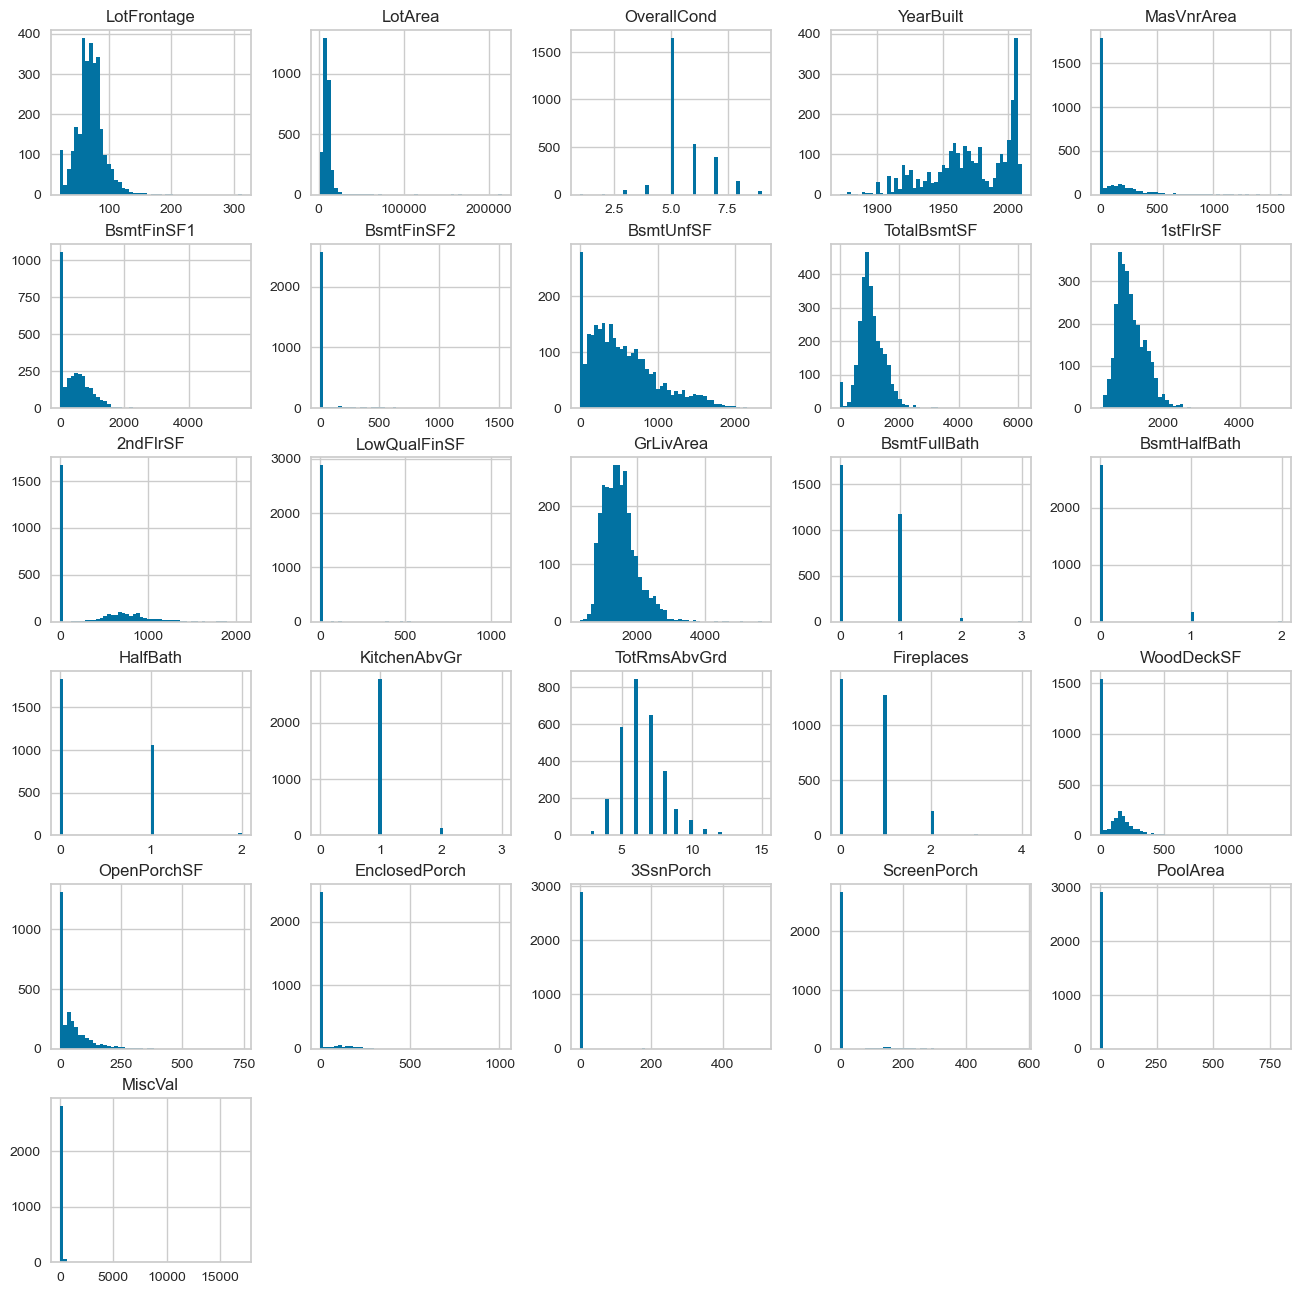

In [72]:
data4[['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']].hist(figsize=(16,16), bins = 50)

In [73]:
skew_df.query("Skewed == True")['Feature']

0       LotFrontage
1           LotArea
3       OverallCond
4         YearBuilt
6        MasVnrArea
7        BsmtFinSF1
8        BsmtFinSF2
9         BsmtUnfSF
10      TotalBsmtSF
11         1stFlrSF
12         2ndFlrSF
13     LowQualFinSF
14        GrLivArea
15     BsmtFullBath
16     BsmtHalfBath
18         HalfBath
20     KitchenAbvGr
21     TotRmsAbvGrd
22       Fireplaces
26       WoodDeckSF
27      OpenPorchSF
28    EnclosedPorch
29        3SsnPorch
30      ScreenPorch
31         PoolArea
32          MiscVal
Name: Feature, dtype: object

when a lot of values are concentrated around 0, this can often be numerically unstable. Applying the log transformation can spread them over a more appropriate range. The log function is undefined at zero, hence we use np.log1p

In [74]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data4[column] = np.log1p(data4[column])
data4

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0            60       RL     4.189655  9.042040   Pave  None      Reg   
1            20       RL     4.394449  9.169623   Pave  None      Reg   
2            60       RL     4.234107  9.328212   Pave  None      IR1   
3            70       RL     4.110874  9.164401   Pave  None      IR1   
4            60       RL     4.442651  9.565284   Pave  None      IR1   
...         ...      ...          ...       ...    ...   ...      ...   
2914        160       RM     3.091042  7.568896   Pave  None      Reg   
2915        160       RM     3.091042  7.546974   Pave  None      Reg   
2916         20       RL     5.081404  9.903538   Pave  None      Reg   
2917         85       RL     4.143135  9.253591   Pave  None      Reg   
2918         60       RL     4.317488  9.172431   Pave  None      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub    Inside  ...         0.0      0.0   None   None   
1            Lvl    AllPub       FR2  ...         0.0      0.0   None   None   
2            Lvl    AllPub    Inside  ...         0.0      0.0   None   None   
3            Lvl    AllPub    Corner  ...         0.0      0.0   None   None   
4            Lvl    AllPub       FR2  ...         0.0      0.0   None   None   
...          ...       ...       ...  ...         ...      ...    ...    ...   
2914         Lvl    AllPub    Inside  ...         0.0      0.0   None   None   
2915         Lvl    AllPub    Inside  ...         0.0      0.0   None   None   
2916         Lvl    AllPub    Inside  ...         0.0      0.0   None   None   
2917         Lvl    AllPub    Inside  ...         0.0      0.0   None  MnPrv   
2918         Lvl    AllPub    Inside  ...         0.0      0.0   None   None   

     MiscFeature   MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0           None  0.000000       2    2008        WD         Normal  
1           None  0.000000       5    2007        WD         Normal  
2           None  0.000000       9    2008        WD         Normal  
3           None  0.000000       2    2006        WD        Abnorml  
4           None  0.000000      12    2008        WD         Normal  
...          ...       ...     ...     ...       ...            ...  
2914        None  0.000000       6    2006        WD         Normal  
2915        None  0.000000       4    2006        WD        Abnorml  
2916        None  0.000000       9    2006        WD        Abnorml  
2917        Shed  6.552508       7    2006        WD         Normal  
2918        None  0.000000      11    2006        WD         Normal  

[2919 rows x 79 columns]

We can apply an interesting transformation to the 'MoSold' column. The month values are a cyclical feature, 1-12 doesnt particuarly work well. We'll apply a sin/cos transformation to capture the cycle of the year

In [75]:
data4['MoSold'] = np.cos(-0.5236 * data4.MoSold)

In [76]:
data5 = data4.copy()

# Encoding Categoricals

In [77]:
data5 = pd.get_dummies(data5, dtype = 'int')

In [78]:
data6 = data5.copy()

# Scaling

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data6)

data6 = pd.DataFrame(scaler.transform(data6), index = data6.index, columns = data6.columns)


In [80]:
data6

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       -0.064176 -0.103719     0.646183    -0.435439   1.040634   
1        0.536077  0.146544    -0.063185     1.906370   0.161526   
2        0.066112  0.457629     0.646183    -0.435439   0.975922   
3       -0.295084  0.136301     0.646183    -0.435439  -1.869638   
4        0.677357  0.922662     1.355551    -0.435439   0.943542   
...           ...       ...          ...          ...        ...   
2914    -3.284214 -2.993401    -1.481920     1.226101  -0.035461   
2915    -3.284214 -3.036401    -1.481920    -0.435439  -0.035461   
2916     2.549545  1.586172    -0.772552     1.226101  -0.365110   
2917    -0.200527  0.311255    -0.772552    -0.435439   0.683917   
2918     0.310504  0.152052     0.646183    -0.435439   0.716427   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
0         0.896833    1.210174    0.783229   -0.363076  -0.326949  ...   
1        -0.395604   -0.804554    0.892444   -0.363076   0.013428  ...   
2         0.848965    1.137926    0.658154   -0.363076   0.240016  ...   
3        -0.682812   -0.804554    0.386923   -0.363076   0.356870  ...   
4         0.753229    1.430432    0.758108   -0.363076   0.304906  ...   
...            ...         ...         ...         ...        ...  ...   
2914     -0.682812   -0.804554   -1.418196   -0.363076   0.362780  ...   
2915     -0.682812   -0.804554    0.438424   -0.363076   0.031907  ...   
2916      0.561757   -0.804554    0.967658   -0.363076  -3.015455  ...   
2917      0.370284   -0.804554    0.535612   -0.363076   0.390461  ...   
2918      0.466021    0.932048    0.807042   -0.363076  -0.080895  ...   

      SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0          -0.052423     -0.298629     -0.049029     0.394439   
1          -0.052423     -0.298629     -0.049029     0.394439   
2          -0.052423     -0.298629     -0.049029     0.394439   
3          -0.052423     -0.298629     -0.049029     0.394439   
4          -0.052423     -0.298629     -0.049029     0.394439   
...              ...           ...           ...          ...   
2914       -0.052423     -0.298629     -0.049029     0.394439   
2915       -0.052423     -0.298629     -0.049029     0.394439   
2916       -0.052423     -0.298629     -0.049029     0.394439   
2917       -0.052423     -0.298629     -0.049029     0.394439   
2918       -0.052423     -0.298629     -0.049029     0.394439   

      SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                 -0.263861              -0.064249              -0.09105   
1                 -0.263861              -0.064249              -0.09105   
2                 -0.263861              -0.064249              -0.09105   
3                  3.789876              -0.064249              -0.09105   
4                 -0.263861              -0.064249              -0.09105   
...                     ...                    ...                   ...   
2914              -0.263861              -0.064249              -0.09105   
2915               3.789876              -0.064249              -0.09105   
2916               3.789876              -0.064249              -0.09105   
2917              -0.263861              -0.064249              -0.09105   
2918              -0.263861              -0.064249              -0.09105   

      SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                -0.126535              0.463937              -0.302693  
1                -0.126535              0.463937              -0.302693  
2                -0.126535              0.463937              -0.302693  
3                -0.126535             -2.155466              -0.302693  
4                -0.126535              0.463937              -0.302693  
...                    ...                   ...                    ...  
2914             -0.126535              0.463937              -0.302693  
2915          

In [81]:
data7 = data6.copy()

# Target Transformation
you have to be careful when transforming the target, as you're changing the unit in which the model makes predictions. If you want to analyze the model's predictions you need to undo the transformation.
The target values are skewed, and so a log transformation may be beneficial

In [82]:
#sns.distplot(np.log(target), kde = True, fit = scipy.stats.norm)

log_target = np.log(target)

# Feature Selection
Feature selection is only required when you have an extremely large number of features to the point that it negatively affects the performance of your model. While do do have a lot of features, it isnt considered enough for feature selection to be too important.

# Splitting Data
We need to split our train and test data now

In [83]:
train_final = data7.loc[:train0.index.max(),:].copy()
test_final = data7.loc[train0.index.max()+ 1:,:].reset_index(drop = True).copy()
test_final

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0        0.536077  0.521437    -0.772552     0.454875  -0.332070   
1        0.572040  0.923625    -0.063185     0.454875  -0.431241   
2        0.310504  0.862607    -0.772552    -0.435439   0.846305   
3        0.462798  0.222291    -0.063185     0.454875   0.878733   
4       -1.252596 -1.130892     1.355551    -0.435439   0.683917   
...           ...       ...          ...          ...        ...   
1454    -3.284214 -2.993401    -1.481920     1.226101  -0.035461   
1455    -3.284214 -3.036401    -1.481920    -0.435439  -0.035461   
1456     2.549545  1.586172    -0.772552     1.226101  -0.365110   
1457    -0.200527  0.311255    -0.772552    -0.435439   0.683917   
1458     0.310504  0.152052     0.646183    -0.435439   0.716427   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
0        -1.113625   -0.804554    0.645518    2.285649  -0.013563  ...   
1        -1.257229    0.984472    0.873044   -0.363076   0.204364  ...   
2         0.657493   -0.804554    0.821322   -0.363076  -0.375189  ...   
3         0.657493    0.356462    0.729841   -0.363076   0.083804  ...   
4         0.370284   -0.804554    0.452704   -0.363076   0.695621  ...   
...            ...         ...         ...         ...        ...  ...   
1454     -0.682812   -0.804554   -1.418196   -0.363076   0.362780  ...   
1455     -0.682812   -0.804554    0.438424   -0.363076   0.031907  ...   
1456      0.561757   -0.804554    0.967658   -0.363076  -3.015455  ...   
1457      0.370284   -0.804554    0.535612   -0.363076   0.390461  ...   
1458      0.466021    0.932048    0.807042   -0.363076  -0.080895  ...   

      SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0          -0.052423     -0.298629     -0.049029     0.394439   
1          -0.052423     -0.298629     -0.049029     0.394439   
2          -0.052423     -0.298629     -0.049029     0.394439   
3          -0.052423     -0.298629     -0.049029     0.394439   
4          -0.052423     -0.298629     -0.049029     0.394439   
...              ...           ...           ...          ...   
1454       -0.052423     -0.298629     -0.049029     0.394439   
1455       -0.052423     -0.298629     -0.049029     0.394439   
1456       -0.052423     -0.298629     -0.049029     0.394439   
1457       -0.052423     -0.298629     -0.049029     0.394439   
1458       -0.052423     -0.298629     -0.049029     0.394439   

      SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                 -0.263861              -0.064249              -0.09105   
1                 -0.263861              -0.064249              -0.09105   
2                 -0.263861              -0.064249              -0.09105   
3                 -0.263861              -0.064249              -0.09105   
4                 -0.263861              -0.064249              -0.09105   
...                     ...                    ...                   ...   
1454              -0.263861              -0.064249              -0.09105   
1455               3.789876              -0.064249              -0.09105   
1456               3.789876              -0.064249              -0.09105   
1457              -0.263861              -0.064249              -0.09105   
1458              -0.263861              -0.064249              -0.09105   

      SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                -0.126535              0.463937              -0.302693  
1                -0.126535              0.463937              -0.302693  
2                -0.126535              0.463937              -0.302693  
3                -0.126535              0.463937              -0.302693  
4                -0.126535              0.463937              -0.302693  
...                    ...                   ...                    ...  
1454             -0.126535              0.463937              -0.302693  
1455          

# Model Selection
A good tool for model selecton is pycaret

In [29]:
import pycaret
from pycaret.regression import setup, compare_models


setup(data = pd.concat([train_final, log_target], axis = 1), target = 'SalePrice')

In [30]:
compare_models()

take the top 5 models and bag them together. Each model is likely exceling in one thing but not another. We take the top 5 and take the average of the results

In [84]:
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=4)

# Hyperparameter optimization

In [85]:
def br_objective(trial):
    max_iter = trial.suggest_int('max_iter', 350, 600)
    tol = trial.suggest_float('tol', 1e-9, 10, log = True)
    alpha_1 = trial.suggest_float('alpha_1', 1e-9, 10, log = True)
    alpha_2 = trial.suggest_float('alpha_2', 1e-9, 10, log = True)
    lambda_1 = trial.suggest_float('lambda_1', 1e-9, 10, log = True)
    lambda_2 = trial.suggest_float('lambda_2', 1e-9, 10, log = True)
    
    model = BayesianRidge(max_iter=max_iter,
                            tol=tol,
                            alpha_1 = alpha_1,
                            alpha_2 = alpha_2,
                            lambda_1 = lambda_1,
                            lambda_2 = lambda_2
                         )
    model.fit(train_final, log_target)
    
    cv_scores = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    
    return np.mean(cv_scores)

In [86]:
study_br = optuna.create_study(direction = 'minimize')
study_br.optimize(br_objective, n_trials = 100, n_jobs = 10)

[I 2024-05-03 17:22:29,486] A new study created in memory with name: no-name-561f8f4f-e7f4-42a6-a586-98e3fbf8b7ac
[I 2024-05-03 17:22:30,623] Trial 1 finished with value: 1.148636291666697 and parameters: {'max_iter': 390, 'tol': 0.8100429599759332, 'alpha_1': 0.0039978329598446575, 'alpha_2': 1.0143751851328073e-07, 'lambda_1': 0.00018973143293904928, 'lambda_2': 4.511125787666139}. Best is trial 1 with value: 1.148636291666697.
[I 2024-05-03 17:22:30,702] Trial 7 finished with value: 1.137926090110408 and parameters: {'max_iter': 590, 'tol': 3.3181364398868456, 'alpha_1': 4.076568923301465e-05, 'alpha_2': 0.019371608991151257, 'lambda_1': 1.8158384712622083e-06, 'lambda_2': 0.0006951721915581167}. Best is trial 7 with value: 1.137926090110408.
[I 2024-05-03 17:22:30,962] Trial 0 finished with value: 1.1372255936679294 and parameters: {'max_iter': 483, 'tol': 0.012970680996497803, 'alpha_1': 0.34815788972980055, 'alpha_2': 0.0006265751991088009, 'lambda_1': 1.423893292248408e-07, 'lam

[I 2024-05-03 17:22:34,445] Trial 24 finished with value: 1.135308696300768 and parameters: {'max_iter': 529, 'tol': 1.0391485243031028e-09, 'alpha_1': 7.096076678442421, 'alpha_2': 6.7016711972580865, 'lambda_1': 0.04291326436900139, 'lambda_2': 1.0840493411801646e-09}. Best is trial 24 with value: 1.135308696300768.
[I 2024-05-03 17:22:34,517] Trial 27 finished with value: 1.1369014730945208 and parameters: {'max_iter': 513, 'tol': 3.0816143575076696e-07, 'alpha_1': 7.622712232309661, 'alpha_2': 0.5658181240171546, 'lambda_1': 0.05960733959764566, 'lambda_2': 3.345290562600077e-08}. Best is trial 24 with value: 1.135308696300768.
[I 2024-05-03 17:22:34,518] Trial 26 finished with value: 1.1360060359834285 and parameters: {'max_iter': 514, 'tol': 2.0985477593546084e-09, 'alpha_1': 9.053060501634192, 'alpha_2': 2.5257242638668385, 'lambda_1': 0.053129433646211595, 'lambda_2': 1.8800185880819023e-08}. Best is trial 24 with value: 1.135308696300768.
[I 2024-05-03 17:22:34,713] Trial 30 f

[I 2024-05-03 17:22:38,987] Trial 52 finished with value: 1.1368833353228722 and parameters: {'max_iter': 499, 'tol': 2.5851694998779313e-06, 'alpha_1': 1.2196210908813242e-07, 'alpha_2': 0.4946306138385237, 'lambda_1': 0.32268658342371714, 'lambda_2': 1.3198177736065475e-07}. Best is trial 33 with value: 1.1353050916747325.
[I 2024-05-03 17:22:39,021] Trial 53 finished with value: 1.1367526591559933 and parameters: {'max_iter': 495, 'tol': 1.8600574369375818e-06, 'alpha_1': 0.023543659414387103, 'alpha_2': 0.7299755536933792, 'lambda_1': 0.014404320240779768, 'lambda_2': 1.5359358702529354e-07}. Best is trial 33 with value: 1.1353050916747325.
[I 2024-05-03 17:22:39,175] Trial 55 finished with value: 1.1369665505642248 and parameters: {'max_iter': 497, 'tol': 1.4655590346567525e-06, 'alpha_1': 2.248695716663101e-07, 'alpha_2': 0.37682823624949846, 'lambda_1': 0.01688343243412122, 'lambda_2': 1.291359734242949e-07}. Best is trial 33 with value: 1.1353050916747325.
[I 2024-05-03 17:22:3

[I 2024-05-03 17:22:42,766] Trial 74 finished with value: 1.1353134900416175 and parameters: {'max_iter': 512, 'tol': 0.013191850505797933, 'alpha_1': 0.00012598284220137753, 'alpha_2': 8.225423790052005, 'lambda_1': 0.8799114403103201, 'lambda_2': 1.1895967448802555e-06}. Best is trial 76 with value: 1.135303781201682.
[I 2024-05-03 17:22:43,080] Trial 78 finished with value: 1.136518723006525 and parameters: {'max_iter': 511, 'tol': 0.003349398894490017, 'alpha_1': 0.2605147177064311, 'alpha_2': 1.1397353437262576, 'lambda_1': 0.9750907538916757, 'lambda_2': 5.73112654726557e-05}. Best is trial 76 with value: 1.135303781201682.
[I 2024-05-03 17:22:43,095] Trial 79 finished with value: 1.1364274959426062 and parameters: {'max_iter': 509, 'tol': 0.0031123034250747617, 'alpha_1': 0.2910777319583585, 'alpha_2': 1.3554847775385002, 'lambda_1': 1.023760895002178e-09, 'lambda_2': 1.6469062779109048e-06}. Best is trial 76 with value: 1.135303781201682.
[I 2024-05-03 17:22:43,163] Trial 80 fi

In [87]:
print(study_br.best_params)
print(study_br.best_value)

{'max_iter': 489, 'tol': 0.21592606191528638, 'alpha_1': 7.046188209247175e-05, 'alpha_2': 6.355899138156756, 'lambda_1': 5.912416487251253, 'lambda_2': 4.455861256610904e-06}
1.1352925091196913


In [100]:
def cat_objective(trial):
    cat_params = {
    "iterations" : trial.suggest_int('iterations', 3000, 7000),
    "learning_rate" : trial.suggest_float('learning_rate', 1e-3, .01, log = True),
    "depth" : trial.suggest_int('depth', 2, 9),
    "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', .1, 10, log = True)
        
    }
    model = CatBoostRegressor(**cat_params)
    model.fit(train_final, log_target, early_stopping_rounds = 50, verbose = 100)
    
    cv_scores = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=3)))
    
    return np.mean(cv_scores)

In [101]:
study_cat = optuna.create_study(direction = 'minimize')
study_cat.optimize(cat_objective, n_trials = 5)

[I 2024-05-03 17:30:23,770] A new study created in memory with name: no-name-1daf70a6-f19b-45fe-b667-8e71a405c37f


0:	learn: 0.3968736	total: 3.49ms	remaining: 22.5s
100:	learn: 0.2401607	total: 192ms	remaining: 12s
200:	learn: 0.1735288	total: 353ms	remaining: 10.9s
300:	learn: 0.1436468	total: 470ms	remaining: 9.56s
400:	learn: 0.1275421	total: 572ms	remaining: 8.6s
500:	learn: 0.1170150	total: 698ms	remaining: 8.26s
600:	learn: 0.1095783	total: 805ms	remaining: 7.81s
700:	learn: 0.1041027	total: 906ms	remaining: 7.4s
800:	learn: 0.0995625	total: 1.01s	remaining: 7.07s
900:	learn: 0.0956994	total: 1.11s	remaining: 6.84s
1000:	learn: 0.0921129	total: 1.22s	remaining: 6.6s
1100:	learn: 0.0889847	total: 1.32s	remaining: 6.38s
1200:	learn: 0.0860503	total: 1.42s	remaining: 6.18s
1300:	learn: 0.0834913	total: 1.52s	remaining: 6.01s
1400:	learn: 0.0809552	total: 1.63s	remaining: 5.86s
1500:	learn: 0.0786649	total: 1.75s	remaining: 5.76s
1600:	learn: 0.0766490	total: 1.87s	remaining: 5.63s
1700:	learn: 0.0746290	total: 1.97s	remaining: 5.47s
1800:	learn: 0.0727455	total: 2.08s	remaining: 5.34s
1900:	lea

234:	learn: 0.1625170	total: 234ms	remaining: 6.17s
235:	learn: 0.1621649	total: 235ms	remaining: 6.17s
236:	learn: 0.1618654	total: 236ms	remaining: 6.17s
237:	learn: 0.1615410	total: 237ms	remaining: 6.17s
238:	learn: 0.1612001	total: 238ms	remaining: 6.16s
239:	learn: 0.1608423	total: 239ms	remaining: 6.16s
240:	learn: 0.1605455	total: 240ms	remaining: 6.17s
241:	learn: 0.1601939	total: 241ms	remaining: 6.17s
242:	learn: 0.1598923	total: 242ms	remaining: 6.17s
243:	learn: 0.1594626	total: 243ms	remaining: 6.17s
244:	learn: 0.1591955	total: 244ms	remaining: 6.17s
245:	learn: 0.1589087	total: 246ms	remaining: 6.17s
246:	learn: 0.1586088	total: 247ms	remaining: 6.17s
247:	learn: 0.1583062	total: 248ms	remaining: 6.17s
248:	learn: 0.1580053	total: 249ms	remaining: 6.17s
249:	learn: 0.1577451	total: 250ms	remaining: 6.17s
250:	learn: 0.1574255	total: 250ms	remaining: 6.17s
251:	learn: 0.1571506	total: 251ms	remaining: 6.16s
252:	learn: 0.1569283	total: 252ms	remaining: 6.16s
253:	learn: 

395:	learn: 0.1274637	total: 403ms	remaining: 6.14s
396:	learn: 0.1272985	total: 404ms	remaining: 6.14s
397:	learn: 0.1271841	total: 405ms	remaining: 6.14s
398:	learn: 0.1270611	total: 407ms	remaining: 6.14s
399:	learn: 0.1269310	total: 408ms	remaining: 6.15s
400:	learn: 0.1267404	total: 409ms	remaining: 6.15s
401:	learn: 0.1266095	total: 410ms	remaining: 6.15s
402:	learn: 0.1264638	total: 411ms	remaining: 6.15s
403:	learn: 0.1263497	total: 413ms	remaining: 6.15s
404:	learn: 0.1262216	total: 414ms	remaining: 6.16s
405:	learn: 0.1260826	total: 415ms	remaining: 6.16s
406:	learn: 0.1259864	total: 416ms	remaining: 6.16s
407:	learn: 0.1258797	total: 417ms	remaining: 6.16s
408:	learn: 0.1257463	total: 418ms	remaining: 6.16s
409:	learn: 0.1255717	total: 419ms	remaining: 6.16s
410:	learn: 0.1253890	total: 420ms	remaining: 6.16s
411:	learn: 0.1252573	total: 422ms	remaining: 6.16s
412:	learn: 0.1251154	total: 423ms	remaining: 6.16s
413:	learn: 0.1249663	total: 424ms	remaining: 6.16s
414:	learn: 

597:	learn: 0.1075537	total: 599ms	remaining: 5.84s
598:	learn: 0.1074790	total: 600ms	remaining: 5.84s
599:	learn: 0.1073930	total: 601ms	remaining: 5.84s
600:	learn: 0.1073281	total: 602ms	remaining: 5.84s
601:	learn: 0.1072614	total: 603ms	remaining: 5.84s
602:	learn: 0.1072098	total: 604ms	remaining: 5.84s
603:	learn: 0.1071240	total: 605ms	remaining: 5.83s
604:	learn: 0.1070629	total: 606ms	remaining: 5.83s
605:	learn: 0.1069895	total: 607ms	remaining: 5.83s
606:	learn: 0.1069203	total: 608ms	remaining: 5.83s
607:	learn: 0.1068427	total: 609ms	remaining: 5.83s
608:	learn: 0.1067860	total: 610ms	remaining: 5.83s
609:	learn: 0.1067324	total: 611ms	remaining: 5.83s
610:	learn: 0.1066562	total: 612ms	remaining: 5.83s
611:	learn: 0.1065737	total: 613ms	remaining: 5.82s
612:	learn: 0.1065053	total: 614ms	remaining: 5.83s
613:	learn: 0.1064343	total: 615ms	remaining: 5.83s
614:	learn: 0.1063796	total: 617ms	remaining: 5.83s
615:	learn: 0.1063164	total: 618ms	remaining: 5.83s
616:	learn: 

797:	learn: 0.0963845	total: 803ms	remaining: 5.67s
798:	learn: 0.0963459	total: 805ms	remaining: 5.67s
799:	learn: 0.0962736	total: 806ms	remaining: 5.67s
800:	learn: 0.0962131	total: 807ms	remaining: 5.67s
801:	learn: 0.0961636	total: 808ms	remaining: 5.67s
802:	learn: 0.0961016	total: 809ms	remaining: 5.67s
803:	learn: 0.0960554	total: 810ms	remaining: 5.67s
804:	learn: 0.0960021	total: 811ms	remaining: 5.67s
805:	learn: 0.0959673	total: 812ms	remaining: 5.67s
806:	learn: 0.0959251	total: 813ms	remaining: 5.67s
807:	learn: 0.0958772	total: 814ms	remaining: 5.66s
808:	learn: 0.0958366	total: 815ms	remaining: 5.66s
809:	learn: 0.0957801	total: 816ms	remaining: 5.66s
810:	learn: 0.0957297	total: 817ms	remaining: 5.66s
811:	learn: 0.0956883	total: 818ms	remaining: 5.66s
812:	learn: 0.0956280	total: 819ms	remaining: 5.66s
813:	learn: 0.0955913	total: 820ms	remaining: 5.66s
814:	learn: 0.0955437	total: 821ms	remaining: 5.66s
815:	learn: 0.0954955	total: 822ms	remaining: 5.66s
816:	learn: 

995:	learn: 0.0882535	total: 999ms	remaining: 5.45s
996:	learn: 0.0882075	total: 1s	remaining: 5.45s
997:	learn: 0.0881815	total: 1s	remaining: 5.45s
998:	learn: 0.0881421	total: 1s	remaining: 5.45s
999:	learn: 0.0880983	total: 1s	remaining: 5.44s
1000:	learn: 0.0880668	total: 1s	remaining: 5.44s
1001:	learn: 0.0880407	total: 1s	remaining: 5.44s
1002:	learn: 0.0880084	total: 1s	remaining: 5.44s
1003:	learn: 0.0879698	total: 1.01s	remaining: 5.44s
1004:	learn: 0.0879281	total: 1.01s	remaining: 5.44s
1005:	learn: 0.0878863	total: 1.01s	remaining: 5.43s
1006:	learn: 0.0878509	total: 1.01s	remaining: 5.43s
1007:	learn: 0.0878224	total: 1.01s	remaining: 5.43s
1008:	learn: 0.0877983	total: 1.01s	remaining: 5.43s
1009:	learn: 0.0877500	total: 1.01s	remaining: 5.43s
1010:	learn: 0.0877210	total: 1.01s	remaining: 5.43s
1011:	learn: 0.0876882	total: 1.01s	remaining: 5.43s
1012:	learn: 0.0876562	total: 1.01s	remaining: 5.43s
1013:	learn: 0.0876175	total: 1.02s	remaining: 5.43s
1014:	learn: 0.0875

1196:	learn: 0.0820446	total: 1.19s	remaining: 5.22s
1197:	learn: 0.0820055	total: 1.19s	remaining: 5.21s
1198:	learn: 0.0819685	total: 1.2s	remaining: 5.21s
1199:	learn: 0.0819396	total: 1.2s	remaining: 5.21s
1200:	learn: 0.0819205	total: 1.2s	remaining: 5.21s
1201:	learn: 0.0818952	total: 1.2s	remaining: 5.21s
1202:	learn: 0.0818563	total: 1.2s	remaining: 5.21s
1203:	learn: 0.0818469	total: 1.2s	remaining: 5.21s
1204:	learn: 0.0818150	total: 1.2s	remaining: 5.21s
1205:	learn: 0.0817776	total: 1.2s	remaining: 5.21s
1206:	learn: 0.0817392	total: 1.2s	remaining: 5.21s
1207:	learn: 0.0816982	total: 1.2s	remaining: 5.21s
1208:	learn: 0.0816751	total: 1.21s	remaining: 5.21s
1209:	learn: 0.0816669	total: 1.21s	remaining: 5.21s
1210:	learn: 0.0816346	total: 1.21s	remaining: 5.2s
1211:	learn: 0.0815889	total: 1.21s	remaining: 5.2s
1212:	learn: 0.0815539	total: 1.21s	remaining: 5.2s
1213:	learn: 0.0815418	total: 1.21s	remaining: 5.2s
1214:	learn: 0.0815149	total: 1.21s	remaining: 5.2s
1215:	le

1397:	learn: 0.0768429	total: 1.39s	remaining: 4.99s
1398:	learn: 0.0768365	total: 1.39s	remaining: 4.99s
1399:	learn: 0.0768304	total: 1.39s	remaining: 4.99s
1400:	learn: 0.0768017	total: 1.39s	remaining: 4.99s
1401:	learn: 0.0767831	total: 1.39s	remaining: 4.99s
1402:	learn: 0.0767632	total: 1.39s	remaining: 4.99s
1403:	learn: 0.0767430	total: 1.39s	remaining: 4.99s
1404:	learn: 0.0767149	total: 1.39s	remaining: 4.99s
1405:	learn: 0.0766943	total: 1.4s	remaining: 4.99s
1406:	learn: 0.0766843	total: 1.4s	remaining: 4.98s
1407:	learn: 0.0766599	total: 1.4s	remaining: 4.98s
1408:	learn: 0.0766314	total: 1.4s	remaining: 4.98s
1409:	learn: 0.0766050	total: 1.4s	remaining: 4.98s
1410:	learn: 0.0765707	total: 1.4s	remaining: 4.98s
1411:	learn: 0.0765466	total: 1.4s	remaining: 4.98s
1412:	learn: 0.0765365	total: 1.4s	remaining: 4.98s
1413:	learn: 0.0765158	total: 1.4s	remaining: 4.98s
1414:	learn: 0.0764924	total: 1.4s	remaining: 4.98s
1415:	learn: 0.0764567	total: 1.41s	remaining: 4.98s
141

1600:	learn: 0.0720650	total: 1.58s	remaining: 4.77s
1601:	learn: 0.0720598	total: 1.58s	remaining: 4.77s
1602:	learn: 0.0720272	total: 1.58s	remaining: 4.77s
1603:	learn: 0.0720026	total: 1.58s	remaining: 4.77s
1604:	learn: 0.0719618	total: 1.58s	remaining: 4.77s
1605:	learn: 0.0719359	total: 1.59s	remaining: 4.76s
1606:	learn: 0.0719067	total: 1.59s	remaining: 4.76s
1607:	learn: 0.0718739	total: 1.59s	remaining: 4.76s
1608:	learn: 0.0718522	total: 1.59s	remaining: 4.76s
1609:	learn: 0.0718290	total: 1.59s	remaining: 4.76s
1610:	learn: 0.0718061	total: 1.59s	remaining: 4.76s
1611:	learn: 0.0717821	total: 1.59s	remaining: 4.76s
1612:	learn: 0.0717471	total: 1.59s	remaining: 4.76s
1613:	learn: 0.0717398	total: 1.6s	remaining: 4.76s
1614:	learn: 0.0717148	total: 1.6s	remaining: 4.76s
1615:	learn: 0.0716857	total: 1.6s	remaining: 4.76s
1616:	learn: 0.0716459	total: 1.6s	remaining: 4.76s
1617:	learn: 0.0716303	total: 1.6s	remaining: 4.76s
1618:	learn: 0.0716068	total: 1.6s	remaining: 4.76s

1798:	learn: 0.0673417	total: 1.78s	remaining: 4.57s
1799:	learn: 0.0673142	total: 1.78s	remaining: 4.57s
1800:	learn: 0.0673081	total: 1.78s	remaining: 4.57s
1801:	learn: 0.0672794	total: 1.78s	remaining: 4.57s
1802:	learn: 0.0672565	total: 1.78s	remaining: 4.57s
1803:	learn: 0.0672389	total: 1.78s	remaining: 4.57s
1804:	learn: 0.0672202	total: 1.78s	remaining: 4.57s
1805:	learn: 0.0671916	total: 1.78s	remaining: 4.57s
1806:	learn: 0.0671668	total: 1.78s	remaining: 4.57s
1807:	learn: 0.0671540	total: 1.78s	remaining: 4.56s
1808:	learn: 0.0671321	total: 1.79s	remaining: 4.56s
1809:	learn: 0.0671146	total: 1.79s	remaining: 4.56s
1810:	learn: 0.0671055	total: 1.79s	remaining: 4.56s
1811:	learn: 0.0670912	total: 1.79s	remaining: 4.56s
1812:	learn: 0.0670661	total: 1.79s	remaining: 4.56s
1813:	learn: 0.0670371	total: 1.79s	remaining: 4.56s
1814:	learn: 0.0670193	total: 1.79s	remaining: 4.56s
1815:	learn: 0.0669931	total: 1.79s	remaining: 4.56s
1816:	learn: 0.0669588	total: 1.79s	remaining:

2002:	learn: 0.0629206	total: 1.97s	remaining: 4.35s
2003:	learn: 0.0628981	total: 1.97s	remaining: 4.35s
2004:	learn: 0.0628792	total: 1.97s	remaining: 4.35s
2005:	learn: 0.0628562	total: 1.97s	remaining: 4.35s
2006:	learn: 0.0628318	total: 1.97s	remaining: 4.35s
2007:	learn: 0.0628056	total: 1.98s	remaining: 4.35s
2008:	learn: 0.0627831	total: 1.98s	remaining: 4.35s
2009:	learn: 0.0627798	total: 1.98s	remaining: 4.35s
2010:	learn: 0.0627660	total: 1.98s	remaining: 4.35s
2011:	learn: 0.0627439	total: 1.98s	remaining: 4.35s
2012:	learn: 0.0627293	total: 1.98s	remaining: 4.34s
2013:	learn: 0.0627041	total: 1.98s	remaining: 4.34s
2014:	learn: 0.0626869	total: 1.98s	remaining: 4.34s
2015:	learn: 0.0626765	total: 1.98s	remaining: 4.34s
2016:	learn: 0.0626558	total: 1.98s	remaining: 4.34s
2017:	learn: 0.0626492	total: 1.99s	remaining: 4.34s
2018:	learn: 0.0626258	total: 1.99s	remaining: 4.34s
2019:	learn: 0.0626087	total: 1.99s	remaining: 4.34s
2020:	learn: 0.0625895	total: 1.99s	remaining:

2203:	learn: 0.0590320	total: 2.16s	remaining: 4.15s
2204:	learn: 0.0590217	total: 2.17s	remaining: 4.15s
2205:	learn: 0.0589980	total: 2.17s	remaining: 4.15s
2206:	learn: 0.0589731	total: 2.17s	remaining: 4.14s
2207:	learn: 0.0589581	total: 2.17s	remaining: 4.14s
2208:	learn: 0.0589528	total: 2.17s	remaining: 4.14s
2209:	learn: 0.0589304	total: 2.17s	remaining: 4.14s
2210:	learn: 0.0589092	total: 2.17s	remaining: 4.14s
2211:	learn: 0.0588966	total: 2.17s	remaining: 4.14s
2212:	learn: 0.0588771	total: 2.17s	remaining: 4.14s
2213:	learn: 0.0588728	total: 2.17s	remaining: 4.14s
2214:	learn: 0.0588697	total: 2.17s	remaining: 4.14s
2215:	learn: 0.0588618	total: 2.17s	remaining: 4.13s
2216:	learn: 0.0588459	total: 2.18s	remaining: 4.13s
2217:	learn: 0.0588285	total: 2.18s	remaining: 4.13s
2218:	learn: 0.0588156	total: 2.18s	remaining: 4.13s
2219:	learn: 0.0588027	total: 2.18s	remaining: 4.13s
2220:	learn: 0.0587974	total: 2.18s	remaining: 4.13s
2221:	learn: 0.0587777	total: 2.18s	remaining:

2399:	learn: 0.0557061	total: 2.36s	remaining: 3.96s
2400:	learn: 0.0556964	total: 2.36s	remaining: 3.96s
2401:	learn: 0.0556811	total: 2.36s	remaining: 3.96s
2402:	learn: 0.0556752	total: 2.36s	remaining: 3.96s
2403:	learn: 0.0556618	total: 2.36s	remaining: 3.95s
2404:	learn: 0.0556464	total: 2.36s	remaining: 3.95s
2405:	learn: 0.0556259	total: 2.36s	remaining: 3.95s
2406:	learn: 0.0556039	total: 2.36s	remaining: 3.95s
2407:	learn: 0.0555898	total: 2.37s	remaining: 3.95s
2408:	learn: 0.0555730	total: 2.37s	remaining: 3.95s
2409:	learn: 0.0555516	total: 2.37s	remaining: 3.95s
2410:	learn: 0.0555424	total: 2.37s	remaining: 3.95s
2411:	learn: 0.0555345	total: 2.37s	remaining: 3.94s
2412:	learn: 0.0555057	total: 2.37s	remaining: 3.94s
2413:	learn: 0.0554919	total: 2.37s	remaining: 3.94s
2414:	learn: 0.0554854	total: 2.37s	remaining: 3.94s
2415:	learn: 0.0554723	total: 2.37s	remaining: 3.94s
2416:	learn: 0.0554563	total: 2.37s	remaining: 3.94s
2417:	learn: 0.0554431	total: 2.38s	remaining:

2604:	learn: 0.0524003	total: 2.55s	remaining: 3.75s
2605:	learn: 0.0523815	total: 2.55s	remaining: 3.75s
2606:	learn: 0.0523691	total: 2.56s	remaining: 3.75s
2607:	learn: 0.0523586	total: 2.56s	remaining: 3.75s
2608:	learn: 0.0523420	total: 2.56s	remaining: 3.74s
2609:	learn: 0.0523196	total: 2.56s	remaining: 3.74s
2610:	learn: 0.0523126	total: 2.56s	remaining: 3.74s
2611:	learn: 0.0522914	total: 2.56s	remaining: 3.74s
2612:	learn: 0.0522736	total: 2.56s	remaining: 3.74s
2613:	learn: 0.0522677	total: 2.56s	remaining: 3.74s
2614:	learn: 0.0522558	total: 2.56s	remaining: 3.74s
2615:	learn: 0.0522350	total: 2.56s	remaining: 3.74s
2616:	learn: 0.0522201	total: 2.56s	remaining: 3.74s
2617:	learn: 0.0522141	total: 2.57s	remaining: 3.74s
2618:	learn: 0.0522007	total: 2.57s	remaining: 3.73s
2619:	learn: 0.0521852	total: 2.57s	remaining: 3.73s
2620:	learn: 0.0521711	total: 2.57s	remaining: 3.73s
2621:	learn: 0.0521524	total: 2.57s	remaining: 3.73s
2622:	learn: 0.0521475	total: 2.57s	remaining:

2790:	learn: 0.0496151	total: 2.75s	remaining: 3.58s
2791:	learn: 0.0496000	total: 2.75s	remaining: 3.58s
2792:	learn: 0.0495790	total: 2.75s	remaining: 3.58s
2793:	learn: 0.0495645	total: 2.75s	remaining: 3.58s
2794:	learn: 0.0495510	total: 2.75s	remaining: 3.58s
2795:	learn: 0.0495286	total: 2.75s	remaining: 3.58s
2796:	learn: 0.0495160	total: 2.75s	remaining: 3.58s
2797:	learn: 0.0495015	total: 2.75s	remaining: 3.57s
2798:	learn: 0.0494932	total: 2.75s	remaining: 3.57s
2799:	learn: 0.0494777	total: 2.76s	remaining: 3.57s
2800:	learn: 0.0494635	total: 2.76s	remaining: 3.57s
2801:	learn: 0.0494433	total: 2.76s	remaining: 3.57s
2802:	learn: 0.0494303	total: 2.76s	remaining: 3.57s
2803:	learn: 0.0494183	total: 2.76s	remaining: 3.57s
2804:	learn: 0.0493995	total: 2.76s	remaining: 3.57s
2805:	learn: 0.0493915	total: 2.76s	remaining: 3.57s
2806:	learn: 0.0493668	total: 2.76s	remaining: 3.56s
2807:	learn: 0.0493425	total: 2.76s	remaining: 3.56s
2808:	learn: 0.0493295	total: 2.77s	remaining:

2979:	learn: 0.0469923	total: 2.94s	remaining: 3.4s
2980:	learn: 0.0469777	total: 2.94s	remaining: 3.4s
2981:	learn: 0.0469604	total: 2.94s	remaining: 3.4s
2982:	learn: 0.0469422	total: 2.94s	remaining: 3.4s
2983:	learn: 0.0469350	total: 2.94s	remaining: 3.4s
2984:	learn: 0.0469183	total: 2.95s	remaining: 3.4s
2985:	learn: 0.0469071	total: 2.95s	remaining: 3.4s
2986:	learn: 0.0468910	total: 2.95s	remaining: 3.4s
2987:	learn: 0.0468783	total: 2.95s	remaining: 3.4s
2988:	learn: 0.0468591	total: 2.95s	remaining: 3.4s
2989:	learn: 0.0468431	total: 2.95s	remaining: 3.4s
2990:	learn: 0.0468297	total: 2.95s	remaining: 3.4s
2991:	learn: 0.0468246	total: 2.96s	remaining: 3.39s
2992:	learn: 0.0468111	total: 2.96s	remaining: 3.39s
2993:	learn: 0.0467926	total: 2.96s	remaining: 3.39s
2994:	learn: 0.0467825	total: 2.96s	remaining: 3.39s
2995:	learn: 0.0467688	total: 2.96s	remaining: 3.39s
2996:	learn: 0.0467587	total: 2.96s	remaining: 3.39s
2997:	learn: 0.0467474	total: 2.96s	remaining: 3.39s
2998:

3148:	learn: 0.0448484	total: 3.11s	remaining: 3.24s
3149:	learn: 0.0448437	total: 3.11s	remaining: 3.24s
3150:	learn: 0.0448298	total: 3.11s	remaining: 3.24s
3151:	learn: 0.0448222	total: 3.11s	remaining: 3.24s
3152:	learn: 0.0448057	total: 3.12s	remaining: 3.24s
3153:	learn: 0.0447936	total: 3.12s	remaining: 3.24s
3154:	learn: 0.0447800	total: 3.12s	remaining: 3.23s
3155:	learn: 0.0447705	total: 3.12s	remaining: 3.23s
3156:	learn: 0.0447594	total: 3.12s	remaining: 3.23s
3157:	learn: 0.0447514	total: 3.12s	remaining: 3.23s
3158:	learn: 0.0447403	total: 3.12s	remaining: 3.23s
3159:	learn: 0.0447300	total: 3.12s	remaining: 3.23s
3160:	learn: 0.0447107	total: 3.12s	remaining: 3.23s
3161:	learn: 0.0446869	total: 3.12s	remaining: 3.23s
3162:	learn: 0.0446779	total: 3.13s	remaining: 3.23s
3163:	learn: 0.0446659	total: 3.13s	remaining: 3.23s
3164:	learn: 0.0446469	total: 3.13s	remaining: 3.23s
3165:	learn: 0.0446432	total: 3.13s	remaining: 3.23s
3166:	learn: 0.0446333	total: 3.13s	remaining:

3347:	learn: 0.0425135	total: 3.3s	remaining: 3.04s
3348:	learn: 0.0425010	total: 3.31s	remaining: 3.04s
3349:	learn: 0.0424881	total: 3.31s	remaining: 3.04s
3350:	learn: 0.0424786	total: 3.31s	remaining: 3.04s
3351:	learn: 0.0424677	total: 3.31s	remaining: 3.04s
3352:	learn: 0.0424566	total: 3.31s	remaining: 3.04s
3353:	learn: 0.0424452	total: 3.31s	remaining: 3.04s
3354:	learn: 0.0424354	total: 3.31s	remaining: 3.03s
3355:	learn: 0.0424286	total: 3.31s	remaining: 3.03s
3356:	learn: 0.0424258	total: 3.31s	remaining: 3.03s
3357:	learn: 0.0424159	total: 3.31s	remaining: 3.03s
3358:	learn: 0.0424031	total: 3.32s	remaining: 3.03s
3359:	learn: 0.0423922	total: 3.32s	remaining: 3.03s
3360:	learn: 0.0423874	total: 3.32s	remaining: 3.03s
3361:	learn: 0.0423709	total: 3.32s	remaining: 3.03s
3362:	learn: 0.0423611	total: 3.32s	remaining: 3.03s
3363:	learn: 0.0423478	total: 3.32s	remaining: 3.02s
3364:	learn: 0.0423379	total: 3.32s	remaining: 3.02s
3365:	learn: 0.0423206	total: 3.32s	remaining: 

3542:	learn: 0.0404213	total: 3.5s	remaining: 2.85s
3543:	learn: 0.0404086	total: 3.5s	remaining: 2.85s
3544:	learn: 0.0404002	total: 3.5s	remaining: 2.85s
3545:	learn: 0.0403910	total: 3.5s	remaining: 2.85s
3546:	learn: 0.0403832	total: 3.5s	remaining: 2.85s
3547:	learn: 0.0403727	total: 3.5s	remaining: 2.85s
3548:	learn: 0.0403672	total: 3.51s	remaining: 2.85s
3549:	learn: 0.0403623	total: 3.51s	remaining: 2.84s
3550:	learn: 0.0403504	total: 3.51s	remaining: 2.84s
3551:	learn: 0.0403361	total: 3.51s	remaining: 2.84s
3552:	learn: 0.0403241	total: 3.51s	remaining: 2.84s
3553:	learn: 0.0403148	total: 3.51s	remaining: 2.84s
3554:	learn: 0.0403064	total: 3.51s	remaining: 2.84s
3555:	learn: 0.0402938	total: 3.51s	remaining: 2.84s
3556:	learn: 0.0402807	total: 3.51s	remaining: 2.84s
3557:	learn: 0.0402637	total: 3.52s	remaining: 2.84s
3558:	learn: 0.0402582	total: 3.52s	remaining: 2.84s
3559:	learn: 0.0402538	total: 3.52s	remaining: 2.83s
3560:	learn: 0.0402408	total: 3.52s	remaining: 2.83s

3734:	learn: 0.0384541	total: 3.69s	remaining: 2.66s
3735:	learn: 0.0384479	total: 3.69s	remaining: 2.66s
3736:	learn: 0.0384395	total: 3.7s	remaining: 2.66s
3737:	learn: 0.0384278	total: 3.7s	remaining: 2.66s
3738:	learn: 0.0384163	total: 3.7s	remaining: 2.66s
3739:	learn: 0.0384069	total: 3.7s	remaining: 2.66s
3740:	learn: 0.0383960	total: 3.7s	remaining: 2.66s
3741:	learn: 0.0383853	total: 3.7s	remaining: 2.66s
3742:	learn: 0.0383730	total: 3.7s	remaining: 2.66s
3743:	learn: 0.0383640	total: 3.7s	remaining: 2.66s
3744:	learn: 0.0383625	total: 3.7s	remaining: 2.65s
3745:	learn: 0.0383540	total: 3.71s	remaining: 2.65s
3746:	learn: 0.0383440	total: 3.71s	remaining: 2.65s
3747:	learn: 0.0383335	total: 3.71s	remaining: 2.65s
3748:	learn: 0.0383249	total: 3.71s	remaining: 2.65s
3749:	learn: 0.0383151	total: 3.71s	remaining: 2.65s
3750:	learn: 0.0383021	total: 3.71s	remaining: 2.65s
3751:	learn: 0.0382866	total: 3.71s	remaining: 2.65s
3752:	learn: 0.0382746	total: 3.71s	remaining: 2.65s
37

3930:	learn: 0.0365028	total: 3.89s	remaining: 2.47s
3931:	learn: 0.0364973	total: 3.89s	remaining: 2.47s
3932:	learn: 0.0364878	total: 3.89s	remaining: 2.47s
3933:	learn: 0.0364773	total: 3.89s	remaining: 2.47s
3934:	learn: 0.0364686	total: 3.89s	remaining: 2.47s
3935:	learn: 0.0364613	total: 3.89s	remaining: 2.47s
3936:	learn: 0.0364491	total: 3.9s	remaining: 2.46s
3937:	learn: 0.0364419	total: 3.9s	remaining: 2.46s
3938:	learn: 0.0364309	total: 3.9s	remaining: 2.46s
3939:	learn: 0.0364189	total: 3.9s	remaining: 2.46s
3940:	learn: 0.0364075	total: 3.9s	remaining: 2.46s
3941:	learn: 0.0363969	total: 3.9s	remaining: 2.46s
3942:	learn: 0.0363853	total: 3.9s	remaining: 2.46s
3943:	learn: 0.0363713	total: 3.9s	remaining: 2.46s
3944:	learn: 0.0363699	total: 3.9s	remaining: 2.46s
3945:	learn: 0.0363604	total: 3.9s	remaining: 2.46s
3946:	learn: 0.0363551	total: 3.9s	remaining: 2.46s
3947:	learn: 0.0363439	total: 3.91s	remaining: 2.45s
3948:	learn: 0.0363312	total: 3.91s	remaining: 2.45s
3949

4129:	learn: 0.0346418	total: 4.08s	remaining: 2.27s
4130:	learn: 0.0346396	total: 4.08s	remaining: 2.27s
4131:	learn: 0.0346219	total: 4.08s	remaining: 2.27s
4132:	learn: 0.0346173	total: 4.08s	remaining: 2.27s
4133:	learn: 0.0346079	total: 4.09s	remaining: 2.27s
4134:	learn: 0.0346002	total: 4.09s	remaining: 2.27s
4135:	learn: 0.0345933	total: 4.09s	remaining: 2.27s
4136:	learn: 0.0345810	total: 4.09s	remaining: 2.27s
4137:	learn: 0.0345780	total: 4.09s	remaining: 2.26s
4138:	learn: 0.0345768	total: 4.09s	remaining: 2.26s
4139:	learn: 0.0345605	total: 4.09s	remaining: 2.26s
4140:	learn: 0.0345506	total: 4.09s	remaining: 2.26s
4141:	learn: 0.0345394	total: 4.09s	remaining: 2.26s
4142:	learn: 0.0345285	total: 4.1s	remaining: 2.26s
4143:	learn: 0.0345152	total: 4.1s	remaining: 2.26s
4144:	learn: 0.0345044	total: 4.1s	remaining: 2.26s
4145:	learn: 0.0344934	total: 4.1s	remaining: 2.26s
4146:	learn: 0.0344827	total: 4.1s	remaining: 2.26s
4147:	learn: 0.0344743	total: 4.1s	remaining: 2.25s

4310:	learn: 0.0330894	total: 4.28s	remaining: 2.1s
4311:	learn: 0.0330788	total: 4.28s	remaining: 2.1s
4312:	learn: 0.0330709	total: 4.28s	remaining: 2.1s
4313:	learn: 0.0330634	total: 4.28s	remaining: 2.1s
4314:	learn: 0.0330587	total: 4.28s	remaining: 2.1s
4315:	learn: 0.0330486	total: 4.29s	remaining: 2.1s
4316:	learn: 0.0330397	total: 4.29s	remaining: 2.1s
4317:	learn: 0.0330346	total: 4.29s	remaining: 2.1s
4318:	learn: 0.0330225	total: 4.29s	remaining: 2.1s
4319:	learn: 0.0330118	total: 4.29s	remaining: 2.09s
4320:	learn: 0.0330024	total: 4.29s	remaining: 2.09s
4321:	learn: 0.0330010	total: 4.29s	remaining: 2.09s
4322:	learn: 0.0329961	total: 4.29s	remaining: 2.09s
4323:	learn: 0.0329909	total: 4.29s	remaining: 2.09s
4324:	learn: 0.0329817	total: 4.29s	remaining: 2.09s
4325:	learn: 0.0329729	total: 4.29s	remaining: 2.09s
4326:	learn: 0.0329625	total: 4.3s	remaining: 2.09s
4327:	learn: 0.0329502	total: 4.3s	remaining: 2.09s
4328:	learn: 0.0329454	total: 4.3s	remaining: 2.08s
4329:

4502:	learn: 0.0315389	total: 4.47s	remaining: 1.91s
4503:	learn: 0.0315306	total: 4.47s	remaining: 1.91s
4504:	learn: 0.0315179	total: 4.47s	remaining: 1.91s
4505:	learn: 0.0315117	total: 4.47s	remaining: 1.91s
4506:	learn: 0.0315070	total: 4.48s	remaining: 1.91s
4507:	learn: 0.0314996	total: 4.48s	remaining: 1.91s
4508:	learn: 0.0314951	total: 4.48s	remaining: 1.91s
4509:	learn: 0.0314861	total: 4.48s	remaining: 1.91s
4510:	learn: 0.0314818	total: 4.48s	remaining: 1.91s
4511:	learn: 0.0314797	total: 4.48s	remaining: 1.9s
4512:	learn: 0.0314787	total: 4.48s	remaining: 1.9s
4513:	learn: 0.0314739	total: 4.48s	remaining: 1.9s
4514:	learn: 0.0314667	total: 4.49s	remaining: 1.9s
4515:	learn: 0.0314633	total: 4.49s	remaining: 1.9s
4516:	learn: 0.0314492	total: 4.49s	remaining: 1.9s
4517:	learn: 0.0314426	total: 4.49s	remaining: 1.9s
4518:	learn: 0.0314387	total: 4.49s	remaining: 1.9s
4519:	learn: 0.0314295	total: 4.49s	remaining: 1.9s
4520:	learn: 0.0314198	total: 4.49s	remaining: 1.9s
452

4693:	learn: 0.0301910	total: 4.66s	remaining: 1.72s
4694:	learn: 0.0301814	total: 4.67s	remaining: 1.72s
4695:	learn: 0.0301754	total: 4.67s	remaining: 1.72s
4696:	learn: 0.0301698	total: 4.67s	remaining: 1.72s
4697:	learn: 0.0301567	total: 4.67s	remaining: 1.72s
4698:	learn: 0.0301489	total: 4.67s	remaining: 1.72s
4699:	learn: 0.0301418	total: 4.67s	remaining: 1.72s
4700:	learn: 0.0301321	total: 4.67s	remaining: 1.72s
4701:	learn: 0.0301306	total: 4.67s	remaining: 1.72s
4702:	learn: 0.0301235	total: 4.67s	remaining: 1.72s
4703:	learn: 0.0301226	total: 4.68s	remaining: 1.71s
4704:	learn: 0.0301218	total: 4.68s	remaining: 1.71s
4705:	learn: 0.0301113	total: 4.68s	remaining: 1.71s
4706:	learn: 0.0301044	total: 4.68s	remaining: 1.71s
4707:	learn: 0.0301021	total: 4.68s	remaining: 1.71s
4708:	learn: 0.0300968	total: 4.68s	remaining: 1.71s
4709:	learn: 0.0300882	total: 4.68s	remaining: 1.71s
4710:	learn: 0.0300748	total: 4.68s	remaining: 1.71s
4711:	learn: 0.0300667	total: 4.68s	remaining:

4879:	learn: 0.0289482	total: 4.86s	remaining: 1.54s
4880:	learn: 0.0289432	total: 4.86s	remaining: 1.54s
4881:	learn: 0.0289427	total: 4.86s	remaining: 1.54s
4882:	learn: 0.0289358	total: 4.86s	remaining: 1.54s
4883:	learn: 0.0289291	total: 4.86s	remaining: 1.54s
4884:	learn: 0.0289240	total: 4.87s	remaining: 1.54s
4885:	learn: 0.0289166	total: 4.87s	remaining: 1.54s
4886:	learn: 0.0289108	total: 4.87s	remaining: 1.53s
4887:	learn: 0.0289036	total: 4.87s	remaining: 1.53s
4888:	learn: 0.0288956	total: 4.87s	remaining: 1.53s
4889:	learn: 0.0288865	total: 4.87s	remaining: 1.53s
4890:	learn: 0.0288857	total: 4.87s	remaining: 1.53s
4891:	learn: 0.0288756	total: 4.87s	remaining: 1.53s
4892:	learn: 0.0288646	total: 4.87s	remaining: 1.53s
4893:	learn: 0.0288572	total: 4.87s	remaining: 1.53s
4894:	learn: 0.0288500	total: 4.87s	remaining: 1.53s
4895:	learn: 0.0288421	total: 4.88s	remaining: 1.53s
4896:	learn: 0.0288333	total: 4.88s	remaining: 1.52s
4897:	learn: 0.0288245	total: 4.88s	remaining:

5072:	learn: 0.0277159	total: 5.05s	remaining: 1.35s
5073:	learn: 0.0277090	total: 5.05s	remaining: 1.35s
5074:	learn: 0.0277025	total: 5.06s	remaining: 1.35s
5075:	learn: 0.0276951	total: 5.06s	remaining: 1.35s
5076:	learn: 0.0276879	total: 5.06s	remaining: 1.35s
5077:	learn: 0.0276804	total: 5.06s	remaining: 1.35s
5078:	learn: 0.0276698	total: 5.06s	remaining: 1.34s
5079:	learn: 0.0276667	total: 5.06s	remaining: 1.34s
5080:	learn: 0.0276586	total: 5.06s	remaining: 1.34s
5081:	learn: 0.0276519	total: 5.06s	remaining: 1.34s
5082:	learn: 0.0276467	total: 5.07s	remaining: 1.34s
5083:	learn: 0.0276396	total: 5.07s	remaining: 1.34s
5084:	learn: 0.0276245	total: 5.07s	remaining: 1.34s
5085:	learn: 0.0276175	total: 5.07s	remaining: 1.34s
5086:	learn: 0.0276129	total: 5.07s	remaining: 1.34s
5087:	learn: 0.0276089	total: 5.07s	remaining: 1.34s
5088:	learn: 0.0276032	total: 5.07s	remaining: 1.33s
5089:	learn: 0.0275937	total: 5.07s	remaining: 1.33s
5090:	learn: 0.0275832	total: 5.07s	remaining:

5265:	learn: 0.0264816	total: 5.25s	remaining: 1.16s
5266:	learn: 0.0264754	total: 5.25s	remaining: 1.16s
5267:	learn: 0.0264651	total: 5.25s	remaining: 1.16s
5268:	learn: 0.0264622	total: 5.25s	remaining: 1.16s
5269:	learn: 0.0264618	total: 5.25s	remaining: 1.16s
5270:	learn: 0.0264550	total: 5.25s	remaining: 1.15s
5271:	learn: 0.0264456	total: 5.25s	remaining: 1.15s
5272:	learn: 0.0264388	total: 5.25s	remaining: 1.15s
5273:	learn: 0.0264318	total: 5.26s	remaining: 1.15s
5274:	learn: 0.0264255	total: 5.26s	remaining: 1.15s
5275:	learn: 0.0264207	total: 5.26s	remaining: 1.15s
5276:	learn: 0.0264128	total: 5.26s	remaining: 1.15s
5277:	learn: 0.0264064	total: 5.26s	remaining: 1.15s
5278:	learn: 0.0264007	total: 5.26s	remaining: 1.15s
5279:	learn: 0.0263935	total: 5.26s	remaining: 1.15s
5280:	learn: 0.0263874	total: 5.26s	remaining: 1.14s
5281:	learn: 0.0263808	total: 5.27s	remaining: 1.14s
5282:	learn: 0.0263750	total: 5.27s	remaining: 1.14s
5283:	learn: 0.0263678	total: 5.27s	remaining:

5454:	learn: 0.0253810	total: 5.44s	remaining: 972ms
5455:	learn: 0.0253750	total: 5.44s	remaining: 971ms
5456:	learn: 0.0253702	total: 5.44s	remaining: 970ms
5457:	learn: 0.0253645	total: 5.45s	remaining: 969ms
5458:	learn: 0.0253624	total: 5.45s	remaining: 968ms
5459:	learn: 0.0253552	total: 5.45s	remaining: 967ms
5460:	learn: 0.0253481	total: 5.45s	remaining: 966ms
5461:	learn: 0.0253417	total: 5.45s	remaining: 965ms
5462:	learn: 0.0253402	total: 5.45s	remaining: 964ms
5463:	learn: 0.0253333	total: 5.45s	remaining: 963ms
5464:	learn: 0.0253278	total: 5.45s	remaining: 962ms
5465:	learn: 0.0253208	total: 5.45s	remaining: 961ms
5466:	learn: 0.0253204	total: 5.46s	remaining: 960ms
5467:	learn: 0.0253157	total: 5.46s	remaining: 959ms
5468:	learn: 0.0253095	total: 5.46s	remaining: 958ms
5469:	learn: 0.0253027	total: 5.46s	remaining: 957ms
5470:	learn: 0.0252999	total: 5.46s	remaining: 956ms
5471:	learn: 0.0252964	total: 5.46s	remaining: 955ms
5472:	learn: 0.0252935	total: 5.46s	remaining:

5648:	learn: 0.0243123	total: 5.64s	remaining: 779ms
5649:	learn: 0.0243080	total: 5.64s	remaining: 778ms
5650:	learn: 0.0243020	total: 5.64s	remaining: 777ms
5651:	learn: 0.0242980	total: 5.64s	remaining: 776ms
5652:	learn: 0.0242921	total: 5.64s	remaining: 775ms
5653:	learn: 0.0242878	total: 5.64s	remaining: 774ms
5654:	learn: 0.0242840	total: 5.65s	remaining: 773ms
5655:	learn: 0.0242821	total: 5.65s	remaining: 772ms
5656:	learn: 0.0242764	total: 5.65s	remaining: 771ms
5657:	learn: 0.0242718	total: 5.65s	remaining: 770ms
5658:	learn: 0.0242673	total: 5.65s	remaining: 769ms
5659:	learn: 0.0242624	total: 5.65s	remaining: 768ms
5660:	learn: 0.0242592	total: 5.65s	remaining: 767ms
5661:	learn: 0.0242527	total: 5.65s	remaining: 766ms
5662:	learn: 0.0242460	total: 5.65s	remaining: 765ms
5663:	learn: 0.0242388	total: 5.65s	remaining: 764ms
5664:	learn: 0.0242329	total: 5.66s	remaining: 763ms
5665:	learn: 0.0242275	total: 5.66s	remaining: 762ms
5666:	learn: 0.0242219	total: 5.66s	remaining:

5857:	learn: 0.0232140	total: 5.84s	remaining: 570ms
5858:	learn: 0.0232068	total: 5.85s	remaining: 569ms
5859:	learn: 0.0232006	total: 5.85s	remaining: 568ms
5860:	learn: 0.0231950	total: 5.85s	remaining: 567ms
5861:	learn: 0.0231857	total: 5.85s	remaining: 566ms
5862:	learn: 0.0231812	total: 5.85s	remaining: 565ms
5863:	learn: 0.0231729	total: 5.85s	remaining: 564ms
5864:	learn: 0.0231674	total: 5.85s	remaining: 563ms
5865:	learn: 0.0231611	total: 5.85s	remaining: 562ms
5866:	learn: 0.0231564	total: 5.86s	remaining: 561ms
5867:	learn: 0.0231560	total: 5.86s	remaining: 560ms
5868:	learn: 0.0231496	total: 5.86s	remaining: 559ms
5869:	learn: 0.0231449	total: 5.86s	remaining: 558ms
5870:	learn: 0.0231417	total: 5.86s	remaining: 557ms
5871:	learn: 0.0231344	total: 5.86s	remaining: 556ms
5872:	learn: 0.0231274	total: 5.86s	remaining: 555ms
5873:	learn: 0.0231170	total: 5.86s	remaining: 554ms
5874:	learn: 0.0231165	total: 5.86s	remaining: 553ms
5875:	learn: 0.0231099	total: 5.87s	remaining:

6037:	learn: 0.0222880	total: 6.04s	remaining: 391ms
6038:	learn: 0.0222837	total: 6.04s	remaining: 390ms
6039:	learn: 0.0222763	total: 6.04s	remaining: 389ms
6040:	learn: 0.0222721	total: 6.04s	remaining: 388ms
6041:	learn: 0.0222671	total: 6.04s	remaining: 387ms
6042:	learn: 0.0222622	total: 6.04s	remaining: 386ms
6043:	learn: 0.0222550	total: 6.04s	remaining: 385ms
6044:	learn: 0.0222505	total: 6.04s	remaining: 384ms
6045:	learn: 0.0222459	total: 6.05s	remaining: 383ms
6046:	learn: 0.0222420	total: 6.05s	remaining: 382ms
6047:	learn: 0.0222379	total: 6.05s	remaining: 381ms
6048:	learn: 0.0222346	total: 6.05s	remaining: 380ms
6049:	learn: 0.0222271	total: 6.05s	remaining: 379ms
6050:	learn: 0.0222226	total: 6.05s	remaining: 378ms
6051:	learn: 0.0222222	total: 6.05s	remaining: 377ms
6052:	learn: 0.0222147	total: 6.05s	remaining: 376ms
6053:	learn: 0.0222105	total: 6.05s	remaining: 375ms
6054:	learn: 0.0222016	total: 6.05s	remaining: 374ms
6055:	learn: 0.0221981	total: 6.06s	remaining:

6232:	learn: 0.0213419	total: 6.23s	remaining: 196ms
6233:	learn: 0.0213375	total: 6.23s	remaining: 195ms
6234:	learn: 0.0213309	total: 6.24s	remaining: 194ms
6235:	learn: 0.0213260	total: 6.24s	remaining: 193ms
6236:	learn: 0.0213204	total: 6.24s	remaining: 192ms
6237:	learn: 0.0213130	total: 6.24s	remaining: 191ms
6238:	learn: 0.0213096	total: 6.24s	remaining: 190ms
6239:	learn: 0.0213059	total: 6.24s	remaining: 189ms
6240:	learn: 0.0213005	total: 6.24s	remaining: 188ms
6241:	learn: 0.0212967	total: 6.24s	remaining: 187ms
6242:	learn: 0.0212919	total: 6.24s	remaining: 186ms
6243:	learn: 0.0212891	total: 6.24s	remaining: 185ms
6244:	learn: 0.0212837	total: 6.25s	remaining: 184ms
6245:	learn: 0.0212810	total: 6.25s	remaining: 183ms
6246:	learn: 0.0212770	total: 6.25s	remaining: 182ms
6247:	learn: 0.0212731	total: 6.25s	remaining: 181ms
6248:	learn: 0.0212707	total: 6.25s	remaining: 180ms
6249:	learn: 0.0212655	total: 6.25s	remaining: 179ms
6250:	learn: 0.0212629	total: 6.25s	remaining:

6428:	learn: 0.0204327	total: 6.43s	remaining: 0us
0:	learn: 0.3922329	total: 1.48ms	remaining: 9.54s
1:	learn: 0.3897282	total: 2.83ms	remaining: 9.08s
2:	learn: 0.3873393	total: 3.91ms	remaining: 8.38s
3:	learn: 0.3853683	total: 5ms	remaining: 8.04s
4:	learn: 0.3832828	total: 6.1ms	remaining: 7.84s
5:	learn: 0.3810114	total: 7.12ms	remaining: 7.62s
6:	learn: 0.3787946	total: 8.04ms	remaining: 7.38s
7:	learn: 0.3767602	total: 8.98ms	remaining: 7.21s
8:	learn: 0.3744761	total: 9.88ms	remaining: 7.05s
9:	learn: 0.3724981	total: 10.8ms	remaining: 6.93s
10:	learn: 0.3703434	total: 11.7ms	remaining: 6.84s
11:	learn: 0.3684308	total: 12.7ms	remaining: 6.78s
12:	learn: 0.3663295	total: 13.7ms	remaining: 6.74s
13:	learn: 0.3642716	total: 14.6ms	remaining: 6.69s
14:	learn: 0.3624331	total: 15.5ms	remaining: 6.63s
15:	learn: 0.3603224	total: 16.4ms	remaining: 6.58s
16:	learn: 0.3583299	total: 17.6ms	remaining: 6.65s
17:	learn: 0.3562237	total: 18.8ms	remaining: 6.71s
18:	learn: 0.3543235	total:

244:	learn: 0.1527073	total: 268ms	remaining: 6.77s
245:	learn: 0.1523420	total: 270ms	remaining: 6.78s
246:	learn: 0.1520160	total: 271ms	remaining: 6.77s
247:	learn: 0.1517258	total: 272ms	remaining: 6.77s
248:	learn: 0.1514034	total: 273ms	remaining: 6.76s
249:	learn: 0.1510840	total: 274ms	remaining: 6.76s
250:	learn: 0.1507688	total: 275ms	remaining: 6.76s
251:	learn: 0.1504636	total: 276ms	remaining: 6.76s
252:	learn: 0.1501388	total: 277ms	remaining: 6.76s
253:	learn: 0.1498273	total: 278ms	remaining: 6.76s
254:	learn: 0.1495354	total: 279ms	remaining: 6.76s
255:	learn: 0.1492309	total: 280ms	remaining: 6.76s
256:	learn: 0.1489302	total: 282ms	remaining: 6.76s
257:	learn: 0.1486630	total: 283ms	remaining: 6.76s
258:	learn: 0.1483863	total: 284ms	remaining: 6.77s
259:	learn: 0.1480803	total: 285ms	remaining: 6.76s
260:	learn: 0.1477634	total: 286ms	remaining: 6.76s
261:	learn: 0.1474967	total: 287ms	remaining: 6.76s
262:	learn: 0.1472120	total: 288ms	remaining: 6.75s
263:	learn: 

407:	learn: 0.1198250	total: 436ms	remaining: 6.44s
408:	learn: 0.1196826	total: 438ms	remaining: 6.44s
409:	learn: 0.1195847	total: 439ms	remaining: 6.44s
410:	learn: 0.1194528	total: 440ms	remaining: 6.44s
411:	learn: 0.1193293	total: 441ms	remaining: 6.44s
412:	learn: 0.1192201	total: 442ms	remaining: 6.44s
413:	learn: 0.1190924	total: 444ms	remaining: 6.45s
414:	learn: 0.1189837	total: 445ms	remaining: 6.45s
415:	learn: 0.1188445	total: 446ms	remaining: 6.45s
416:	learn: 0.1187393	total: 447ms	remaining: 6.44s
417:	learn: 0.1186414	total: 448ms	remaining: 6.44s
418:	learn: 0.1185001	total: 449ms	remaining: 6.44s
419:	learn: 0.1184056	total: 450ms	remaining: 6.44s
420:	learn: 0.1182788	total: 451ms	remaining: 6.43s
421:	learn: 0.1181859	total: 452ms	remaining: 6.43s
422:	learn: 0.1180773	total: 453ms	remaining: 6.43s
423:	learn: 0.1179692	total: 454ms	remaining: 6.43s
424:	learn: 0.1178443	total: 455ms	remaining: 6.42s
425:	learn: 0.1177286	total: 456ms	remaining: 6.42s
426:	learn: 

577:	learn: 0.1039017	total: 631ms	remaining: 6.38s
578:	learn: 0.1038071	total: 632ms	remaining: 6.38s
579:	learn: 0.1037659	total: 633ms	remaining: 6.39s
580:	learn: 0.1036668	total: 635ms	remaining: 6.39s
581:	learn: 0.1035930	total: 636ms	remaining: 6.39s
582:	learn: 0.1035243	total: 637ms	remaining: 6.39s
583:	learn: 0.1034609	total: 645ms	remaining: 6.46s
584:	learn: 0.1034067	total: 647ms	remaining: 6.46s
585:	learn: 0.1033421	total: 648ms	remaining: 6.46s
586:	learn: 0.1032805	total: 649ms	remaining: 6.46s
587:	learn: 0.1032040	total: 650ms	remaining: 6.46s
588:	learn: 0.1031462	total: 651ms	remaining: 6.46s
589:	learn: 0.1030692	total: 652ms	remaining: 6.45s
590:	learn: 0.1030225	total: 653ms	remaining: 6.45s
591:	learn: 0.1029532	total: 654ms	remaining: 6.45s
592:	learn: 0.1028930	total: 655ms	remaining: 6.45s
593:	learn: 0.1028449	total: 656ms	remaining: 6.44s
594:	learn: 0.1027519	total: 657ms	remaining: 6.44s
595:	learn: 0.1027156	total: 658ms	remaining: 6.44s
596:	learn: 

778:	learn: 0.0930871	total: 837ms	remaining: 6.07s
779:	learn: 0.0930178	total: 838ms	remaining: 6.07s
780:	learn: 0.0929682	total: 839ms	remaining: 6.07s
781:	learn: 0.0929111	total: 840ms	remaining: 6.07s
782:	learn: 0.0928470	total: 842ms	remaining: 6.07s
783:	learn: 0.0928076	total: 843ms	remaining: 6.07s
784:	learn: 0.0927798	total: 844ms	remaining: 6.07s
785:	learn: 0.0927422	total: 845ms	remaining: 6.07s
786:	learn: 0.0926870	total: 846ms	remaining: 6.06s
787:	learn: 0.0926548	total: 847ms	remaining: 6.06s
788:	learn: 0.0926046	total: 848ms	remaining: 6.06s
789:	learn: 0.0925668	total: 849ms	remaining: 6.06s
790:	learn: 0.0925094	total: 850ms	remaining: 6.06s
791:	learn: 0.0924724	total: 851ms	remaining: 6.05s
792:	learn: 0.0924236	total: 852ms	remaining: 6.05s
793:	learn: 0.0923726	total: 853ms	remaining: 6.05s
794:	learn: 0.0923186	total: 854ms	remaining: 6.05s
795:	learn: 0.0922605	total: 855ms	remaining: 6.05s
796:	learn: 0.0922001	total: 856ms	remaining: 6.04s
797:	learn: 

970:	learn: 0.0845238	total: 1.03s	remaining: 5.8s
971:	learn: 0.0844915	total: 1.03s	remaining: 5.8s
972:	learn: 0.0844498	total: 1.03s	remaining: 5.8s
973:	learn: 0.0844145	total: 1.03s	remaining: 5.79s
974:	learn: 0.0843762	total: 1.03s	remaining: 5.79s
975:	learn: 0.0843321	total: 1.04s	remaining: 5.79s
976:	learn: 0.0842866	total: 1.04s	remaining: 5.79s
977:	learn: 0.0842458	total: 1.04s	remaining: 5.79s
978:	learn: 0.0842061	total: 1.04s	remaining: 5.79s
979:	learn: 0.0841689	total: 1.04s	remaining: 5.79s
980:	learn: 0.0841204	total: 1.04s	remaining: 5.79s
981:	learn: 0.0840783	total: 1.04s	remaining: 5.79s
982:	learn: 0.0840391	total: 1.04s	remaining: 5.78s
983:	learn: 0.0839947	total: 1.04s	remaining: 5.78s
984:	learn: 0.0839595	total: 1.04s	remaining: 5.78s
985:	learn: 0.0839208	total: 1.05s	remaining: 5.78s
986:	learn: 0.0838916	total: 1.05s	remaining: 5.78s
987:	learn: 0.0838518	total: 1.05s	remaining: 5.78s
988:	learn: 0.0838172	total: 1.05s	remaining: 5.78s
989:	learn: 0.0

1171:	learn: 0.0771548	total: 1.22s	remaining: 5.49s
1172:	learn: 0.0771097	total: 1.23s	remaining: 5.49s
1173:	learn: 0.0770720	total: 1.23s	remaining: 5.49s
1174:	learn: 0.0770477	total: 1.23s	remaining: 5.49s
1175:	learn: 0.0770064	total: 1.23s	remaining: 5.49s
1176:	learn: 0.0769752	total: 1.23s	remaining: 5.49s
1177:	learn: 0.0769426	total: 1.23s	remaining: 5.48s
1178:	learn: 0.0769117	total: 1.23s	remaining: 5.48s
1179:	learn: 0.0768860	total: 1.23s	remaining: 5.48s
1180:	learn: 0.0768569	total: 1.23s	remaining: 5.48s
1181:	learn: 0.0768169	total: 1.23s	remaining: 5.48s
1182:	learn: 0.0767903	total: 1.23s	remaining: 5.47s
1183:	learn: 0.0767628	total: 1.24s	remaining: 5.47s
1184:	learn: 0.0767344	total: 1.24s	remaining: 5.47s
1185:	learn: 0.0766992	total: 1.24s	remaining: 5.47s
1186:	learn: 0.0766668	total: 1.24s	remaining: 5.47s
1187:	learn: 0.0766447	total: 1.24s	remaining: 5.47s
1188:	learn: 0.0766081	total: 1.24s	remaining: 5.47s
1189:	learn: 0.0765660	total: 1.24s	remaining:

1372:	learn: 0.0710526	total: 1.42s	remaining: 5.22s
1373:	learn: 0.0710272	total: 1.42s	remaining: 5.22s
1374:	learn: 0.0709989	total: 1.42s	remaining: 5.22s
1375:	learn: 0.0709770	total: 1.42s	remaining: 5.22s
1376:	learn: 0.0709499	total: 1.42s	remaining: 5.22s
1377:	learn: 0.0709191	total: 1.42s	remaining: 5.21s
1378:	learn: 0.0708831	total: 1.42s	remaining: 5.21s
1379:	learn: 0.0708495	total: 1.42s	remaining: 5.21s
1380:	learn: 0.0708125	total: 1.43s	remaining: 5.21s
1381:	learn: 0.0707924	total: 1.43s	remaining: 5.21s
1382:	learn: 0.0707781	total: 1.43s	remaining: 5.21s
1383:	learn: 0.0707376	total: 1.43s	remaining: 5.21s
1384:	learn: 0.0707081	total: 1.43s	remaining: 5.2s
1385:	learn: 0.0706840	total: 1.43s	remaining: 5.2s
1386:	learn: 0.0706500	total: 1.43s	remaining: 5.2s
1387:	learn: 0.0706184	total: 1.43s	remaining: 5.2s
1388:	learn: 0.0705883	total: 1.43s	remaining: 5.2s
1389:	learn: 0.0705591	total: 1.43s	remaining: 5.2s
1390:	learn: 0.0705289	total: 1.44s	remaining: 5.2s


1571:	learn: 0.0661245	total: 1.61s	remaining: 4.97s
1572:	learn: 0.0660934	total: 1.61s	remaining: 4.97s
1573:	learn: 0.0660657	total: 1.61s	remaining: 4.97s
1574:	learn: 0.0660381	total: 1.61s	remaining: 4.97s
1575:	learn: 0.0660152	total: 1.61s	remaining: 4.97s
1576:	learn: 0.0660036	total: 1.61s	remaining: 4.97s
1577:	learn: 0.0659849	total: 1.61s	remaining: 4.96s
1578:	learn: 0.0659650	total: 1.62s	remaining: 4.96s
1579:	learn: 0.0659383	total: 1.62s	remaining: 4.96s
1580:	learn: 0.0659098	total: 1.62s	remaining: 4.96s
1581:	learn: 0.0658930	total: 1.62s	remaining: 4.96s
1582:	learn: 0.0658740	total: 1.62s	remaining: 4.96s
1583:	learn: 0.0658524	total: 1.62s	remaining: 4.96s
1584:	learn: 0.0658426	total: 1.62s	remaining: 4.96s
1585:	learn: 0.0658277	total: 1.62s	remaining: 4.96s
1586:	learn: 0.0658107	total: 1.62s	remaining: 4.96s
1587:	learn: 0.0657829	total: 1.63s	remaining: 4.95s
1588:	learn: 0.0657658	total: 1.63s	remaining: 4.95s
1589:	learn: 0.0657403	total: 1.63s	remaining:

1758:	learn: 0.0624137	total: 1.8s	remaining: 4.79s
1759:	learn: 0.0623933	total: 1.8s	remaining: 4.79s
1760:	learn: 0.0623850	total: 1.8s	remaining: 4.79s
1761:	learn: 0.0623658	total: 1.81s	remaining: 4.79s
1762:	learn: 0.0623386	total: 1.81s	remaining: 4.78s
1763:	learn: 0.0623132	total: 1.81s	remaining: 4.78s
1764:	learn: 0.0622872	total: 1.81s	remaining: 4.78s
1765:	learn: 0.0622632	total: 1.81s	remaining: 4.78s
1766:	learn: 0.0622468	total: 1.81s	remaining: 4.78s
1767:	learn: 0.0622259	total: 1.81s	remaining: 4.78s
1768:	learn: 0.0622101	total: 1.81s	remaining: 4.78s
1769:	learn: 0.0621912	total: 1.81s	remaining: 4.78s
1770:	learn: 0.0621640	total: 1.81s	remaining: 4.77s
1771:	learn: 0.0621409	total: 1.82s	remaining: 4.77s
1772:	learn: 0.0621277	total: 1.82s	remaining: 4.77s
1773:	learn: 0.0621106	total: 1.82s	remaining: 4.77s
1774:	learn: 0.0620896	total: 1.82s	remaining: 4.77s
1775:	learn: 0.0620804	total: 1.82s	remaining: 4.77s
1776:	learn: 0.0620631	total: 1.82s	remaining: 4.

1948:	learn: 0.0588275	total: 2s	remaining: 4.59s
1949:	learn: 0.0588098	total: 2s	remaining: 4.59s
1950:	learn: 0.0587912	total: 2s	remaining: 4.59s
1951:	learn: 0.0587774	total: 2s	remaining: 4.58s
1952:	learn: 0.0587604	total: 2s	remaining: 4.58s
1953:	learn: 0.0587357	total: 2s	remaining: 4.58s
1954:	learn: 0.0587187	total: 2s	remaining: 4.58s
1955:	learn: 0.0586926	total: 2s	remaining: 4.58s
1956:	learn: 0.0586747	total: 2s	remaining: 4.58s
1957:	learn: 0.0586585	total: 2s	remaining: 4.58s
1958:	learn: 0.0586464	total: 2.01s	remaining: 4.58s
1959:	learn: 0.0586260	total: 2.01s	remaining: 4.58s
1960:	learn: 0.0586057	total: 2.01s	remaining: 4.58s
1961:	learn: 0.0585862	total: 2.01s	remaining: 4.58s
1962:	learn: 0.0585746	total: 2.01s	remaining: 4.57s
1963:	learn: 0.0585496	total: 2.01s	remaining: 4.57s
1964:	learn: 0.0585382	total: 2.01s	remaining: 4.57s
1965:	learn: 0.0585230	total: 2.01s	remaining: 4.57s
1966:	learn: 0.0585088	total: 2.02s	remaining: 4.57s
1967:	learn: 0.0584961	

2138:	learn: 0.0555600	total: 2.19s	remaining: 4.39s
2139:	learn: 0.0555472	total: 2.19s	remaining: 4.39s
2140:	learn: 0.0555373	total: 2.19s	remaining: 4.39s
2141:	learn: 0.0555157	total: 2.19s	remaining: 4.39s
2142:	learn: 0.0555016	total: 2.19s	remaining: 4.39s
2143:	learn: 0.0554826	total: 2.2s	remaining: 4.39s
2144:	learn: 0.0554776	total: 2.2s	remaining: 4.39s
2145:	learn: 0.0554622	total: 2.2s	remaining: 4.39s
2146:	learn: 0.0554497	total: 2.2s	remaining: 4.39s
2147:	learn: 0.0554265	total: 2.2s	remaining: 4.39s
2148:	learn: 0.0554092	total: 2.2s	remaining: 4.38s
2149:	learn: 0.0553916	total: 2.2s	remaining: 4.38s
2150:	learn: 0.0553752	total: 2.2s	remaining: 4.38s
2151:	learn: 0.0553616	total: 2.21s	remaining: 4.38s
2152:	learn: 0.0553493	total: 2.21s	remaining: 4.38s
2153:	learn: 0.0553419	total: 2.21s	remaining: 4.38s
2154:	learn: 0.0553273	total: 2.21s	remaining: 4.38s
2155:	learn: 0.0553121	total: 2.21s	remaining: 4.38s
2156:	learn: 0.0552893	total: 2.21s	remaining: 4.38s
2

2351:	learn: 0.0522433	total: 2.4s	remaining: 4.16s
2352:	learn: 0.0522273	total: 2.4s	remaining: 4.16s
2353:	learn: 0.0522055	total: 2.4s	remaining: 4.16s
2354:	learn: 0.0521912	total: 2.4s	remaining: 4.15s
2355:	learn: 0.0521728	total: 2.4s	remaining: 4.15s
2356:	learn: 0.0521585	total: 2.4s	remaining: 4.15s
2357:	learn: 0.0521558	total: 2.4s	remaining: 4.15s
2358:	learn: 0.0521406	total: 2.41s	remaining: 4.15s
2359:	learn: 0.0521100	total: 2.41s	remaining: 4.15s
2360:	learn: 0.0520947	total: 2.41s	remaining: 4.15s
2361:	learn: 0.0520865	total: 2.41s	remaining: 4.15s
2362:	learn: 0.0520713	total: 2.41s	remaining: 4.15s
2363:	learn: 0.0520534	total: 2.41s	remaining: 4.14s
2364:	learn: 0.0520430	total: 2.41s	remaining: 4.14s
2365:	learn: 0.0520320	total: 2.41s	remaining: 4.14s
2366:	learn: 0.0520189	total: 2.41s	remaining: 4.14s
2367:	learn: 0.0519998	total: 2.42s	remaining: 4.14s
2368:	learn: 0.0519870	total: 2.42s	remaining: 4.14s
2369:	learn: 0.0519780	total: 2.42s	remaining: 4.14s


2553:	learn: 0.0492224	total: 2.59s	remaining: 3.93s
2554:	learn: 0.0492109	total: 2.59s	remaining: 3.93s
2555:	learn: 0.0491952	total: 2.59s	remaining: 3.93s
2556:	learn: 0.0491908	total: 2.6s	remaining: 3.93s
2557:	learn: 0.0491825	total: 2.6s	remaining: 3.93s
2558:	learn: 0.0491713	total: 2.6s	remaining: 3.93s
2559:	learn: 0.0491603	total: 2.6s	remaining: 3.93s
2560:	learn: 0.0491471	total: 2.6s	remaining: 3.93s
2561:	learn: 0.0491290	total: 2.6s	remaining: 3.92s
2562:	learn: 0.0491129	total: 2.6s	remaining: 3.92s
2563:	learn: 0.0491086	total: 2.6s	remaining: 3.92s
2564:	learn: 0.0490891	total: 2.6s	remaining: 3.92s
2565:	learn: 0.0490801	total: 2.6s	remaining: 3.92s
2566:	learn: 0.0490568	total: 2.6s	remaining: 3.92s
2567:	learn: 0.0490423	total: 2.61s	remaining: 3.92s
2568:	learn: 0.0490281	total: 2.61s	remaining: 3.92s
2569:	learn: 0.0490157	total: 2.61s	remaining: 3.92s
2570:	learn: 0.0490018	total: 2.61s	remaining: 3.92s
2571:	learn: 0.0489933	total: 2.61s	remaining: 3.91s
2572

2769:	learn: 0.0464256	total: 2.8s	remaining: 3.7s
2770:	learn: 0.0464122	total: 2.8s	remaining: 3.69s
2771:	learn: 0.0463982	total: 2.8s	remaining: 3.69s
2772:	learn: 0.0463857	total: 2.8s	remaining: 3.69s
2773:	learn: 0.0463797	total: 2.8s	remaining: 3.69s
2774:	learn: 0.0463636	total: 2.8s	remaining: 3.69s
2775:	learn: 0.0463615	total: 2.8s	remaining: 3.69s
2776:	learn: 0.0463513	total: 2.81s	remaining: 3.69s
2777:	learn: 0.0463339	total: 2.81s	remaining: 3.69s
2778:	learn: 0.0463203	total: 2.81s	remaining: 3.69s
2779:	learn: 0.0463064	total: 2.81s	remaining: 3.69s
2780:	learn: 0.0462879	total: 2.81s	remaining: 3.69s
2781:	learn: 0.0462774	total: 2.81s	remaining: 3.68s
2782:	learn: 0.0462669	total: 2.81s	remaining: 3.68s
2783:	learn: 0.0462623	total: 2.81s	remaining: 3.68s
2784:	learn: 0.0462512	total: 2.81s	remaining: 3.68s
2785:	learn: 0.0462424	total: 2.81s	remaining: 3.68s
2786:	learn: 0.0462295	total: 2.81s	remaining: 3.68s
2787:	learn: 0.0462190	total: 2.82s	remaining: 3.68s
2

2935:	learn: 0.0443735	total: 2.97s	remaining: 3.53s
2936:	learn: 0.0443639	total: 2.97s	remaining: 3.53s
2937:	learn: 0.0443526	total: 2.97s	remaining: 3.53s
2938:	learn: 0.0443416	total: 2.97s	remaining: 3.53s
2939:	learn: 0.0443297	total: 2.97s	remaining: 3.53s
2940:	learn: 0.0443171	total: 2.97s	remaining: 3.52s
2941:	learn: 0.0443074	total: 2.97s	remaining: 3.52s
2942:	learn: 0.0442973	total: 2.98s	remaining: 3.52s
2943:	learn: 0.0442879	total: 2.98s	remaining: 3.52s
2944:	learn: 0.0442830	total: 2.98s	remaining: 3.52s
2945:	learn: 0.0442664	total: 2.98s	remaining: 3.52s
2946:	learn: 0.0442590	total: 2.98s	remaining: 3.52s
2947:	learn: 0.0442458	total: 2.98s	remaining: 3.52s
2948:	learn: 0.0442352	total: 2.98s	remaining: 3.52s
2949:	learn: 0.0442192	total: 2.98s	remaining: 3.52s
2950:	learn: 0.0442038	total: 2.98s	remaining: 3.52s
2951:	learn: 0.0441877	total: 2.98s	remaining: 3.51s
2952:	learn: 0.0441735	total: 2.98s	remaining: 3.51s
2953:	learn: 0.0441704	total: 2.98s	remaining:

3131:	learn: 0.0422472	total: 3.16s	remaining: 3.33s
3132:	learn: 0.0422312	total: 3.16s	remaining: 3.33s
3133:	learn: 0.0422189	total: 3.17s	remaining: 3.33s
3134:	learn: 0.0422082	total: 3.17s	remaining: 3.33s
3135:	learn: 0.0421947	total: 3.17s	remaining: 3.33s
3136:	learn: 0.0421833	total: 3.17s	remaining: 3.32s
3137:	learn: 0.0421709	total: 3.17s	remaining: 3.32s
3138:	learn: 0.0421533	total: 3.17s	remaining: 3.32s
3139:	learn: 0.0421454	total: 3.17s	remaining: 3.32s
3140:	learn: 0.0421287	total: 3.17s	remaining: 3.32s
3141:	learn: 0.0421150	total: 3.17s	remaining: 3.32s
3142:	learn: 0.0421078	total: 3.17s	remaining: 3.32s
3143:	learn: 0.0420957	total: 3.17s	remaining: 3.32s
3144:	learn: 0.0420843	total: 3.17s	remaining: 3.32s
3145:	learn: 0.0420776	total: 3.18s	remaining: 3.31s
3146:	learn: 0.0420694	total: 3.18s	remaining: 3.31s
3147:	learn: 0.0420573	total: 3.18s	remaining: 3.31s
3148:	learn: 0.0420451	total: 3.18s	remaining: 3.31s
3149:	learn: 0.0420268	total: 3.18s	remaining:

3324:	learn: 0.0401225	total: 3.36s	remaining: 3.13s
3325:	learn: 0.0401187	total: 3.36s	remaining: 3.13s
3326:	learn: 0.0401065	total: 3.36s	remaining: 3.13s
3327:	learn: 0.0400954	total: 3.36s	remaining: 3.13s
3328:	learn: 0.0400831	total: 3.36s	remaining: 3.13s
3329:	learn: 0.0400669	total: 3.36s	remaining: 3.13s
3330:	learn: 0.0400574	total: 3.36s	remaining: 3.13s
3331:	learn: 0.0400446	total: 3.36s	remaining: 3.13s
3332:	learn: 0.0400312	total: 3.37s	remaining: 3.13s
3333:	learn: 0.0400231	total: 3.37s	remaining: 3.12s
3334:	learn: 0.0400176	total: 3.37s	remaining: 3.12s
3335:	learn: 0.0400097	total: 3.37s	remaining: 3.12s
3336:	learn: 0.0399956	total: 3.37s	remaining: 3.12s
3337:	learn: 0.0399844	total: 3.37s	remaining: 3.12s
3338:	learn: 0.0399816	total: 3.37s	remaining: 3.12s
3339:	learn: 0.0399728	total: 3.37s	remaining: 3.12s
3340:	learn: 0.0399650	total: 3.37s	remaining: 3.12s
3341:	learn: 0.0399559	total: 3.37s	remaining: 3.12s
3342:	learn: 0.0399477	total: 3.38s	remaining:

3516:	learn: 0.0382005	total: 3.55s	remaining: 2.94s
3517:	learn: 0.0381893	total: 3.55s	remaining: 2.94s
3518:	learn: 0.0381751	total: 3.55s	remaining: 2.94s
3519:	learn: 0.0381592	total: 3.55s	remaining: 2.94s
3520:	learn: 0.0381460	total: 3.56s	remaining: 2.94s
3521:	learn: 0.0381375	total: 3.56s	remaining: 2.94s
3522:	learn: 0.0381310	total: 3.56s	remaining: 2.93s
3523:	learn: 0.0381252	total: 3.56s	remaining: 2.93s
3524:	learn: 0.0381104	total: 3.56s	remaining: 2.93s
3525:	learn: 0.0381084	total: 3.56s	remaining: 2.93s
3526:	learn: 0.0380999	total: 3.56s	remaining: 2.93s
3527:	learn: 0.0380911	total: 3.56s	remaining: 2.93s
3528:	learn: 0.0380786	total: 3.56s	remaining: 2.93s
3529:	learn: 0.0380675	total: 3.56s	remaining: 2.93s
3530:	learn: 0.0380602	total: 3.56s	remaining: 2.93s
3531:	learn: 0.0380530	total: 3.57s	remaining: 2.92s
3532:	learn: 0.0380397	total: 3.57s	remaining: 2.92s
3533:	learn: 0.0380281	total: 3.57s	remaining: 2.92s
3534:	learn: 0.0380140	total: 3.57s	remaining:

3709:	learn: 0.0362852	total: 3.75s	remaining: 2.75s
3710:	learn: 0.0362712	total: 3.75s	remaining: 2.74s
3711:	learn: 0.0362652	total: 3.75s	remaining: 2.74s
3712:	learn: 0.0362577	total: 3.75s	remaining: 2.74s
3713:	learn: 0.0362501	total: 3.75s	remaining: 2.74s
3714:	learn: 0.0362375	total: 3.75s	remaining: 2.74s
3715:	learn: 0.0362278	total: 3.75s	remaining: 2.74s
3716:	learn: 0.0362201	total: 3.75s	remaining: 2.74s
3717:	learn: 0.0362106	total: 3.75s	remaining: 2.74s
3718:	learn: 0.0362036	total: 3.75s	remaining: 2.74s
3719:	learn: 0.0361941	total: 3.75s	remaining: 2.73s
3720:	learn: 0.0361862	total: 3.76s	remaining: 2.73s
3721:	learn: 0.0361772	total: 3.76s	remaining: 2.73s
3722:	learn: 0.0361701	total: 3.76s	remaining: 2.73s
3723:	learn: 0.0361537	total: 3.76s	remaining: 2.73s
3724:	learn: 0.0361405	total: 3.76s	remaining: 2.73s
3725:	learn: 0.0361319	total: 3.76s	remaining: 2.73s
3726:	learn: 0.0361225	total: 3.76s	remaining: 2.73s
3727:	learn: 0.0361102	total: 3.76s	remaining:

3894:	learn: 0.0345753	total: 3.94s	remaining: 2.56s
3895:	learn: 0.0345675	total: 3.94s	remaining: 2.56s
3896:	learn: 0.0345600	total: 3.94s	remaining: 2.56s
3897:	learn: 0.0345514	total: 3.94s	remaining: 2.56s
3898:	learn: 0.0345413	total: 3.94s	remaining: 2.56s
3899:	learn: 0.0345346	total: 3.94s	remaining: 2.56s
3900:	learn: 0.0345234	total: 3.94s	remaining: 2.56s
3901:	learn: 0.0345155	total: 3.94s	remaining: 2.56s
3902:	learn: 0.0345084	total: 3.95s	remaining: 2.55s
3903:	learn: 0.0345060	total: 3.95s	remaining: 2.55s
3904:	learn: 0.0344904	total: 3.95s	remaining: 2.55s
3905:	learn: 0.0344842	total: 3.95s	remaining: 2.55s
3906:	learn: 0.0344766	total: 3.95s	remaining: 2.55s
3907:	learn: 0.0344652	total: 3.95s	remaining: 2.55s
3908:	learn: 0.0344522	total: 3.95s	remaining: 2.55s
3909:	learn: 0.0344398	total: 3.96s	remaining: 2.55s
3910:	learn: 0.0344293	total: 3.96s	remaining: 2.55s
3911:	learn: 0.0344197	total: 3.96s	remaining: 2.54s
3912:	learn: 0.0344078	total: 3.96s	remaining:

4088:	learn: 0.0329403	total: 4.13s	remaining: 2.37s
4089:	learn: 0.0329302	total: 4.13s	remaining: 2.36s
4090:	learn: 0.0329253	total: 4.14s	remaining: 2.36s
4091:	learn: 0.0329186	total: 4.14s	remaining: 2.36s
4092:	learn: 0.0329094	total: 4.14s	remaining: 2.36s
4093:	learn: 0.0328978	total: 4.14s	remaining: 2.36s
4094:	learn: 0.0328936	total: 4.14s	remaining: 2.36s
4095:	learn: 0.0328862	total: 4.14s	remaining: 2.36s
4096:	learn: 0.0328795	total: 4.14s	remaining: 2.36s
4097:	learn: 0.0328764	total: 4.14s	remaining: 2.36s
4098:	learn: 0.0328700	total: 4.14s	remaining: 2.36s
4099:	learn: 0.0328631	total: 4.15s	remaining: 2.35s
4100:	learn: 0.0328536	total: 4.15s	remaining: 2.35s
4101:	learn: 0.0328413	total: 4.15s	remaining: 2.35s
4102:	learn: 0.0328314	total: 4.15s	remaining: 2.35s
4103:	learn: 0.0328216	total: 4.15s	remaining: 2.35s
4104:	learn: 0.0328161	total: 4.15s	remaining: 2.35s
4105:	learn: 0.0328107	total: 4.15s	remaining: 2.35s
4106:	learn: 0.0328008	total: 4.15s	remaining:

4256:	learn: 0.0315792	total: 4.3s	remaining: 2.19s
4257:	learn: 0.0315726	total: 4.3s	remaining: 2.19s
4258:	learn: 0.0315657	total: 4.31s	remaining: 2.19s
4259:	learn: 0.0315568	total: 4.31s	remaining: 2.19s
4260:	learn: 0.0315476	total: 4.31s	remaining: 2.19s
4261:	learn: 0.0315425	total: 4.31s	remaining: 2.19s
4262:	learn: 0.0315360	total: 4.31s	remaining: 2.19s
4263:	learn: 0.0315312	total: 4.31s	remaining: 2.19s
4264:	learn: 0.0315222	total: 4.31s	remaining: 2.19s
4265:	learn: 0.0315170	total: 4.31s	remaining: 2.19s
4266:	learn: 0.0315053	total: 4.31s	remaining: 2.19s
4267:	learn: 0.0315020	total: 4.32s	remaining: 2.19s
4268:	learn: 0.0314921	total: 4.32s	remaining: 2.18s
4269:	learn: 0.0314891	total: 4.32s	remaining: 2.18s
4270:	learn: 0.0314797	total: 4.32s	remaining: 2.18s
4271:	learn: 0.0314753	total: 4.32s	remaining: 2.18s
4272:	learn: 0.0314660	total: 4.32s	remaining: 2.18s
4273:	learn: 0.0314564	total: 4.32s	remaining: 2.18s
4274:	learn: 0.0314537	total: 4.32s	remaining: 2

4443:	learn: 0.0301209	total: 4.5s	remaining: 2.01s
4444:	learn: 0.0301152	total: 4.5s	remaining: 2.01s
4445:	learn: 0.0301066	total: 4.5s	remaining: 2.01s
4446:	learn: 0.0301023	total: 4.5s	remaining: 2s
4447:	learn: 0.0300940	total: 4.5s	remaining: 2s
4448:	learn: 0.0300862	total: 4.5s	remaining: 2s
4449:	learn: 0.0300771	total: 4.5s	remaining: 2s
4450:	learn: 0.0300705	total: 4.5s	remaining: 2s
4451:	learn: 0.0300643	total: 4.5s	remaining: 2s
4452:	learn: 0.0300601	total: 4.5s	remaining: 2s
4453:	learn: 0.0300544	total: 4.51s	remaining: 2s
4454:	learn: 0.0300519	total: 4.51s	remaining: 2s
4455:	learn: 0.0300469	total: 4.51s	remaining: 2s
4456:	learn: 0.0300364	total: 4.51s	remaining: 2s
4457:	learn: 0.0300280	total: 4.51s	remaining: 1.99s
4458:	learn: 0.0300187	total: 4.51s	remaining: 1.99s
4459:	learn: 0.0300054	total: 4.53s	remaining: 2s
4460:	learn: 0.0299977	total: 4.53s	remaining: 2s
4461:	learn: 0.0299857	total: 4.53s	remaining: 2s
4462:	learn: 0.0299764	total: 4.53s	remaining

4620:	learn: 0.0288533	total: 4.69s	remaining: 1.83s
4621:	learn: 0.0288465	total: 4.69s	remaining: 1.83s
4622:	learn: 0.0288393	total: 4.69s	remaining: 1.83s
4623:	learn: 0.0288353	total: 4.7s	remaining: 1.83s
4624:	learn: 0.0288248	total: 4.7s	remaining: 1.83s
4625:	learn: 0.0288233	total: 4.7s	remaining: 1.83s
4626:	learn: 0.0288182	total: 4.7s	remaining: 1.83s
4627:	learn: 0.0288122	total: 4.7s	remaining: 1.83s
4628:	learn: 0.0288053	total: 4.7s	remaining: 1.83s
4629:	learn: 0.0288002	total: 4.7s	remaining: 1.83s
4630:	learn: 0.0287960	total: 4.7s	remaining: 1.82s
4631:	learn: 0.0287888	total: 4.7s	remaining: 1.82s
4632:	learn: 0.0287830	total: 4.7s	remaining: 1.82s
4633:	learn: 0.0287777	total: 4.71s	remaining: 1.82s
4634:	learn: 0.0287682	total: 4.71s	remaining: 1.82s
4635:	learn: 0.0287538	total: 4.71s	remaining: 1.82s
4636:	learn: 0.0287492	total: 4.71s	remaining: 1.82s
4637:	learn: 0.0287409	total: 4.71s	remaining: 1.82s
4638:	learn: 0.0287324	total: 4.71s	remaining: 1.82s
463

4792:	learn: 0.0276683	total: 4.89s	remaining: 1.67s
4793:	learn: 0.0276615	total: 4.89s	remaining: 1.67s
4794:	learn: 0.0276574	total: 4.89s	remaining: 1.67s
4795:	learn: 0.0276513	total: 4.89s	remaining: 1.67s
4796:	learn: 0.0276449	total: 4.89s	remaining: 1.66s
4797:	learn: 0.0276407	total: 4.89s	remaining: 1.66s
4798:	learn: 0.0276343	total: 4.89s	remaining: 1.66s
4799:	learn: 0.0276292	total: 4.9s	remaining: 1.66s
4800:	learn: 0.0276247	total: 4.9s	remaining: 1.66s
4801:	learn: 0.0276165	total: 4.9s	remaining: 1.66s
4802:	learn: 0.0276149	total: 4.9s	remaining: 1.66s
4803:	learn: 0.0276095	total: 4.9s	remaining: 1.66s
4804:	learn: 0.0276045	total: 4.9s	remaining: 1.66s
4805:	learn: 0.0275989	total: 4.9s	remaining: 1.66s
4806:	learn: 0.0275929	total: 4.9s	remaining: 1.65s
4807:	learn: 0.0275872	total: 4.91s	remaining: 1.65s
4808:	learn: 0.0275805	total: 4.91s	remaining: 1.65s
4809:	learn: 0.0275695	total: 4.91s	remaining: 1.65s
4810:	learn: 0.0275643	total: 4.91s	remaining: 1.65s
4

4991:	learn: 0.0264156	total: 5.08s	remaining: 1.46s
4992:	learn: 0.0264124	total: 5.08s	remaining: 1.46s
4993:	learn: 0.0264042	total: 5.08s	remaining: 1.46s
4994:	learn: 0.0263983	total: 5.09s	remaining: 1.46s
4995:	learn: 0.0263906	total: 5.09s	remaining: 1.46s
4996:	learn: 0.0263838	total: 5.09s	remaining: 1.46s
4997:	learn: 0.0263786	total: 5.09s	remaining: 1.46s
4998:	learn: 0.0263740	total: 5.09s	remaining: 1.46s
4999:	learn: 0.0263728	total: 5.09s	remaining: 1.46s
5000:	learn: 0.0263671	total: 5.09s	remaining: 1.45s
5001:	learn: 0.0263606	total: 5.09s	remaining: 1.45s
5002:	learn: 0.0263572	total: 5.09s	remaining: 1.45s
5003:	learn: 0.0263478	total: 5.1s	remaining: 1.45s
5004:	learn: 0.0263445	total: 5.1s	remaining: 1.45s
5005:	learn: 0.0263394	total: 5.1s	remaining: 1.45s
5006:	learn: 0.0263346	total: 5.1s	remaining: 1.45s
5007:	learn: 0.0263294	total: 5.1s	remaining: 1.45s
5008:	learn: 0.0263191	total: 5.1s	remaining: 1.45s
5009:	learn: 0.0263116	total: 5.1s	remaining: 1.45s


5178:	learn: 0.0252560	total: 5.28s	remaining: 1.27s
5179:	learn: 0.0252520	total: 5.28s	remaining: 1.27s
5180:	learn: 0.0252422	total: 5.28s	remaining: 1.27s
5181:	learn: 0.0252361	total: 5.28s	remaining: 1.27s
5182:	learn: 0.0252301	total: 5.28s	remaining: 1.27s
5183:	learn: 0.0252240	total: 5.28s	remaining: 1.27s
5184:	learn: 0.0252168	total: 5.29s	remaining: 1.27s
5185:	learn: 0.0252081	total: 5.29s	remaining: 1.27s
5186:	learn: 0.0252004	total: 5.29s	remaining: 1.27s
5187:	learn: 0.0251948	total: 5.29s	remaining: 1.26s
5188:	learn: 0.0251870	total: 5.29s	remaining: 1.26s
5189:	learn: 0.0251799	total: 5.29s	remaining: 1.26s
5190:	learn: 0.0251761	total: 5.29s	remaining: 1.26s
5191:	learn: 0.0251701	total: 5.29s	remaining: 1.26s
5192:	learn: 0.0251655	total: 5.29s	remaining: 1.26s
5193:	learn: 0.0251608	total: 5.29s	remaining: 1.26s
5194:	learn: 0.0251546	total: 5.3s	remaining: 1.26s
5195:	learn: 0.0251437	total: 5.3s	remaining: 1.26s
5196:	learn: 0.0251362	total: 5.3s	remaining: 1.

5339:	learn: 0.0243300	total: 5.45s	remaining: 1.11s
5340:	learn: 0.0243248	total: 5.45s	remaining: 1.11s
5341:	learn: 0.0243214	total: 5.45s	remaining: 1.11s
5342:	learn: 0.0243148	total: 5.45s	remaining: 1.11s
5343:	learn: 0.0243100	total: 5.45s	remaining: 1.11s
5344:	learn: 0.0243045	total: 5.45s	remaining: 1.11s
5345:	learn: 0.0242999	total: 5.46s	remaining: 1.1s
5346:	learn: 0.0242961	total: 5.46s	remaining: 1.1s
5347:	learn: 0.0242897	total: 5.46s	remaining: 1.1s
5348:	learn: 0.0242845	total: 5.46s	remaining: 1.1s
5349:	learn: 0.0242815	total: 5.46s	remaining: 1.1s
5350:	learn: 0.0242759	total: 5.46s	remaining: 1.1s
5351:	learn: 0.0242708	total: 5.46s	remaining: 1.1s
5352:	learn: 0.0242696	total: 5.46s	remaining: 1.1s
5353:	learn: 0.0242617	total: 5.46s	remaining: 1.1s
5354:	learn: 0.0242593	total: 5.46s	remaining: 1.09s
5355:	learn: 0.0242584	total: 5.46s	remaining: 1.09s
5356:	learn: 0.0242552	total: 5.47s	remaining: 1.09s
5357:	learn: 0.0242546	total: 5.47s	remaining: 1.09s
53

5531:	learn: 0.0233986	total: 5.64s	remaining: 915ms
5532:	learn: 0.0233954	total: 5.64s	remaining: 914ms
5533:	learn: 0.0233921	total: 5.64s	remaining: 913ms
5534:	learn: 0.0233882	total: 5.65s	remaining: 912ms
5535:	learn: 0.0233876	total: 5.65s	remaining: 911ms
5536:	learn: 0.0233869	total: 5.65s	remaining: 910ms
5537:	learn: 0.0233774	total: 5.65s	remaining: 909ms
5538:	learn: 0.0233710	total: 5.65s	remaining: 908ms
5539:	learn: 0.0233680	total: 5.65s	remaining: 907ms
5540:	learn: 0.0233626	total: 5.65s	remaining: 906ms
5541:	learn: 0.0233595	total: 5.65s	remaining: 905ms
5542:	learn: 0.0233537	total: 5.65s	remaining: 904ms
5543:	learn: 0.0233492	total: 5.65s	remaining: 903ms
5544:	learn: 0.0233464	total: 5.66s	remaining: 902ms
5545:	learn: 0.0233424	total: 5.66s	remaining: 901ms
5546:	learn: 0.0233353	total: 5.66s	remaining: 900ms
5547:	learn: 0.0233290	total: 5.66s	remaining: 899ms
5548:	learn: 0.0233224	total: 5.66s	remaining: 898ms
5549:	learn: 0.0233195	total: 5.66s	remaining:

5734:	learn: 0.0224143	total: 5.85s	remaining: 708ms
5735:	learn: 0.0224086	total: 5.85s	remaining: 707ms
5736:	learn: 0.0224040	total: 5.85s	remaining: 706ms
5737:	learn: 0.0223998	total: 5.85s	remaining: 705ms
5738:	learn: 0.0223951	total: 5.85s	remaining: 704ms
5739:	learn: 0.0223911	total: 5.85s	remaining: 703ms
5740:	learn: 0.0223843	total: 5.86s	remaining: 702ms
5741:	learn: 0.0223777	total: 5.86s	remaining: 701ms
5742:	learn: 0.0223739	total: 5.86s	remaining: 700ms
5743:	learn: 0.0223685	total: 5.86s	remaining: 699ms
5744:	learn: 0.0223672	total: 5.86s	remaining: 698ms
5745:	learn: 0.0223612	total: 5.86s	remaining: 697ms
5746:	learn: 0.0223576	total: 5.86s	remaining: 695ms
5747:	learn: 0.0223548	total: 5.86s	remaining: 694ms
5748:	learn: 0.0223518	total: 5.86s	remaining: 693ms
5749:	learn: 0.0223441	total: 5.86s	remaining: 692ms
5750:	learn: 0.0223400	total: 5.86s	remaining: 691ms
5751:	learn: 0.0223390	total: 5.87s	remaining: 690ms
5752:	learn: 0.0223336	total: 5.87s	remaining:

5926:	learn: 0.0215591	total: 6.04s	remaining: 512ms
5927:	learn: 0.0215567	total: 6.04s	remaining: 511ms
5928:	learn: 0.0215541	total: 6.05s	remaining: 510ms
5929:	learn: 0.0215489	total: 6.05s	remaining: 509ms
5930:	learn: 0.0215470	total: 6.05s	remaining: 508ms
5931:	learn: 0.0215435	total: 6.05s	remaining: 507ms
5932:	learn: 0.0215413	total: 6.05s	remaining: 506ms
5933:	learn: 0.0215324	total: 6.05s	remaining: 505ms
5934:	learn: 0.0215263	total: 6.05s	remaining: 504ms
5935:	learn: 0.0215227	total: 6.05s	remaining: 503ms
5936:	learn: 0.0215193	total: 6.05s	remaining: 502ms
5937:	learn: 0.0215154	total: 6.05s	remaining: 501ms
5938:	learn: 0.0215148	total: 6.06s	remaining: 500ms
5939:	learn: 0.0215101	total: 6.06s	remaining: 499ms
5940:	learn: 0.0215006	total: 6.06s	remaining: 498ms
5941:	learn: 0.0214933	total: 6.06s	remaining: 497ms
5942:	learn: 0.0214888	total: 6.06s	remaining: 496ms
5943:	learn: 0.0214858	total: 6.06s	remaining: 495ms
5944:	learn: 0.0214823	total: 6.06s	remaining:

6109:	learn: 0.0207596	total: 6.24s	remaining: 326ms
6110:	learn: 0.0207576	total: 6.24s	remaining: 325ms
6111:	learn: 0.0207504	total: 6.24s	remaining: 324ms
6112:	learn: 0.0207500	total: 6.24s	remaining: 323ms
6113:	learn: 0.0207470	total: 6.24s	remaining: 322ms
6114:	learn: 0.0207428	total: 6.24s	remaining: 321ms
6115:	learn: 0.0207379	total: 6.24s	remaining: 320ms
6116:	learn: 0.0207349	total: 6.25s	remaining: 319ms
6117:	learn: 0.0207336	total: 6.25s	remaining: 318ms
6118:	learn: 0.0207277	total: 6.25s	remaining: 317ms
6119:	learn: 0.0207233	total: 6.25s	remaining: 316ms
6120:	learn: 0.0207190	total: 6.25s	remaining: 315ms
6121:	learn: 0.0207146	total: 6.25s	remaining: 313ms
6122:	learn: 0.0207107	total: 6.25s	remaining: 312ms
6123:	learn: 0.0207060	total: 6.25s	remaining: 311ms
6124:	learn: 0.0207018	total: 6.25s	remaining: 310ms
6125:	learn: 0.0207006	total: 6.26s	remaining: 309ms
6126:	learn: 0.0206955	total: 6.26s	remaining: 308ms
6127:	learn: 0.0206906	total: 6.26s	remaining:

6299:	learn: 0.0200040	total: 6.43s	remaining: 132ms
6300:	learn: 0.0199999	total: 6.43s	remaining: 131ms
6301:	learn: 0.0199934	total: 6.43s	remaining: 130ms
6302:	learn: 0.0199906	total: 6.43s	remaining: 129ms
6303:	learn: 0.0199867	total: 6.44s	remaining: 128ms
6304:	learn: 0.0199845	total: 6.44s	remaining: 127ms
6305:	learn: 0.0199816	total: 6.44s	remaining: 126ms
6306:	learn: 0.0199777	total: 6.44s	remaining: 125ms
6307:	learn: 0.0199733	total: 6.44s	remaining: 124ms
6308:	learn: 0.0199705	total: 6.44s	remaining: 123ms
6309:	learn: 0.0199648	total: 6.44s	remaining: 121ms
6310:	learn: 0.0199622	total: 6.44s	remaining: 120ms
6311:	learn: 0.0199604	total: 6.44s	remaining: 119ms
6312:	learn: 0.0199580	total: 6.45s	remaining: 118ms
6313:	learn: 0.0199532	total: 6.45s	remaining: 117ms
6314:	learn: 0.0199474	total: 6.45s	remaining: 116ms
6315:	learn: 0.0199462	total: 6.45s	remaining: 115ms
6316:	learn: 0.0199429	total: 6.45s	remaining: 114ms
6317:	learn: 0.0199378	total: 6.45s	remaining:

191:	learn: 0.1803646	total: 203ms	remaining: 6.6s
192:	learn: 0.1798500	total: 204ms	remaining: 6.61s
193:	learn: 0.1793447	total: 206ms	remaining: 6.61s
194:	learn: 0.1788460	total: 207ms	remaining: 6.6s
195:	learn: 0.1784437	total: 207ms	remaining: 6.6s
196:	learn: 0.1780130	total: 209ms	remaining: 6.6s
197:	learn: 0.1775456	total: 210ms	remaining: 6.61s
198:	learn: 0.1771290	total: 211ms	remaining: 6.61s
199:	learn: 0.1766937	total: 212ms	remaining: 6.61s
200:	learn: 0.1762022	total: 213ms	remaining: 6.61s
201:	learn: 0.1757268	total: 214ms	remaining: 6.61s
202:	learn: 0.1752466	total: 215ms	remaining: 6.61s
203:	learn: 0.1747810	total: 217ms	remaining: 6.61s
204:	learn: 0.1743752	total: 218ms	remaining: 6.61s
205:	learn: 0.1739685	total: 219ms	remaining: 6.61s
206:	learn: 0.1735090	total: 220ms	remaining: 6.61s
207:	learn: 0.1730453	total: 221ms	remaining: 6.6s
208:	learn: 0.1725798	total: 222ms	remaining: 6.6s
209:	learn: 0.1721278	total: 223ms	remaining: 6.59s
210:	learn: 0.1716

378:	learn: 0.1298687	total: 396ms	remaining: 6.32s
379:	learn: 0.1297133	total: 397ms	remaining: 6.32s
380:	learn: 0.1295498	total: 398ms	remaining: 6.32s
381:	learn: 0.1294064	total: 399ms	remaining: 6.31s
382:	learn: 0.1292381	total: 400ms	remaining: 6.31s
383:	learn: 0.1290952	total: 401ms	remaining: 6.31s
384:	learn: 0.1289292	total: 402ms	remaining: 6.32s
385:	learn: 0.1287897	total: 403ms	remaining: 6.32s
386:	learn: 0.1286281	total: 404ms	remaining: 6.31s
387:	learn: 0.1284534	total: 406ms	remaining: 6.31s
388:	learn: 0.1283118	total: 407ms	remaining: 6.31s
389:	learn: 0.1281641	total: 408ms	remaining: 6.31s
390:	learn: 0.1280184	total: 409ms	remaining: 6.31s
391:	learn: 0.1278728	total: 410ms	remaining: 6.31s
392:	learn: 0.1276901	total: 411ms	remaining: 6.31s
393:	learn: 0.1275753	total: 412ms	remaining: 6.3s
394:	learn: 0.1274537	total: 413ms	remaining: 6.3s
395:	learn: 0.1272711	total: 414ms	remaining: 6.3s
396:	learn: 0.1271501	total: 415ms	remaining: 6.3s
397:	learn: 0.12

566:	learn: 0.1101784	total: 591ms	remaining: 6.11s
567:	learn: 0.1100938	total: 592ms	remaining: 6.11s
568:	learn: 0.1100194	total: 593ms	remaining: 6.11s
569:	learn: 0.1099847	total: 594ms	remaining: 6.11s
570:	learn: 0.1099006	total: 595ms	remaining: 6.11s
571:	learn: 0.1098235	total: 596ms	remaining: 6.11s
572:	learn: 0.1097527	total: 597ms	remaining: 6.11s
573:	learn: 0.1096600	total: 598ms	remaining: 6.1s
574:	learn: 0.1096033	total: 599ms	remaining: 6.1s
575:	learn: 0.1095317	total: 601ms	remaining: 6.1s
576:	learn: 0.1094764	total: 602ms	remaining: 6.1s
577:	learn: 0.1094086	total: 603ms	remaining: 6.1s
578:	learn: 0.1093478	total: 603ms	remaining: 6.1s
579:	learn: 0.1092429	total: 604ms	remaining: 6.09s
580:	learn: 0.1091695	total: 606ms	remaining: 6.09s
581:	learn: 0.1090848	total: 607ms	remaining: 6.09s
582:	learn: 0.1090228	total: 608ms	remaining: 6.09s
583:	learn: 0.1089626	total: 609ms	remaining: 6.09s
584:	learn: 0.1088830	total: 610ms	remaining: 6.09s
585:	learn: 0.1088

754:	learn: 0.0988676	total: 785ms	remaining: 5.9s
755:	learn: 0.0988105	total: 786ms	remaining: 5.9s
756:	learn: 0.0987604	total: 787ms	remaining: 5.9s
757:	learn: 0.0987071	total: 788ms	remaining: 5.89s
758:	learn: 0.0986411	total: 789ms	remaining: 5.89s
759:	learn: 0.0986069	total: 790ms	remaining: 5.89s
760:	learn: 0.0985594	total: 791ms	remaining: 5.89s
761:	learn: 0.0985142	total: 792ms	remaining: 5.89s
762:	learn: 0.0984716	total: 793ms	remaining: 5.89s
763:	learn: 0.0984398	total: 794ms	remaining: 5.89s
764:	learn: 0.0983743	total: 795ms	remaining: 5.88s
765:	learn: 0.0983334	total: 796ms	remaining: 5.88s
766:	learn: 0.0983057	total: 797ms	remaining: 5.88s
767:	learn: 0.0982566	total: 798ms	remaining: 5.88s
768:	learn: 0.0981977	total: 798ms	remaining: 5.88s
769:	learn: 0.0981510	total: 800ms	remaining: 5.88s
770:	learn: 0.0980968	total: 801ms	remaining: 5.88s
771:	learn: 0.0980521	total: 802ms	remaining: 5.88s
772:	learn: 0.0979996	total: 803ms	remaining: 5.88s
773:	learn: 0.0

946:	learn: 0.0905373	total: 980ms	remaining: 5.67s
947:	learn: 0.0905114	total: 981ms	remaining: 5.67s
948:	learn: 0.0904711	total: 982ms	remaining: 5.67s
949:	learn: 0.0904419	total: 983ms	remaining: 5.67s
950:	learn: 0.0903977	total: 984ms	remaining: 5.67s
951:	learn: 0.0903656	total: 985ms	remaining: 5.67s
952:	learn: 0.0903407	total: 986ms	remaining: 5.67s
953:	learn: 0.0903007	total: 987ms	remaining: 5.66s
954:	learn: 0.0902790	total: 988ms	remaining: 5.66s
955:	learn: 0.0902205	total: 989ms	remaining: 5.66s
956:	learn: 0.0901744	total: 990ms	remaining: 5.66s
957:	learn: 0.0901304	total: 991ms	remaining: 5.66s
958:	learn: 0.0900617	total: 992ms	remaining: 5.66s
959:	learn: 0.0900166	total: 993ms	remaining: 5.65s
960:	learn: 0.0899928	total: 994ms	remaining: 5.65s
961:	learn: 0.0899443	total: 995ms	remaining: 5.65s
962:	learn: 0.0898960	total: 996ms	remaining: 5.65s
963:	learn: 0.0898550	total: 997ms	remaining: 5.65s
964:	learn: 0.0898225	total: 998ms	remaining: 5.65s
965:	learn: 

1124:	learn: 0.0842789	total: 1.18s	remaining: 5.55s
1125:	learn: 0.0842509	total: 1.18s	remaining: 5.54s
1126:	learn: 0.0842260	total: 1.18s	remaining: 5.54s
1127:	learn: 0.0841869	total: 1.18s	remaining: 5.54s
1128:	learn: 0.0841512	total: 1.18s	remaining: 5.54s
1129:	learn: 0.0841255	total: 1.18s	remaining: 5.54s
1130:	learn: 0.0840895	total: 1.18s	remaining: 5.54s
1131:	learn: 0.0840452	total: 1.18s	remaining: 5.54s
1132:	learn: 0.0840103	total: 1.18s	remaining: 5.53s
1133:	learn: 0.0839783	total: 1.19s	remaining: 5.53s
1134:	learn: 0.0839464	total: 1.19s	remaining: 5.53s
1135:	learn: 0.0839060	total: 1.19s	remaining: 5.53s
1136:	learn: 0.0838782	total: 1.19s	remaining: 5.53s
1137:	learn: 0.0838460	total: 1.19s	remaining: 5.53s
1138:	learn: 0.0838186	total: 1.19s	remaining: 5.53s
1139:	learn: 0.0838077	total: 1.19s	remaining: 5.53s
1140:	learn: 0.0837944	total: 1.19s	remaining: 5.53s
1141:	learn: 0.0837700	total: 1.19s	remaining: 5.53s
1142:	learn: 0.0837243	total: 1.2s	remaining: 

1320:	learn: 0.0786753	total: 1.37s	remaining: 5.3s
1321:	learn: 0.0786680	total: 1.37s	remaining: 5.3s
1322:	learn: 0.0786497	total: 1.37s	remaining: 5.3s
1323:	learn: 0.0786214	total: 1.37s	remaining: 5.3s
1324:	learn: 0.0786150	total: 1.38s	remaining: 5.3s
1325:	learn: 0.0786077	total: 1.38s	remaining: 5.29s
1326:	learn: 0.0785868	total: 1.38s	remaining: 5.29s
1327:	learn: 0.0785686	total: 1.38s	remaining: 5.29s
1328:	learn: 0.0785542	total: 1.38s	remaining: 5.29s
1329:	learn: 0.0785222	total: 1.38s	remaining: 5.29s
1330:	learn: 0.0784931	total: 1.38s	remaining: 5.29s
1331:	learn: 0.0784726	total: 1.38s	remaining: 5.29s
1332:	learn: 0.0784273	total: 1.38s	remaining: 5.29s
1333:	learn: 0.0784072	total: 1.38s	remaining: 5.29s
1334:	learn: 0.0783810	total: 1.39s	remaining: 5.29s
1335:	learn: 0.0783555	total: 1.39s	remaining: 5.29s
1336:	learn: 0.0783252	total: 1.39s	remaining: 5.29s
1337:	learn: 0.0783015	total: 1.39s	remaining: 5.29s
1338:	learn: 0.0782855	total: 1.39s	remaining: 5.29

1482:	learn: 0.0744761	total: 1.54s	remaining: 5.13s
1483:	learn: 0.0744401	total: 1.54s	remaining: 5.13s
1484:	learn: 0.0744243	total: 1.54s	remaining: 5.13s
1485:	learn: 0.0743888	total: 1.54s	remaining: 5.13s
1486:	learn: 0.0743693	total: 1.54s	remaining: 5.13s
1487:	learn: 0.0743373	total: 1.54s	remaining: 5.13s
1488:	learn: 0.0743036	total: 1.54s	remaining: 5.13s
1489:	learn: 0.0742950	total: 1.55s	remaining: 5.13s
1490:	learn: 0.0742666	total: 1.55s	remaining: 5.13s
1491:	learn: 0.0742315	total: 1.55s	remaining: 5.13s
1492:	learn: 0.0741922	total: 1.55s	remaining: 5.12s
1493:	learn: 0.0741618	total: 1.55s	remaining: 5.12s
1494:	learn: 0.0741522	total: 1.55s	remaining: 5.12s
1495:	learn: 0.0741319	total: 1.55s	remaining: 5.12s
1496:	learn: 0.0741073	total: 1.55s	remaining: 5.12s
1497:	learn: 0.0740768	total: 1.55s	remaining: 5.12s
1498:	learn: 0.0740719	total: 1.56s	remaining: 5.12s
1499:	learn: 0.0740624	total: 1.56s	remaining: 5.12s
1500:	learn: 0.0740285	total: 1.56s	remaining:

1677:	learn: 0.0698099	total: 1.73s	remaining: 4.91s
1678:	learn: 0.0697822	total: 1.74s	remaining: 4.91s
1679:	learn: 0.0697436	total: 1.74s	remaining: 4.91s
1680:	learn: 0.0697245	total: 1.74s	remaining: 4.91s
1681:	learn: 0.0696993	total: 1.74s	remaining: 4.91s
1682:	learn: 0.0696813	total: 1.74s	remaining: 4.91s
1683:	learn: 0.0696539	total: 1.74s	remaining: 4.91s
1684:	learn: 0.0696374	total: 1.74s	remaining: 4.9s
1685:	learn: 0.0696096	total: 1.74s	remaining: 4.9s
1686:	learn: 0.0696049	total: 1.74s	remaining: 4.9s
1687:	learn: 0.0695841	total: 1.75s	remaining: 4.9s
1688:	learn: 0.0695578	total: 1.75s	remaining: 4.9s
1689:	learn: 0.0695333	total: 1.75s	remaining: 4.9s
1690:	learn: 0.0695088	total: 1.75s	remaining: 4.9s
1691:	learn: 0.0694778	total: 1.75s	remaining: 4.89s
1692:	learn: 0.0694450	total: 1.75s	remaining: 4.89s
1693:	learn: 0.0694125	total: 1.75s	remaining: 4.89s
1694:	learn: 0.0693748	total: 1.75s	remaining: 4.89s
1695:	learn: 0.0693416	total: 1.75s	remaining: 4.89s


1877:	learn: 0.0651750	total: 1.93s	remaining: 4.67s
1878:	learn: 0.0651653	total: 1.93s	remaining: 4.67s
1879:	learn: 0.0651367	total: 1.93s	remaining: 4.67s
1880:	learn: 0.0651138	total: 1.93s	remaining: 4.67s
1881:	learn: 0.0651086	total: 1.93s	remaining: 4.67s
1882:	learn: 0.0650840	total: 1.93s	remaining: 4.67s
1883:	learn: 0.0650579	total: 1.94s	remaining: 4.67s
1884:	learn: 0.0650368	total: 1.94s	remaining: 4.67s
1885:	learn: 0.0650211	total: 1.94s	remaining: 4.67s
1886:	learn: 0.0650037	total: 1.94s	remaining: 4.66s
1887:	learn: 0.0649792	total: 1.94s	remaining: 4.66s
1888:	learn: 0.0649476	total: 1.94s	remaining: 4.66s
1889:	learn: 0.0649437	total: 1.94s	remaining: 4.66s
1890:	learn: 0.0649136	total: 1.94s	remaining: 4.66s
1891:	learn: 0.0649096	total: 1.94s	remaining: 4.66s
1892:	learn: 0.0648789	total: 1.94s	remaining: 4.66s
1893:	learn: 0.0648521	total: 1.94s	remaining: 4.66s
1894:	learn: 0.0648428	total: 1.95s	remaining: 4.66s
1895:	learn: 0.0648198	total: 1.95s	remaining:

2063:	learn: 0.0613110	total: 2.12s	remaining: 4.49s
2064:	learn: 0.0612887	total: 2.12s	remaining: 4.48s
2065:	learn: 0.0612678	total: 2.12s	remaining: 4.48s
2066:	learn: 0.0612478	total: 2.12s	remaining: 4.48s
2067:	learn: 0.0612347	total: 2.13s	remaining: 4.48s
2068:	learn: 0.0612128	total: 2.13s	remaining: 4.48s
2069:	learn: 0.0611822	total: 2.13s	remaining: 4.48s
2070:	learn: 0.0611782	total: 2.13s	remaining: 4.48s
2071:	learn: 0.0611613	total: 2.13s	remaining: 4.48s
2072:	learn: 0.0611396	total: 2.13s	remaining: 4.47s
2073:	learn: 0.0611176	total: 2.13s	remaining: 4.47s
2074:	learn: 0.0611139	total: 2.13s	remaining: 4.47s
2075:	learn: 0.0610943	total: 2.13s	remaining: 4.47s
2076:	learn: 0.0610731	total: 2.13s	remaining: 4.47s
2077:	learn: 0.0610442	total: 2.13s	remaining: 4.47s
2078:	learn: 0.0610243	total: 2.14s	remaining: 4.47s
2079:	learn: 0.0610087	total: 2.15s	remaining: 4.5s
2080:	learn: 0.0609941	total: 2.15s	remaining: 4.5s
2081:	learn: 0.0609757	total: 2.15s	remaining: 4

2246:	learn: 0.0579225	total: 2.32s	remaining: 4.31s
2247:	learn: 0.0579180	total: 2.32s	remaining: 4.31s
2248:	learn: 0.0578905	total: 2.32s	remaining: 4.31s
2249:	learn: 0.0578679	total: 2.32s	remaining: 4.31s
2250:	learn: 0.0578624	total: 2.32s	remaining: 4.31s
2251:	learn: 0.0578406	total: 2.32s	remaining: 4.31s
2252:	learn: 0.0578226	total: 2.32s	remaining: 4.31s
2253:	learn: 0.0578177	total: 2.32s	remaining: 4.31s
2254:	learn: 0.0577985	total: 2.33s	remaining: 4.3s
2255:	learn: 0.0577777	total: 2.33s	remaining: 4.3s
2256:	learn: 0.0577602	total: 2.33s	remaining: 4.3s
2257:	learn: 0.0577390	total: 2.33s	remaining: 4.3s
2258:	learn: 0.0577223	total: 2.33s	remaining: 4.3s
2259:	learn: 0.0577045	total: 2.33s	remaining: 4.3s
2260:	learn: 0.0576843	total: 2.33s	remaining: 4.3s
2261:	learn: 0.0576691	total: 2.33s	remaining: 4.3s
2262:	learn: 0.0576523	total: 2.33s	remaining: 4.3s
2263:	learn: 0.0576363	total: 2.33s	remaining: 4.29s
2264:	learn: 0.0576332	total: 2.33s	remaining: 4.29s
22

2414:	learn: 0.0551257	total: 2.52s	remaining: 4.18s
2415:	learn: 0.0551130	total: 2.53s	remaining: 4.2s
2416:	learn: 0.0550932	total: 2.53s	remaining: 4.2s
2417:	learn: 0.0550806	total: 2.53s	remaining: 4.2s
2418:	learn: 0.0550649	total: 2.53s	remaining: 4.2s
2419:	learn: 0.0550410	total: 2.54s	remaining: 4.2s
2420:	learn: 0.0550181	total: 2.54s	remaining: 4.2s
2421:	learn: 0.0550157	total: 2.54s	remaining: 4.2s
2422:	learn: 0.0550035	total: 2.54s	remaining: 4.2s
2423:	learn: 0.0549906	total: 2.54s	remaining: 4.2s
2424:	learn: 0.0549788	total: 2.54s	remaining: 4.2s
2425:	learn: 0.0549581	total: 2.54s	remaining: 4.2s
2426:	learn: 0.0549407	total: 2.54s	remaining: 4.2s
2427:	learn: 0.0549264	total: 2.55s	remaining: 4.2s
2428:	learn: 0.0549094	total: 2.55s	remaining: 4.19s
2429:	learn: 0.0549052	total: 2.55s	remaining: 4.19s
2430:	learn: 0.0548877	total: 2.55s	remaining: 4.19s
2431:	learn: 0.0548658	total: 2.55s	remaining: 4.19s
2432:	learn: 0.0548489	total: 2.55s	remaining: 4.19s
2433:	

2761:	learn: 0.0499522	total: 2.9s	remaining: 3.85s
2762:	learn: 0.0499489	total: 2.9s	remaining: 3.85s
2763:	learn: 0.0499338	total: 2.9s	remaining: 3.85s
2764:	learn: 0.0499239	total: 2.91s	remaining: 3.85s
2765:	learn: 0.0499066	total: 2.91s	remaining: 3.85s
2766:	learn: 0.0498937	total: 2.91s	remaining: 3.85s
2767:	learn: 0.0498726	total: 2.91s	remaining: 3.85s
2768:	learn: 0.0498607	total: 2.91s	remaining: 3.85s
2769:	learn: 0.0498424	total: 2.91s	remaining: 3.85s
2770:	learn: 0.0498301	total: 2.91s	remaining: 3.84s
2771:	learn: 0.0498106	total: 2.91s	remaining: 3.84s
2772:	learn: 0.0497942	total: 2.91s	remaining: 3.84s
2773:	learn: 0.0497736	total: 2.92s	remaining: 3.84s
2774:	learn: 0.0497641	total: 2.92s	remaining: 3.84s
2775:	learn: 0.0497487	total: 2.92s	remaining: 3.84s
2776:	learn: 0.0497293	total: 2.92s	remaining: 3.84s
2777:	learn: 0.0497201	total: 2.92s	remaining: 3.84s
2778:	learn: 0.0497051	total: 2.92s	remaining: 3.84s
2779:	learn: 0.0496912	total: 2.92s	remaining: 3.

2970:	learn: 0.0471687	total: 3.11s	remaining: 3.62s
2971:	learn: 0.0471507	total: 3.11s	remaining: 3.62s
2972:	learn: 0.0471282	total: 3.11s	remaining: 3.62s
2973:	learn: 0.0471133	total: 3.11s	remaining: 3.62s
2974:	learn: 0.0470878	total: 3.11s	remaining: 3.61s
2975:	learn: 0.0470787	total: 3.11s	remaining: 3.61s
2976:	learn: 0.0470765	total: 3.12s	remaining: 3.61s
2977:	learn: 0.0470645	total: 3.12s	remaining: 3.61s
2978:	learn: 0.0470473	total: 3.12s	remaining: 3.61s
2979:	learn: 0.0470240	total: 3.12s	remaining: 3.61s
2980:	learn: 0.0470223	total: 3.12s	remaining: 3.61s
2981:	learn: 0.0470094	total: 3.12s	remaining: 3.61s
2982:	learn: 0.0469981	total: 3.12s	remaining: 3.6s
2983:	learn: 0.0469815	total: 3.12s	remaining: 3.6s
2984:	learn: 0.0469674	total: 3.12s	remaining: 3.6s
2985:	learn: 0.0469656	total: 3.12s	remaining: 3.6s
2986:	learn: 0.0469516	total: 3.13s	remaining: 3.6s
2987:	learn: 0.0469332	total: 3.13s	remaining: 3.6s
2988:	learn: 0.0469178	total: 3.13s	remaining: 3.6s


3171:	learn: 0.0447960	total: 3.3s	remaining: 3.39s
3172:	learn: 0.0447763	total: 3.3s	remaining: 3.39s
3173:	learn: 0.0447611	total: 3.31s	remaining: 3.39s
3174:	learn: 0.0447517	total: 3.31s	remaining: 3.39s
3175:	learn: 0.0447397	total: 3.31s	remaining: 3.39s
3176:	learn: 0.0447382	total: 3.31s	remaining: 3.39s
3177:	learn: 0.0447268	total: 3.31s	remaining: 3.38s
3178:	learn: 0.0447110	total: 3.31s	remaining: 3.38s
3179:	learn: 0.0446906	total: 3.31s	remaining: 3.38s
3180:	learn: 0.0446825	total: 3.31s	remaining: 3.38s
3181:	learn: 0.0446807	total: 3.31s	remaining: 3.38s
3182:	learn: 0.0446667	total: 3.31s	remaining: 3.38s
3183:	learn: 0.0446524	total: 3.32s	remaining: 3.38s
3184:	learn: 0.0446488	total: 3.32s	remaining: 3.38s
3185:	learn: 0.0446325	total: 3.32s	remaining: 3.38s
3186:	learn: 0.0446147	total: 3.32s	remaining: 3.38s
3187:	learn: 0.0446132	total: 3.32s	remaining: 3.38s
3188:	learn: 0.0445960	total: 3.32s	remaining: 3.37s
3189:	learn: 0.0445815	total: 3.32s	remaining: 3

3371:	learn: 0.0425832	total: 3.5s	remaining: 3.17s
3372:	learn: 0.0425729	total: 3.5s	remaining: 3.17s
3373:	learn: 0.0425717	total: 3.5s	remaining: 3.17s
3374:	learn: 0.0425590	total: 3.5s	remaining: 3.17s
3375:	learn: 0.0425467	total: 3.5s	remaining: 3.17s
3376:	learn: 0.0425313	total: 3.5s	remaining: 3.17s
3377:	learn: 0.0425252	total: 3.51s	remaining: 3.17s
3378:	learn: 0.0425222	total: 3.51s	remaining: 3.17s
3379:	learn: 0.0425098	total: 3.51s	remaining: 3.16s
3380:	learn: 0.0425000	total: 3.51s	remaining: 3.16s
3381:	learn: 0.0424893	total: 3.51s	remaining: 3.16s
3382:	learn: 0.0424762	total: 3.51s	remaining: 3.16s
3383:	learn: 0.0424588	total: 3.51s	remaining: 3.16s
3384:	learn: 0.0424506	total: 3.51s	remaining: 3.16s
3385:	learn: 0.0424443	total: 3.51s	remaining: 3.16s
3386:	learn: 0.0424326	total: 3.52s	remaining: 3.16s
3387:	learn: 0.0424177	total: 3.52s	remaining: 3.16s
3388:	learn: 0.0424069	total: 3.52s	remaining: 3.15s
3389:	learn: 0.0423958	total: 3.52s	remaining: 3.15s

3568:	learn: 0.0404509	total: 3.69s	remaining: 2.96s
3569:	learn: 0.0404369	total: 3.69s	remaining: 2.96s
3570:	learn: 0.0404290	total: 3.69s	remaining: 2.96s
3571:	learn: 0.0404279	total: 3.7s	remaining: 2.96s
3572:	learn: 0.0404182	total: 3.7s	remaining: 2.96s
3573:	learn: 0.0404064	total: 3.7s	remaining: 2.95s
3574:	learn: 0.0404050	total: 3.7s	remaining: 2.95s
3575:	learn: 0.0403931	total: 3.7s	remaining: 2.95s
3576:	learn: 0.0403750	total: 3.7s	remaining: 2.95s
3577:	learn: 0.0403644	total: 3.7s	remaining: 2.95s
3578:	learn: 0.0403537	total: 3.7s	remaining: 2.95s
3579:	learn: 0.0403438	total: 3.71s	remaining: 2.95s
3580:	learn: 0.0403324	total: 3.71s	remaining: 2.95s
3581:	learn: 0.0403184	total: 3.71s	remaining: 2.95s
3582:	learn: 0.0403066	total: 3.71s	remaining: 2.95s
3583:	learn: 0.0402993	total: 3.71s	remaining: 2.94s
3584:	learn: 0.0402842	total: 3.71s	remaining: 2.94s
3585:	learn: 0.0402671	total: 3.71s	remaining: 2.94s
3586:	learn: 0.0402660	total: 3.71s	remaining: 2.94s
3

3763:	learn: 0.0384927	total: 3.89s	remaining: 2.75s
3764:	learn: 0.0384834	total: 3.89s	remaining: 2.75s
3765:	learn: 0.0384715	total: 3.89s	remaining: 2.75s
3766:	learn: 0.0384599	total: 3.89s	remaining: 2.75s
3767:	learn: 0.0384511	total: 3.89s	remaining: 2.75s
3768:	learn: 0.0384389	total: 3.89s	remaining: 2.75s
3769:	learn: 0.0384377	total: 3.89s	remaining: 2.75s
3770:	learn: 0.0384256	total: 3.9s	remaining: 2.75s
3771:	learn: 0.0384154	total: 3.9s	remaining: 2.74s
3772:	learn: 0.0384102	total: 3.9s	remaining: 2.74s
3773:	learn: 0.0384058	total: 3.9s	remaining: 2.74s
3774:	learn: 0.0383987	total: 3.9s	remaining: 2.74s
3775:	learn: 0.0383845	total: 3.9s	remaining: 2.74s
3776:	learn: 0.0383718	total: 3.9s	remaining: 2.74s
3777:	learn: 0.0383607	total: 3.9s	remaining: 2.74s
3778:	learn: 0.0383501	total: 3.9s	remaining: 2.74s
3779:	learn: 0.0383340	total: 3.9s	remaining: 2.74s
3780:	learn: 0.0383331	total: 3.91s	remaining: 2.73s
3781:	learn: 0.0383197	total: 3.91s	remaining: 2.73s
378

3934:	learn: 0.0368921	total: 4.06s	remaining: 2.57s
3935:	learn: 0.0368813	total: 4.06s	remaining: 2.57s
3936:	learn: 0.0368733	total: 4.06s	remaining: 2.57s
3937:	learn: 0.0368684	total: 4.06s	remaining: 2.57s
3938:	learn: 0.0368674	total: 4.06s	remaining: 2.57s
3939:	learn: 0.0368552	total: 4.06s	remaining: 2.56s
3940:	learn: 0.0368463	total: 4.06s	remaining: 2.56s
3941:	learn: 0.0368442	total: 4.06s	remaining: 2.56s
3942:	learn: 0.0368374	total: 4.07s	remaining: 2.56s
3943:	learn: 0.0368263	total: 4.07s	remaining: 2.56s
3944:	learn: 0.0368096	total: 4.07s	remaining: 2.56s
3945:	learn: 0.0368026	total: 4.07s	remaining: 2.56s
3946:	learn: 0.0367977	total: 4.07s	remaining: 2.56s
3947:	learn: 0.0367858	total: 4.07s	remaining: 2.56s
3948:	learn: 0.0367807	total: 4.07s	remaining: 2.56s
3949:	learn: 0.0367724	total: 4.07s	remaining: 2.56s
3950:	learn: 0.0367667	total: 4.07s	remaining: 2.55s
3951:	learn: 0.0367593	total: 4.07s	remaining: 2.55s
3952:	learn: 0.0367471	total: 4.07s	remaining:

4146:	learn: 0.0350670	total: 4.26s	remaining: 2.35s
4147:	learn: 0.0350593	total: 4.26s	remaining: 2.34s
4148:	learn: 0.0350509	total: 4.26s	remaining: 2.34s
4149:	learn: 0.0350436	total: 4.26s	remaining: 2.34s
4150:	learn: 0.0350404	total: 4.27s	remaining: 2.34s
4151:	learn: 0.0350355	total: 4.27s	remaining: 2.34s
4152:	learn: 0.0350209	total: 4.27s	remaining: 2.34s
4153:	learn: 0.0350118	total: 4.27s	remaining: 2.34s
4154:	learn: 0.0350072	total: 4.27s	remaining: 2.34s
4155:	learn: 0.0349981	total: 4.27s	remaining: 2.34s
4156:	learn: 0.0349881	total: 4.27s	remaining: 2.33s
4157:	learn: 0.0349791	total: 4.27s	remaining: 2.33s
4158:	learn: 0.0349632	total: 4.28s	remaining: 2.33s
4159:	learn: 0.0349545	total: 4.28s	remaining: 2.33s
4160:	learn: 0.0349494	total: 4.28s	remaining: 2.33s
4161:	learn: 0.0349425	total: 4.28s	remaining: 2.33s
4162:	learn: 0.0349364	total: 4.28s	remaining: 2.33s
4163:	learn: 0.0349278	total: 4.28s	remaining: 2.33s
4164:	learn: 0.0349143	total: 4.28s	remaining:

4342:	learn: 0.0334592	total: 4.46s	remaining: 2.14s
4343:	learn: 0.0334505	total: 4.46s	remaining: 2.14s
4344:	learn: 0.0334416	total: 4.46s	remaining: 2.14s
4345:	learn: 0.0334395	total: 4.46s	remaining: 2.14s
4346:	learn: 0.0334381	total: 4.46s	remaining: 2.14s
4347:	learn: 0.0334357	total: 4.46s	remaining: 2.13s
4348:	learn: 0.0334335	total: 4.46s	remaining: 2.13s
4349:	learn: 0.0334302	total: 4.46s	remaining: 2.13s
4350:	learn: 0.0334245	total: 4.46s	remaining: 2.13s
4351:	learn: 0.0334152	total: 4.47s	remaining: 2.13s
4352:	learn: 0.0334036	total: 4.47s	remaining: 2.13s
4353:	learn: 0.0333894	total: 4.47s	remaining: 2.13s
4354:	learn: 0.0333817	total: 4.47s	remaining: 2.13s
4355:	learn: 0.0333712	total: 4.47s	remaining: 2.13s
4356:	learn: 0.0333647	total: 4.47s	remaining: 2.13s
4357:	learn: 0.0333593	total: 4.47s	remaining: 2.13s
4358:	learn: 0.0333493	total: 4.47s	remaining: 2.12s
4359:	learn: 0.0333442	total: 4.47s	remaining: 2.12s
4360:	learn: 0.0333331	total: 4.47s	remaining:

4537:	learn: 0.0319697	total: 4.65s	remaining: 1.94s
4538:	learn: 0.0319621	total: 4.65s	remaining: 1.94s
4539:	learn: 0.0319486	total: 4.66s	remaining: 1.94s
4540:	learn: 0.0319397	total: 4.66s	remaining: 1.94s
4541:	learn: 0.0319349	total: 4.66s	remaining: 1.94s
4542:	learn: 0.0319272	total: 4.66s	remaining: 1.93s
4543:	learn: 0.0319215	total: 4.66s	remaining: 1.93s
4544:	learn: 0.0319133	total: 4.66s	remaining: 1.93s
4545:	learn: 0.0319032	total: 4.66s	remaining: 1.93s
4546:	learn: 0.0318965	total: 4.66s	remaining: 1.93s
4547:	learn: 0.0318914	total: 4.66s	remaining: 1.93s
4548:	learn: 0.0318854	total: 4.66s	remaining: 1.93s
4549:	learn: 0.0318827	total: 4.67s	remaining: 1.93s
4550:	learn: 0.0318741	total: 4.67s	remaining: 1.93s
4551:	learn: 0.0318725	total: 4.67s	remaining: 1.92s
4552:	learn: 0.0318663	total: 4.67s	remaining: 1.92s
4553:	learn: 0.0318571	total: 4.67s	remaining: 1.92s
4554:	learn: 0.0318525	total: 4.67s	remaining: 1.92s
4555:	learn: 0.0318503	total: 4.67s	remaining:

4725:	learn: 0.0305730	total: 4.85s	remaining: 1.75s
4726:	learn: 0.0305668	total: 4.85s	remaining: 1.75s
4727:	learn: 0.0305571	total: 4.85s	remaining: 1.75s
4728:	learn: 0.0305458	total: 4.85s	remaining: 1.74s
4729:	learn: 0.0305406	total: 4.85s	remaining: 1.74s
4730:	learn: 0.0305341	total: 4.85s	remaining: 1.74s
4731:	learn: 0.0305296	total: 4.85s	remaining: 1.74s
4732:	learn: 0.0305241	total: 4.86s	remaining: 1.74s
4733:	learn: 0.0305202	total: 4.86s	remaining: 1.74s
4734:	learn: 0.0305099	total: 4.86s	remaining: 1.74s
4735:	learn: 0.0305017	total: 4.86s	remaining: 1.74s
4736:	learn: 0.0304933	total: 4.86s	remaining: 1.74s
4737:	learn: 0.0304873	total: 4.86s	remaining: 1.74s
4738:	learn: 0.0304809	total: 4.86s	remaining: 1.73s
4739:	learn: 0.0304768	total: 4.86s	remaining: 1.73s
4740:	learn: 0.0304695	total: 4.87s	remaining: 1.73s
4741:	learn: 0.0304626	total: 4.87s	remaining: 1.73s
4742:	learn: 0.0304561	total: 4.87s	remaining: 1.73s
4743:	learn: 0.0304492	total: 4.87s	remaining:

4915:	learn: 0.0292712	total: 5.04s	remaining: 1.55s
4916:	learn: 0.0292689	total: 5.04s	remaining: 1.55s
4917:	learn: 0.0292635	total: 5.04s	remaining: 1.55s
4918:	learn: 0.0292570	total: 5.04s	remaining: 1.55s
4919:	learn: 0.0292515	total: 5.04s	remaining: 1.55s
4920:	learn: 0.0292475	total: 5.04s	remaining: 1.55s
4921:	learn: 0.0292410	total: 5.05s	remaining: 1.54s
4922:	learn: 0.0292361	total: 5.05s	remaining: 1.54s
4923:	learn: 0.0292284	total: 5.05s	remaining: 1.54s
4924:	learn: 0.0292157	total: 5.05s	remaining: 1.54s
4925:	learn: 0.0292095	total: 5.05s	remaining: 1.54s
4926:	learn: 0.0292078	total: 5.05s	remaining: 1.54s
4927:	learn: 0.0292026	total: 5.05s	remaining: 1.54s
4928:	learn: 0.0291965	total: 5.05s	remaining: 1.54s
4929:	learn: 0.0291871	total: 5.05s	remaining: 1.54s
4930:	learn: 0.0291813	total: 5.05s	remaining: 1.53s
4931:	learn: 0.0291704	total: 5.06s	remaining: 1.53s
4932:	learn: 0.0291674	total: 5.06s	remaining: 1.53s
4933:	learn: 0.0291618	total: 5.06s	remaining:

5111:	learn: 0.0279879	total: 5.23s	remaining: 1.35s
5112:	learn: 0.0279854	total: 5.24s	remaining: 1.35s
5113:	learn: 0.0279821	total: 5.24s	remaining: 1.35s
5114:	learn: 0.0279753	total: 5.24s	remaining: 1.34s
5115:	learn: 0.0279678	total: 5.24s	remaining: 1.34s
5116:	learn: 0.0279629	total: 5.24s	remaining: 1.34s
5117:	learn: 0.0279571	total: 5.24s	remaining: 1.34s
5118:	learn: 0.0279513	total: 5.24s	remaining: 1.34s
5119:	learn: 0.0279432	total: 5.24s	remaining: 1.34s
5120:	learn: 0.0279324	total: 5.24s	remaining: 1.34s
5121:	learn: 0.0279274	total: 5.24s	remaining: 1.34s
5122:	learn: 0.0279227	total: 5.25s	remaining: 1.34s
5123:	learn: 0.0279143	total: 5.25s	remaining: 1.34s
5124:	learn: 0.0279066	total: 5.25s	remaining: 1.33s
5125:	learn: 0.0279012	total: 5.25s	remaining: 1.33s
5126:	learn: 0.0278936	total: 5.25s	remaining: 1.33s
5127:	learn: 0.0278852	total: 5.25s	remaining: 1.33s
5128:	learn: 0.0278765	total: 5.25s	remaining: 1.33s
5129:	learn: 0.0278726	total: 5.25s	remaining:

5298:	learn: 0.0269290	total: 5.42s	remaining: 1.16s
5299:	learn: 0.0269261	total: 5.42s	remaining: 1.16s
5300:	learn: 0.0269229	total: 5.42s	remaining: 1.15s
5301:	learn: 0.0269167	total: 5.43s	remaining: 1.15s
5302:	learn: 0.0269072	total: 5.43s	remaining: 1.15s
5303:	learn: 0.0269040	total: 5.43s	remaining: 1.15s
5304:	learn: 0.0269001	total: 5.43s	remaining: 1.15s
5305:	learn: 0.0268947	total: 5.43s	remaining: 1.15s
5306:	learn: 0.0268888	total: 5.43s	remaining: 1.15s
5307:	learn: 0.0268789	total: 5.43s	remaining: 1.15s
5308:	learn: 0.0268699	total: 5.43s	remaining: 1.15s
5309:	learn: 0.0268617	total: 5.43s	remaining: 1.15s
5310:	learn: 0.0268613	total: 5.44s	remaining: 1.14s
5311:	learn: 0.0268591	total: 5.44s	remaining: 1.14s
5312:	learn: 0.0268542	total: 5.44s	remaining: 1.14s
5313:	learn: 0.0268446	total: 5.44s	remaining: 1.14s
5314:	learn: 0.0268380	total: 5.44s	remaining: 1.14s
5315:	learn: 0.0268347	total: 5.44s	remaining: 1.14s
5316:	learn: 0.0268329	total: 5.44s	remaining:

5497:	learn: 0.0258536	total: 5.62s	remaining: 951ms
5498:	learn: 0.0258515	total: 5.62s	remaining: 950ms
5499:	learn: 0.0258477	total: 5.62s	remaining: 949ms
5500:	learn: 0.0258434	total: 5.62s	remaining: 948ms
5501:	learn: 0.0258386	total: 5.62s	remaining: 947ms
5502:	learn: 0.0258344	total: 5.62s	remaining: 946ms
5503:	learn: 0.0258275	total: 5.63s	remaining: 945ms
5504:	learn: 0.0258186	total: 5.63s	remaining: 944ms
5505:	learn: 0.0258126	total: 5.63s	remaining: 943ms
5506:	learn: 0.0258054	total: 5.63s	remaining: 942ms
5507:	learn: 0.0257987	total: 5.63s	remaining: 941ms
5508:	learn: 0.0257983	total: 5.63s	remaining: 940ms
5509:	learn: 0.0257948	total: 5.63s	remaining: 939ms
5510:	learn: 0.0257914	total: 5.63s	remaining: 938ms
5511:	learn: 0.0257845	total: 5.63s	remaining: 937ms
5512:	learn: 0.0257808	total: 5.63s	remaining: 936ms
5513:	learn: 0.0257787	total: 5.63s	remaining: 935ms
5514:	learn: 0.0257749	total: 5.64s	remaining: 934ms
5515:	learn: 0.0257721	total: 5.64s	remaining:

5687:	learn: 0.0248646	total: 5.81s	remaining: 757ms
5688:	learn: 0.0248604	total: 5.81s	remaining: 756ms
5689:	learn: 0.0248540	total: 5.81s	remaining: 755ms
5690:	learn: 0.0248496	total: 5.82s	remaining: 754ms
5691:	learn: 0.0248424	total: 5.82s	remaining: 753ms
5692:	learn: 0.0248359	total: 5.82s	remaining: 752ms
5693:	learn: 0.0248294	total: 5.82s	remaining: 751ms
5694:	learn: 0.0248285	total: 5.82s	remaining: 750ms
5695:	learn: 0.0248215	total: 5.82s	remaining: 749ms
5696:	learn: 0.0248120	total: 5.82s	remaining: 748ms
5697:	learn: 0.0248115	total: 5.82s	remaining: 747ms
5698:	learn: 0.0248081	total: 5.82s	remaining: 746ms
5699:	learn: 0.0248066	total: 5.83s	remaining: 745ms
5700:	learn: 0.0248003	total: 5.83s	remaining: 744ms
5701:	learn: 0.0247913	total: 5.83s	remaining: 743ms
5702:	learn: 0.0247841	total: 5.83s	remaining: 742ms
5703:	learn: 0.0247786	total: 5.83s	remaining: 741ms
5704:	learn: 0.0247751	total: 5.83s	remaining: 740ms
5705:	learn: 0.0247718	total: 5.83s	remaining:

5876:	learn: 0.0238931	total: 6.01s	remaining: 564ms
5877:	learn: 0.0238869	total: 6.01s	remaining: 563ms
5878:	learn: 0.0238804	total: 6.01s	remaining: 562ms
5879:	learn: 0.0238738	total: 6.01s	remaining: 561ms
5880:	learn: 0.0238661	total: 6.01s	remaining: 560ms
5881:	learn: 0.0238581	total: 6.01s	remaining: 559ms
5882:	learn: 0.0238566	total: 6.01s	remaining: 558ms
5883:	learn: 0.0238504	total: 6.01s	remaining: 557ms
5884:	learn: 0.0238462	total: 6.02s	remaining: 556ms
5885:	learn: 0.0238440	total: 6.02s	remaining: 555ms
5886:	learn: 0.0238412	total: 6.02s	remaining: 554ms
5887:	learn: 0.0238378	total: 6.02s	remaining: 553ms
5888:	learn: 0.0238344	total: 6.02s	remaining: 552ms
5889:	learn: 0.0238303	total: 6.02s	remaining: 551ms
5890:	learn: 0.0238263	total: 6.02s	remaining: 550ms
5891:	learn: 0.0238167	total: 6.02s	remaining: 549ms
5892:	learn: 0.0238139	total: 6.02s	remaining: 548ms
5893:	learn: 0.0238109	total: 6.03s	remaining: 547ms
5894:	learn: 0.0238075	total: 6.03s	remaining:

6052:	learn: 0.0230377	total: 6.2s	remaining: 385ms
6053:	learn: 0.0230361	total: 6.2s	remaining: 384ms
6054:	learn: 0.0230312	total: 6.2s	remaining: 383ms
6055:	learn: 0.0230307	total: 6.2s	remaining: 382ms
6056:	learn: 0.0230222	total: 6.21s	remaining: 381ms
6057:	learn: 0.0230152	total: 6.21s	remaining: 380ms
6058:	learn: 0.0230110	total: 6.21s	remaining: 379ms
6059:	learn: 0.0230055	total: 6.21s	remaining: 378ms
6060:	learn: 0.0230039	total: 6.21s	remaining: 377ms
6061:	learn: 0.0229979	total: 6.21s	remaining: 376ms
6062:	learn: 0.0229899	total: 6.21s	remaining: 375ms
6063:	learn: 0.0229845	total: 6.21s	remaining: 374ms
6064:	learn: 0.0229840	total: 6.21s	remaining: 373ms
6065:	learn: 0.0229776	total: 6.21s	remaining: 372ms
6066:	learn: 0.0229760	total: 6.21s	remaining: 371ms
6067:	learn: 0.0229730	total: 6.22s	remaining: 370ms
6068:	learn: 0.0229712	total: 6.22s	remaining: 369ms
6069:	learn: 0.0229662	total: 6.22s	remaining: 368ms
6070:	learn: 0.0229655	total: 6.22s	remaining: 367

6232:	learn: 0.0222146	total: 6.39s	remaining: 201ms
6233:	learn: 0.0222139	total: 6.4s	remaining: 200ms
6234:	learn: 0.0222098	total: 6.4s	remaining: 199ms
6235:	learn: 0.0222059	total: 6.4s	remaining: 198ms
6236:	learn: 0.0222013	total: 6.4s	remaining: 197ms
6237:	learn: 0.0221986	total: 6.4s	remaining: 196ms
6238:	learn: 0.0221937	total: 6.4s	remaining: 195ms
6239:	learn: 0.0221883	total: 6.4s	remaining: 194ms
6240:	learn: 0.0221861	total: 6.4s	remaining: 193ms
6241:	learn: 0.0221858	total: 6.41s	remaining: 192ms
6242:	learn: 0.0221831	total: 6.41s	remaining: 191ms
6243:	learn: 0.0221780	total: 6.41s	remaining: 190ms
6244:	learn: 0.0221756	total: 6.41s	remaining: 189ms
6245:	learn: 0.0221744	total: 6.41s	remaining: 188ms
6246:	learn: 0.0221739	total: 6.41s	remaining: 187ms
6247:	learn: 0.0221638	total: 6.41s	remaining: 186ms
6248:	learn: 0.0221628	total: 6.41s	remaining: 185ms
6249:	learn: 0.0221552	total: 6.41s	remaining: 184ms
6250:	learn: 0.0221498	total: 6.41s	remaining: 183ms
6

[I 2024-05-03 17:30:52,235] Trial 0 finished with value: 1.1259087849501206 and parameters: {'iterations': 6429, 'learning_rate': 0.009168241357594486, 'depth': 5, 'l2_leaf_reg': 1.192000161066997}. Best is trial 0 with value: 1.1259087849501206.


6408:	learn: 0.0215020	total: 6.57s	remaining: 20.5ms
6409:	learn: 0.0214977	total: 6.57s	remaining: 19.5ms
6410:	learn: 0.0214964	total: 6.57s	remaining: 18.4ms
6411:	learn: 0.0214908	total: 6.57s	remaining: 17.4ms
6412:	learn: 0.0214842	total: 6.57s	remaining: 16.4ms
6413:	learn: 0.0214806	total: 6.57s	remaining: 15.4ms
6414:	learn: 0.0214762	total: 6.57s	remaining: 14.3ms
6415:	learn: 0.0214701	total: 6.58s	remaining: 13.3ms
6416:	learn: 0.0214652	total: 6.58s	remaining: 12.3ms
6417:	learn: 0.0214618	total: 6.58s	remaining: 11.3ms
6418:	learn: 0.0214571	total: 6.58s	remaining: 10.2ms
6419:	learn: 0.0214532	total: 6.58s	remaining: 9.22ms
6420:	learn: 0.0214464	total: 6.58s	remaining: 8.2ms
6421:	learn: 0.0214418	total: 6.58s	remaining: 7.17ms
6422:	learn: 0.0214393	total: 6.58s	remaining: 6.15ms
6423:	learn: 0.0214345	total: 6.58s	remaining: 5.12ms
6424:	learn: 0.0214283	total: 6.58s	remaining: 4.1ms
6425:	learn: 0.0214216	total: 6.58s	remaining: 3.07ms
6426:	learn: 0.0214184	total: 

114:	learn: 0.2187133	total: 858ms	remaining: 33.8s
115:	learn: 0.2177765	total: 864ms	remaining: 33.8s
116:	learn: 0.2167239	total: 870ms	remaining: 33.7s
117:	learn: 0.2157246	total: 877ms	remaining: 33.7s
118:	learn: 0.2147926	total: 883ms	remaining: 33.6s
119:	learn: 0.2139517	total: 890ms	remaining: 33.6s
120:	learn: 0.2131253	total: 896ms	remaining: 33.5s
121:	learn: 0.2121882	total: 902ms	remaining: 33.5s
122:	learn: 0.2112795	total: 908ms	remaining: 33.4s
123:	learn: 0.2103663	total: 914ms	remaining: 33.3s
124:	learn: 0.2093986	total: 919ms	remaining: 33.3s
125:	learn: 0.2084575	total: 925ms	remaining: 33.2s
126:	learn: 0.2075605	total: 930ms	remaining: 33.1s
127:	learn: 0.2067635	total: 936ms	remaining: 33.1s
128:	learn: 0.2058790	total: 941ms	remaining: 33s
129:	learn: 0.2050146	total: 947ms	remaining: 32.9s
130:	learn: 0.2040965	total: 952ms	remaining: 32.8s
131:	learn: 0.2031605	total: 958ms	remaining: 32.8s
132:	learn: 0.2023279	total: 963ms	remaining: 32.7s
133:	learn: 0.

274:	learn: 0.1226215	total: 1.89s	remaining: 30s
275:	learn: 0.1223012	total: 1.9s	remaining: 30.1s
276:	learn: 0.1219837	total: 1.91s	remaining: 30.1s
277:	learn: 0.1216687	total: 1.91s	remaining: 30s
278:	learn: 0.1213163	total: 1.92s	remaining: 30s
279:	learn: 0.1210053	total: 1.92s	remaining: 30s
280:	learn: 0.1207068	total: 1.93s	remaining: 30s
281:	learn: 0.1203822	total: 1.93s	remaining: 29.9s
282:	learn: 0.1201076	total: 1.94s	remaining: 29.9s
283:	learn: 0.1197309	total: 1.94s	remaining: 29.9s
284:	learn: 0.1194128	total: 1.95s	remaining: 29.9s
285:	learn: 0.1191788	total: 1.96s	remaining: 29.8s
286:	learn: 0.1188643	total: 1.96s	remaining: 29.8s
287:	learn: 0.1185556	total: 1.97s	remaining: 29.8s
288:	learn: 0.1182198	total: 1.97s	remaining: 29.8s
289:	learn: 0.1179302	total: 1.98s	remaining: 29.7s
290:	learn: 0.1176545	total: 1.98s	remaining: 29.7s
291:	learn: 0.1173501	total: 1.99s	remaining: 29.7s
292:	learn: 0.1170598	total: 2s	remaining: 29.7s
293:	learn: 0.1167866	tota

455:	learn: 0.0838855	total: 2.94s	remaining: 27s
456:	learn: 0.0837486	total: 2.94s	remaining: 27s
457:	learn: 0.0836375	total: 2.95s	remaining: 27s
458:	learn: 0.0835175	total: 2.95s	remaining: 27s
459:	learn: 0.0833560	total: 2.96s	remaining: 27s
460:	learn: 0.0832343	total: 2.96s	remaining: 26.9s
461:	learn: 0.0831202	total: 2.97s	remaining: 26.9s
462:	learn: 0.0829947	total: 2.98s	remaining: 26.9s
463:	learn: 0.0828605	total: 2.98s	remaining: 26.9s
464:	learn: 0.0827490	total: 2.99s	remaining: 26.9s
465:	learn: 0.0826302	total: 2.99s	remaining: 26.9s
466:	learn: 0.0825177	total: 3s	remaining: 26.9s
467:	learn: 0.0823544	total: 3s	remaining: 26.8s
468:	learn: 0.0821956	total: 3.01s	remaining: 26.8s
469:	learn: 0.0820488	total: 3.02s	remaining: 26.8s
470:	learn: 0.0818804	total: 3.02s	remaining: 26.8s
471:	learn: 0.0817920	total: 3.03s	remaining: 26.8s
472:	learn: 0.0816993	total: 3.03s	remaining: 26.8s
473:	learn: 0.0815859	total: 3.04s	remaining: 26.8s
474:	learn: 0.0814931	total:

626:	learn: 0.0670174	total: 3.96s	remaining: 25.4s
627:	learn: 0.0669307	total: 3.97s	remaining: 25.4s
628:	learn: 0.0668743	total: 3.97s	remaining: 25.4s
629:	learn: 0.0667762	total: 3.98s	remaining: 25.4s
630:	learn: 0.0666857	total: 3.98s	remaining: 25.4s
631:	learn: 0.0666193	total: 3.99s	remaining: 25.4s
632:	learn: 0.0665199	total: 4s	remaining: 25.4s
633:	learn: 0.0664472	total: 4s	remaining: 25.3s
634:	learn: 0.0663712	total: 4.01s	remaining: 25.3s
635:	learn: 0.0663048	total: 4.01s	remaining: 25.3s
636:	learn: 0.0662335	total: 4.02s	remaining: 25.3s
637:	learn: 0.0661505	total: 4.03s	remaining: 25.3s
638:	learn: 0.0660932	total: 4.03s	remaining: 25.3s
639:	learn: 0.0660271	total: 4.04s	remaining: 25.3s
640:	learn: 0.0659193	total: 4.04s	remaining: 25.3s
641:	learn: 0.0658689	total: 4.05s	remaining: 25.3s
642:	learn: 0.0657774	total: 4.05s	remaining: 25.3s
643:	learn: 0.0656640	total: 4.06s	remaining: 25.3s
644:	learn: 0.0655767	total: 4.07s	remaining: 25.2s
645:	learn: 0.0655

797:	learn: 0.0556649	total: 4.99s	remaining: 24.1s
798:	learn: 0.0556179	total: 5s	remaining: 24.1s
799:	learn: 0.0555367	total: 5s	remaining: 24.1s
800:	learn: 0.0554822	total: 5.01s	remaining: 24.1s
801:	learn: 0.0554395	total: 5.02s	remaining: 24.1s
802:	learn: 0.0553681	total: 5.02s	remaining: 24.1s
803:	learn: 0.0553284	total: 5.03s	remaining: 24s
804:	learn: 0.0552887	total: 5.03s	remaining: 24s
805:	learn: 0.0552487	total: 5.04s	remaining: 24s
806:	learn: 0.0551912	total: 5.04s	remaining: 24s
807:	learn: 0.0551305	total: 5.05s	remaining: 24s
808:	learn: 0.0550963	total: 5.06s	remaining: 24s
809:	learn: 0.0550370	total: 5.06s	remaining: 24s
810:	learn: 0.0549922	total: 5.07s	remaining: 24s
811:	learn: 0.0549337	total: 5.07s	remaining: 24s
812:	learn: 0.0548820	total: 5.08s	remaining: 24s
813:	learn: 0.0548339	total: 5.08s	remaining: 24s
814:	learn: 0.0547946	total: 5.09s	remaining: 23.9s
815:	learn: 0.0547335	total: 5.1s	remaining: 23.9s
816:	learn: 0.0546929	total: 5.1s	remaini

964:	learn: 0.0472794	total: 6.05s	remaining: 23.1s
965:	learn: 0.0472523	total: 6.06s	remaining: 23.1s
966:	learn: 0.0472112	total: 6.07s	remaining: 23.1s
967:	learn: 0.0471609	total: 6.07s	remaining: 23.1s
968:	learn: 0.0471177	total: 6.08s	remaining: 23.1s
969:	learn: 0.0470666	total: 6.09s	remaining: 23.1s
970:	learn: 0.0470125	total: 6.1s	remaining: 23.1s
971:	learn: 0.0469676	total: 6.11s	remaining: 23.1s
972:	learn: 0.0469307	total: 6.11s	remaining: 23.1s
973:	learn: 0.0468826	total: 6.12s	remaining: 23.1s
974:	learn: 0.0468295	total: 6.13s	remaining: 23.1s
975:	learn: 0.0468073	total: 6.14s	remaining: 23.1s
976:	learn: 0.0467689	total: 6.14s	remaining: 23.1s
977:	learn: 0.0467187	total: 6.15s	remaining: 23.1s
978:	learn: 0.0466719	total: 6.16s	remaining: 23.1s
979:	learn: 0.0466214	total: 6.17s	remaining: 23.1s
980:	learn: 0.0465731	total: 6.17s	remaining: 23.1s
981:	learn: 0.0465278	total: 6.18s	remaining: 23.1s
982:	learn: 0.0464735	total: 6.19s	remaining: 23.1s
983:	learn: 0

1150:	learn: 0.0393501	total: 7.2s	remaining: 21.9s
1151:	learn: 0.0392930	total: 7.21s	remaining: 21.9s
1152:	learn: 0.0392603	total: 7.21s	remaining: 21.9s
1153:	learn: 0.0392131	total: 7.22s	remaining: 21.9s
1154:	learn: 0.0391923	total: 7.23s	remaining: 21.9s
1155:	learn: 0.0391656	total: 7.24s	remaining: 21.9s
1156:	learn: 0.0391166	total: 7.24s	remaining: 21.9s
1157:	learn: 0.0390806	total: 7.25s	remaining: 21.9s
1158:	learn: 0.0390435	total: 7.26s	remaining: 21.9s
1159:	learn: 0.0390145	total: 7.26s	remaining: 21.8s
1160:	learn: 0.0389730	total: 7.27s	remaining: 21.8s
1161:	learn: 0.0389259	total: 7.28s	remaining: 21.8s
1162:	learn: 0.0388853	total: 7.29s	remaining: 21.8s
1163:	learn: 0.0388291	total: 7.29s	remaining: 21.8s
1164:	learn: 0.0388049	total: 7.3s	remaining: 21.8s
1165:	learn: 0.0387672	total: 7.31s	remaining: 21.8s
1166:	learn: 0.0387365	total: 7.31s	remaining: 21.8s
1167:	learn: 0.0386978	total: 7.32s	remaining: 21.8s
1168:	learn: 0.0386615	total: 7.33s	remaining: 2

1312:	learn: 0.0332369	total: 8.19s	remaining: 20.8s
1313:	learn: 0.0332046	total: 8.2s	remaining: 20.8s
1314:	learn: 0.0331842	total: 8.2s	remaining: 20.8s
1315:	learn: 0.0331467	total: 8.21s	remaining: 20.8s
1316:	learn: 0.0331097	total: 8.21s	remaining: 20.8s
1317:	learn: 0.0330764	total: 8.22s	remaining: 20.8s
1318:	learn: 0.0330424	total: 8.23s	remaining: 20.8s
1319:	learn: 0.0330178	total: 8.23s	remaining: 20.8s
1320:	learn: 0.0329874	total: 8.24s	remaining: 20.8s
1321:	learn: 0.0329563	total: 8.25s	remaining: 20.8s
1322:	learn: 0.0329300	total: 8.25s	remaining: 20.7s
1323:	learn: 0.0329068	total: 8.26s	remaining: 20.7s
1324:	learn: 0.0328724	total: 8.26s	remaining: 20.7s
1325:	learn: 0.0328523	total: 8.27s	remaining: 20.7s
1326:	learn: 0.0328253	total: 8.28s	remaining: 20.7s
1327:	learn: 0.0327867	total: 8.28s	remaining: 20.7s
1328:	learn: 0.0327551	total: 8.29s	remaining: 20.7s
1329:	learn: 0.0327243	total: 8.3s	remaining: 20.7s
1330:	learn: 0.0326821	total: 8.3s	remaining: 20.

1486:	learn: 0.0276790	total: 9.26s	remaining: 19.7s
1487:	learn: 0.0276484	total: 9.26s	remaining: 19.7s
1488:	learn: 0.0276237	total: 9.27s	remaining: 19.7s
1489:	learn: 0.0275899	total: 9.27s	remaining: 19.7s
1490:	learn: 0.0275631	total: 9.28s	remaining: 19.7s
1491:	learn: 0.0275257	total: 9.29s	remaining: 19.6s
1492:	learn: 0.0275070	total: 9.29s	remaining: 19.6s
1493:	learn: 0.0274737	total: 9.3s	remaining: 19.6s
1494:	learn: 0.0274534	total: 9.3s	remaining: 19.6s
1495:	learn: 0.0274299	total: 9.31s	remaining: 19.6s
1496:	learn: 0.0273991	total: 9.31s	remaining: 19.6s
1497:	learn: 0.0273504	total: 9.32s	remaining: 19.6s
1498:	learn: 0.0273275	total: 9.33s	remaining: 19.6s
1499:	learn: 0.0272891	total: 9.33s	remaining: 19.6s
1500:	learn: 0.0272518	total: 9.34s	remaining: 19.6s
1501:	learn: 0.0272300	total: 9.34s	remaining: 19.6s
1502:	learn: 0.0271942	total: 9.35s	remaining: 19.6s
1503:	learn: 0.0271703	total: 9.35s	remaining: 19.6s
1504:	learn: 0.0271262	total: 9.36s	remaining: 1

1656:	learn: 0.0232025	total: 10.3s	remaining: 18.5s
1657:	learn: 0.0231776	total: 10.3s	remaining: 18.5s
1658:	learn: 0.0231488	total: 10.3s	remaining: 18.5s
1659:	learn: 0.0231210	total: 10.3s	remaining: 18.5s
1660:	learn: 0.0230879	total: 10.3s	remaining: 18.5s
1661:	learn: 0.0230740	total: 10.3s	remaining: 18.5s
1662:	learn: 0.0230490	total: 10.3s	remaining: 18.5s
1663:	learn: 0.0230331	total: 10.3s	remaining: 18.5s
1664:	learn: 0.0230040	total: 10.3s	remaining: 18.5s
1665:	learn: 0.0229766	total: 10.3s	remaining: 18.5s
1666:	learn: 0.0229667	total: 10.3s	remaining: 18.5s
1667:	learn: 0.0229499	total: 10.3s	remaining: 18.5s
1668:	learn: 0.0229234	total: 10.3s	remaining: 18.5s
1669:	learn: 0.0229036	total: 10.4s	remaining: 18.5s
1670:	learn: 0.0228707	total: 10.4s	remaining: 18.5s
1671:	learn: 0.0228612	total: 10.4s	remaining: 18.5s
1672:	learn: 0.0228363	total: 10.4s	remaining: 18.5s
1673:	learn: 0.0228074	total: 10.4s	remaining: 18.5s
1674:	learn: 0.0227799	total: 10.4s	remaining:

1829:	learn: 0.0195206	total: 11.3s	remaining: 17.4s
1830:	learn: 0.0194994	total: 11.3s	remaining: 17.4s
1831:	learn: 0.0194741	total: 11.3s	remaining: 17.4s
1832:	learn: 0.0194591	total: 11.3s	remaining: 17.4s
1833:	learn: 0.0194277	total: 11.3s	remaining: 17.4s
1834:	learn: 0.0194105	total: 11.3s	remaining: 17.4s
1835:	learn: 0.0193947	total: 11.3s	remaining: 17.4s
1836:	learn: 0.0193809	total: 11.4s	remaining: 17.4s
1837:	learn: 0.0193617	total: 11.4s	remaining: 17.4s
1838:	learn: 0.0193451	total: 11.4s	remaining: 17.4s
1839:	learn: 0.0193261	total: 11.4s	remaining: 17.4s
1840:	learn: 0.0193097	total: 11.4s	remaining: 17.4s
1841:	learn: 0.0192948	total: 11.4s	remaining: 17.4s
1842:	learn: 0.0192844	total: 11.4s	remaining: 17.3s
1843:	learn: 0.0192698	total: 11.4s	remaining: 17.3s
1844:	learn: 0.0192546	total: 11.4s	remaining: 17.3s
1845:	learn: 0.0192413	total: 11.4s	remaining: 17.3s
1846:	learn: 0.0192293	total: 11.4s	remaining: 17.3s
1847:	learn: 0.0192100	total: 11.4s	remaining:

2005:	learn: 0.0166084	total: 12.3s	remaining: 16.3s
2006:	learn: 0.0165899	total: 12.3s	remaining: 16.2s
2007:	learn: 0.0165764	total: 12.3s	remaining: 16.2s
2008:	learn: 0.0165658	total: 12.4s	remaining: 16.2s
2009:	learn: 0.0165496	total: 12.4s	remaining: 16.2s
2010:	learn: 0.0165248	total: 12.4s	remaining: 16.2s
2011:	learn: 0.0165083	total: 12.4s	remaining: 16.2s
2012:	learn: 0.0164891	total: 12.4s	remaining: 16.2s
2013:	learn: 0.0164724	total: 12.4s	remaining: 16.2s
2014:	learn: 0.0164540	total: 12.4s	remaining: 16.2s
2015:	learn: 0.0164266	total: 12.4s	remaining: 16.2s
2016:	learn: 0.0164198	total: 12.4s	remaining: 16.2s
2017:	learn: 0.0164050	total: 12.4s	remaining: 16.2s
2018:	learn: 0.0163910	total: 12.4s	remaining: 16.2s
2019:	learn: 0.0163740	total: 12.4s	remaining: 16.2s
2020:	learn: 0.0163558	total: 12.4s	remaining: 16.2s
2021:	learn: 0.0163331	total: 12.4s	remaining: 16.2s
2022:	learn: 0.0163233	total: 12.4s	remaining: 16.1s
2023:	learn: 0.0163081	total: 12.4s	remaining:

2168:	learn: 0.0142062	total: 13.3s	remaining: 15.2s
2169:	learn: 0.0141907	total: 13.3s	remaining: 15.2s
2170:	learn: 0.0141756	total: 13.4s	remaining: 15.2s
2171:	learn: 0.0141521	total: 13.4s	remaining: 15.2s
2172:	learn: 0.0141427	total: 13.4s	remaining: 15.2s
2173:	learn: 0.0141331	total: 13.4s	remaining: 15.2s
2174:	learn: 0.0141224	total: 13.4s	remaining: 15.2s
2175:	learn: 0.0141090	total: 13.4s	remaining: 15.2s
2176:	learn: 0.0140967	total: 13.4s	remaining: 15.2s
2177:	learn: 0.0140737	total: 13.4s	remaining: 15.2s
2178:	learn: 0.0140645	total: 13.4s	remaining: 15.2s
2179:	learn: 0.0140581	total: 13.4s	remaining: 15.2s
2180:	learn: 0.0140487	total: 13.4s	remaining: 15.2s
2181:	learn: 0.0140389	total: 13.4s	remaining: 15.2s
2182:	learn: 0.0140199	total: 13.4s	remaining: 15.2s
2183:	learn: 0.0139991	total: 13.4s	remaining: 15.2s
2184:	learn: 0.0139951	total: 13.4s	remaining: 15.1s
2185:	learn: 0.0139852	total: 13.4s	remaining: 15.1s
2186:	learn: 0.0139762	total: 13.4s	remaining:

2339:	learn: 0.0121251	total: 14.4s	remaining: 14.2s
2340:	learn: 0.0121093	total: 14.4s	remaining: 14.2s
2341:	learn: 0.0121012	total: 14.4s	remaining: 14.2s
2342:	learn: 0.0120916	total: 14.4s	remaining: 14.2s
2343:	learn: 0.0120811	total: 14.4s	remaining: 14.2s
2344:	learn: 0.0120684	total: 14.4s	remaining: 14.1s
2345:	learn: 0.0120622	total: 14.4s	remaining: 14.1s
2346:	learn: 0.0120565	total: 14.4s	remaining: 14.1s
2347:	learn: 0.0120492	total: 14.4s	remaining: 14.1s
2348:	learn: 0.0120320	total: 14.4s	remaining: 14.1s
2349:	learn: 0.0120222	total: 14.4s	remaining: 14.1s
2350:	learn: 0.0120096	total: 14.4s	remaining: 14.1s
2351:	learn: 0.0119999	total: 14.4s	remaining: 14.1s
2352:	learn: 0.0119905	total: 14.4s	remaining: 14.1s
2353:	learn: 0.0119844	total: 14.4s	remaining: 14.1s
2354:	learn: 0.0119713	total: 14.5s	remaining: 14.1s
2355:	learn: 0.0119635	total: 14.5s	remaining: 14.1s
2356:	learn: 0.0119573	total: 14.5s	remaining: 14.1s
2357:	learn: 0.0119467	total: 14.5s	remaining:

2503:	learn: 0.0104809	total: 15.4s	remaining: 13.2s
2504:	learn: 0.0104698	total: 15.4s	remaining: 13.2s
2505:	learn: 0.0104609	total: 15.4s	remaining: 13.2s
2506:	learn: 0.0104545	total: 15.4s	remaining: 13.2s
2507:	learn: 0.0104473	total: 15.4s	remaining: 13.2s
2508:	learn: 0.0104414	total: 15.4s	remaining: 13.2s
2509:	learn: 0.0104313	total: 15.5s	remaining: 13.2s
2510:	learn: 0.0104258	total: 15.5s	remaining: 13.2s
2511:	learn: 0.0104152	total: 15.5s	remaining: 13.2s
2512:	learn: 0.0103996	total: 15.5s	remaining: 13.2s
2513:	learn: 0.0103939	total: 15.5s	remaining: 13.1s
2514:	learn: 0.0103866	total: 15.5s	remaining: 13.1s
2515:	learn: 0.0103730	total: 15.5s	remaining: 13.1s
2516:	learn: 0.0103668	total: 15.5s	remaining: 13.1s
2517:	learn: 0.0103570	total: 15.5s	remaining: 13.1s
2518:	learn: 0.0103456	total: 15.5s	remaining: 13.1s
2519:	learn: 0.0103363	total: 15.5s	remaining: 13.1s
2520:	learn: 0.0103294	total: 15.5s	remaining: 13.1s
2521:	learn: 0.0103245	total: 15.5s	remaining:

2669:	learn: 0.0091197	total: 16.5s	remaining: 12.2s
2670:	learn: 0.0091115	total: 16.5s	remaining: 12.2s
2671:	learn: 0.0091021	total: 16.5s	remaining: 12.2s
2672:	learn: 0.0090952	total: 16.5s	remaining: 12.2s
2673:	learn: 0.0090848	total: 16.5s	remaining: 12.2s
2674:	learn: 0.0090741	total: 16.5s	remaining: 12.2s
2675:	learn: 0.0090623	total: 16.5s	remaining: 12.2s
2676:	learn: 0.0090552	total: 16.5s	remaining: 12.2s
2677:	learn: 0.0090484	total: 16.5s	remaining: 12.2s
2678:	learn: 0.0090404	total: 16.5s	remaining: 12.1s
2679:	learn: 0.0090332	total: 16.5s	remaining: 12.1s
2680:	learn: 0.0090265	total: 16.5s	remaining: 12.1s
2681:	learn: 0.0090171	total: 16.5s	remaining: 12.1s
2682:	learn: 0.0090089	total: 16.5s	remaining: 12.1s
2683:	learn: 0.0089992	total: 16.6s	remaining: 12.1s
2684:	learn: 0.0089897	total: 16.6s	remaining: 12.1s
2685:	learn: 0.0089796	total: 16.6s	remaining: 12.1s
2686:	learn: 0.0089691	total: 16.6s	remaining: 12.1s
2687:	learn: 0.0089617	total: 16.6s	remaining:

2836:	learn: 0.0078939	total: 17.5s	remaining: 11.2s
2837:	learn: 0.0078900	total: 17.5s	remaining: 11.1s
2838:	learn: 0.0078848	total: 17.5s	remaining: 11.1s
2839:	learn: 0.0078803	total: 17.5s	remaining: 11.1s
2840:	learn: 0.0078758	total: 17.5s	remaining: 11.1s
2841:	learn: 0.0078669	total: 17.5s	remaining: 11.1s
2842:	learn: 0.0078581	total: 17.5s	remaining: 11.1s
2843:	learn: 0.0078532	total: 17.5s	remaining: 11.1s
2844:	learn: 0.0078451	total: 17.5s	remaining: 11.1s
2845:	learn: 0.0078379	total: 17.5s	remaining: 11.1s
2846:	learn: 0.0078346	total: 17.5s	remaining: 11.1s
2847:	learn: 0.0078190	total: 17.5s	remaining: 11.1s
2848:	learn: 0.0078145	total: 17.5s	remaining: 11.1s
2849:	learn: 0.0078077	total: 17.5s	remaining: 11.1s
2850:	learn: 0.0078043	total: 17.6s	remaining: 11.1s
2851:	learn: 0.0078020	total: 17.6s	remaining: 11.1s
2852:	learn: 0.0077968	total: 17.6s	remaining: 11.1s
2853:	learn: 0.0077901	total: 17.6s	remaining: 11.1s
2854:	learn: 0.0077789	total: 17.6s	remaining:

2996:	learn: 0.0068873	total: 18.5s	remaining: 10.2s
2997:	learn: 0.0068790	total: 18.5s	remaining: 10.2s
2998:	learn: 0.0068749	total: 18.5s	remaining: 10.2s
2999:	learn: 0.0068642	total: 18.5s	remaining: 10.2s
3000:	learn: 0.0068571	total: 18.5s	remaining: 10.2s
3001:	learn: 0.0068504	total: 18.5s	remaining: 10.2s
3002:	learn: 0.0068454	total: 18.5s	remaining: 10.2s
3003:	learn: 0.0068395	total: 18.5s	remaining: 10.1s
3004:	learn: 0.0068338	total: 18.5s	remaining: 10.1s
3005:	learn: 0.0068269	total: 18.5s	remaining: 10.1s
3006:	learn: 0.0068215	total: 18.6s	remaining: 10.1s
3007:	learn: 0.0068136	total: 18.6s	remaining: 10.1s
3008:	learn: 0.0068094	total: 18.6s	remaining: 10.1s
3009:	learn: 0.0068021	total: 18.6s	remaining: 10.1s
3010:	learn: 0.0067940	total: 18.6s	remaining: 10.1s
3011:	learn: 0.0067883	total: 18.6s	remaining: 10.1s
3012:	learn: 0.0067807	total: 18.6s	remaining: 10.1s
3013:	learn: 0.0067754	total: 18.6s	remaining: 10.1s
3014:	learn: 0.0067718	total: 18.6s	remaining:

3163:	learn: 0.0059330	total: 19.5s	remaining: 9.17s
3164:	learn: 0.0059265	total: 19.5s	remaining: 9.16s
3165:	learn: 0.0059167	total: 19.5s	remaining: 9.15s
3166:	learn: 0.0059107	total: 19.6s	remaining: 9.15s
3167:	learn: 0.0059085	total: 19.6s	remaining: 9.14s
3168:	learn: 0.0059045	total: 19.6s	remaining: 9.14s
3169:	learn: 0.0058981	total: 19.6s	remaining: 9.13s
3170:	learn: 0.0058944	total: 19.6s	remaining: 9.12s
3171:	learn: 0.0058880	total: 19.6s	remaining: 9.12s
3172:	learn: 0.0058833	total: 19.6s	remaining: 9.11s
3173:	learn: 0.0058772	total: 19.6s	remaining: 9.1s
3174:	learn: 0.0058721	total: 19.6s	remaining: 9.1s
3175:	learn: 0.0058674	total: 19.6s	remaining: 9.09s
3176:	learn: 0.0058605	total: 19.6s	remaining: 9.08s
3177:	learn: 0.0058556	total: 19.6s	remaining: 9.08s
3178:	learn: 0.0058500	total: 19.6s	remaining: 9.07s
3179:	learn: 0.0058429	total: 19.6s	remaining: 9.06s
3180:	learn: 0.0058375	total: 19.6s	remaining: 9.06s
3181:	learn: 0.0058317	total: 19.6s	remaining: 9

3351:	learn: 0.0050798	total: 20.7s	remaining: 8.02s
3352:	learn: 0.0050747	total: 20.7s	remaining: 8.01s
3353:	learn: 0.0050715	total: 20.7s	remaining: 8.01s
3354:	learn: 0.0050686	total: 20.7s	remaining: 8s
3355:	learn: 0.0050649	total: 20.7s	remaining: 7.99s
3356:	learn: 0.0050606	total: 20.8s	remaining: 7.99s
3357:	learn: 0.0050543	total: 20.8s	remaining: 7.98s
3358:	learn: 0.0050510	total: 20.8s	remaining: 7.97s
3359:	learn: 0.0050449	total: 20.8s	remaining: 7.97s
3360:	learn: 0.0050405	total: 20.8s	remaining: 7.96s
3361:	learn: 0.0050362	total: 20.8s	remaining: 7.96s
3362:	learn: 0.0050312	total: 20.8s	remaining: 7.95s
3363:	learn: 0.0050280	total: 20.8s	remaining: 7.94s
3364:	learn: 0.0050232	total: 20.8s	remaining: 7.94s
3365:	learn: 0.0050195	total: 20.8s	remaining: 7.93s
3366:	learn: 0.0050158	total: 20.8s	remaining: 7.92s
3367:	learn: 0.0050101	total: 20.8s	remaining: 7.92s
3368:	learn: 0.0050052	total: 20.8s	remaining: 7.91s
3369:	learn: 0.0049987	total: 20.8s	remaining: 7.

3514:	learn: 0.0043966	total: 21.8s	remaining: 7.03s
3515:	learn: 0.0043932	total: 21.8s	remaining: 7.02s
3516:	learn: 0.0043905	total: 21.8s	remaining: 7.02s
3517:	learn: 0.0043844	total: 21.8s	remaining: 7.01s
3518:	learn: 0.0043777	total: 21.8s	remaining: 7s
3519:	learn: 0.0043746	total: 21.8s	remaining: 7s
3520:	learn: 0.0043711	total: 21.8s	remaining: 6.99s
3521:	learn: 0.0043661	total: 21.8s	remaining: 6.99s
3522:	learn: 0.0043632	total: 21.8s	remaining: 6.98s
3523:	learn: 0.0043592	total: 21.8s	remaining: 6.97s
3524:	learn: 0.0043554	total: 21.9s	remaining: 6.97s
3525:	learn: 0.0043522	total: 21.9s	remaining: 6.96s
3526:	learn: 0.0043494	total: 21.9s	remaining: 6.96s
3527:	learn: 0.0043458	total: 21.9s	remaining: 6.95s
3528:	learn: 0.0043406	total: 21.9s	remaining: 6.94s
3529:	learn: 0.0043339	total: 21.9s	remaining: 6.94s
3530:	learn: 0.0043295	total: 21.9s	remaining: 6.93s
3531:	learn: 0.0043256	total: 21.9s	remaining: 6.92s
3532:	learn: 0.0043223	total: 21.9s	remaining: 6.92s

3683:	learn: 0.0037988	total: 22.9s	remaining: 5.99s
3684:	learn: 0.0037962	total: 22.9s	remaining: 5.98s
3685:	learn: 0.0037933	total: 22.9s	remaining: 5.97s
3686:	learn: 0.0037909	total: 22.9s	remaining: 5.97s
3687:	learn: 0.0037876	total: 22.9s	remaining: 5.96s
3688:	learn: 0.0037837	total: 22.9s	remaining: 5.96s
3689:	learn: 0.0037798	total: 22.9s	remaining: 5.95s
3690:	learn: 0.0037780	total: 22.9s	remaining: 5.94s
3691:	learn: 0.0037755	total: 22.9s	remaining: 5.94s
3692:	learn: 0.0037709	total: 22.9s	remaining: 5.93s
3693:	learn: 0.0037677	total: 22.9s	remaining: 5.92s
3694:	learn: 0.0037647	total: 22.9s	remaining: 5.92s
3695:	learn: 0.0037594	total: 22.9s	remaining: 5.91s
3696:	learn: 0.0037562	total: 22.9s	remaining: 5.9s
3697:	learn: 0.0037544	total: 22.9s	remaining: 5.9s
3698:	learn: 0.0037518	total: 22.9s	remaining: 5.89s
3699:	learn: 0.0037512	total: 22.9s	remaining: 5.88s
3700:	learn: 0.0037486	total: 23s	remaining: 5.88s
3701:	learn: 0.0037447	total: 23s	remaining: 5.87s

3851:	learn: 0.0033049	total: 23.9s	remaining: 4.95s
3852:	learn: 0.0033025	total: 23.9s	remaining: 4.94s
3853:	learn: 0.0032999	total: 23.9s	remaining: 4.93s
3854:	learn: 0.0032970	total: 23.9s	remaining: 4.93s
3855:	learn: 0.0032928	total: 23.9s	remaining: 4.92s
3856:	learn: 0.0032880	total: 23.9s	remaining: 4.92s
3857:	learn: 0.0032840	total: 24s	remaining: 4.91s
3858:	learn: 0.0032815	total: 24s	remaining: 4.9s
3859:	learn: 0.0032778	total: 24s	remaining: 4.9s
3860:	learn: 0.0032758	total: 24s	remaining: 4.89s
3861:	learn: 0.0032727	total: 24s	remaining: 4.89s
3862:	learn: 0.0032713	total: 24s	remaining: 4.88s
3863:	learn: 0.0032681	total: 24s	remaining: 4.87s
3864:	learn: 0.0032652	total: 24s	remaining: 4.87s
3865:	learn: 0.0032630	total: 24s	remaining: 4.86s
3866:	learn: 0.0032609	total: 24s	remaining: 4.86s
3867:	learn: 0.0032571	total: 24s	remaining: 4.85s
3868:	learn: 0.0032555	total: 24s	remaining: 4.84s
3869:	learn: 0.0032536	total: 24s	remaining: 4.84s
3870:	learn: 0.003251

4016:	learn: 0.0028783	total: 25s	remaining: 3.93s
4017:	learn: 0.0028758	total: 25s	remaining: 3.92s
4018:	learn: 0.0028734	total: 25s	remaining: 3.91s
4019:	learn: 0.0028702	total: 25s	remaining: 3.91s
4020:	learn: 0.0028665	total: 25s	remaining: 3.9s
4021:	learn: 0.0028650	total: 25s	remaining: 3.9s
4022:	learn: 0.0028628	total: 25s	remaining: 3.89s
4023:	learn: 0.0028608	total: 25s	remaining: 3.88s
4024:	learn: 0.0028584	total: 25s	remaining: 3.88s
4025:	learn: 0.0028552	total: 25s	remaining: 3.87s
4026:	learn: 0.0028518	total: 25s	remaining: 3.87s
4027:	learn: 0.0028501	total: 25s	remaining: 3.86s
4028:	learn: 0.0028457	total: 25s	remaining: 3.85s
4029:	learn: 0.0028426	total: 25s	remaining: 3.85s
4030:	learn: 0.0028394	total: 25s	remaining: 3.84s
4031:	learn: 0.0028386	total: 25.1s	remaining: 3.83s
4032:	learn: 0.0028368	total: 25.1s	remaining: 3.83s
4033:	learn: 0.0028346	total: 25.1s	remaining: 3.82s
4034:	learn: 0.0028305	total: 25.1s	remaining: 3.81s
4035:	learn: 0.0028297	to

4186:	learn: 0.0025081	total: 26s	remaining: 2.87s
4187:	learn: 0.0025065	total: 26s	remaining: 2.86s
4188:	learn: 0.0025048	total: 26s	remaining: 2.86s
4189:	learn: 0.0025019	total: 26s	remaining: 2.85s
4190:	learn: 0.0024990	total: 26s	remaining: 2.85s
4191:	learn: 0.0024971	total: 26s	remaining: 2.84s
4192:	learn: 0.0024956	total: 26.1s	remaining: 2.83s
4193:	learn: 0.0024936	total: 26.1s	remaining: 2.83s
4194:	learn: 0.0024918	total: 26.1s	remaining: 2.82s
4195:	learn: 0.0024893	total: 26.1s	remaining: 2.81s
4196:	learn: 0.0024874	total: 26.1s	remaining: 2.81s
4197:	learn: 0.0024859	total: 26.1s	remaining: 2.8s
4198:	learn: 0.0024836	total: 26.1s	remaining: 2.79s
4199:	learn: 0.0024815	total: 26.1s	remaining: 2.79s
4200:	learn: 0.0024804	total: 26.1s	remaining: 2.78s
4201:	learn: 0.0024786	total: 26.1s	remaining: 2.78s
4202:	learn: 0.0024769	total: 26.1s	remaining: 2.77s
4203:	learn: 0.0024753	total: 26.1s	remaining: 2.76s
4204:	learn: 0.0024738	total: 26.1s	remaining: 2.76s
4205:	

4344:	learn: 0.0021908	total: 27s	remaining: 1.89s
4345:	learn: 0.0021893	total: 27s	remaining: 1.88s
4346:	learn: 0.0021874	total: 27s	remaining: 1.88s
4347:	learn: 0.0021859	total: 27s	remaining: 1.87s
4348:	learn: 0.0021841	total: 27.1s	remaining: 1.87s
4349:	learn: 0.0021819	total: 27.1s	remaining: 1.86s
4350:	learn: 0.0021809	total: 27.1s	remaining: 1.85s
4351:	learn: 0.0021781	total: 27.1s	remaining: 1.85s
4352:	learn: 0.0021769	total: 27.1s	remaining: 1.84s
4353:	learn: 0.0021748	total: 27.1s	remaining: 1.83s
4354:	learn: 0.0021716	total: 27.1s	remaining: 1.83s
4355:	learn: 0.0021694	total: 27.1s	remaining: 1.82s
4356:	learn: 0.0021675	total: 27.1s	remaining: 1.82s
4357:	learn: 0.0021671	total: 27.1s	remaining: 1.81s
4358:	learn: 0.0021647	total: 27.1s	remaining: 1.8s
4359:	learn: 0.0021632	total: 27.1s	remaining: 1.8s
4360:	learn: 0.0021610	total: 27.1s	remaining: 1.79s
4361:	learn: 0.0021583	total: 27.1s	remaining: 1.78s
4362:	learn: 0.0021557	total: 27.1s	remaining: 1.78s
436

4511:	learn: 0.0019170	total: 28.1s	remaining: 852ms
4512:	learn: 0.0019160	total: 28.1s	remaining: 846ms
4513:	learn: 0.0019146	total: 28.1s	remaining: 840ms
4514:	learn: 0.0019130	total: 28.1s	remaining: 834ms
4515:	learn: 0.0019116	total: 28.1s	remaining: 827ms
4516:	learn: 0.0019103	total: 28.1s	remaining: 821ms
4517:	learn: 0.0019082	total: 28.1s	remaining: 815ms
4518:	learn: 0.0019070	total: 28.1s	remaining: 809ms
4519:	learn: 0.0019056	total: 28.1s	remaining: 803ms
4520:	learn: 0.0019042	total: 28.1s	remaining: 796ms
4521:	learn: 0.0019038	total: 28.1s	remaining: 790ms
4522:	learn: 0.0019028	total: 28.1s	remaining: 784ms
4523:	learn: 0.0019015	total: 28.1s	remaining: 778ms
4524:	learn: 0.0019000	total: 28.1s	remaining: 771ms
4525:	learn: 0.0018993	total: 28.2s	remaining: 765ms
4526:	learn: 0.0018981	total: 28.2s	remaining: 759ms
4527:	learn: 0.0018959	total: 28.2s	remaining: 753ms
4528:	learn: 0.0018944	total: 28.2s	remaining: 746ms
4529:	learn: 0.0018929	total: 28.2s	remaining:

25:	learn: 0.3387691	total: 226ms	remaining: 40.1s
26:	learn: 0.3368654	total: 234ms	remaining: 40.1s
27:	learn: 0.3348883	total: 257ms	remaining: 42.5s
28:	learn: 0.3329188	total: 265ms	remaining: 42.2s
29:	learn: 0.3310259	total: 272ms	remaining: 41.9s
30:	learn: 0.3292018	total: 280ms	remaining: 41.8s
31:	learn: 0.3273414	total: 288ms	remaining: 41.6s
32:	learn: 0.3256163	total: 296ms	remaining: 41.4s
33:	learn: 0.3238512	total: 304ms	remaining: 41.3s
34:	learn: 0.3220894	total: 312ms	remaining: 41.2s
35:	learn: 0.3201505	total: 320ms	remaining: 41s
36:	learn: 0.3184214	total: 328ms	remaining: 40.8s
37:	learn: 0.3166114	total: 335ms	remaining: 40.6s
38:	learn: 0.3147987	total: 342ms	remaining: 40.4s
39:	learn: 0.3131218	total: 348ms	remaining: 40.2s
40:	learn: 0.3114671	total: 356ms	remaining: 40s
41:	learn: 0.3097252	total: 364ms	remaining: 39.9s
42:	learn: 0.3080101	total: 372ms	remaining: 39.8s
43:	learn: 0.3061964	total: 379ms	remaining: 39.7s
44:	learn: 0.3044006	total: 386ms	r

195:	learn: 0.1516511	total: 1.29s	remaining: 29.3s
196:	learn: 0.1511289	total: 1.29s	remaining: 29.3s
197:	learn: 0.1505481	total: 1.3s	remaining: 29.3s
198:	learn: 0.1499780	total: 1.31s	remaining: 29.3s
199:	learn: 0.1494127	total: 1.31s	remaining: 29.2s
200:	learn: 0.1488790	total: 1.32s	remaining: 29.2s
201:	learn: 0.1483613	total: 1.32s	remaining: 29.2s
202:	learn: 0.1477755	total: 1.33s	remaining: 29.2s
203:	learn: 0.1472134	total: 1.34s	remaining: 29.1s
204:	learn: 0.1467105	total: 1.34s	remaining: 29.1s
205:	learn: 0.1461342	total: 1.35s	remaining: 29.1s
206:	learn: 0.1455796	total: 1.36s	remaining: 29.1s
207:	learn: 0.1450543	total: 1.36s	remaining: 29.1s
208:	learn: 0.1445629	total: 1.37s	remaining: 29s
209:	learn: 0.1440500	total: 1.37s	remaining: 29s
210:	learn: 0.1435423	total: 1.38s	remaining: 29s
211:	learn: 0.1430530	total: 1.38s	remaining: 29s
212:	learn: 0.1426101	total: 1.39s	remaining: 28.9s
213:	learn: 0.1420906	total: 1.4s	remaining: 28.9s
214:	learn: 0.1415043	

365:	learn: 0.0940293	total: 2.31s	remaining: 27s
366:	learn: 0.0938360	total: 2.31s	remaining: 27s
367:	learn: 0.0936546	total: 2.32s	remaining: 27s
368:	learn: 0.0934547	total: 2.33s	remaining: 27s
369:	learn: 0.0932592	total: 2.33s	remaining: 27s
370:	learn: 0.0930441	total: 2.34s	remaining: 27s
371:	learn: 0.0928500	total: 2.34s	remaining: 27s
372:	learn: 0.0926287	total: 2.35s	remaining: 27s
373:	learn: 0.0924487	total: 2.36s	remaining: 26.9s
374:	learn: 0.0922772	total: 2.36s	remaining: 26.9s
375:	learn: 0.0920742	total: 2.37s	remaining: 26.9s
376:	learn: 0.0918529	total: 2.37s	remaining: 26.9s
377:	learn: 0.0916712	total: 2.38s	remaining: 26.9s
378:	learn: 0.0915081	total: 2.39s	remaining: 26.9s
379:	learn: 0.0913302	total: 2.39s	remaining: 26.9s
380:	learn: 0.0911624	total: 2.4s	remaining: 26.9s
381:	learn: 0.0910121	total: 2.4s	remaining: 26.9s
382:	learn: 0.0908472	total: 2.41s	remaining: 26.9s
383:	learn: 0.0907244	total: 2.42s	remaining: 26.8s
384:	learn: 0.0905470	total: 2

538:	learn: 0.0709773	total: 3.37s	remaining: 25.7s
539:	learn: 0.0708935	total: 3.38s	remaining: 25.7s
540:	learn: 0.0708174	total: 3.38s	remaining: 25.7s
541:	learn: 0.0707321	total: 3.39s	remaining: 25.7s
542:	learn: 0.0706265	total: 3.4s	remaining: 25.7s
543:	learn: 0.0705446	total: 3.4s	remaining: 25.7s
544:	learn: 0.0704515	total: 3.41s	remaining: 25.7s
545:	learn: 0.0703695	total: 3.42s	remaining: 25.7s
546:	learn: 0.0702620	total: 3.42s	remaining: 25.7s
547:	learn: 0.0701687	total: 3.43s	remaining: 25.6s
548:	learn: 0.0700592	total: 3.43s	remaining: 25.6s
549:	learn: 0.0699746	total: 3.44s	remaining: 25.6s
550:	learn: 0.0698989	total: 3.44s	remaining: 25.6s
551:	learn: 0.0697787	total: 3.45s	remaining: 25.6s
552:	learn: 0.0697134	total: 3.46s	remaining: 25.6s
553:	learn: 0.0696166	total: 3.46s	remaining: 25.6s
554:	learn: 0.0695444	total: 3.47s	remaining: 25.6s
555:	learn: 0.0694428	total: 3.48s	remaining: 25.6s
556:	learn: 0.0693613	total: 3.48s	remaining: 25.6s
557:	learn: 0.

723:	learn: 0.0580724	total: 4.57s	remaining: 24.7s
724:	learn: 0.0580192	total: 4.57s	remaining: 24.7s
725:	learn: 0.0579554	total: 4.58s	remaining: 24.7s
726:	learn: 0.0579068	total: 4.58s	remaining: 24.7s
727:	learn: 0.0578679	total: 4.59s	remaining: 24.7s
728:	learn: 0.0578003	total: 4.6s	remaining: 24.7s
729:	learn: 0.0577320	total: 4.61s	remaining: 24.7s
730:	learn: 0.0576840	total: 4.61s	remaining: 24.7s
731:	learn: 0.0576326	total: 4.62s	remaining: 24.7s
732:	learn: 0.0575694	total: 4.62s	remaining: 24.7s
733:	learn: 0.0575160	total: 4.63s	remaining: 24.7s
734:	learn: 0.0574597	total: 4.64s	remaining: 24.7s
735:	learn: 0.0573954	total: 4.64s	remaining: 24.7s
736:	learn: 0.0573506	total: 4.65s	remaining: 24.7s
737:	learn: 0.0572987	total: 4.66s	remaining: 24.7s
738:	learn: 0.0572218	total: 4.66s	remaining: 24.7s
739:	learn: 0.0571852	total: 4.67s	remaining: 24.7s
740:	learn: 0.0571357	total: 4.67s	remaining: 24.7s
741:	learn: 0.0570628	total: 4.68s	remaining: 24.6s
742:	learn: 0

897:	learn: 0.0487716	total: 5.62s	remaining: 23.5s
898:	learn: 0.0487190	total: 5.62s	remaining: 23.4s
899:	learn: 0.0486445	total: 5.63s	remaining: 23.4s
900:	learn: 0.0485748	total: 5.63s	remaining: 23.4s
901:	learn: 0.0485256	total: 5.64s	remaining: 23.4s
902:	learn: 0.0484807	total: 5.64s	remaining: 23.4s
903:	learn: 0.0484511	total: 5.65s	remaining: 23.4s
904:	learn: 0.0484063	total: 5.66s	remaining: 23.4s
905:	learn: 0.0483487	total: 5.66s	remaining: 23.4s
906:	learn: 0.0482986	total: 5.67s	remaining: 23.4s
907:	learn: 0.0482402	total: 5.67s	remaining: 23.4s
908:	learn: 0.0481979	total: 5.68s	remaining: 23.4s
909:	learn: 0.0481631	total: 5.68s	remaining: 23.4s
910:	learn: 0.0481243	total: 5.69s	remaining: 23.4s
911:	learn: 0.0480782	total: 5.7s	remaining: 23.3s
912:	learn: 0.0480299	total: 5.7s	remaining: 23.3s
913:	learn: 0.0479962	total: 5.71s	remaining: 23.3s
914:	learn: 0.0479444	total: 5.71s	remaining: 23.3s
915:	learn: 0.0478876	total: 5.72s	remaining: 23.3s
916:	learn: 0.

1069:	learn: 0.0407940	total: 6.65s	remaining: 22.3s
1070:	learn: 0.0407663	total: 6.66s	remaining: 22.3s
1071:	learn: 0.0407196	total: 6.67s	remaining: 22.2s
1072:	learn: 0.0406792	total: 6.67s	remaining: 22.2s
1073:	learn: 0.0406509	total: 6.68s	remaining: 22.2s
1074:	learn: 0.0406048	total: 6.68s	remaining: 22.2s
1075:	learn: 0.0405706	total: 6.69s	remaining: 22.2s
1076:	learn: 0.0405368	total: 6.7s	remaining: 22.2s
1077:	learn: 0.0404922	total: 6.7s	remaining: 22.2s
1078:	learn: 0.0404499	total: 6.71s	remaining: 22.2s
1079:	learn: 0.0403984	total: 6.71s	remaining: 22.2s
1080:	learn: 0.0403399	total: 6.72s	remaining: 22.2s
1081:	learn: 0.0402902	total: 6.72s	remaining: 22.2s
1082:	learn: 0.0402576	total: 6.73s	remaining: 22.2s
1083:	learn: 0.0402094	total: 6.74s	remaining: 22.2s
1084:	learn: 0.0401720	total: 6.74s	remaining: 22.1s
1085:	learn: 0.0401226	total: 6.75s	remaining: 22.1s
1086:	learn: 0.0400809	total: 6.75s	remaining: 22.1s
1087:	learn: 0.0400556	total: 6.76s	remaining: 2

1239:	learn: 0.0345755	total: 7.72s	remaining: 21.2s
1240:	learn: 0.0345350	total: 7.72s	remaining: 21.2s
1241:	learn: 0.0345151	total: 7.73s	remaining: 21.2s
1242:	learn: 0.0344887	total: 7.74s	remaining: 21.2s
1243:	learn: 0.0344559	total: 7.74s	remaining: 21.2s
1244:	learn: 0.0344220	total: 7.75s	remaining: 21.2s
1245:	learn: 0.0344013	total: 7.75s	remaining: 21.2s
1246:	learn: 0.0343809	total: 7.76s	remaining: 21.2s
1247:	learn: 0.0343336	total: 7.77s	remaining: 21.2s
1248:	learn: 0.0343059	total: 7.77s	remaining: 21.2s
1249:	learn: 0.0342625	total: 7.78s	remaining: 21.2s
1250:	learn: 0.0342240	total: 7.79s	remaining: 21.1s
1251:	learn: 0.0341939	total: 7.79s	remaining: 21.1s
1252:	learn: 0.0341473	total: 7.8s	remaining: 21.1s
1253:	learn: 0.0341083	total: 7.8s	remaining: 21.1s
1254:	learn: 0.0340897	total: 7.81s	remaining: 21.1s
1255:	learn: 0.0340442	total: 7.82s	remaining: 21.1s
1256:	learn: 0.0340275	total: 7.82s	remaining: 21.1s
1257:	learn: 0.0340036	total: 7.83s	remaining: 2

1402:	learn: 0.0296338	total: 8.77s	remaining: 20.3s
1403:	learn: 0.0296017	total: 8.78s	remaining: 20.3s
1404:	learn: 0.0295699	total: 8.79s	remaining: 20.3s
1405:	learn: 0.0295351	total: 8.79s	remaining: 20.3s
1406:	learn: 0.0295060	total: 8.8s	remaining: 20.3s
1407:	learn: 0.0294876	total: 8.81s	remaining: 20.3s
1408:	learn: 0.0294627	total: 8.81s	remaining: 20.3s
1409:	learn: 0.0294263	total: 8.82s	remaining: 20.3s
1410:	learn: 0.0293968	total: 8.83s	remaining: 20.3s
1411:	learn: 0.0293782	total: 8.83s	remaining: 20.3s
1412:	learn: 0.0293515	total: 8.84s	remaining: 20.2s
1413:	learn: 0.0293135	total: 8.85s	remaining: 20.2s
1414:	learn: 0.0292887	total: 8.85s	remaining: 20.2s
1415:	learn: 0.0292476	total: 8.86s	remaining: 20.2s
1416:	learn: 0.0292189	total: 8.87s	remaining: 20.2s
1417:	learn: 0.0291784	total: 8.87s	remaining: 20.2s
1418:	learn: 0.0291547	total: 8.88s	remaining: 20.2s
1419:	learn: 0.0291297	total: 8.89s	remaining: 20.2s
1420:	learn: 0.0291102	total: 8.89s	remaining: 

1560:	learn: 0.0253758	total: 9.76s	remaining: 19.3s
1561:	learn: 0.0253526	total: 9.77s	remaining: 19.3s
1562:	learn: 0.0253308	total: 9.77s	remaining: 19.3s
1563:	learn: 0.0253032	total: 9.78s	remaining: 19.3s
1564:	learn: 0.0252823	total: 9.78s	remaining: 19.3s
1565:	learn: 0.0252628	total: 9.79s	remaining: 19.3s
1566:	learn: 0.0252224	total: 9.79s	remaining: 19.3s
1567:	learn: 0.0251958	total: 9.8s	remaining: 19.3s
1568:	learn: 0.0251788	total: 9.81s	remaining: 19.3s
1569:	learn: 0.0251672	total: 9.81s	remaining: 19.2s
1570:	learn: 0.0251408	total: 9.82s	remaining: 19.2s
1571:	learn: 0.0251075	total: 9.82s	remaining: 19.2s
1572:	learn: 0.0250672	total: 9.83s	remaining: 19.2s
1573:	learn: 0.0250484	total: 9.83s	remaining: 19.2s
1574:	learn: 0.0250037	total: 9.84s	remaining: 19.2s
1575:	learn: 0.0249830	total: 9.85s	remaining: 19.2s
1576:	learn: 0.0249595	total: 9.85s	remaining: 19.2s
1577:	learn: 0.0249459	total: 9.86s	remaining: 19.2s
1578:	learn: 0.0249286	total: 9.86s	remaining: 

1731:	learn: 0.0217025	total: 11s	remaining: 18.5s
1732:	learn: 0.0216875	total: 11s	remaining: 18.5s
1733:	learn: 0.0216499	total: 11s	remaining: 18.5s
1734:	learn: 0.0216307	total: 11s	remaining: 18.5s
1735:	learn: 0.0216151	total: 11s	remaining: 18.5s
1736:	learn: 0.0215964	total: 11s	remaining: 18.5s
1737:	learn: 0.0215837	total: 11s	remaining: 18.5s
1738:	learn: 0.0215637	total: 11s	remaining: 18.4s
1739:	learn: 0.0215432	total: 11s	remaining: 18.4s
1740:	learn: 0.0215140	total: 11s	remaining: 18.4s
1741:	learn: 0.0215029	total: 11s	remaining: 18.4s
1742:	learn: 0.0214896	total: 11s	remaining: 18.4s
1743:	learn: 0.0214709	total: 11.1s	remaining: 18.4s
1744:	learn: 0.0214568	total: 11.1s	remaining: 18.4s
1745:	learn: 0.0214469	total: 11.1s	remaining: 18.4s
1746:	learn: 0.0214258	total: 11.1s	remaining: 18.4s
1747:	learn: 0.0214033	total: 11.1s	remaining: 18.4s
1748:	learn: 0.0213862	total: 11.1s	remaining: 18.4s
1749:	learn: 0.0213640	total: 11.1s	remaining: 18.4s
1750:	learn: 0.02

1900:	learn: 0.0187874	total: 12s	remaining: 17.4s
1901:	learn: 0.0187750	total: 12s	remaining: 17.3s
1902:	learn: 0.0187602	total: 12s	remaining: 17.3s
1903:	learn: 0.0187481	total: 12s	remaining: 17.3s
1904:	learn: 0.0187297	total: 12s	remaining: 17.3s
1905:	learn: 0.0187067	total: 12s	remaining: 17.3s
1906:	learn: 0.0186968	total: 12s	remaining: 17.3s
1907:	learn: 0.0186843	total: 12s	remaining: 17.3s
1908:	learn: 0.0186722	total: 12.1s	remaining: 17.3s
1909:	learn: 0.0186541	total: 12.1s	remaining: 17.3s
1910:	learn: 0.0186380	total: 12.1s	remaining: 17.3s
1911:	learn: 0.0186278	total: 12.1s	remaining: 17.3s
1912:	learn: 0.0186105	total: 12.1s	remaining: 17.3s
1913:	learn: 0.0186036	total: 12.1s	remaining: 17.3s
1914:	learn: 0.0185978	total: 12.1s	remaining: 17.3s
1915:	learn: 0.0185916	total: 12.1s	remaining: 17.3s
1916:	learn: 0.0185794	total: 12.1s	remaining: 17.2s
1917:	learn: 0.0185649	total: 12.1s	remaining: 17.2s
1918:	learn: 0.0185474	total: 12.1s	remaining: 17.2s
1919:	lea

2077:	learn: 0.0161517	total: 13s	remaining: 16.1s
2078:	learn: 0.0161414	total: 13.1s	remaining: 16.1s
2079:	learn: 0.0161243	total: 13.1s	remaining: 16.1s
2080:	learn: 0.0161147	total: 13.1s	remaining: 16.1s
2081:	learn: 0.0161022	total: 13.1s	remaining: 16.1s
2082:	learn: 0.0160839	total: 13.1s	remaining: 16.1s
2083:	learn: 0.0160685	total: 13.1s	remaining: 16.1s
2084:	learn: 0.0160517	total: 13.1s	remaining: 16.1s
2085:	learn: 0.0160312	total: 13.1s	remaining: 16.1s
2086:	learn: 0.0160165	total: 13.1s	remaining: 16.1s
2087:	learn: 0.0159978	total: 13.1s	remaining: 16.1s
2088:	learn: 0.0159869	total: 13.1s	remaining: 16.1s
2089:	learn: 0.0159748	total: 13.1s	remaining: 16.1s
2090:	learn: 0.0159553	total: 13.1s	remaining: 16.1s
2091:	learn: 0.0159448	total: 13.1s	remaining: 16.1s
2092:	learn: 0.0159351	total: 13.1s	remaining: 16s
2093:	learn: 0.0159065	total: 13.1s	remaining: 16s
2094:	learn: 0.0158934	total: 13.1s	remaining: 16s
2095:	learn: 0.0158776	total: 13.2s	remaining: 16s
209

2242:	learn: 0.0139976	total: 14.1s	remaining: 15.1s
2243:	learn: 0.0139884	total: 14.1s	remaining: 15.1s
2244:	learn: 0.0139766	total: 14.1s	remaining: 15.1s
2245:	learn: 0.0139631	total: 14.1s	remaining: 15.1s
2246:	learn: 0.0139568	total: 14.1s	remaining: 15.1s
2247:	learn: 0.0139313	total: 14.1s	remaining: 15.1s
2248:	learn: 0.0139205	total: 14.1s	remaining: 15.1s
2249:	learn: 0.0139071	total: 14.1s	remaining: 15.1s
2250:	learn: 0.0139010	total: 14.2s	remaining: 15.1s
2251:	learn: 0.0138866	total: 14.2s	remaining: 15.1s
2252:	learn: 0.0138723	total: 14.2s	remaining: 15.1s
2253:	learn: 0.0138541	total: 14.2s	remaining: 15.1s
2254:	learn: 0.0138402	total: 14.2s	remaining: 15s
2255:	learn: 0.0138328	total: 14.2s	remaining: 15s
2256:	learn: 0.0138157	total: 14.2s	remaining: 15s
2257:	learn: 0.0138006	total: 14.2s	remaining: 15s
2258:	learn: 0.0137927	total: 14.2s	remaining: 15s
2259:	learn: 0.0137839	total: 14.2s	remaining: 15s
2260:	learn: 0.0137764	total: 14.2s	remaining: 15s
2261:	l

2402:	learn: 0.0121936	total: 15.1s	remaining: 14.1s
2403:	learn: 0.0121879	total: 15.1s	remaining: 14.1s
2404:	learn: 0.0121818	total: 15.1s	remaining: 14.1s
2405:	learn: 0.0121736	total: 15.1s	remaining: 14.1s
2406:	learn: 0.0121680	total: 15.1s	remaining: 14.1s
2407:	learn: 0.0121613	total: 15.1s	remaining: 14.1s
2408:	learn: 0.0121538	total: 15.1s	remaining: 14.1s
2409:	learn: 0.0121433	total: 15.1s	remaining: 14.1s
2410:	learn: 0.0121316	total: 15.2s	remaining: 14.1s
2411:	learn: 0.0121191	total: 15.2s	remaining: 14.1s
2412:	learn: 0.0121071	total: 15.2s	remaining: 14.1s
2413:	learn: 0.0121003	total: 15.2s	remaining: 14.1s
2414:	learn: 0.0120902	total: 15.2s	remaining: 14s
2415:	learn: 0.0120796	total: 15.2s	remaining: 14s
2416:	learn: 0.0120737	total: 15.2s	remaining: 14s
2417:	learn: 0.0120666	total: 15.2s	remaining: 14s
2418:	learn: 0.0120576	total: 15.2s	remaining: 14s
2419:	learn: 0.0120515	total: 15.2s	remaining: 14s
2420:	learn: 0.0120399	total: 15.2s	remaining: 14s
2421:	l

2562:	learn: 0.0106839	total: 16.1s	remaining: 13.1s
2563:	learn: 0.0106799	total: 16.1s	remaining: 13.1s
2564:	learn: 0.0106641	total: 16.1s	remaining: 13.1s
2565:	learn: 0.0106581	total: 16.1s	remaining: 13.1s
2566:	learn: 0.0106527	total: 16.2s	remaining: 13.1s
2567:	learn: 0.0106441	total: 16.2s	remaining: 13.1s
2568:	learn: 0.0106311	total: 16.2s	remaining: 13.1s
2569:	learn: 0.0106204	total: 16.2s	remaining: 13.1s
2570:	learn: 0.0106129	total: 16.2s	remaining: 13.1s
2571:	learn: 0.0106005	total: 16.2s	remaining: 13.1s
2572:	learn: 0.0105896	total: 16.2s	remaining: 13.1s
2573:	learn: 0.0105797	total: 16.2s	remaining: 13.1s
2574:	learn: 0.0105694	total: 16.2s	remaining: 13.1s
2575:	learn: 0.0105601	total: 16.2s	remaining: 13.1s
2576:	learn: 0.0105549	total: 16.2s	remaining: 13s
2577:	learn: 0.0105488	total: 16.2s	remaining: 13s
2578:	learn: 0.0105439	total: 16.2s	remaining: 13s
2579:	learn: 0.0105317	total: 16.2s	remaining: 13s
2580:	learn: 0.0105250	total: 16.2s	remaining: 13s
258

2740:	learn: 0.0092284	total: 17.2s	remaining: 12s
2741:	learn: 0.0092181	total: 17.2s	remaining: 11.9s
2742:	learn: 0.0092112	total: 17.2s	remaining: 11.9s
2743:	learn: 0.0092065	total: 17.2s	remaining: 11.9s
2744:	learn: 0.0092016	total: 17.2s	remaining: 11.9s
2745:	learn: 0.0091913	total: 17.2s	remaining: 11.9s
2746:	learn: 0.0091851	total: 17.2s	remaining: 11.9s
2747:	learn: 0.0091794	total: 17.2s	remaining: 11.9s
2748:	learn: 0.0091701	total: 17.2s	remaining: 11.9s
2749:	learn: 0.0091646	total: 17.2s	remaining: 11.9s
2750:	learn: 0.0091604	total: 17.2s	remaining: 11.9s
2751:	learn: 0.0091530	total: 17.2s	remaining: 11.9s
2752:	learn: 0.0091474	total: 17.3s	remaining: 11.9s
2753:	learn: 0.0091398	total: 17.3s	remaining: 11.9s
2754:	learn: 0.0091320	total: 17.3s	remaining: 11.9s
2755:	learn: 0.0091229	total: 17.3s	remaining: 11.9s
2756:	learn: 0.0091141	total: 17.3s	remaining: 11.9s
2757:	learn: 0.0091061	total: 17.3s	remaining: 11.8s
2758:	learn: 0.0091009	total: 17.3s	remaining: 1

2908:	learn: 0.0081085	total: 18.2s	remaining: 10.9s
2909:	learn: 0.0081041	total: 18.2s	remaining: 10.9s
2910:	learn: 0.0080987	total: 18.2s	remaining: 10.9s
2911:	learn: 0.0080918	total: 18.2s	remaining: 10.9s
2912:	learn: 0.0080857	total: 18.2s	remaining: 10.9s
2913:	learn: 0.0080815	total: 18.2s	remaining: 10.9s
2914:	learn: 0.0080763	total: 18.2s	remaining: 10.8s
2915:	learn: 0.0080697	total: 18.2s	remaining: 10.8s
2916:	learn: 0.0080642	total: 18.3s	remaining: 10.8s
2917:	learn: 0.0080586	total: 18.3s	remaining: 10.8s
2918:	learn: 0.0080533	total: 18.3s	remaining: 10.8s
2919:	learn: 0.0080442	total: 18.3s	remaining: 10.8s
2920:	learn: 0.0080401	total: 18.3s	remaining: 10.8s
2921:	learn: 0.0080327	total: 18.3s	remaining: 10.8s
2922:	learn: 0.0080264	total: 18.3s	remaining: 10.8s
2923:	learn: 0.0080165	total: 18.3s	remaining: 10.8s
2924:	learn: 0.0080086	total: 18.3s	remaining: 10.8s
2925:	learn: 0.0080022	total: 18.3s	remaining: 10.8s
2926:	learn: 0.0079980	total: 18.3s	remaining:

3067:	learn: 0.0071792	total: 19.2s	remaining: 9.9s
3068:	learn: 0.0071743	total: 19.2s	remaining: 9.9s
3069:	learn: 0.0071706	total: 19.2s	remaining: 9.89s
3070:	learn: 0.0071670	total: 19.2s	remaining: 9.89s
3071:	learn: 0.0071597	total: 19.3s	remaining: 9.88s
3072:	learn: 0.0071537	total: 19.3s	remaining: 9.88s
3073:	learn: 0.0071500	total: 19.3s	remaining: 9.87s
3074:	learn: 0.0071470	total: 19.3s	remaining: 9.87s
3075:	learn: 0.0071389	total: 19.3s	remaining: 9.86s
3076:	learn: 0.0071314	total: 19.3s	remaining: 9.86s
3077:	learn: 0.0071249	total: 19.3s	remaining: 9.85s
3078:	learn: 0.0071199	total: 19.3s	remaining: 9.85s
3079:	learn: 0.0071142	total: 19.3s	remaining: 9.84s
3080:	learn: 0.0071067	total: 19.3s	remaining: 9.83s
3081:	learn: 0.0070991	total: 19.3s	remaining: 9.83s
3082:	learn: 0.0070919	total: 19.3s	remaining: 9.82s
3083:	learn: 0.0070854	total: 19.3s	remaining: 9.82s
3084:	learn: 0.0070832	total: 19.4s	remaining: 9.81s
3085:	learn: 0.0070737	total: 19.4s	remaining: 9

3224:	learn: 0.0063247	total: 20.3s	remaining: 8.95s
3225:	learn: 0.0063203	total: 20.3s	remaining: 8.95s
3226:	learn: 0.0063148	total: 20.3s	remaining: 8.94s
3227:	learn: 0.0063104	total: 20.3s	remaining: 8.93s
3228:	learn: 0.0063060	total: 20.3s	remaining: 8.93s
3229:	learn: 0.0063041	total: 20.3s	remaining: 8.92s
3230:	learn: 0.0062977	total: 20.3s	remaining: 8.92s
3231:	learn: 0.0062931	total: 20.3s	remaining: 8.91s
3232:	learn: 0.0062889	total: 20.3s	remaining: 8.9s
3233:	learn: 0.0062861	total: 20.3s	remaining: 8.9s
3234:	learn: 0.0062837	total: 20.3s	remaining: 8.89s
3235:	learn: 0.0062781	total: 20.3s	remaining: 8.88s
3236:	learn: 0.0062759	total: 20.4s	remaining: 8.88s
3237:	learn: 0.0062706	total: 20.4s	remaining: 8.87s
3238:	learn: 0.0062646	total: 20.4s	remaining: 8.87s
3239:	learn: 0.0062613	total: 20.4s	remaining: 8.86s
3240:	learn: 0.0062565	total: 20.4s	remaining: 8.86s
3241:	learn: 0.0062506	total: 20.4s	remaining: 8.85s
3242:	learn: 0.0062433	total: 20.4s	remaining: 8

3380:	learn: 0.0056053	total: 21.3s	remaining: 7.99s
3381:	learn: 0.0055997	total: 21.3s	remaining: 7.98s
3382:	learn: 0.0055942	total: 21.3s	remaining: 7.98s
3383:	learn: 0.0055904	total: 21.3s	remaining: 7.97s
3384:	learn: 0.0055823	total: 21.3s	remaining: 7.96s
3385:	learn: 0.0055776	total: 21.3s	remaining: 7.96s
3386:	learn: 0.0055717	total: 21.3s	remaining: 7.95s
3387:	learn: 0.0055664	total: 21.3s	remaining: 7.94s
3388:	learn: 0.0055628	total: 21.4s	remaining: 7.94s
3389:	learn: 0.0055622	total: 21.4s	remaining: 7.93s
3390:	learn: 0.0055600	total: 21.4s	remaining: 7.92s
3391:	learn: 0.0055565	total: 21.4s	remaining: 7.92s
3392:	learn: 0.0055544	total: 21.4s	remaining: 7.91s
3393:	learn: 0.0055521	total: 21.4s	remaining: 7.91s
3394:	learn: 0.0055474	total: 21.4s	remaining: 7.9s
3395:	learn: 0.0055407	total: 21.4s	remaining: 7.89s
3396:	learn: 0.0055347	total: 21.4s	remaining: 7.89s
3397:	learn: 0.0055312	total: 21.4s	remaining: 7.88s
3398:	learn: 0.0055250	total: 21.4s	remaining: 

3562:	learn: 0.0048995	total: 22.4s	remaining: 6.81s
3563:	learn: 0.0048935	total: 22.4s	remaining: 6.81s
3564:	learn: 0.0048909	total: 22.4s	remaining: 6.8s
3565:	learn: 0.0048882	total: 22.4s	remaining: 6.79s
3566:	learn: 0.0048832	total: 22.4s	remaining: 6.79s
3567:	learn: 0.0048789	total: 22.4s	remaining: 6.78s
3568:	learn: 0.0048743	total: 22.4s	remaining: 6.78s
3569:	learn: 0.0048712	total: 22.4s	remaining: 6.77s
3570:	learn: 0.0048689	total: 22.4s	remaining: 6.76s
3571:	learn: 0.0048653	total: 22.4s	remaining: 6.76s
3572:	learn: 0.0048603	total: 22.4s	remaining: 6.75s
3573:	learn: 0.0048585	total: 22.4s	remaining: 6.74s
3574:	learn: 0.0048560	total: 22.4s	remaining: 6.74s
3575:	learn: 0.0048506	total: 22.4s	remaining: 6.73s
3576:	learn: 0.0048472	total: 22.4s	remaining: 6.72s
3577:	learn: 0.0048432	total: 22.4s	remaining: 6.72s
3578:	learn: 0.0048400	total: 22.4s	remaining: 6.71s
3579:	learn: 0.0048378	total: 22.4s	remaining: 6.7s
3580:	learn: 0.0048357	total: 22.5s	remaining: 6

3742:	learn: 0.0042986	total: 23.4s	remaining: 5.66s
3743:	learn: 0.0042941	total: 23.4s	remaining: 5.65s
3744:	learn: 0.0042901	total: 23.4s	remaining: 5.65s
3745:	learn: 0.0042882	total: 23.4s	remaining: 5.64s
3746:	learn: 0.0042829	total: 23.4s	remaining: 5.63s
3747:	learn: 0.0042792	total: 23.4s	remaining: 5.63s
3748:	learn: 0.0042751	total: 23.4s	remaining: 5.62s
3749:	learn: 0.0042718	total: 23.4s	remaining: 5.62s
3750:	learn: 0.0042686	total: 23.4s	remaining: 5.61s
3751:	learn: 0.0042661	total: 23.4s	remaining: 5.6s
3752:	learn: 0.0042643	total: 23.4s	remaining: 5.6s
3753:	learn: 0.0042629	total: 23.4s	remaining: 5.59s
3754:	learn: 0.0042594	total: 23.5s	remaining: 5.58s
3755:	learn: 0.0042572	total: 23.5s	remaining: 5.58s
3756:	learn: 0.0042541	total: 23.5s	remaining: 5.57s
3757:	learn: 0.0042494	total: 23.5s	remaining: 5.57s
3758:	learn: 0.0042441	total: 23.5s	remaining: 5.56s
3759:	learn: 0.0042420	total: 23.5s	remaining: 5.55s
3760:	learn: 0.0042396	total: 23.5s	remaining: 5

3922:	learn: 0.0037572	total: 24.4s	remaining: 4.52s
3923:	learn: 0.0037541	total: 24.4s	remaining: 4.52s
3924:	learn: 0.0037527	total: 24.5s	remaining: 4.51s
3925:	learn: 0.0037498	total: 24.5s	remaining: 4.5s
3926:	learn: 0.0037439	total: 24.5s	remaining: 4.5s
3927:	learn: 0.0037415	total: 24.5s	remaining: 4.49s
3928:	learn: 0.0037400	total: 24.5s	remaining: 4.49s
3929:	learn: 0.0037375	total: 24.5s	remaining: 4.48s
3930:	learn: 0.0037333	total: 24.5s	remaining: 4.47s
3931:	learn: 0.0037307	total: 24.5s	remaining: 4.47s
3932:	learn: 0.0037286	total: 24.5s	remaining: 4.46s
3933:	learn: 0.0037273	total: 24.5s	remaining: 4.46s
3934:	learn: 0.0037244	total: 24.5s	remaining: 4.45s
3935:	learn: 0.0037219	total: 24.5s	remaining: 4.44s
3936:	learn: 0.0037176	total: 24.5s	remaining: 4.44s
3937:	learn: 0.0037152	total: 24.5s	remaining: 4.43s
3938:	learn: 0.0037118	total: 24.6s	remaining: 4.42s
3939:	learn: 0.0037092	total: 24.6s	remaining: 4.42s
3940:	learn: 0.0037064	total: 24.6s	remaining: 4

4093:	learn: 0.0033088	total: 25.5s	remaining: 3.45s
4094:	learn: 0.0033069	total: 25.5s	remaining: 3.45s
4095:	learn: 0.0033066	total: 25.5s	remaining: 3.44s
4096:	learn: 0.0033047	total: 25.5s	remaining: 3.43s
4097:	learn: 0.0033022	total: 25.5s	remaining: 3.43s
4098:	learn: 0.0032993	total: 25.5s	remaining: 3.42s
4099:	learn: 0.0032961	total: 25.5s	remaining: 3.42s
4100:	learn: 0.0032920	total: 25.5s	remaining: 3.41s
4101:	learn: 0.0032898	total: 25.5s	remaining: 3.4s
4102:	learn: 0.0032877	total: 25.5s	remaining: 3.4s
4103:	learn: 0.0032861	total: 25.5s	remaining: 3.39s
4104:	learn: 0.0032828	total: 25.5s	remaining: 3.38s
4105:	learn: 0.0032807	total: 25.6s	remaining: 3.38s
4106:	learn: 0.0032773	total: 25.6s	remaining: 3.37s
4107:	learn: 0.0032747	total: 25.6s	remaining: 3.37s
4108:	learn: 0.0032721	total: 25.6s	remaining: 3.36s
4109:	learn: 0.0032673	total: 25.6s	remaining: 3.35s
4110:	learn: 0.0032657	total: 25.6s	remaining: 3.35s
4111:	learn: 0.0032630	total: 25.6s	remaining: 3

4270:	learn: 0.0028902	total: 26.5s	remaining: 2.35s
4271:	learn: 0.0028895	total: 26.5s	remaining: 2.34s
4272:	learn: 0.0028861	total: 26.5s	remaining: 2.33s
4273:	learn: 0.0028835	total: 26.5s	remaining: 2.33s
4274:	learn: 0.0028802	total: 26.5s	remaining: 2.32s
4275:	learn: 0.0028783	total: 26.6s	remaining: 2.32s
4276:	learn: 0.0028757	total: 26.6s	remaining: 2.31s
4277:	learn: 0.0028741	total: 26.6s	remaining: 2.3s
4278:	learn: 0.0028719	total: 26.6s	remaining: 2.3s
4279:	learn: 0.0028709	total: 26.6s	remaining: 2.29s
4280:	learn: 0.0028691	total: 26.6s	remaining: 2.29s
4281:	learn: 0.0028673	total: 26.6s	remaining: 2.28s
4282:	learn: 0.0028652	total: 26.6s	remaining: 2.27s
4283:	learn: 0.0028628	total: 26.6s	remaining: 2.27s
4284:	learn: 0.0028584	total: 26.6s	remaining: 2.26s
4285:	learn: 0.0028535	total: 26.6s	remaining: 2.25s
4286:	learn: 0.0028515	total: 26.6s	remaining: 2.25s
4287:	learn: 0.0028488	total: 26.6s	remaining: 2.24s
4288:	learn: 0.0028458	total: 26.6s	remaining: 2

4445:	learn: 0.0025217	total: 27.6s	remaining: 1.26s
4446:	learn: 0.0025184	total: 27.6s	remaining: 1.25s
4447:	learn: 0.0025168	total: 27.6s	remaining: 1.25s
4448:	learn: 0.0025156	total: 27.6s	remaining: 1.24s
4449:	learn: 0.0025142	total: 27.6s	remaining: 1.23s
4450:	learn: 0.0025105	total: 27.6s	remaining: 1.23s
4451:	learn: 0.0025092	total: 27.6s	remaining: 1.22s
4452:	learn: 0.0025068	total: 27.6s	remaining: 1.21s
4453:	learn: 0.0025059	total: 27.6s	remaining: 1.21s
4454:	learn: 0.0025043	total: 27.6s	remaining: 1.2s
4455:	learn: 0.0025014	total: 27.6s	remaining: 1.2s
4456:	learn: 0.0024993	total: 27.6s	remaining: 1.19s
4457:	learn: 0.0024986	total: 27.6s	remaining: 1.18s
4458:	learn: 0.0024970	total: 27.6s	remaining: 1.18s
4459:	learn: 0.0024955	total: 27.6s	remaining: 1.17s
4460:	learn: 0.0024928	total: 27.6s	remaining: 1.16s
4461:	learn: 0.0024923	total: 27.6s	remaining: 1.16s
4462:	learn: 0.0024905	total: 27.6s	remaining: 1.15s
4463:	learn: 0.0024889	total: 27.7s	remaining: 1

4614:	learn: 0.0022159	total: 28.5s	remaining: 210ms
4615:	learn: 0.0022143	total: 28.5s	remaining: 204ms
4616:	learn: 0.0022133	total: 28.6s	remaining: 198ms
4617:	learn: 0.0022109	total: 28.6s	remaining: 192ms
4618:	learn: 0.0022092	total: 28.6s	remaining: 186ms
4619:	learn: 0.0022080	total: 28.6s	remaining: 179ms
4620:	learn: 0.0022071	total: 28.6s	remaining: 173ms
4621:	learn: 0.0022059	total: 28.6s	remaining: 167ms
4622:	learn: 0.0022041	total: 28.6s	remaining: 161ms
4623:	learn: 0.0022012	total: 28.6s	remaining: 155ms
4624:	learn: 0.0021995	total: 28.6s	remaining: 148ms
4625:	learn: 0.0021985	total: 28.6s	remaining: 142ms
4626:	learn: 0.0021973	total: 28.6s	remaining: 136ms
4627:	learn: 0.0021966	total: 28.6s	remaining: 130ms
4628:	learn: 0.0021947	total: 28.6s	remaining: 124ms
4629:	learn: 0.0021930	total: 28.6s	remaining: 117ms
4630:	learn: 0.0021909	total: 28.6s	remaining: 111ms
4631:	learn: 0.0021900	total: 28.6s	remaining: 105ms
4632:	learn: 0.0021887	total: 28.6s	remaining:

128:	learn: 0.2078011	total: 843ms	remaining: 29.5s
129:	learn: 0.2069032	total: 849ms	remaining: 29.5s
130:	learn: 0.2060732	total: 856ms	remaining: 29.5s
131:	learn: 0.2051811	total: 862ms	remaining: 29.5s
132:	learn: 0.2042692	total: 868ms	remaining: 29.5s
133:	learn: 0.2034264	total: 875ms	remaining: 29.5s
134:	learn: 0.2025751	total: 881ms	remaining: 29.5s
135:	learn: 0.2016861	total: 888ms	remaining: 29.5s
136:	learn: 0.2007491	total: 894ms	remaining: 29.4s
137:	learn: 0.1998417	total: 900ms	remaining: 29.4s
138:	learn: 0.1990662	total: 906ms	remaining: 29.4s
139:	learn: 0.1982096	total: 912ms	remaining: 29.4s
140:	learn: 0.1973967	total: 918ms	remaining: 29.3s
141:	learn: 0.1965246	total: 924ms	remaining: 29.3s
142:	learn: 0.1956484	total: 931ms	remaining: 29.3s
143:	learn: 0.1948389	total: 937ms	remaining: 29.3s
144:	learn: 0.1940565	total: 944ms	remaining: 29.3s
145:	learn: 0.1932065	total: 950ms	remaining: 29.3s
146:	learn: 0.1924894	total: 956ms	remaining: 29.3s
147:	learn: 

316:	learn: 0.1121837	total: 2.09s	remaining: 28.6s
317:	learn: 0.1119358	total: 2.1s	remaining: 28.6s
318:	learn: 0.1116703	total: 2.11s	remaining: 28.6s
319:	learn: 0.1114001	total: 2.11s	remaining: 28.6s
320:	learn: 0.1111180	total: 2.12s	remaining: 28.6s
321:	learn: 0.1108681	total: 2.13s	remaining: 28.6s
322:	learn: 0.1106107	total: 2.13s	remaining: 28.6s
323:	learn: 0.1103213	total: 2.14s	remaining: 28.6s
324:	learn: 0.1100576	total: 2.15s	remaining: 28.6s
325:	learn: 0.1098121	total: 2.15s	remaining: 28.6s
326:	learn: 0.1095753	total: 2.16s	remaining: 28.6s
327:	learn: 0.1093255	total: 2.17s	remaining: 28.6s
328:	learn: 0.1090838	total: 2.17s	remaining: 28.6s
329:	learn: 0.1088306	total: 2.18s	remaining: 28.6s
330:	learn: 0.1085193	total: 2.19s	remaining: 28.6s
331:	learn: 0.1083026	total: 2.19s	remaining: 28.5s
332:	learn: 0.1080202	total: 2.2s	remaining: 28.5s
333:	learn: 0.1077783	total: 2.21s	remaining: 28.5s
334:	learn: 0.1075687	total: 2.21s	remaining: 28.5s
335:	learn: 0.

498:	learn: 0.0799778	total: 3.33s	remaining: 27.7s
499:	learn: 0.0798540	total: 3.34s	remaining: 27.7s
500:	learn: 0.0797401	total: 3.35s	remaining: 27.7s
501:	learn: 0.0796182	total: 3.35s	remaining: 27.7s
502:	learn: 0.0795433	total: 3.36s	remaining: 27.7s
503:	learn: 0.0794565	total: 3.36s	remaining: 27.7s
504:	learn: 0.0793033	total: 3.37s	remaining: 27.6s
505:	learn: 0.0792048	total: 3.38s	remaining: 27.6s
506:	learn: 0.0791188	total: 3.38s	remaining: 27.6s
507:	learn: 0.0790203	total: 3.39s	remaining: 27.6s
508:	learn: 0.0788863	total: 3.39s	remaining: 27.6s
509:	learn: 0.0787588	total: 3.4s	remaining: 27.6s
510:	learn: 0.0786349	total: 3.41s	remaining: 27.6s
511:	learn: 0.0785377	total: 3.41s	remaining: 27.6s
512:	learn: 0.0784436	total: 3.42s	remaining: 27.6s
513:	learn: 0.0783410	total: 3.42s	remaining: 27.5s
514:	learn: 0.0782517	total: 3.43s	remaining: 27.5s
515:	learn: 0.0781706	total: 3.44s	remaining: 27.5s
516:	learn: 0.0780613	total: 3.44s	remaining: 27.5s
517:	learn: 0

665:	learn: 0.0651578	total: 4.36s	remaining: 26.1s
666:	learn: 0.0650913	total: 4.37s	remaining: 26.1s
667:	learn: 0.0650067	total: 4.38s	remaining: 26.1s
668:	learn: 0.0649156	total: 4.38s	remaining: 26.1s
669:	learn: 0.0648579	total: 4.39s	remaining: 26.1s
670:	learn: 0.0648061	total: 4.39s	remaining: 26.1s
671:	learn: 0.0647575	total: 4.4s	remaining: 26s
672:	learn: 0.0647073	total: 4.41s	remaining: 26s
673:	learn: 0.0646238	total: 4.41s	remaining: 26s
674:	learn: 0.0645597	total: 4.42s	remaining: 26s
675:	learn: 0.0644931	total: 4.42s	remaining: 26s
676:	learn: 0.0644140	total: 4.43s	remaining: 26s
677:	learn: 0.0643446	total: 4.44s	remaining: 26s
678:	learn: 0.0642452	total: 4.45s	remaining: 26s
679:	learn: 0.0642045	total: 4.45s	remaining: 26s
680:	learn: 0.0641244	total: 4.46s	remaining: 26s
681:	learn: 0.0640286	total: 4.47s	remaining: 26s
682:	learn: 0.0639737	total: 4.47s	remaining: 26s
683:	learn: 0.0639368	total: 4.48s	remaining: 26s
684:	learn: 0.0638457	total: 4.49s	rema

830:	learn: 0.0556415	total: 5.41s	remaining: 24.9s
831:	learn: 0.0555998	total: 5.42s	remaining: 24.8s
832:	learn: 0.0555452	total: 5.42s	remaining: 24.8s
833:	learn: 0.0554887	total: 5.43s	remaining: 24.8s
834:	learn: 0.0554234	total: 5.43s	remaining: 24.8s
835:	learn: 0.0553799	total: 5.44s	remaining: 24.8s
836:	learn: 0.0553216	total: 5.45s	remaining: 24.8s
837:	learn: 0.0552628	total: 5.45s	remaining: 24.8s
838:	learn: 0.0551901	total: 5.46s	remaining: 24.8s
839:	learn: 0.0551331	total: 5.47s	remaining: 24.8s
840:	learn: 0.0550759	total: 5.47s	remaining: 24.8s
841:	learn: 0.0550329	total: 5.48s	remaining: 24.8s
842:	learn: 0.0549923	total: 5.49s	remaining: 24.8s
843:	learn: 0.0548985	total: 5.49s	remaining: 24.8s
844:	learn: 0.0548325	total: 5.5s	remaining: 24.8s
845:	learn: 0.0547647	total: 5.5s	remaining: 24.7s
846:	learn: 0.0547267	total: 5.51s	remaining: 24.7s
847:	learn: 0.0546863	total: 5.52s	remaining: 24.7s
848:	learn: 0.0546389	total: 5.52s	remaining: 24.7s
849:	learn: 0.

998:	learn: 0.0469892	total: 6.48s	remaining: 23.7s
999:	learn: 0.0469295	total: 6.48s	remaining: 23.7s
1000:	learn: 0.0468811	total: 6.49s	remaining: 23.7s
1001:	learn: 0.0468342	total: 6.5s	remaining: 23.7s
1002:	learn: 0.0467901	total: 6.5s	remaining: 23.6s
1003:	learn: 0.0467455	total: 6.51s	remaining: 23.6s
1004:	learn: 0.0466960	total: 6.52s	remaining: 23.6s
1005:	learn: 0.0466657	total: 6.53s	remaining: 23.6s
1006:	learn: 0.0466366	total: 6.53s	remaining: 23.6s
1007:	learn: 0.0465908	total: 6.54s	remaining: 23.6s
1008:	learn: 0.0465215	total: 6.55s	remaining: 23.6s
1009:	learn: 0.0464813	total: 6.55s	remaining: 23.6s
1010:	learn: 0.0464177	total: 6.56s	remaining: 23.6s
1011:	learn: 0.0463653	total: 6.57s	remaining: 23.6s
1012:	learn: 0.0463291	total: 6.57s	remaining: 23.6s
1013:	learn: 0.0462865	total: 6.58s	remaining: 23.6s
1014:	learn: 0.0462412	total: 6.59s	remaining: 23.6s
1015:	learn: 0.0461919	total: 6.59s	remaining: 23.6s
1016:	learn: 0.0461517	total: 6.6s	remaining: 23.6

1179:	learn: 0.0395514	total: 7.68s	remaining: 22.6s
1180:	learn: 0.0395115	total: 7.68s	remaining: 22.6s
1181:	learn: 0.0394799	total: 7.69s	remaining: 22.6s
1182:	learn: 0.0394408	total: 7.7s	remaining: 22.6s
1183:	learn: 0.0394212	total: 7.71s	remaining: 22.6s
1184:	learn: 0.0393815	total: 7.71s	remaining: 22.6s
1185:	learn: 0.0393429	total: 7.72s	remaining: 22.5s
1186:	learn: 0.0393088	total: 7.73s	remaining: 22.5s
1187:	learn: 0.0392871	total: 7.74s	remaining: 22.5s
1188:	learn: 0.0392428	total: 7.74s	remaining: 22.5s
1189:	learn: 0.0391786	total: 7.75s	remaining: 22.5s
1190:	learn: 0.0391490	total: 7.75s	remaining: 22.5s
1191:	learn: 0.0391129	total: 7.76s	remaining: 22.5s
1192:	learn: 0.0390737	total: 7.77s	remaining: 22.5s
1193:	learn: 0.0390487	total: 7.78s	remaining: 22.5s
1194:	learn: 0.0389954	total: 7.78s	remaining: 22.5s
1195:	learn: 0.0389619	total: 7.79s	remaining: 22.5s
1196:	learn: 0.0389173	total: 7.79s	remaining: 22.5s
1197:	learn: 0.0388792	total: 7.8s	remaining: 2

1335:	learn: 0.0341709	total: 8.7s	remaining: 21.6s
1336:	learn: 0.0341435	total: 8.71s	remaining: 21.6s
1337:	learn: 0.0341170	total: 8.72s	remaining: 21.6s
1338:	learn: 0.0340871	total: 8.72s	remaining: 21.6s
1339:	learn: 0.0340688	total: 8.73s	remaining: 21.6s
1340:	learn: 0.0340342	total: 8.74s	remaining: 21.6s
1341:	learn: 0.0339981	total: 8.74s	remaining: 21.6s
1342:	learn: 0.0339592	total: 8.75s	remaining: 21.5s
1343:	learn: 0.0339373	total: 8.76s	remaining: 21.5s
1344:	learn: 0.0339004	total: 8.77s	remaining: 21.5s
1345:	learn: 0.0338745	total: 8.77s	remaining: 21.5s
1346:	learn: 0.0338446	total: 8.78s	remaining: 21.5s
1347:	learn: 0.0338176	total: 8.79s	remaining: 21.5s
1348:	learn: 0.0337747	total: 8.79s	remaining: 21.5s
1349:	learn: 0.0337395	total: 8.8s	remaining: 21.5s
1350:	learn: 0.0337064	total: 8.81s	remaining: 21.5s
1351:	learn: 0.0336649	total: 8.82s	remaining: 21.5s
1352:	learn: 0.0336388	total: 8.82s	remaining: 21.5s
1353:	learn: 0.0336118	total: 8.83s	remaining: 2

1515:	learn: 0.0286514	total: 9.93s	remaining: 20.5s
1516:	learn: 0.0286092	total: 9.94s	remaining: 20.5s
1517:	learn: 0.0285814	total: 9.95s	remaining: 20.5s
1518:	learn: 0.0285652	total: 9.95s	remaining: 20.5s
1519:	learn: 0.0285340	total: 9.96s	remaining: 20.5s
1520:	learn: 0.0285019	total: 9.96s	remaining: 20.5s
1521:	learn: 0.0284672	total: 9.97s	remaining: 20.5s
1522:	learn: 0.0284476	total: 9.98s	remaining: 20.5s
1523:	learn: 0.0284179	total: 9.98s	remaining: 20.5s
1524:	learn: 0.0283958	total: 9.99s	remaining: 20.5s
1525:	learn: 0.0283760	total: 10s	remaining: 20.5s
1526:	learn: 0.0283573	total: 10s	remaining: 20.5s
1527:	learn: 0.0283429	total: 10s	remaining: 20.4s
1528:	learn: 0.0283151	total: 10s	remaining: 20.4s
1529:	learn: 0.0282749	total: 10s	remaining: 20.4s
1530:	learn: 0.0282494	total: 10s	remaining: 20.4s
1531:	learn: 0.0282332	total: 10s	remaining: 20.4s
1532:	learn: 0.0282081	total: 10s	remaining: 20.4s
1533:	learn: 0.0281808	total: 10s	remaining: 20.4s
1534:	learn

1675:	learn: 0.0246251	total: 11s	remaining: 19.5s
1676:	learn: 0.0246043	total: 11s	remaining: 19.5s
1677:	learn: 0.0245749	total: 11s	remaining: 19.5s
1678:	learn: 0.0245580	total: 11s	remaining: 19.5s
1679:	learn: 0.0245355	total: 11s	remaining: 19.5s
1680:	learn: 0.0245158	total: 11s	remaining: 19.5s
1681:	learn: 0.0244843	total: 11.1s	remaining: 19.5s
1682:	learn: 0.0244630	total: 11.1s	remaining: 19.5s
1683:	learn: 0.0244539	total: 11.1s	remaining: 19.5s
1684:	learn: 0.0244384	total: 11.1s	remaining: 19.5s
1685:	learn: 0.0244107	total: 11.1s	remaining: 19.5s
1686:	learn: 0.0243765	total: 11.1s	remaining: 19.5s
1687:	learn: 0.0243633	total: 11.1s	remaining: 19.5s
1688:	learn: 0.0243430	total: 11.1s	remaining: 19.5s
1689:	learn: 0.0243135	total: 11.1s	remaining: 19.4s
1690:	learn: 0.0242807	total: 11.1s	remaining: 19.4s
1691:	learn: 0.0242523	total: 11.1s	remaining: 19.4s
1692:	learn: 0.0242257	total: 11.1s	remaining: 19.4s
1693:	learn: 0.0242061	total: 11.1s	remaining: 19.4s
1694:

1838:	learn: 0.0209471	total: 12.1s	remaining: 18.5s
1839:	learn: 0.0209223	total: 12.1s	remaining: 18.4s
1840:	learn: 0.0208952	total: 12.1s	remaining: 18.4s
1841:	learn: 0.0208736	total: 12.1s	remaining: 18.4s
1842:	learn: 0.0208467	total: 12.1s	remaining: 18.4s
1843:	learn: 0.0208288	total: 12.1s	remaining: 18.4s
1844:	learn: 0.0208108	total: 12.1s	remaining: 18.4s
1845:	learn: 0.0207944	total: 12.1s	remaining: 18.4s
1846:	learn: 0.0207816	total: 12.1s	remaining: 18.4s
1847:	learn: 0.0207549	total: 12.1s	remaining: 18.4s
1848:	learn: 0.0207407	total: 12.1s	remaining: 18.4s
1849:	learn: 0.0207244	total: 12.1s	remaining: 18.4s
1850:	learn: 0.0207048	total: 12.2s	remaining: 18.4s
1851:	learn: 0.0206820	total: 12.2s	remaining: 18.4s
1852:	learn: 0.0206606	total: 12.2s	remaining: 18.4s
1853:	learn: 0.0206486	total: 12.2s	remaining: 18.4s
1854:	learn: 0.0206360	total: 12.2s	remaining: 18.3s
1855:	learn: 0.0206255	total: 12.2s	remaining: 18.3s
1856:	learn: 0.0206168	total: 12.2s	remaining:

2022:	learn: 0.0176116	total: 13.3s	remaining: 17.3s
2023:	learn: 0.0175872	total: 13.3s	remaining: 17.3s
2024:	learn: 0.0175717	total: 13.3s	remaining: 17.3s
2025:	learn: 0.0175477	total: 13.3s	remaining: 17.2s
2026:	learn: 0.0175348	total: 13.3s	remaining: 17.2s
2027:	learn: 0.0175180	total: 13.3s	remaining: 17.2s
2028:	learn: 0.0175027	total: 13.3s	remaining: 17.2s
2029:	learn: 0.0174746	total: 13.3s	remaining: 17.2s
2030:	learn: 0.0174639	total: 13.4s	remaining: 17.2s
2031:	learn: 0.0174504	total: 13.4s	remaining: 17.2s
2032:	learn: 0.0174374	total: 13.4s	remaining: 17.2s
2033:	learn: 0.0174277	total: 13.4s	remaining: 17.2s
2034:	learn: 0.0174141	total: 13.4s	remaining: 17.2s
2035:	learn: 0.0173955	total: 13.4s	remaining: 17.2s
2036:	learn: 0.0173869	total: 13.4s	remaining: 17.2s
2037:	learn: 0.0173676	total: 13.4s	remaining: 17.2s
2038:	learn: 0.0173498	total: 13.4s	remaining: 17.2s
2039:	learn: 0.0173398	total: 13.4s	remaining: 17.2s
2040:	learn: 0.0173289	total: 13.4s	remaining:

2193:	learn: 0.0150816	total: 14.5s	remaining: 16.2s
2194:	learn: 0.0150689	total: 14.5s	remaining: 16.2s
2195:	learn: 0.0150584	total: 14.5s	remaining: 16.2s
2196:	learn: 0.0150482	total: 14.5s	remaining: 16.2s
2197:	learn: 0.0150382	total: 14.5s	remaining: 16.2s
2198:	learn: 0.0150284	total: 14.5s	remaining: 16.2s
2199:	learn: 0.0150213	total: 14.5s	remaining: 16.2s
2200:	learn: 0.0150098	total: 14.5s	remaining: 16.1s
2201:	learn: 0.0150027	total: 14.5s	remaining: 16.1s
2202:	learn: 0.0149841	total: 14.5s	remaining: 16.1s
2203:	learn: 0.0149727	total: 14.5s	remaining: 16.1s
2204:	learn: 0.0149632	total: 14.5s	remaining: 16.1s
2205:	learn: 0.0149434	total: 14.5s	remaining: 16.1s
2206:	learn: 0.0149276	total: 14.6s	remaining: 16.1s
2207:	learn: 0.0149175	total: 14.6s	remaining: 16.1s
2208:	learn: 0.0149077	total: 14.6s	remaining: 16.1s
2209:	learn: 0.0148975	total: 14.6s	remaining: 16.1s
2210:	learn: 0.0148824	total: 14.6s	remaining: 16.1s
2211:	learn: 0.0148731	total: 14.6s	remaining:

2349:	learn: 0.0131419	total: 15.5s	remaining: 15.2s
2350:	learn: 0.0131334	total: 15.5s	remaining: 15.2s
2351:	learn: 0.0131244	total: 15.5s	remaining: 15.2s
2352:	learn: 0.0131181	total: 15.5s	remaining: 15.2s
2353:	learn: 0.0131115	total: 15.5s	remaining: 15.1s
2354:	learn: 0.0131034	total: 15.5s	remaining: 15.1s
2355:	learn: 0.0130937	total: 15.6s	remaining: 15.1s
2356:	learn: 0.0130793	total: 15.6s	remaining: 15.1s
2357:	learn: 0.0130664	total: 15.6s	remaining: 15.1s
2358:	learn: 0.0130517	total: 15.6s	remaining: 15.1s
2359:	learn: 0.0130429	total: 15.6s	remaining: 15.1s
2360:	learn: 0.0130289	total: 15.6s	remaining: 15.1s
2361:	learn: 0.0130196	total: 15.6s	remaining: 15.1s
2362:	learn: 0.0130080	total: 15.6s	remaining: 15.1s
2363:	learn: 0.0130024	total: 15.6s	remaining: 15.1s
2364:	learn: 0.0129935	total: 15.6s	remaining: 15.1s
2365:	learn: 0.0129864	total: 15.6s	remaining: 15.1s
2366:	learn: 0.0129730	total: 15.6s	remaining: 15.1s
2367:	learn: 0.0129559	total: 15.6s	remaining:

2533:	learn: 0.0111546	total: 16.7s	remaining: 13.9s
2534:	learn: 0.0111426	total: 16.7s	remaining: 13.9s
2535:	learn: 0.0111274	total: 16.7s	remaining: 13.9s
2536:	learn: 0.0111200	total: 16.7s	remaining: 13.9s
2537:	learn: 0.0111120	total: 16.7s	remaining: 13.9s
2538:	learn: 0.0111006	total: 16.7s	remaining: 13.9s
2539:	learn: 0.0110919	total: 16.8s	remaining: 13.9s
2540:	learn: 0.0110777	total: 16.8s	remaining: 13.9s
2541:	learn: 0.0110703	total: 16.8s	remaining: 13.9s
2542:	learn: 0.0110585	total: 16.8s	remaining: 13.9s
2543:	learn: 0.0110453	total: 16.8s	remaining: 13.9s
2544:	learn: 0.0110385	total: 16.8s	remaining: 13.9s
2545:	learn: 0.0110266	total: 16.8s	remaining: 13.9s
2546:	learn: 0.0110153	total: 16.8s	remaining: 13.9s
2547:	learn: 0.0110032	total: 16.8s	remaining: 13.9s
2548:	learn: 0.0109977	total: 16.8s	remaining: 13.8s
2549:	learn: 0.0109880	total: 16.8s	remaining: 13.8s
2550:	learn: 0.0109766	total: 16.8s	remaining: 13.8s
2551:	learn: 0.0109619	total: 16.8s	remaining:

2721:	learn: 0.0094310	total: 17.9s	remaining: 12.7s
2722:	learn: 0.0094226	total: 17.9s	remaining: 12.7s
2723:	learn: 0.0094150	total: 17.9s	remaining: 12.7s
2724:	learn: 0.0094027	total: 17.9s	remaining: 12.7s
2725:	learn: 0.0093949	total: 18s	remaining: 12.7s
2726:	learn: 0.0093867	total: 18s	remaining: 12.7s
2727:	learn: 0.0093782	total: 18s	remaining: 12.7s
2728:	learn: 0.0093683	total: 18s	remaining: 12.6s
2729:	learn: 0.0093626	total: 18s	remaining: 12.6s
2730:	learn: 0.0093577	total: 18s	remaining: 12.6s
2731:	learn: 0.0093451	total: 18s	remaining: 12.6s
2732:	learn: 0.0093403	total: 18s	remaining: 12.6s
2733:	learn: 0.0093321	total: 18s	remaining: 12.6s
2734:	learn: 0.0093252	total: 18s	remaining: 12.6s
2735:	learn: 0.0093146	total: 18s	remaining: 12.6s
2736:	learn: 0.0093031	total: 18s	remaining: 12.6s
2737:	learn: 0.0092980	total: 18s	remaining: 12.6s
2738:	learn: 0.0092958	total: 18s	remaining: 12.6s
2739:	learn: 0.0092896	total: 18s	remaining: 12.6s
2740:	learn: 0.0092801	

2882:	learn: 0.0081867	total: 19s	remaining: 11.6s
2883:	learn: 0.0081829	total: 19s	remaining: 11.6s
2884:	learn: 0.0081766	total: 19s	remaining: 11.6s
2885:	learn: 0.0081706	total: 19s	remaining: 11.6s
2886:	learn: 0.0081663	total: 19s	remaining: 11.6s
2887:	learn: 0.0081571	total: 19s	remaining: 11.6s
2888:	learn: 0.0081519	total: 19s	remaining: 11.6s
2889:	learn: 0.0081465	total: 19s	remaining: 11.6s
2890:	learn: 0.0081361	total: 19s	remaining: 11.6s
2891:	learn: 0.0081310	total: 19s	remaining: 11.6s
2892:	learn: 0.0081273	total: 19.1s	remaining: 11.6s
2893:	learn: 0.0081218	total: 19.1s	remaining: 11.6s
2894:	learn: 0.0081167	total: 19.1s	remaining: 11.6s
2895:	learn: 0.0081126	total: 19.1s	remaining: 11.5s
2896:	learn: 0.0081013	total: 19.1s	remaining: 11.5s
2897:	learn: 0.0080958	total: 19.1s	remaining: 11.5s
2898:	learn: 0.0080899	total: 19.1s	remaining: 11.5s
2899:	learn: 0.0080808	total: 19.1s	remaining: 11.5s
2900:	learn: 0.0080681	total: 19.1s	remaining: 11.5s
2901:	learn: 

3043:	learn: 0.0071243	total: 20s	remaining: 10.5s
3044:	learn: 0.0071203	total: 20s	remaining: 10.5s
3045:	learn: 0.0071177	total: 20s	remaining: 10.5s
3046:	learn: 0.0071104	total: 20s	remaining: 10.5s
3047:	learn: 0.0071074	total: 20s	remaining: 10.5s
3048:	learn: 0.0071000	total: 20s	remaining: 10.5s
3049:	learn: 0.0070949	total: 20s	remaining: 10.5s
3050:	learn: 0.0070891	total: 20s	remaining: 10.5s
3051:	learn: 0.0070830	total: 20s	remaining: 10.5s
3052:	learn: 0.0070791	total: 20s	remaining: 10.5s
3053:	learn: 0.0070733	total: 20.1s	remaining: 10.5s
3054:	learn: 0.0070662	total: 20.1s	remaining: 10.5s
3055:	learn: 0.0070620	total: 20.1s	remaining: 10.5s
3056:	learn: 0.0070566	total: 20.1s	remaining: 10.5s
3057:	learn: 0.0070532	total: 20.1s	remaining: 10.4s
3058:	learn: 0.0070461	total: 20.1s	remaining: 10.4s
3059:	learn: 0.0070397	total: 20.1s	remaining: 10.4s
3060:	learn: 0.0070359	total: 20.1s	remaining: 10.4s
3061:	learn: 0.0070308	total: 20.1s	remaining: 10.4s
3062:	learn: 

3205:	learn: 0.0062382	total: 21s	remaining: 9.46s
3206:	learn: 0.0062330	total: 21s	remaining: 9.45s
3207:	learn: 0.0062286	total: 21s	remaining: 9.45s
3208:	learn: 0.0062210	total: 21s	remaining: 9.44s
3209:	learn: 0.0062142	total: 21s	remaining: 9.43s
3210:	learn: 0.0062080	total: 21.1s	remaining: 9.43s
3211:	learn: 0.0062039	total: 21.1s	remaining: 9.42s
3212:	learn: 0.0062017	total: 21.1s	remaining: 9.41s
3213:	learn: 0.0061996	total: 21.1s	remaining: 9.41s
3214:	learn: 0.0061960	total: 21.1s	remaining: 9.4s
3215:	learn: 0.0061864	total: 21.1s	remaining: 9.39s
3216:	learn: 0.0061826	total: 21.1s	remaining: 9.39s
3217:	learn: 0.0061751	total: 21.1s	remaining: 9.38s
3218:	learn: 0.0061694	total: 21.1s	remaining: 9.38s
3219:	learn: 0.0061646	total: 21.1s	remaining: 9.37s
3220:	learn: 0.0061581	total: 21.1s	remaining: 9.36s
3221:	learn: 0.0061537	total: 21.1s	remaining: 9.35s
3222:	learn: 0.0061503	total: 21.1s	remaining: 9.35s
3223:	learn: 0.0061462	total: 21.1s	remaining: 9.34s
3224

3387:	learn: 0.0053635	total: 22.3s	remaining: 8.29s
3388:	learn: 0.0053605	total: 22.3s	remaining: 8.29s
3389:	learn: 0.0053569	total: 22.3s	remaining: 8.28s
3390:	learn: 0.0053473	total: 22.3s	remaining: 8.28s
3391:	learn: 0.0053428	total: 22.3s	remaining: 8.27s
3392:	learn: 0.0053371	total: 22.3s	remaining: 8.26s
3393:	learn: 0.0053276	total: 22.3s	remaining: 8.26s
3394:	learn: 0.0053229	total: 22.3s	remaining: 8.25s
3395:	learn: 0.0053203	total: 22.3s	remaining: 8.24s
3396:	learn: 0.0053159	total: 22.4s	remaining: 8.24s
3397:	learn: 0.0053106	total: 22.4s	remaining: 8.23s
3398:	learn: 0.0053040	total: 22.4s	remaining: 8.23s
3399:	learn: 0.0053007	total: 22.4s	remaining: 8.22s
3400:	learn: 0.0052961	total: 22.4s	remaining: 8.21s
3401:	learn: 0.0052928	total: 22.4s	remaining: 8.21s
3402:	learn: 0.0052885	total: 22.4s	remaining: 8.2s
3403:	learn: 0.0052847	total: 22.4s	remaining: 8.2s
3404:	learn: 0.0052818	total: 22.4s	remaining: 8.19s
3405:	learn: 0.0052770	total: 22.4s	remaining: 8

3553:	learn: 0.0046473	total: 23.6s	remaining: 7.26s
3554:	learn: 0.0046454	total: 23.6s	remaining: 7.25s
3555:	learn: 0.0046423	total: 23.6s	remaining: 7.24s
3556:	learn: 0.0046377	total: 23.6s	remaining: 7.24s
3557:	learn: 0.0046338	total: 23.6s	remaining: 7.23s
3558:	learn: 0.0046301	total: 23.6s	remaining: 7.22s
3559:	learn: 0.0046275	total: 23.6s	remaining: 7.22s
3560:	learn: 0.0046244	total: 23.6s	remaining: 7.21s
3561:	learn: 0.0046210	total: 23.6s	remaining: 7.2s
3562:	learn: 0.0046151	total: 23.6s	remaining: 7.2s
3563:	learn: 0.0046116	total: 23.6s	remaining: 7.19s
3564:	learn: 0.0046071	total: 23.6s	remaining: 7.18s
3565:	learn: 0.0046021	total: 23.6s	remaining: 7.18s
3566:	learn: 0.0045968	total: 23.6s	remaining: 7.17s
3567:	learn: 0.0045927	total: 23.6s	remaining: 7.16s
3568:	learn: 0.0045879	total: 23.7s	remaining: 7.16s
3569:	learn: 0.0045846	total: 23.7s	remaining: 7.15s
3570:	learn: 0.0045804	total: 23.7s	remaining: 7.14s
3571:	learn: 0.0045764	total: 23.7s	remaining: 7

3716:	learn: 0.0040636	total: 24.6s	remaining: 6.17s
3717:	learn: 0.0040605	total: 24.6s	remaining: 6.17s
3718:	learn: 0.0040572	total: 24.6s	remaining: 6.16s
3719:	learn: 0.0040530	total: 24.6s	remaining: 6.15s
3720:	learn: 0.0040517	total: 24.6s	remaining: 6.14s
3721:	learn: 0.0040487	total: 24.7s	remaining: 6.14s
3722:	learn: 0.0040448	total: 24.7s	remaining: 6.13s
3723:	learn: 0.0040419	total: 24.7s	remaining: 6.13s
3724:	learn: 0.0040386	total: 24.7s	remaining: 6.12s
3725:	learn: 0.0040353	total: 24.7s	remaining: 6.12s
3726:	learn: 0.0040323	total: 24.7s	remaining: 6.11s
3727:	learn: 0.0040296	total: 24.7s	remaining: 6.1s
3728:	learn: 0.0040269	total: 24.7s	remaining: 6.09s
3729:	learn: 0.0040255	total: 24.7s	remaining: 6.09s
3730:	learn: 0.0040233	total: 24.7s	remaining: 6.08s
3731:	learn: 0.0040201	total: 24.7s	remaining: 6.07s
3732:	learn: 0.0040174	total: 24.7s	remaining: 6.07s
3733:	learn: 0.0040146	total: 24.7s	remaining: 6.06s
3734:	learn: 0.0040095	total: 24.7s	remaining: 

3882:	learn: 0.0035276	total: 25.7s	remaining: 5.06s
3883:	learn: 0.0035236	total: 25.7s	remaining: 5.05s
3884:	learn: 0.0035205	total: 25.7s	remaining: 5.05s
3885:	learn: 0.0035188	total: 25.7s	remaining: 5.04s
3886:	learn: 0.0035159	total: 25.7s	remaining: 5.03s
3887:	learn: 0.0035116	total: 25.7s	remaining: 5.03s
3888:	learn: 0.0035078	total: 25.7s	remaining: 5.02s
3889:	learn: 0.0035075	total: 25.7s	remaining: 5.01s
3890:	learn: 0.0035035	total: 25.7s	remaining: 5.01s
3891:	learn: 0.0035001	total: 25.7s	remaining: 5s
3892:	learn: 0.0034969	total: 25.7s	remaining: 4.99s
3893:	learn: 0.0034946	total: 25.7s	remaining: 4.99s
3894:	learn: 0.0034900	total: 25.7s	remaining: 4.98s
3895:	learn: 0.0034881	total: 25.7s	remaining: 4.97s
3896:	learn: 0.0034859	total: 25.7s	remaining: 4.97s
3897:	learn: 0.0034835	total: 25.7s	remaining: 4.96s
3898:	learn: 0.0034796	total: 25.8s	remaining: 4.95s
3899:	learn: 0.0034775	total: 25.8s	remaining: 4.95s
3900:	learn: 0.0034750	total: 25.8s	remaining: 4.

4044:	learn: 0.0030758	total: 26.7s	remaining: 3.98s
4045:	learn: 0.0030732	total: 26.7s	remaining: 3.98s
4046:	learn: 0.0030702	total: 26.7s	remaining: 3.97s
4047:	learn: 0.0030690	total: 26.7s	remaining: 3.96s
4048:	learn: 0.0030676	total: 26.7s	remaining: 3.96s
4049:	learn: 0.0030645	total: 26.7s	remaining: 3.95s
4050:	learn: 0.0030629	total: 26.7s	remaining: 3.94s
4051:	learn: 0.0030603	total: 26.7s	remaining: 3.94s
4052:	learn: 0.0030588	total: 26.7s	remaining: 3.93s
4053:	learn: 0.0030538	total: 26.7s	remaining: 3.92s
4054:	learn: 0.0030527	total: 26.7s	remaining: 3.92s
4055:	learn: 0.0030506	total: 26.8s	remaining: 3.91s
4056:	learn: 0.0030484	total: 26.8s	remaining: 3.9s
4057:	learn: 0.0030450	total: 26.8s	remaining: 3.9s
4058:	learn: 0.0030438	total: 26.8s	remaining: 3.89s
4059:	learn: 0.0030411	total: 26.8s	remaining: 3.88s
4060:	learn: 0.0030376	total: 26.8s	remaining: 3.88s
4061:	learn: 0.0030319	total: 26.8s	remaining: 3.87s
4062:	learn: 0.0030309	total: 26.8s	remaining: 3

4209:	learn: 0.0026869	total: 27.8s	remaining: 2.89s
4210:	learn: 0.0026845	total: 27.8s	remaining: 2.89s
4211:	learn: 0.0026833	total: 27.8s	remaining: 2.88s
4212:	learn: 0.0026816	total: 27.8s	remaining: 2.87s
4213:	learn: 0.0026768	total: 27.8s	remaining: 2.87s
4214:	learn: 0.0026755	total: 27.8s	remaining: 2.86s
4215:	learn: 0.0026724	total: 27.8s	remaining: 2.85s
4216:	learn: 0.0026702	total: 27.8s	remaining: 2.85s
4217:	learn: 0.0026681	total: 27.8s	remaining: 2.84s
4218:	learn: 0.0026656	total: 27.8s	remaining: 2.83s
4219:	learn: 0.0026627	total: 27.8s	remaining: 2.83s
4220:	learn: 0.0026606	total: 27.8s	remaining: 2.82s
4221:	learn: 0.0026570	total: 27.8s	remaining: 2.81s
4222:	learn: 0.0026557	total: 27.8s	remaining: 2.81s
4223:	learn: 0.0026521	total: 27.8s	remaining: 2.8s
4224:	learn: 0.0026487	total: 27.8s	remaining: 2.79s
4225:	learn: 0.0026471	total: 27.9s	remaining: 2.79s
4226:	learn: 0.0026454	total: 27.9s	remaining: 2.78s
4227:	learn: 0.0026406	total: 27.9s	remaining: 

4372:	learn: 0.0023265	total: 28.8s	remaining: 1.82s
4373:	learn: 0.0023249	total: 28.8s	remaining: 1.81s
4374:	learn: 0.0023226	total: 28.8s	remaining: 1.8s
4375:	learn: 0.0023212	total: 28.8s	remaining: 1.8s
4376:	learn: 0.0023202	total: 28.8s	remaining: 1.79s
4377:	learn: 0.0023186	total: 28.8s	remaining: 1.78s
4378:	learn: 0.0023164	total: 28.8s	remaining: 1.78s
4379:	learn: 0.0023147	total: 28.8s	remaining: 1.77s
4380:	learn: 0.0023129	total: 28.9s	remaining: 1.76s
4381:	learn: 0.0023094	total: 28.9s	remaining: 1.76s
4382:	learn: 0.0023072	total: 28.9s	remaining: 1.75s
4383:	learn: 0.0023054	total: 28.9s	remaining: 1.75s
4384:	learn: 0.0023035	total: 28.9s	remaining: 1.74s
4385:	learn: 0.0023019	total: 28.9s	remaining: 1.73s
4386:	learn: 0.0023005	total: 28.9s	remaining: 1.73s
4387:	learn: 0.0022991	total: 28.9s	remaining: 1.72s
4388:	learn: 0.0022975	total: 28.9s	remaining: 1.71s
4389:	learn: 0.0022968	total: 28.9s	remaining: 1.71s
4390:	learn: 0.0022955	total: 28.9s	remaining: 1

4532:	learn: 0.0020493	total: 30s	remaining: 769ms
4533:	learn: 0.0020475	total: 30s	remaining: 762ms
4534:	learn: 0.0020446	total: 30.1s	remaining: 756ms
4535:	learn: 0.0020419	total: 30.1s	remaining: 749ms
4536:	learn: 0.0020405	total: 30.1s	remaining: 742ms
4537:	learn: 0.0020384	total: 30.1s	remaining: 736ms
4538:	learn: 0.0020376	total: 30.1s	remaining: 729ms
4539:	learn: 0.0020360	total: 30.1s	remaining: 723ms
4540:	learn: 0.0020343	total: 30.1s	remaining: 716ms
4541:	learn: 0.0020336	total: 30.1s	remaining: 709ms
4542:	learn: 0.0020316	total: 30.1s	remaining: 703ms
4543:	learn: 0.0020298	total: 30.1s	remaining: 696ms
4544:	learn: 0.0020276	total: 30.1s	remaining: 690ms
4545:	learn: 0.0020260	total: 30.1s	remaining: 683ms
4546:	learn: 0.0020234	total: 30.1s	remaining: 676ms
4547:	learn: 0.0020216	total: 30.2s	remaining: 670ms
4548:	learn: 0.0020208	total: 30.2s	remaining: 663ms
4549:	learn: 0.0020186	total: 30.2s	remaining: 656ms
4550:	learn: 0.0020173	total: 30.2s	remaining: 650

[I 2024-05-03 17:32:53,938] Trial 1 finished with value: 1.1364044349984923 and parameters: {'iterations': 4649, 'learning_rate': 0.008075361324699163, 'depth': 9, 'l2_leaf_reg': 0.16697994684681364}. Best is trial 0 with value: 1.1259087849501206.


0:	learn: 0.3968998	total: 1.07ms	remaining: 6s
100:	learn: 0.2403919	total: 78.8ms	remaining: 4.28s
200:	learn: 0.1766866	total: 156ms	remaining: 4.18s
300:	learn: 0.1474027	total: 234ms	remaining: 4.11s
400:	learn: 0.1310023	total: 312ms	remaining: 4.03s
500:	learn: 0.1201963	total: 388ms	remaining: 3.94s
600:	learn: 0.1126501	total: 466ms	remaining: 3.86s
700:	learn: 0.1068699	total: 542ms	remaining: 3.78s
800:	learn: 0.1022504	total: 618ms	remaining: 3.69s
900:	learn: 0.0982044	total: 698ms	remaining: 3.63s
1000:	learn: 0.0945660	total: 773ms	remaining: 3.54s
1100:	learn: 0.0913611	total: 850ms	remaining: 3.46s
1200:	learn: 0.0886306	total: 926ms	remaining: 3.38s
1300:	learn: 0.0860539	total: 1s	remaining: 3.31s
1400:	learn: 0.0836411	total: 1.08s	remaining: 3.23s
1500:	learn: 0.0813290	total: 1.18s	remaining: 3.2s
1600:	learn: 0.0791451	total: 1.25s	remaining: 3.12s
1700:	learn: 0.0770829	total: 1.33s	remaining: 3.05s
1800:	learn: 0.0751152	total: 1.41s	remaining: 2.97s
1900:	lear

275:	learn: 0.1539971	total: 205ms	remaining: 3.94s
276:	learn: 0.1537423	total: 206ms	remaining: 3.94s
277:	learn: 0.1535197	total: 207ms	remaining: 3.94s
278:	learn: 0.1532455	total: 207ms	remaining: 3.94s
279:	learn: 0.1529740	total: 208ms	remaining: 3.94s
280:	learn: 0.1527482	total: 209ms	remaining: 3.94s
281:	learn: 0.1524870	total: 209ms	remaining: 3.93s
282:	learn: 0.1522545	total: 210ms	remaining: 3.93s
283:	learn: 0.1520080	total: 211ms	remaining: 3.93s
284:	learn: 0.1517733	total: 211ms	remaining: 3.93s
285:	learn: 0.1514930	total: 212ms	remaining: 3.93s
286:	learn: 0.1512568	total: 213ms	remaining: 3.92s
287:	learn: 0.1509650	total: 213ms	remaining: 3.92s
288:	learn: 0.1507964	total: 214ms	remaining: 3.92s
289:	learn: 0.1505831	total: 215ms	remaining: 3.92s
290:	learn: 0.1503046	total: 215ms	remaining: 3.92s
291:	learn: 0.1500971	total: 216ms	remaining: 3.92s
292:	learn: 0.1498578	total: 217ms	remaining: 3.91s
293:	learn: 0.1496557	total: 217ms	remaining: 3.91s
294:	learn: 

548:	learn: 0.1147062	total: 409ms	remaining: 3.75s
549:	learn: 0.1146156	total: 409ms	remaining: 3.75s
550:	learn: 0.1145473	total: 410ms	remaining: 3.75s
551:	learn: 0.1144514	total: 411ms	remaining: 3.74s
552:	learn: 0.1143599	total: 411ms	remaining: 3.74s
553:	learn: 0.1142787	total: 412ms	remaining: 3.74s
554:	learn: 0.1141903	total: 413ms	remaining: 3.74s
555:	learn: 0.1140864	total: 414ms	remaining: 3.74s
556:	learn: 0.1140145	total: 414ms	remaining: 3.74s
557:	learn: 0.1139228	total: 415ms	remaining: 3.74s
558:	learn: 0.1138312	total: 415ms	remaining: 3.73s
559:	learn: 0.1137565	total: 416ms	remaining: 3.73s
560:	learn: 0.1137049	total: 417ms	remaining: 3.73s
561:	learn: 0.1136287	total: 418ms	remaining: 3.73s
562:	learn: 0.1135638	total: 418ms	remaining: 3.73s
563:	learn: 0.1134987	total: 419ms	remaining: 3.73s
564:	learn: 0.1134039	total: 420ms	remaining: 3.73s
565:	learn: 0.1133272	total: 420ms	remaining: 3.73s
566:	learn: 0.1132716	total: 421ms	remaining: 3.72s
567:	learn: 

827:	learn: 0.0975378	total: 601ms	remaining: 3.45s
828:	learn: 0.0974882	total: 602ms	remaining: 3.45s
829:	learn: 0.0974376	total: 603ms	remaining: 3.45s
830:	learn: 0.0973980	total: 603ms	remaining: 3.45s
831:	learn: 0.0973569	total: 604ms	remaining: 3.45s
832:	learn: 0.0973059	total: 605ms	remaining: 3.45s
833:	learn: 0.0972727	total: 606ms	remaining: 3.45s
834:	learn: 0.0972256	total: 606ms	remaining: 3.45s
835:	learn: 0.0971904	total: 607ms	remaining: 3.45s
836:	learn: 0.0971492	total: 608ms	remaining: 3.45s
837:	learn: 0.0971057	total: 609ms	remaining: 3.45s
838:	learn: 0.0970529	total: 609ms	remaining: 3.45s
839:	learn: 0.0970089	total: 610ms	remaining: 3.44s
840:	learn: 0.0969447	total: 611ms	remaining: 3.44s
841:	learn: 0.0969081	total: 611ms	remaining: 3.44s
842:	learn: 0.0968671	total: 612ms	remaining: 3.44s
843:	learn: 0.0968209	total: 613ms	remaining: 3.44s
844:	learn: 0.0967893	total: 613ms	remaining: 3.44s
845:	learn: 0.0967366	total: 614ms	remaining: 3.44s
846:	learn: 

1052:	learn: 0.0887932	total: 764ms	remaining: 3.29s
1053:	learn: 0.0887571	total: 765ms	remaining: 3.29s
1054:	learn: 0.0887267	total: 766ms	remaining: 3.29s
1055:	learn: 0.0886941	total: 767ms	remaining: 3.29s
1056:	learn: 0.0886699	total: 767ms	remaining: 3.29s
1057:	learn: 0.0886279	total: 768ms	remaining: 3.29s
1058:	learn: 0.0885972	total: 769ms	remaining: 3.29s
1059:	learn: 0.0885753	total: 770ms	remaining: 3.28s
1060:	learn: 0.0885160	total: 770ms	remaining: 3.28s
1061:	learn: 0.0884861	total: 771ms	remaining: 3.28s
1062:	learn: 0.0884501	total: 772ms	remaining: 3.28s
1063:	learn: 0.0884201	total: 773ms	remaining: 3.28s
1064:	learn: 0.0883887	total: 774ms	remaining: 3.28s
1065:	learn: 0.0883501	total: 774ms	remaining: 3.28s
1066:	learn: 0.0883196	total: 775ms	remaining: 3.28s
1067:	learn: 0.0882825	total: 776ms	remaining: 3.28s
1068:	learn: 0.0882420	total: 777ms	remaining: 3.28s
1069:	learn: 0.0882134	total: 778ms	remaining: 3.28s
1070:	learn: 0.0881807	total: 779ms	remaining:

1313:	learn: 0.0810894	total: 955ms	remaining: 3.1s
1314:	learn: 0.0810653	total: 956ms	remaining: 3.1s
1315:	learn: 0.0810487	total: 957ms	remaining: 3.1s
1316:	learn: 0.0810218	total: 957ms	remaining: 3.1s
1317:	learn: 0.0810003	total: 958ms	remaining: 3.1s
1318:	learn: 0.0809763	total: 959ms	remaining: 3.1s
1319:	learn: 0.0809276	total: 959ms	remaining: 3.1s
1320:	learn: 0.0808953	total: 960ms	remaining: 3.1s
1321:	learn: 0.0808762	total: 961ms	remaining: 3.1s
1322:	learn: 0.0808438	total: 961ms	remaining: 3.1s
1323:	learn: 0.0808216	total: 962ms	remaining: 3.1s
1324:	learn: 0.0808053	total: 963ms	remaining: 3.09s
1325:	learn: 0.0807748	total: 963ms	remaining: 3.09s
1326:	learn: 0.0807568	total: 964ms	remaining: 3.09s
1327:	learn: 0.0807440	total: 965ms	remaining: 3.09s
1328:	learn: 0.0807127	total: 965ms	remaining: 3.09s
1329:	learn: 0.0806914	total: 966ms	remaining: 3.09s
1330:	learn: 0.0806716	total: 967ms	remaining: 3.09s
1331:	learn: 0.0806255	total: 967ms	remaining: 3.09s
1332

1571:	learn: 0.0744537	total: 1.15s	remaining: 2.93s
1572:	learn: 0.0744308	total: 1.15s	remaining: 2.93s
1573:	learn: 0.0744070	total: 1.15s	remaining: 2.92s
1574:	learn: 0.0743918	total: 1.15s	remaining: 2.92s
1575:	learn: 0.0743672	total: 1.15s	remaining: 2.92s
1576:	learn: 0.0743424	total: 1.15s	remaining: 2.92s
1577:	learn: 0.0743239	total: 1.15s	remaining: 2.92s
1578:	learn: 0.0743086	total: 1.15s	remaining: 2.92s
1579:	learn: 0.0742924	total: 1.15s	remaining: 2.92s
1580:	learn: 0.0742543	total: 1.15s	remaining: 2.92s
1581:	learn: 0.0742240	total: 1.15s	remaining: 2.92s
1582:	learn: 0.0742013	total: 1.15s	remaining: 2.92s
1583:	learn: 0.0741615	total: 1.16s	remaining: 2.92s
1584:	learn: 0.0741322	total: 1.16s	remaining: 2.92s
1585:	learn: 0.0741074	total: 1.16s	remaining: 2.92s
1586:	learn: 0.0740895	total: 1.16s	remaining: 2.92s
1587:	learn: 0.0740718	total: 1.16s	remaining: 2.92s
1588:	learn: 0.0740313	total: 1.16s	remaining: 2.92s
1589:	learn: 0.0740076	total: 1.16s	remaining:

1807:	learn: 0.0692758	total: 1.32s	remaining: 2.76s
1808:	learn: 0.0692459	total: 1.32s	remaining: 2.76s
1809:	learn: 0.0692256	total: 1.32s	remaining: 2.76s
1810:	learn: 0.0692181	total: 1.32s	remaining: 2.76s
1811:	learn: 0.0692098	total: 1.32s	remaining: 2.76s
1812:	learn: 0.0691907	total: 1.32s	remaining: 2.76s
1813:	learn: 0.0691681	total: 1.33s	remaining: 2.76s
1814:	learn: 0.0691540	total: 1.33s	remaining: 2.76s
1815:	learn: 0.0691387	total: 1.33s	remaining: 2.75s
1816:	learn: 0.0691186	total: 1.33s	remaining: 2.75s
1817:	learn: 0.0690868	total: 1.33s	remaining: 2.75s
1818:	learn: 0.0690737	total: 1.33s	remaining: 2.75s
1819:	learn: 0.0690384	total: 1.33s	remaining: 2.75s
1820:	learn: 0.0690078	total: 1.33s	remaining: 2.75s
1821:	learn: 0.0689934	total: 1.33s	remaining: 2.75s
1822:	learn: 0.0689807	total: 1.33s	remaining: 2.75s
1823:	learn: 0.0689645	total: 1.33s	remaining: 2.75s
1824:	learn: 0.0689518	total: 1.33s	remaining: 2.75s
1825:	learn: 0.0689348	total: 1.33s	remaining:

2097:	learn: 0.0636643	total: 1.52s	remaining: 2.53s
2098:	learn: 0.0636488	total: 1.52s	remaining: 2.53s
2099:	learn: 0.0636285	total: 1.53s	remaining: 2.53s
2100:	learn: 0.0635987	total: 1.53s	remaining: 2.53s
2101:	learn: 0.0635844	total: 1.53s	remaining: 2.53s
2102:	learn: 0.0635550	total: 1.53s	remaining: 2.53s
2103:	learn: 0.0635335	total: 1.53s	remaining: 2.53s
2104:	learn: 0.0635216	total: 1.53s	remaining: 2.53s
2105:	learn: 0.0635016	total: 1.53s	remaining: 2.53s
2106:	learn: 0.0634921	total: 1.53s	remaining: 2.53s
2107:	learn: 0.0634773	total: 1.53s	remaining: 2.53s
2108:	learn: 0.0634518	total: 1.53s	remaining: 2.52s
2109:	learn: 0.0634360	total: 1.53s	remaining: 2.52s
2110:	learn: 0.0634228	total: 1.53s	remaining: 2.52s
2111:	learn: 0.0634013	total: 1.53s	remaining: 2.52s
2112:	learn: 0.0633909	total: 1.53s	remaining: 2.52s
2113:	learn: 0.0633730	total: 1.54s	remaining: 2.52s
2114:	learn: 0.0633633	total: 1.54s	remaining: 2.52s
2115:	learn: 0.0633449	total: 1.54s	remaining:

2374:	learn: 0.0590356	total: 1.73s	remaining: 2.33s
2375:	learn: 0.0590169	total: 1.73s	remaining: 2.33s
2376:	learn: 0.0589979	total: 1.73s	remaining: 2.33s
2377:	learn: 0.0589727	total: 1.73s	remaining: 2.33s
2378:	learn: 0.0589643	total: 1.73s	remaining: 2.33s
2379:	learn: 0.0589515	total: 1.73s	remaining: 2.33s
2380:	learn: 0.0589362	total: 1.73s	remaining: 2.33s
2381:	learn: 0.0589191	total: 1.73s	remaining: 2.33s
2382:	learn: 0.0588980	total: 1.73s	remaining: 2.33s
2383:	learn: 0.0588782	total: 1.74s	remaining: 2.33s
2384:	learn: 0.0588551	total: 1.74s	remaining: 2.33s
2385:	learn: 0.0588423	total: 1.74s	remaining: 2.33s
2386:	learn: 0.0588287	total: 1.74s	remaining: 2.33s
2387:	learn: 0.0588201	total: 1.74s	remaining: 2.33s
2388:	learn: 0.0588086	total: 1.74s	remaining: 2.33s
2389:	learn: 0.0587889	total: 1.74s	remaining: 2.33s
2390:	learn: 0.0587768	total: 1.74s	remaining: 2.33s
2391:	learn: 0.0587589	total: 1.74s	remaining: 2.32s
2392:	learn: 0.0587424	total: 1.74s	remaining:

2584:	learn: 0.0558215	total: 1.92s	remaining: 2.23s
2585:	learn: 0.0558060	total: 1.92s	remaining: 2.23s
2586:	learn: 0.0557895	total: 1.92s	remaining: 2.23s
2587:	learn: 0.0557749	total: 1.92s	remaining: 2.23s
2588:	learn: 0.0557511	total: 1.92s	remaining: 2.23s
2589:	learn: 0.0557430	total: 1.93s	remaining: 2.23s
2590:	learn: 0.0557201	total: 1.93s	remaining: 2.22s
2591:	learn: 0.0557092	total: 1.93s	remaining: 2.22s
2592:	learn: 0.0557037	total: 1.93s	remaining: 2.22s
2593:	learn: 0.0556957	total: 1.93s	remaining: 2.22s
2594:	learn: 0.0556826	total: 1.93s	remaining: 2.22s
2595:	learn: 0.0556745	total: 1.93s	remaining: 2.22s
2596:	learn: 0.0556595	total: 1.93s	remaining: 2.22s
2597:	learn: 0.0556427	total: 1.93s	remaining: 2.22s
2598:	learn: 0.0556256	total: 1.93s	remaining: 2.22s
2599:	learn: 0.0556145	total: 1.93s	remaining: 2.22s
2600:	learn: 0.0555997	total: 1.93s	remaining: 2.22s
2601:	learn: 0.0555865	total: 1.93s	remaining: 2.22s
2602:	learn: 0.0555724	total: 1.94s	remaining:

2814:	learn: 0.0525727	total: 2.11s	remaining: 2.08s
2815:	learn: 0.0525592	total: 2.12s	remaining: 2.08s
2816:	learn: 0.0525436	total: 2.12s	remaining: 2.08s
2817:	learn: 0.0525303	total: 2.12s	remaining: 2.08s
2818:	learn: 0.0525095	total: 2.12s	remaining: 2.08s
2819:	learn: 0.0525003	total: 2.12s	remaining: 2.08s
2820:	learn: 0.0524841	total: 2.12s	remaining: 2.08s
2821:	learn: 0.0524715	total: 2.12s	remaining: 2.08s
2822:	learn: 0.0524528	total: 2.12s	remaining: 2.07s
2823:	learn: 0.0524360	total: 2.12s	remaining: 2.07s
2824:	learn: 0.0524222	total: 2.12s	remaining: 2.07s
2825:	learn: 0.0524089	total: 2.12s	remaining: 2.07s
2826:	learn: 0.0523949	total: 2.12s	remaining: 2.07s
2827:	learn: 0.0523842	total: 2.13s	remaining: 2.07s
2828:	learn: 0.0523719	total: 2.13s	remaining: 2.07s
2829:	learn: 0.0523600	total: 2.13s	remaining: 2.07s
2830:	learn: 0.0523506	total: 2.13s	remaining: 2.07s
2831:	learn: 0.0523285	total: 2.13s	remaining: 2.07s
2832:	learn: 0.0523202	total: 2.13s	remaining:

3058:	learn: 0.0494659	total: 2.31s	remaining: 1.91s
3059:	learn: 0.0494513	total: 2.31s	remaining: 1.91s
3060:	learn: 0.0494436	total: 2.31s	remaining: 1.91s
3061:	learn: 0.0494335	total: 2.31s	remaining: 1.9s
3062:	learn: 0.0494222	total: 2.31s	remaining: 1.9s
3063:	learn: 0.0494084	total: 2.31s	remaining: 1.9s
3064:	learn: 0.0493956	total: 2.31s	remaining: 1.9s
3065:	learn: 0.0493746	total: 2.31s	remaining: 1.9s
3066:	learn: 0.0493670	total: 2.31s	remaining: 1.9s
3067:	learn: 0.0493517	total: 2.32s	remaining: 1.9s
3068:	learn: 0.0493399	total: 2.32s	remaining: 1.9s
3069:	learn: 0.0493314	total: 2.32s	remaining: 1.9s
3070:	learn: 0.0493184	total: 2.32s	remaining: 1.9s
3071:	learn: 0.0493038	total: 2.32s	remaining: 1.9s
3072:	learn: 0.0492911	total: 2.32s	remaining: 1.9s
3073:	learn: 0.0492808	total: 2.32s	remaining: 1.89s
3074:	learn: 0.0492646	total: 2.32s	remaining: 1.89s
3075:	learn: 0.0492569	total: 2.32s	remaining: 1.89s
3076:	learn: 0.0492479	total: 2.32s	remaining: 1.89s
3077:

3294:	learn: 0.0466881	total: 2.5s	remaining: 1.74s
3295:	learn: 0.0466753	total: 2.5s	remaining: 1.74s
3296:	learn: 0.0466642	total: 2.5s	remaining: 1.74s
3297:	learn: 0.0466563	total: 2.5s	remaining: 1.74s
3298:	learn: 0.0466485	total: 2.5s	remaining: 1.73s
3299:	learn: 0.0466330	total: 2.5s	remaining: 1.73s
3300:	learn: 0.0466245	total: 2.51s	remaining: 1.73s
3301:	learn: 0.0466146	total: 2.51s	remaining: 1.73s
3302:	learn: 0.0466078	total: 2.51s	remaining: 1.73s
3303:	learn: 0.0465994	total: 2.51s	remaining: 1.73s
3304:	learn: 0.0465910	total: 2.51s	remaining: 1.73s
3305:	learn: 0.0465806	total: 2.51s	remaining: 1.73s
3306:	learn: 0.0465728	total: 2.51s	remaining: 1.73s
3307:	learn: 0.0465579	total: 2.51s	remaining: 1.73s
3308:	learn: 0.0465517	total: 2.51s	remaining: 1.73s
3309:	learn: 0.0465417	total: 2.51s	remaining: 1.73s
3310:	learn: 0.0465343	total: 2.51s	remaining: 1.73s
3311:	learn: 0.0465211	total: 2.51s	remaining: 1.73s
3312:	learn: 0.0465090	total: 2.52s	remaining: 1.72s

3534:	learn: 0.0441565	total: 2.69s	remaining: 1.56s
3535:	learn: 0.0441412	total: 2.69s	remaining: 1.56s
3536:	learn: 0.0441252	total: 2.69s	remaining: 1.56s
3537:	learn: 0.0441203	total: 2.69s	remaining: 1.56s
3538:	learn: 0.0441138	total: 2.69s	remaining: 1.56s
3539:	learn: 0.0441060	total: 2.69s	remaining: 1.56s
3540:	learn: 0.0440961	total: 2.69s	remaining: 1.55s
3541:	learn: 0.0440918	total: 2.7s	remaining: 1.55s
3542:	learn: 0.0440779	total: 2.7s	remaining: 1.55s
3543:	learn: 0.0440690	total: 2.7s	remaining: 1.55s
3544:	learn: 0.0440544	total: 2.7s	remaining: 1.55s
3545:	learn: 0.0440439	total: 2.7s	remaining: 1.55s
3546:	learn: 0.0440349	total: 2.7s	remaining: 1.55s
3547:	learn: 0.0440278	total: 2.7s	remaining: 1.55s
3548:	learn: 0.0440171	total: 2.7s	remaining: 1.55s
3549:	learn: 0.0440008	total: 2.7s	remaining: 1.55s
3550:	learn: 0.0439916	total: 2.7s	remaining: 1.55s
3551:	learn: 0.0439776	total: 2.7s	remaining: 1.55s
3552:	learn: 0.0439671	total: 2.7s	remaining: 1.54s
3553:

3796:	learn: 0.0416319	total: 2.88s	remaining: 1.35s
3797:	learn: 0.0416233	total: 2.88s	remaining: 1.35s
3798:	learn: 0.0416092	total: 2.88s	remaining: 1.35s
3799:	learn: 0.0415982	total: 2.88s	remaining: 1.35s
3800:	learn: 0.0415927	total: 2.88s	remaining: 1.35s
3801:	learn: 0.0415831	total: 2.88s	remaining: 1.35s
3802:	learn: 0.0415711	total: 2.88s	remaining: 1.35s
3803:	learn: 0.0415634	total: 2.89s	remaining: 1.35s
3804:	learn: 0.0415602	total: 2.89s	remaining: 1.35s
3805:	learn: 0.0415551	total: 2.89s	remaining: 1.35s
3806:	learn: 0.0415494	total: 2.89s	remaining: 1.35s
3807:	learn: 0.0415384	total: 2.89s	remaining: 1.35s
3808:	learn: 0.0415303	total: 2.89s	remaining: 1.35s
3809:	learn: 0.0415219	total: 2.89s	remaining: 1.34s
3810:	learn: 0.0415113	total: 2.89s	remaining: 1.34s
3811:	learn: 0.0415080	total: 2.89s	remaining: 1.34s
3812:	learn: 0.0414986	total: 2.89s	remaining: 1.34s
3813:	learn: 0.0414921	total: 2.89s	remaining: 1.34s
3814:	learn: 0.0414847	total: 2.89s	remaining:

4063:	learn: 0.0393072	total: 3.08s	remaining: 1.15s
4064:	learn: 0.0392990	total: 3.08s	remaining: 1.15s
4065:	learn: 0.0392845	total: 3.08s	remaining: 1.15s
4066:	learn: 0.0392707	total: 3.08s	remaining: 1.15s
4067:	learn: 0.0392567	total: 3.08s	remaining: 1.15s
4068:	learn: 0.0392468	total: 3.08s	remaining: 1.15s
4069:	learn: 0.0392426	total: 3.08s	remaining: 1.15s
4070:	learn: 0.0392350	total: 3.08s	remaining: 1.15s
4071:	learn: 0.0392274	total: 3.08s	remaining: 1.14s
4072:	learn: 0.0392156	total: 3.08s	remaining: 1.14s
4073:	learn: 0.0392052	total: 3.08s	remaining: 1.14s
4074:	learn: 0.0391951	total: 3.08s	remaining: 1.14s
4075:	learn: 0.0391843	total: 3.08s	remaining: 1.14s
4076:	learn: 0.0391757	total: 3.09s	remaining: 1.14s
4077:	learn: 0.0391690	total: 3.09s	remaining: 1.14s
4078:	learn: 0.0391579	total: 3.09s	remaining: 1.14s
4079:	learn: 0.0391504	total: 3.09s	remaining: 1.14s
4080:	learn: 0.0391392	total: 3.09s	remaining: 1.14s
4081:	learn: 0.0391335	total: 3.09s	remaining:

4330:	learn: 0.0370837	total: 3.27s	remaining: 945ms
4331:	learn: 0.0370816	total: 3.27s	remaining: 944ms
4332:	learn: 0.0370791	total: 3.27s	remaining: 943ms
4333:	learn: 0.0370709	total: 3.27s	remaining: 943ms
4334:	learn: 0.0370617	total: 3.27s	remaining: 942ms
4335:	learn: 0.0370530	total: 3.27s	remaining: 941ms
4336:	learn: 0.0370452	total: 3.27s	remaining: 940ms
4337:	learn: 0.0370410	total: 3.27s	remaining: 940ms
4338:	learn: 0.0370322	total: 3.27s	remaining: 939ms
4339:	learn: 0.0370199	total: 3.27s	remaining: 938ms
4340:	learn: 0.0370102	total: 3.27s	remaining: 937ms
4341:	learn: 0.0370007	total: 3.27s	remaining: 936ms
4342:	learn: 0.0369947	total: 3.27s	remaining: 936ms
4343:	learn: 0.0369879	total: 3.27s	remaining: 935ms
4344:	learn: 0.0369867	total: 3.27s	remaining: 934ms
4345:	learn: 0.0369770	total: 3.28s	remaining: 933ms
4346:	learn: 0.0369707	total: 3.28s	remaining: 933ms
4347:	learn: 0.0369650	total: 3.28s	remaining: 932ms
4348:	learn: 0.0369596	total: 3.28s	remaining:

4604:	learn: 0.0350526	total: 3.46s	remaining: 735ms
4605:	learn: 0.0350444	total: 3.46s	remaining: 735ms
4606:	learn: 0.0350400	total: 3.46s	remaining: 734ms
4607:	learn: 0.0350333	total: 3.46s	remaining: 733ms
4608:	learn: 0.0350282	total: 3.46s	remaining: 732ms
4609:	learn: 0.0350224	total: 3.46s	remaining: 732ms
4610:	learn: 0.0350126	total: 3.46s	remaining: 731ms
4611:	learn: 0.0350038	total: 3.46s	remaining: 730ms
4612:	learn: 0.0349943	total: 3.46s	remaining: 729ms
4613:	learn: 0.0349878	total: 3.46s	remaining: 729ms
4614:	learn: 0.0349812	total: 3.47s	remaining: 728ms
4615:	learn: 0.0349747	total: 3.47s	remaining: 727ms
4616:	learn: 0.0349676	total: 3.47s	remaining: 726ms
4617:	learn: 0.0349604	total: 3.47s	remaining: 726ms
4618:	learn: 0.0349539	total: 3.47s	remaining: 725ms
4619:	learn: 0.0349501	total: 3.47s	remaining: 724ms
4620:	learn: 0.0349432	total: 3.47s	remaining: 723ms
4621:	learn: 0.0349345	total: 3.47s	remaining: 723ms
4622:	learn: 0.0349262	total: 3.47s	remaining:

4861:	learn: 0.0333229	total: 3.66s	remaining: 544ms
4862:	learn: 0.0333178	total: 3.66s	remaining: 543ms
4863:	learn: 0.0333165	total: 3.66s	remaining: 542ms
4864:	learn: 0.0333122	total: 3.66s	remaining: 542ms
4865:	learn: 0.0333046	total: 3.67s	remaining: 541ms
4866:	learn: 0.0332972	total: 3.67s	remaining: 540ms
4867:	learn: 0.0332920	total: 3.67s	remaining: 539ms
4868:	learn: 0.0332870	total: 3.67s	remaining: 539ms
4869:	learn: 0.0332846	total: 3.67s	remaining: 538ms
4870:	learn: 0.0332782	total: 3.67s	remaining: 537ms
4871:	learn: 0.0332694	total: 3.67s	remaining: 536ms
4872:	learn: 0.0332613	total: 3.67s	remaining: 536ms
4873:	learn: 0.0332497	total: 3.67s	remaining: 535ms
4874:	learn: 0.0332436	total: 3.67s	remaining: 534ms
4875:	learn: 0.0332341	total: 3.67s	remaining: 533ms
4876:	learn: 0.0332230	total: 3.67s	remaining: 533ms
4877:	learn: 0.0332206	total: 3.67s	remaining: 532ms
4878:	learn: 0.0332182	total: 3.67s	remaining: 531ms
4879:	learn: 0.0332116	total: 3.67s	remaining:

5066:	learn: 0.0319968	total: 3.86s	remaining: 394ms
5067:	learn: 0.0319932	total: 3.86s	remaining: 393ms
5068:	learn: 0.0319912	total: 3.86s	remaining: 392ms
5069:	learn: 0.0319835	total: 3.86s	remaining: 391ms
5070:	learn: 0.0319764	total: 3.86s	remaining: 391ms
5071:	learn: 0.0319679	total: 3.86s	remaining: 390ms
5072:	learn: 0.0319565	total: 3.86s	remaining: 389ms
5073:	learn: 0.0319482	total: 3.86s	remaining: 388ms
5074:	learn: 0.0319420	total: 3.86s	remaining: 387ms
5075:	learn: 0.0319321	total: 3.86s	remaining: 387ms
5076:	learn: 0.0319258	total: 3.86s	remaining: 386ms
5077:	learn: 0.0319204	total: 3.87s	remaining: 385ms
5078:	learn: 0.0319113	total: 3.87s	remaining: 384ms
5079:	learn: 0.0319041	total: 3.87s	remaining: 384ms
5080:	learn: 0.0318993	total: 3.87s	remaining: 383ms
5081:	learn: 0.0318954	total: 3.87s	remaining: 382ms
5082:	learn: 0.0318862	total: 3.87s	remaining: 381ms
5083:	learn: 0.0318783	total: 3.87s	remaining: 381ms
5084:	learn: 0.0318715	total: 3.87s	remaining:

5302:	learn: 0.0305227	total: 4.05s	remaining: 214ms
5303:	learn: 0.0305179	total: 4.05s	remaining: 214ms
5304:	learn: 0.0305125	total: 4.05s	remaining: 213ms
5305:	learn: 0.0305057	total: 4.05s	remaining: 212ms
5306:	learn: 0.0305006	total: 4.05s	remaining: 211ms
5307:	learn: 0.0304962	total: 4.05s	remaining: 211ms
5308:	learn: 0.0304920	total: 4.05s	remaining: 210ms
5309:	learn: 0.0304889	total: 4.05s	remaining: 209ms
5310:	learn: 0.0304834	total: 4.05s	remaining: 208ms
5311:	learn: 0.0304736	total: 4.05s	remaining: 208ms
5312:	learn: 0.0304662	total: 4.05s	remaining: 207ms
5313:	learn: 0.0304599	total: 4.06s	remaining: 206ms
5314:	learn: 0.0304538	total: 4.06s	remaining: 205ms
5315:	learn: 0.0304507	total: 4.06s	remaining: 205ms
5316:	learn: 0.0304461	total: 4.06s	remaining: 204ms
5317:	learn: 0.0304421	total: 4.06s	remaining: 203ms
5318:	learn: 0.0304348	total: 4.06s	remaining: 202ms
5319:	learn: 0.0304276	total: 4.06s	remaining: 202ms
5320:	learn: 0.0304220	total: 4.06s	remaining:

5540:	learn: 0.0291242	total: 4.24s	remaining: 32.9ms
5541:	learn: 0.0291206	total: 4.24s	remaining: 32.1ms
5542:	learn: 0.0291140	total: 4.24s	remaining: 31.4ms
5543:	learn: 0.0291092	total: 4.24s	remaining: 30.6ms
5544:	learn: 0.0291060	total: 4.24s	remaining: 29.8ms
5545:	learn: 0.0291020	total: 4.24s	remaining: 29.1ms
5546:	learn: 0.0290988	total: 4.24s	remaining: 28.3ms
5547:	learn: 0.0290954	total: 4.24s	remaining: 27.5ms
5548:	learn: 0.0290912	total: 4.24s	remaining: 26.8ms
5549:	learn: 0.0290866	total: 4.24s	remaining: 26ms
5550:	learn: 0.0290792	total: 4.24s	remaining: 25.2ms
5551:	learn: 0.0290737	total: 4.25s	remaining: 24.5ms
5552:	learn: 0.0290679	total: 4.25s	remaining: 23.7ms
5553:	learn: 0.0290618	total: 4.25s	remaining: 22.9ms
5554:	learn: 0.0290553	total: 4.25s	remaining: 22.2ms
5555:	learn: 0.0290493	total: 4.25s	remaining: 21.4ms
5556:	learn: 0.0290407	total: 4.25s	remaining: 20.6ms
5557:	learn: 0.0290364	total: 4.25s	remaining: 19.9ms
5558:	learn: 0.0290310	total: 

128:	learn: 0.2134649	total: 105ms	remaining: 4.43s
129:	learn: 0.2127935	total: 106ms	remaining: 4.43s
130:	learn: 0.2120779	total: 107ms	remaining: 4.44s
131:	learn: 0.2113002	total: 108ms	remaining: 4.45s
132:	learn: 0.2105060	total: 109ms	remaining: 4.45s
133:	learn: 0.2098887	total: 109ms	remaining: 4.45s
134:	learn: 0.2091532	total: 110ms	remaining: 4.45s
135:	learn: 0.2084306	total: 111ms	remaining: 4.45s
136:	learn: 0.2076629	total: 112ms	remaining: 4.46s
137:	learn: 0.2068905	total: 113ms	remaining: 4.46s
138:	learn: 0.2061849	total: 114ms	remaining: 4.46s
139:	learn: 0.2055870	total: 115ms	remaining: 4.46s
140:	learn: 0.2048267	total: 116ms	remaining: 4.47s
141:	learn: 0.2041589	total: 117ms	remaining: 4.47s
142:	learn: 0.2035365	total: 117ms	remaining: 4.47s
143:	learn: 0.2028376	total: 118ms	remaining: 4.47s
144:	learn: 0.2021857	total: 119ms	remaining: 4.47s
145:	learn: 0.2015925	total: 120ms	remaining: 4.46s
146:	learn: 0.2009075	total: 121ms	remaining: 4.46s
147:	learn: 

353:	learn: 0.1302598	total: 298ms	remaining: 4.4s
354:	learn: 0.1300926	total: 299ms	remaining: 4.4s
355:	learn: 0.1299349	total: 300ms	remaining: 4.4s
356:	learn: 0.1297599	total: 301ms	remaining: 4.4s
357:	learn: 0.1295976	total: 301ms	remaining: 4.4s
358:	learn: 0.1294110	total: 302ms	remaining: 4.4s
359:	learn: 0.1292696	total: 303ms	remaining: 4.39s
360:	learn: 0.1291261	total: 304ms	remaining: 4.39s
361:	learn: 0.1289414	total: 304ms	remaining: 4.39s
362:	learn: 0.1287731	total: 305ms	remaining: 4.39s
363:	learn: 0.1286433	total: 306ms	remaining: 4.38s
364:	learn: 0.1284737	total: 307ms	remaining: 4.38s
365:	learn: 0.1282872	total: 307ms	remaining: 4.38s
366:	learn: 0.1281409	total: 308ms	remaining: 4.38s
367:	learn: 0.1279752	total: 309ms	remaining: 4.38s
368:	learn: 0.1278126	total: 310ms	remaining: 4.38s
369:	learn: 0.1276402	total: 311ms	remaining: 4.38s
370:	learn: 0.1274771	total: 311ms	remaining: 4.37s
371:	learn: 0.1273420	total: 312ms	remaining: 4.37s
372:	learn: 0.1271

599:	learn: 0.1048990	total: 489ms	remaining: 4.06s
600:	learn: 0.1048351	total: 490ms	remaining: 4.06s
601:	learn: 0.1047774	total: 490ms	remaining: 4.06s
602:	learn: 0.1047296	total: 491ms	remaining: 4.06s
603:	learn: 0.1046657	total: 492ms	remaining: 4.05s
604:	learn: 0.1045744	total: 492ms	remaining: 4.05s
605:	learn: 0.1044931	total: 493ms	remaining: 4.05s
606:	learn: 0.1044133	total: 494ms	remaining: 4.05s
607:	learn: 0.1043475	total: 494ms	remaining: 4.05s
608:	learn: 0.1042948	total: 495ms	remaining: 4.04s
609:	learn: 0.1042231	total: 496ms	remaining: 4.04s
610:	learn: 0.1041551	total: 496ms	remaining: 4.04s
611:	learn: 0.1041056	total: 497ms	remaining: 4.04s
612:	learn: 0.1040471	total: 498ms	remaining: 4.04s
613:	learn: 0.1040004	total: 498ms	remaining: 4.03s
614:	learn: 0.1039417	total: 499ms	remaining: 4.03s
615:	learn: 0.1038822	total: 500ms	remaining: 4.03s
616:	learn: 0.1038149	total: 500ms	remaining: 4.03s
617:	learn: 0.1037461	total: 501ms	remaining: 4.03s
618:	learn: 

880:	learn: 0.0900186	total: 692ms	remaining: 3.69s
881:	learn: 0.0899630	total: 692ms	remaining: 3.69s
882:	learn: 0.0899198	total: 693ms	remaining: 3.69s
883:	learn: 0.0898643	total: 694ms	remaining: 3.69s
884:	learn: 0.0898102	total: 694ms	remaining: 3.69s
885:	learn: 0.0897635	total: 695ms	remaining: 3.69s
886:	learn: 0.0897204	total: 696ms	remaining: 3.68s
887:	learn: 0.0896625	total: 696ms	remaining: 3.68s
888:	learn: 0.0896224	total: 697ms	remaining: 3.68s
889:	learn: 0.0895803	total: 698ms	remaining: 3.68s
890:	learn: 0.0895310	total: 698ms	remaining: 3.68s
891:	learn: 0.0894723	total: 699ms	remaining: 3.68s
892:	learn: 0.0894316	total: 700ms	remaining: 3.67s
893:	learn: 0.0893777	total: 700ms	remaining: 3.67s
894:	learn: 0.0893217	total: 701ms	remaining: 3.67s
895:	learn: 0.0892822	total: 702ms	remaining: 3.67s
896:	learn: 0.0892450	total: 702ms	remaining: 3.67s
897:	learn: 0.0892030	total: 703ms	remaining: 3.67s
898:	learn: 0.0891579	total: 704ms	remaining: 3.67s
899:	learn: 

1150:	learn: 0.0795673	total: 882ms	remaining: 3.4s
1151:	learn: 0.0795346	total: 883ms	remaining: 3.4s
1152:	learn: 0.0795067	total: 884ms	remaining: 3.4s
1153:	learn: 0.0794670	total: 885ms	remaining: 3.4s
1154:	learn: 0.0794451	total: 885ms	remaining: 3.4s
1155:	learn: 0.0794178	total: 886ms	remaining: 3.39s
1156:	learn: 0.0793855	total: 887ms	remaining: 3.39s
1157:	learn: 0.0793585	total: 887ms	remaining: 3.39s
1158:	learn: 0.0793218	total: 888ms	remaining: 3.39s
1159:	learn: 0.0792896	total: 889ms	remaining: 3.39s
1160:	learn: 0.0792542	total: 889ms	remaining: 3.39s
1161:	learn: 0.0792193	total: 890ms	remaining: 3.39s
1162:	learn: 0.0791874	total: 891ms	remaining: 3.39s
1163:	learn: 0.0791525	total: 891ms	remaining: 3.38s
1164:	learn: 0.0791222	total: 892ms	remaining: 3.38s
1165:	learn: 0.0790883	total: 893ms	remaining: 3.38s
1166:	learn: 0.0790633	total: 893ms	remaining: 3.38s
1167:	learn: 0.0790257	total: 894ms	remaining: 3.38s
1168:	learn: 0.0789955	total: 895ms	remaining: 3.38

1414:	learn: 0.0723322	total: 1.07s	remaining: 3.16s
1415:	learn: 0.0723164	total: 1.07s	remaining: 3.16s
1416:	learn: 0.0722921	total: 1.07s	remaining: 3.16s
1417:	learn: 0.0722717	total: 1.07s	remaining: 3.16s
1418:	learn: 0.0722571	total: 1.08s	remaining: 3.16s
1419:	learn: 0.0722352	total: 1.08s	remaining: 3.16s
1420:	learn: 0.0722182	total: 1.08s	remaining: 3.16s
1421:	learn: 0.0721871	total: 1.08s	remaining: 3.16s
1422:	learn: 0.0721613	total: 1.08s	remaining: 3.15s
1423:	learn: 0.0721458	total: 1.08s	remaining: 3.15s
1424:	learn: 0.0721267	total: 1.08s	remaining: 3.15s
1425:	learn: 0.0721100	total: 1.08s	remaining: 3.15s
1426:	learn: 0.0720862	total: 1.08s	remaining: 3.15s
1427:	learn: 0.0720601	total: 1.08s	remaining: 3.15s
1428:	learn: 0.0720399	total: 1.08s	remaining: 3.15s
1429:	learn: 0.0720188	total: 1.08s	remaining: 3.15s
1430:	learn: 0.0719998	total: 1.08s	remaining: 3.15s
1431:	learn: 0.0719775	total: 1.08s	remaining: 3.15s
1432:	learn: 0.0719605	total: 1.09s	remaining:

1694:	learn: 0.0664895	total: 1.26s	remaining: 2.9s
1695:	learn: 0.0664663	total: 1.26s	remaining: 2.9s
1696:	learn: 0.0664398	total: 1.27s	remaining: 2.9s
1697:	learn: 0.0664210	total: 1.27s	remaining: 2.9s
1698:	learn: 0.0664035	total: 1.27s	remaining: 2.9s
1699:	learn: 0.0663968	total: 1.27s	remaining: 2.9s
1700:	learn: 0.0663846	total: 1.27s	remaining: 2.9s
1701:	learn: 0.0663677	total: 1.27s	remaining: 2.9s
1702:	learn: 0.0663452	total: 1.27s	remaining: 2.9s
1703:	learn: 0.0663200	total: 1.27s	remaining: 2.89s
1704:	learn: 0.0663085	total: 1.27s	remaining: 2.89s
1705:	learn: 0.0662901	total: 1.27s	remaining: 2.89s
1706:	learn: 0.0662571	total: 1.27s	remaining: 2.89s
1707:	learn: 0.0662366	total: 1.27s	remaining: 2.89s
1708:	learn: 0.0662203	total: 1.27s	remaining: 2.89s
1709:	learn: 0.0662014	total: 1.27s	remaining: 2.89s
1710:	learn: 0.0661756	total: 1.28s	remaining: 2.89s
1711:	learn: 0.0661539	total: 1.28s	remaining: 2.89s
1712:	learn: 0.0661378	total: 1.28s	remaining: 2.89s
17

1951:	learn: 0.0619535	total: 1.46s	remaining: 2.71s
1952:	learn: 0.0619397	total: 1.46s	remaining: 2.71s
1953:	learn: 0.0619186	total: 1.46s	remaining: 2.71s
1954:	learn: 0.0619028	total: 1.46s	remaining: 2.71s
1955:	learn: 0.0618915	total: 1.46s	remaining: 2.71s
1956:	learn: 0.0618818	total: 1.46s	remaining: 2.71s
1957:	learn: 0.0618597	total: 1.46s	remaining: 2.71s
1958:	learn: 0.0618394	total: 1.46s	remaining: 2.71s
1959:	learn: 0.0618313	total: 1.46s	remaining: 2.7s
1960:	learn: 0.0618158	total: 1.46s	remaining: 2.7s
1961:	learn: 0.0618036	total: 1.46s	remaining: 2.7s
1962:	learn: 0.0617834	total: 1.47s	remaining: 2.7s
1963:	learn: 0.0617734	total: 1.47s	remaining: 2.7s
1964:	learn: 0.0617604	total: 1.47s	remaining: 2.7s
1965:	learn: 0.0617388	total: 1.47s	remaining: 2.7s
1966:	learn: 0.0617279	total: 1.47s	remaining: 2.7s
1967:	learn: 0.0617182	total: 1.47s	remaining: 2.7s
1968:	learn: 0.0617075	total: 1.47s	remaining: 2.7s
1969:	learn: 0.0616907	total: 1.47s	remaining: 2.7s
1970

2233:	learn: 0.0574539	total: 1.66s	remaining: 2.49s
2234:	learn: 0.0574430	total: 1.66s	remaining: 2.49s
2235:	learn: 0.0574280	total: 1.66s	remaining: 2.49s
2236:	learn: 0.0574160	total: 1.66s	remaining: 2.49s
2237:	learn: 0.0574018	total: 1.66s	remaining: 2.49s
2238:	learn: 0.0573892	total: 1.66s	remaining: 2.48s
2239:	learn: 0.0573741	total: 1.66s	remaining: 2.48s
2240:	learn: 0.0573638	total: 1.67s	remaining: 2.48s
2241:	learn: 0.0573489	total: 1.67s	remaining: 2.48s
2242:	learn: 0.0573298	total: 1.67s	remaining: 2.48s
2243:	learn: 0.0573095	total: 1.67s	remaining: 2.48s
2244:	learn: 0.0572966	total: 1.67s	remaining: 2.48s
2245:	learn: 0.0572870	total: 1.67s	remaining: 2.48s
2246:	learn: 0.0572733	total: 1.67s	remaining: 2.48s
2247:	learn: 0.0572542	total: 1.67s	remaining: 2.48s
2248:	learn: 0.0572451	total: 1.67s	remaining: 2.48s
2249:	learn: 0.0572375	total: 1.67s	remaining: 2.48s
2250:	learn: 0.0572240	total: 1.67s	remaining: 2.48s
2251:	learn: 0.0572106	total: 1.67s	remaining:

2502:	learn: 0.0537897	total: 1.85s	remaining: 2.28s
2503:	learn: 0.0537791	total: 1.85s	remaining: 2.28s
2504:	learn: 0.0537675	total: 1.85s	remaining: 2.28s
2505:	learn: 0.0537557	total: 1.85s	remaining: 2.28s
2506:	learn: 0.0537409	total: 1.86s	remaining: 2.28s
2507:	learn: 0.0537285	total: 1.86s	remaining: 2.28s
2508:	learn: 0.0537202	total: 1.86s	remaining: 2.28s
2509:	learn: 0.0537066	total: 1.86s	remaining: 2.28s
2510:	learn: 0.0536972	total: 1.86s	remaining: 2.27s
2511:	learn: 0.0536860	total: 1.86s	remaining: 2.27s
2512:	learn: 0.0536778	total: 1.86s	remaining: 2.27s
2513:	learn: 0.0536649	total: 1.86s	remaining: 2.27s
2514:	learn: 0.0536540	total: 1.86s	remaining: 2.27s
2515:	learn: 0.0536446	total: 1.86s	remaining: 2.27s
2516:	learn: 0.0536397	total: 1.86s	remaining: 2.27s
2517:	learn: 0.0536295	total: 1.86s	remaining: 2.27s
2518:	learn: 0.0536171	total: 1.86s	remaining: 2.27s
2519:	learn: 0.0536120	total: 1.86s	remaining: 2.27s
2520:	learn: 0.0535983	total: 1.86s	remaining:

2777:	learn: 0.0504315	total: 2.04s	remaining: 2.06s
2778:	learn: 0.0504270	total: 2.05s	remaining: 2.06s
2779:	learn: 0.0504191	total: 2.05s	remaining: 2.06s
2780:	learn: 0.0504128	total: 2.05s	remaining: 2.06s
2781:	learn: 0.0503997	total: 2.05s	remaining: 2.06s
2782:	learn: 0.0503873	total: 2.05s	remaining: 2.06s
2783:	learn: 0.0503735	total: 2.05s	remaining: 2.06s
2784:	learn: 0.0503597	total: 2.05s	remaining: 2.06s
2785:	learn: 0.0503476	total: 2.05s	remaining: 2.06s
2786:	learn: 0.0503378	total: 2.05s	remaining: 2.06s
2787:	learn: 0.0503285	total: 2.05s	remaining: 2.06s
2788:	learn: 0.0503217	total: 2.05s	remaining: 2.06s
2789:	learn: 0.0503098	total: 2.05s	remaining: 2.06s
2790:	learn: 0.0502979	total: 2.05s	remaining: 2.06s
2791:	learn: 0.0502888	total: 2.06s	remaining: 2.06s
2792:	learn: 0.0502809	total: 2.06s	remaining: 2.05s
2793:	learn: 0.0502710	total: 2.06s	remaining: 2.05s
2794:	learn: 0.0502644	total: 2.06s	remaining: 2.05s
2795:	learn: 0.0502502	total: 2.06s	remaining:

3054:	learn: 0.0474059	total: 2.24s	remaining: 1.85s
3055:	learn: 0.0474012	total: 2.24s	remaining: 1.85s
3056:	learn: 0.0473918	total: 2.24s	remaining: 1.85s
3057:	learn: 0.0473837	total: 2.24s	remaining: 1.85s
3058:	learn: 0.0473725	total: 2.24s	remaining: 1.85s
3059:	learn: 0.0473629	total: 2.24s	remaining: 1.85s
3060:	learn: 0.0473517	total: 2.24s	remaining: 1.85s
3061:	learn: 0.0473353	total: 2.24s	remaining: 1.85s
3062:	learn: 0.0473285	total: 2.24s	remaining: 1.84s
3063:	learn: 0.0473198	total: 2.24s	remaining: 1.84s
3064:	learn: 0.0473155	total: 2.24s	remaining: 1.84s
3065:	learn: 0.0473047	total: 2.24s	remaining: 1.84s
3066:	learn: 0.0472948	total: 2.25s	remaining: 1.84s
3067:	learn: 0.0472833	total: 2.25s	remaining: 1.84s
3068:	learn: 0.0472776	total: 2.25s	remaining: 1.84s
3069:	learn: 0.0472678	total: 2.25s	remaining: 1.84s
3070:	learn: 0.0472570	total: 2.25s	remaining: 1.84s
3071:	learn: 0.0472448	total: 2.25s	remaining: 1.84s
3072:	learn: 0.0472370	total: 2.25s	remaining:

3334:	learn: 0.0446297	total: 2.44s	remaining: 1.65s
3335:	learn: 0.0446207	total: 2.44s	remaining: 1.64s
3336:	learn: 0.0446123	total: 2.44s	remaining: 1.64s
3337:	learn: 0.0446023	total: 2.44s	remaining: 1.64s
3338:	learn: 0.0445940	total: 2.44s	remaining: 1.64s
3339:	learn: 0.0445855	total: 2.44s	remaining: 1.64s
3340:	learn: 0.0445752	total: 2.44s	remaining: 1.64s
3341:	learn: 0.0445672	total: 2.44s	remaining: 1.64s
3342:	learn: 0.0445582	total: 2.44s	remaining: 1.64s
3343:	learn: 0.0445468	total: 2.45s	remaining: 1.64s
3344:	learn: 0.0445350	total: 2.45s	remaining: 1.64s
3345:	learn: 0.0445224	total: 2.45s	remaining: 1.64s
3346:	learn: 0.0445110	total: 2.45s	remaining: 1.64s
3347:	learn: 0.0444949	total: 2.45s	remaining: 1.64s
3348:	learn: 0.0444847	total: 2.45s	remaining: 1.63s
3349:	learn: 0.0444729	total: 2.45s	remaining: 1.63s
3350:	learn: 0.0444647	total: 2.45s	remaining: 1.63s
3351:	learn: 0.0444556	total: 2.45s	remaining: 1.63s
3352:	learn: 0.0444434	total: 2.45s	remaining:

3595:	learn: 0.0420803	total: 2.63s	remaining: 1.45s
3596:	learn: 0.0420736	total: 2.63s	remaining: 1.45s
3597:	learn: 0.0420650	total: 2.63s	remaining: 1.45s
3598:	learn: 0.0420542	total: 2.63s	remaining: 1.45s
3599:	learn: 0.0420431	total: 2.63s	remaining: 1.45s
3600:	learn: 0.0420373	total: 2.63s	remaining: 1.45s
3601:	learn: 0.0420293	total: 2.64s	remaining: 1.45s
3602:	learn: 0.0420183	total: 2.64s	remaining: 1.45s
3603:	learn: 0.0420102	total: 2.64s	remaining: 1.45s
3604:	learn: 0.0420015	total: 2.64s	remaining: 1.45s
3605:	learn: 0.0419928	total: 2.64s	remaining: 1.45s
3606:	learn: 0.0419855	total: 2.64s	remaining: 1.45s
3607:	learn: 0.0419723	total: 2.64s	remaining: 1.45s
3608:	learn: 0.0419581	total: 2.64s	remaining: 1.45s
3609:	learn: 0.0419479	total: 2.64s	remaining: 1.44s
3610:	learn: 0.0419352	total: 2.64s	remaining: 1.44s
3611:	learn: 0.0419269	total: 2.64s	remaining: 1.44s
3612:	learn: 0.0419191	total: 2.64s	remaining: 1.44s
3613:	learn: 0.0419116	total: 2.64s	remaining:

3849:	learn: 0.0398501	total: 2.82s	remaining: 1.27s
3850:	learn: 0.0398407	total: 2.82s	remaining: 1.27s
3851:	learn: 0.0398333	total: 2.82s	remaining: 1.27s
3852:	learn: 0.0398242	total: 2.82s	remaining: 1.27s
3853:	learn: 0.0398135	total: 2.83s	remaining: 1.27s
3854:	learn: 0.0398062	total: 2.83s	remaining: 1.27s
3855:	learn: 0.0397991	total: 2.83s	remaining: 1.27s
3856:	learn: 0.0397949	total: 2.83s	remaining: 1.26s
3857:	learn: 0.0397887	total: 2.83s	remaining: 1.26s
3858:	learn: 0.0397803	total: 2.83s	remaining: 1.26s
3859:	learn: 0.0397724	total: 2.83s	remaining: 1.26s
3860:	learn: 0.0397627	total: 2.83s	remaining: 1.26s
3861:	learn: 0.0397529	total: 2.83s	remaining: 1.26s
3862:	learn: 0.0397427	total: 2.83s	remaining: 1.26s
3863:	learn: 0.0397376	total: 2.83s	remaining: 1.26s
3864:	learn: 0.0397288	total: 2.83s	remaining: 1.26s
3865:	learn: 0.0397214	total: 2.83s	remaining: 1.26s
3866:	learn: 0.0397172	total: 2.83s	remaining: 1.26s
3867:	learn: 0.0397102	total: 2.83s	remaining:

4115:	learn: 0.0377099	total: 3.02s	remaining: 1.08s
4116:	learn: 0.0377029	total: 3.03s	remaining: 1.08s
4117:	learn: 0.0376939	total: 3.03s	remaining: 1.08s
4118:	learn: 0.0376867	total: 3.03s	remaining: 1.08s
4119:	learn: 0.0376807	total: 3.03s	remaining: 1.08s
4120:	learn: 0.0376755	total: 3.03s	remaining: 1.07s
4121:	learn: 0.0376715	total: 3.03s	remaining: 1.07s
4122:	learn: 0.0376653	total: 3.03s	remaining: 1.07s
4123:	learn: 0.0376591	total: 3.03s	remaining: 1.07s
4124:	learn: 0.0376497	total: 3.03s	remaining: 1.07s
4125:	learn: 0.0376435	total: 3.03s	remaining: 1.07s
4126:	learn: 0.0376349	total: 3.03s	remaining: 1.07s
4127:	learn: 0.0376222	total: 3.04s	remaining: 1.07s
4128:	learn: 0.0376147	total: 3.04s	remaining: 1.07s
4129:	learn: 0.0376067	total: 3.04s	remaining: 1.07s
4130:	learn: 0.0376010	total: 3.04s	remaining: 1.07s
4131:	learn: 0.0375945	total: 3.04s	remaining: 1.07s
4132:	learn: 0.0375910	total: 3.04s	remaining: 1.07s
4133:	learn: 0.0375868	total: 3.04s	remaining:

4374:	learn: 0.0358161	total: 3.22s	remaining: 889ms
4375:	learn: 0.0358113	total: 3.22s	remaining: 888ms
4376:	learn: 0.0358011	total: 3.22s	remaining: 887ms
4377:	learn: 0.0357925	total: 3.22s	remaining: 887ms
4378:	learn: 0.0357857	total: 3.22s	remaining: 886ms
4379:	learn: 0.0357788	total: 3.22s	remaining: 885ms
4380:	learn: 0.0357713	total: 3.22s	remaining: 884ms
4381:	learn: 0.0357641	total: 3.22s	remaining: 884ms
4382:	learn: 0.0357565	total: 3.22s	remaining: 883ms
4383:	learn: 0.0357488	total: 3.22s	remaining: 882ms
4384:	learn: 0.0357385	total: 3.22s	remaining: 881ms
4385:	learn: 0.0357303	total: 3.22s	remaining: 881ms
4386:	learn: 0.0357233	total: 3.23s	remaining: 880ms
4387:	learn: 0.0357151	total: 3.23s	remaining: 879ms
4388:	learn: 0.0357056	total: 3.23s	remaining: 878ms
4389:	learn: 0.0356989	total: 3.23s	remaining: 878ms
4390:	learn: 0.0356864	total: 3.23s	remaining: 877ms
4391:	learn: 0.0356837	total: 3.23s	remaining: 876ms
4392:	learn: 0.0356790	total: 3.23s	remaining:

4593:	learn: 0.0343630	total: 3.41s	remaining: 734ms
4594:	learn: 0.0343578	total: 3.41s	remaining: 734ms
4595:	learn: 0.0343522	total: 3.41s	remaining: 733ms
4596:	learn: 0.0343450	total: 3.41s	remaining: 732ms
4597:	learn: 0.0343354	total: 3.41s	remaining: 731ms
4598:	learn: 0.0343332	total: 3.41s	remaining: 731ms
4599:	learn: 0.0343262	total: 3.41s	remaining: 730ms
4600:	learn: 0.0343169	total: 3.41s	remaining: 729ms
4601:	learn: 0.0343135	total: 3.41s	remaining: 728ms
4602:	learn: 0.0343100	total: 3.41s	remaining: 728ms
4603:	learn: 0.0343034	total: 3.41s	remaining: 727ms
4604:	learn: 0.0342981	total: 3.42s	remaining: 726ms
4605:	learn: 0.0342933	total: 3.42s	remaining: 725ms
4606:	learn: 0.0342874	total: 3.42s	remaining: 725ms
4607:	learn: 0.0342795	total: 3.42s	remaining: 724ms
4608:	learn: 0.0342728	total: 3.42s	remaining: 723ms
4609:	learn: 0.0342683	total: 3.42s	remaining: 722ms
4610:	learn: 0.0342643	total: 3.42s	remaining: 722ms
4611:	learn: 0.0342588	total: 3.42s	remaining:

4767:	learn: 0.0331951	total: 3.55s	remaining: 607ms
4768:	learn: 0.0331926	total: 3.55s	remaining: 606ms
4769:	learn: 0.0331869	total: 3.55s	remaining: 605ms
4770:	learn: 0.0331790	total: 3.55s	remaining: 605ms
4771:	learn: 0.0331730	total: 3.55s	remaining: 604ms
4772:	learn: 0.0331665	total: 3.55s	remaining: 603ms
4773:	learn: 0.0331619	total: 3.55s	remaining: 602ms
4774:	learn: 0.0331569	total: 3.55s	remaining: 602ms
4775:	learn: 0.0331517	total: 3.55s	remaining: 601ms
4776:	learn: 0.0331440	total: 3.55s	remaining: 600ms
4777:	learn: 0.0331362	total: 3.55s	remaining: 599ms
4778:	learn: 0.0331318	total: 3.55s	remaining: 599ms
4779:	learn: 0.0331255	total: 3.55s	remaining: 598ms
4780:	learn: 0.0331187	total: 3.56s	remaining: 597ms
4781:	learn: 0.0331094	total: 3.56s	remaining: 596ms
4782:	learn: 0.0331048	total: 3.56s	remaining: 596ms
4783:	learn: 0.0330958	total: 3.56s	remaining: 595ms
4784:	learn: 0.0330849	total: 3.56s	remaining: 594ms
4785:	learn: 0.0330779	total: 3.56s	remaining:

5030:	learn: 0.0315687	total: 3.73s	remaining: 411ms
5031:	learn: 0.0315629	total: 3.74s	remaining: 410ms
5032:	learn: 0.0315571	total: 3.74s	remaining: 409ms
5033:	learn: 0.0315510	total: 3.74s	remaining: 408ms
5034:	learn: 0.0315433	total: 3.74s	remaining: 408ms
5035:	learn: 0.0315375	total: 3.74s	remaining: 407ms
5036:	learn: 0.0315347	total: 3.74s	remaining: 406ms
5037:	learn: 0.0315288	total: 3.74s	remaining: 405ms
5038:	learn: 0.0315256	total: 3.74s	remaining: 405ms
5039:	learn: 0.0315142	total: 3.74s	remaining: 404ms
5040:	learn: 0.0315053	total: 3.74s	remaining: 403ms
5041:	learn: 0.0315000	total: 3.74s	remaining: 402ms
5042:	learn: 0.0314927	total: 3.74s	remaining: 402ms
5043:	learn: 0.0314871	total: 3.74s	remaining: 401ms
5044:	learn: 0.0314799	total: 3.75s	remaining: 400ms
5045:	learn: 0.0314753	total: 3.75s	remaining: 399ms
5046:	learn: 0.0314686	total: 3.75s	remaining: 399ms
5047:	learn: 0.0314672	total: 3.75s	remaining: 398ms
5048:	learn: 0.0314643	total: 3.75s	remaining:

5318:	learn: 0.0299764	total: 3.94s	remaining: 196ms
5319:	learn: 0.0299709	total: 3.94s	remaining: 195ms
5320:	learn: 0.0299657	total: 3.94s	remaining: 195ms
5321:	learn: 0.0299587	total: 3.94s	remaining: 194ms
5322:	learn: 0.0299549	total: 3.94s	remaining: 193ms
5323:	learn: 0.0299493	total: 3.94s	remaining: 192ms
5324:	learn: 0.0299421	total: 3.94s	remaining: 192ms
5325:	learn: 0.0299346	total: 3.94s	remaining: 191ms
5326:	learn: 0.0299256	total: 3.94s	remaining: 190ms
5327:	learn: 0.0299228	total: 3.94s	remaining: 190ms
5328:	learn: 0.0299186	total: 3.94s	remaining: 189ms
5329:	learn: 0.0299128	total: 3.94s	remaining: 188ms
5330:	learn: 0.0299079	total: 3.95s	remaining: 187ms
5331:	learn: 0.0299049	total: 3.95s	remaining: 187ms
5332:	learn: 0.0299021	total: 3.95s	remaining: 186ms
5333:	learn: 0.0298990	total: 3.95s	remaining: 185ms
5334:	learn: 0.0298954	total: 3.95s	remaining: 184ms
5335:	learn: 0.0298916	total: 3.95s	remaining: 184ms
5336:	learn: 0.0298879	total: 3.95s	remaining:

0:	learn: 0.4038750	total: 1.11ms	remaining: 6.21s
1:	learn: 0.4013577	total: 2.03ms	remaining: 5.66s
2:	learn: 0.3990214	total: 2.73ms	remaining: 5.08s
3:	learn: 0.3965369	total: 3.44ms	remaining: 4.79s
4:	learn: 0.3939191	total: 4.12ms	remaining: 4.6s
5:	learn: 0.3914857	total: 4.81ms	remaining: 4.47s
6:	learn: 0.3892311	total: 5.49ms	remaining: 4.37s
7:	learn: 0.3870234	total: 6.18ms	remaining: 4.31s
8:	learn: 0.3846109	total: 6.87ms	remaining: 4.25s
9:	learn: 0.3824242	total: 7.66ms	remaining: 4.27s
10:	learn: 0.3803820	total: 8.35ms	remaining: 4.23s
11:	learn: 0.3782231	total: 9.08ms	remaining: 4.22s
12:	learn: 0.3758544	total: 9.81ms	remaining: 4.21s
13:	learn: 0.3737574	total: 10.6ms	remaining: 4.21s
14:	learn: 0.3716947	total: 11.3ms	remaining: 4.19s
15:	learn: 0.3696452	total: 12.1ms	remaining: 4.21s
16:	learn: 0.3676994	total: 12.8ms	remaining: 4.19s
17:	learn: 0.3656280	total: 13.5ms	remaining: 4.17s
18:	learn: 0.3637439	total: 14.2ms	remaining: 4.15s
19:	learn: 0.3616693	to

233:	learn: 0.1653374	total: 201ms	remaining: 4.6s
234:	learn: 0.1649413	total: 202ms	remaining: 4.6s
235:	learn: 0.1646597	total: 203ms	remaining: 4.59s
236:	learn: 0.1642792	total: 203ms	remaining: 4.59s
237:	learn: 0.1639917	total: 204ms	remaining: 4.58s
238:	learn: 0.1636609	total: 205ms	remaining: 4.58s
239:	learn: 0.1633475	total: 206ms	remaining: 4.58s
240:	learn: 0.1630188	total: 207ms	remaining: 4.59s
241:	learn: 0.1626911	total: 208ms	remaining: 4.59s
242:	learn: 0.1623840	total: 209ms	remaining: 4.59s
243:	learn: 0.1620819	total: 210ms	remaining: 4.59s
244:	learn: 0.1617925	total: 210ms	remaining: 4.59s
245:	learn: 0.1614991	total: 211ms	remaining: 4.58s
246:	learn: 0.1612198	total: 212ms	remaining: 4.58s
247:	learn: 0.1608790	total: 213ms	remaining: 4.58s
248:	learn: 0.1605546	total: 214ms	remaining: 4.58s
249:	learn: 0.1602436	total: 214ms	remaining: 4.57s
250:	learn: 0.1599332	total: 215ms	remaining: 4.57s
251:	learn: 0.1597018	total: 216ms	remaining: 4.57s
252:	learn: 0.

437:	learn: 0.1248552	total: 394ms	remaining: 4.62s
438:	learn: 0.1246887	total: 394ms	remaining: 4.62s
439:	learn: 0.1245812	total: 395ms	remaining: 4.62s
440:	learn: 0.1244653	total: 396ms	remaining: 4.62s
441:	learn: 0.1243493	total: 397ms	remaining: 4.61s
442:	learn: 0.1242457	total: 397ms	remaining: 4.61s
443:	learn: 0.1241148	total: 398ms	remaining: 4.61s
444:	learn: 0.1240050	total: 399ms	remaining: 4.61s
445:	learn: 0.1238855	total: 400ms	remaining: 4.61s
446:	learn: 0.1237919	total: 401ms	remaining: 4.61s
447:	learn: 0.1236252	total: 402ms	remaining: 4.6s
448:	learn: 0.1235131	total: 402ms	remaining: 4.6s
449:	learn: 0.1234027	total: 403ms	remaining: 4.6s
450:	learn: 0.1232705	total: 404ms	remaining: 4.6s
451:	learn: 0.1231755	total: 405ms	remaining: 4.59s
452:	learn: 0.1230416	total: 405ms	remaining: 4.59s
453:	learn: 0.1229260	total: 406ms	remaining: 4.59s
454:	learn: 0.1228191	total: 407ms	remaining: 4.58s
455:	learn: 0.1227219	total: 407ms	remaining: 4.58s
456:	learn: 0.12

679:	learn: 0.1053143	total: 586ms	remaining: 4.23s
680:	learn: 0.1052474	total: 587ms	remaining: 4.23s
681:	learn: 0.1052054	total: 588ms	remaining: 4.23s
682:	learn: 0.1051535	total: 589ms	remaining: 4.23s
683:	learn: 0.1051087	total: 590ms	remaining: 4.23s
684:	learn: 0.1050745	total: 591ms	remaining: 4.23s
685:	learn: 0.1050015	total: 592ms	remaining: 4.22s
686:	learn: 0.1049195	total: 592ms	remaining: 4.22s
687:	learn: 0.1048691	total: 593ms	remaining: 4.22s
688:	learn: 0.1048189	total: 594ms	remaining: 4.22s
689:	learn: 0.1047557	total: 594ms	remaining: 4.22s
690:	learn: 0.1046957	total: 595ms	remaining: 4.21s
691:	learn: 0.1046047	total: 596ms	remaining: 4.21s
692:	learn: 0.1045490	total: 597ms	remaining: 4.21s
693:	learn: 0.1044967	total: 597ms	remaining: 4.21s
694:	learn: 0.1044529	total: 598ms	remaining: 4.21s
695:	learn: 0.1043787	total: 599ms	remaining: 4.2s
696:	learn: 0.1043419	total: 599ms	remaining: 4.2s
697:	learn: 0.1042662	total: 600ms	remaining: 4.2s
698:	learn: 0.1

928:	learn: 0.0924544	total: 776ms	remaining: 3.89s
929:	learn: 0.0924199	total: 777ms	remaining: 3.89s
930:	learn: 0.0923499	total: 778ms	remaining: 3.89s
931:	learn: 0.0923115	total: 779ms	remaining: 3.89s
932:	learn: 0.0922572	total: 780ms	remaining: 3.89s
933:	learn: 0.0922177	total: 781ms	remaining: 3.89s
934:	learn: 0.0921843	total: 782ms	remaining: 3.88s
935:	learn: 0.0921475	total: 782ms	remaining: 3.88s
936:	learn: 0.0921030	total: 783ms	remaining: 3.88s
937:	learn: 0.0920616	total: 784ms	remaining: 3.88s
938:	learn: 0.0920109	total: 784ms	remaining: 3.88s
939:	learn: 0.0919639	total: 785ms	remaining: 3.88s
940:	learn: 0.0919140	total: 786ms	remaining: 3.88s
941:	learn: 0.0918734	total: 786ms	remaining: 3.88s
942:	learn: 0.0918493	total: 787ms	remaining: 3.87s
943:	learn: 0.0918091	total: 788ms	remaining: 3.87s
944:	learn: 0.0917681	total: 789ms	remaining: 3.87s
945:	learn: 0.0917379	total: 789ms	remaining: 3.87s
946:	learn: 0.0916924	total: 790ms	remaining: 3.87s
947:	learn: 

1190:	learn: 0.0829737	total: 968ms	remaining: 3.57s
1191:	learn: 0.0829410	total: 969ms	remaining: 3.57s
1192:	learn: 0.0829080	total: 969ms	remaining: 3.57s
1193:	learn: 0.0828925	total: 970ms	remaining: 3.57s
1194:	learn: 0.0828488	total: 971ms	remaining: 3.56s
1195:	learn: 0.0828234	total: 971ms	remaining: 3.56s
1196:	learn: 0.0827860	total: 972ms	remaining: 3.56s
1197:	learn: 0.0827671	total: 973ms	remaining: 3.56s
1198:	learn: 0.0827328	total: 974ms	remaining: 3.56s
1199:	learn: 0.0827102	total: 974ms	remaining: 3.56s
1200:	learn: 0.0826942	total: 975ms	remaining: 3.56s
1201:	learn: 0.0826701	total: 976ms	remaining: 3.56s
1202:	learn: 0.0826321	total: 976ms	remaining: 3.56s
1203:	learn: 0.0826196	total: 977ms	remaining: 3.55s
1204:	learn: 0.0825948	total: 978ms	remaining: 3.55s
1205:	learn: 0.0825573	total: 978ms	remaining: 3.55s
1206:	learn: 0.0825162	total: 979ms	remaining: 3.55s
1207:	learn: 0.0824968	total: 980ms	remaining: 3.55s
1208:	learn: 0.0824710	total: 980ms	remaining:

1446:	learn: 0.0758973	total: 1.16s	remaining: 3.31s
1447:	learn: 0.0758703	total: 1.16s	remaining: 3.31s
1448:	learn: 0.0758502	total: 1.16s	remaining: 3.31s
1449:	learn: 0.0758309	total: 1.16s	remaining: 3.31s
1450:	learn: 0.0758178	total: 1.16s	remaining: 3.31s
1451:	learn: 0.0757756	total: 1.16s	remaining: 3.31s
1452:	learn: 0.0757601	total: 1.16s	remaining: 3.31s
1453:	learn: 0.0757458	total: 1.16s	remaining: 3.31s
1454:	learn: 0.0757126	total: 1.17s	remaining: 3.31s
1455:	learn: 0.0756800	total: 1.17s	remaining: 3.31s
1456:	learn: 0.0756666	total: 1.17s	remaining: 3.31s
1457:	learn: 0.0756427	total: 1.17s	remaining: 3.31s
1458:	learn: 0.0756145	total: 1.17s	remaining: 3.3s
1459:	learn: 0.0755978	total: 1.17s	remaining: 3.3s
1460:	learn: 0.0755757	total: 1.17s	remaining: 3.3s
1461:	learn: 0.0755545	total: 1.17s	remaining: 3.3s
1462:	learn: 0.0755406	total: 1.17s	remaining: 3.3s
1463:	learn: 0.0755211	total: 1.17s	remaining: 3.3s
1464:	learn: 0.0754934	total: 1.17s	remaining: 3.3s


1691:	learn: 0.0701537	total: 1.35s	remaining: 3.11s
1692:	learn: 0.0701247	total: 1.35s	remaining: 3.11s
1693:	learn: 0.0701137	total: 1.35s	remaining: 3.1s
1694:	learn: 0.0700808	total: 1.35s	remaining: 3.1s
1695:	learn: 0.0700537	total: 1.35s	remaining: 3.1s
1696:	learn: 0.0700275	total: 1.35s	remaining: 3.1s
1697:	learn: 0.0700079	total: 1.35s	remaining: 3.1s
1698:	learn: 0.0699883	total: 1.35s	remaining: 3.1s
1699:	learn: 0.0699748	total: 1.36s	remaining: 3.1s
1700:	learn: 0.0699460	total: 1.36s	remaining: 3.1s
1701:	learn: 0.0699191	total: 1.36s	remaining: 3.1s
1702:	learn: 0.0699031	total: 1.36s	remaining: 3.1s
1703:	learn: 0.0698786	total: 1.36s	remaining: 3.1s
1704:	learn: 0.0698678	total: 1.36s	remaining: 3.09s
1705:	learn: 0.0698388	total: 1.36s	remaining: 3.09s
1706:	learn: 0.0698004	total: 1.36s	remaining: 3.09s
1707:	learn: 0.0697685	total: 1.36s	remaining: 3.09s
1708:	learn: 0.0697447	total: 1.36s	remaining: 3.09s
1709:	learn: 0.0697223	total: 1.36s	remaining: 3.09s
1710

1934:	learn: 0.0651755	total: 1.54s	remaining: 2.91s
1935:	learn: 0.0651616	total: 1.54s	remaining: 2.91s
1936:	learn: 0.0651493	total: 1.54s	remaining: 2.91s
1937:	learn: 0.0651199	total: 1.54s	remaining: 2.91s
1938:	learn: 0.0651118	total: 1.55s	remaining: 2.91s
1939:	learn: 0.0650977	total: 1.55s	remaining: 2.9s
1940:	learn: 0.0650734	total: 1.55s	remaining: 2.9s
1941:	learn: 0.0650490	total: 1.55s	remaining: 2.9s
1942:	learn: 0.0650283	total: 1.55s	remaining: 2.9s
1943:	learn: 0.0650070	total: 1.55s	remaining: 2.9s
1944:	learn: 0.0649835	total: 1.55s	remaining: 2.9s
1945:	learn: 0.0649580	total: 1.55s	remaining: 2.9s
1946:	learn: 0.0649494	total: 1.55s	remaining: 2.9s
1947:	learn: 0.0649382	total: 1.55s	remaining: 2.9s
1948:	learn: 0.0649196	total: 1.55s	remaining: 2.9s
1949:	learn: 0.0649006	total: 1.55s	remaining: 2.9s
1950:	learn: 0.0648827	total: 1.55s	remaining: 2.89s
1951:	learn: 0.0648661	total: 1.55s	remaining: 2.89s
1952:	learn: 0.0648549	total: 1.56s	remaining: 2.89s
1953

2122:	learn: 0.0617584	total: 1.68s	remaining: 2.74s
2123:	learn: 0.0617340	total: 1.68s	remaining: 2.74s
2124:	learn: 0.0617040	total: 1.68s	remaining: 2.74s
2125:	learn: 0.0616845	total: 1.68s	remaining: 2.73s
2126:	learn: 0.0616735	total: 1.68s	remaining: 2.73s
2127:	learn: 0.0616495	total: 1.68s	remaining: 2.73s
2128:	learn: 0.0616320	total: 1.68s	remaining: 2.73s
2129:	learn: 0.0616098	total: 1.68s	remaining: 2.73s
2130:	learn: 0.0615899	total: 1.69s	remaining: 2.73s
2131:	learn: 0.0615809	total: 1.69s	remaining: 2.73s
2132:	learn: 0.0615605	total: 1.69s	remaining: 2.73s
2133:	learn: 0.0615468	total: 1.69s	remaining: 2.73s
2134:	learn: 0.0615294	total: 1.69s	remaining: 2.73s
2135:	learn: 0.0615107	total: 1.69s	remaining: 2.73s
2136:	learn: 0.0615007	total: 1.69s	remaining: 2.73s
2137:	learn: 0.0614847	total: 1.69s	remaining: 2.73s
2138:	learn: 0.0614670	total: 1.69s	remaining: 2.72s
2139:	learn: 0.0614422	total: 1.69s	remaining: 2.72s
2140:	learn: 0.0614265	total: 1.69s	remaining:

2375:	learn: 0.0577397	total: 1.87s	remaining: 2.53s
2376:	learn: 0.0577266	total: 1.87s	remaining: 2.53s
2377:	learn: 0.0577090	total: 1.87s	remaining: 2.52s
2378:	learn: 0.0576941	total: 1.87s	remaining: 2.52s
2379:	learn: 0.0576826	total: 1.87s	remaining: 2.52s
2380:	learn: 0.0576557	total: 1.88s	remaining: 2.52s
2381:	learn: 0.0576400	total: 1.88s	remaining: 2.52s
2382:	learn: 0.0576195	total: 1.88s	remaining: 2.52s
2383:	learn: 0.0576149	total: 1.88s	remaining: 2.52s
2384:	learn: 0.0576004	total: 1.88s	remaining: 2.52s
2385:	learn: 0.0575835	total: 1.88s	remaining: 2.52s
2386:	learn: 0.0575781	total: 1.88s	remaining: 2.52s
2387:	learn: 0.0575635	total: 1.88s	remaining: 2.52s
2388:	learn: 0.0575446	total: 1.88s	remaining: 2.52s
2389:	learn: 0.0575288	total: 1.88s	remaining: 2.52s
2390:	learn: 0.0575159	total: 1.88s	remaining: 2.52s
2391:	learn: 0.0575040	total: 1.88s	remaining: 2.51s
2392:	learn: 0.0574854	total: 1.88s	remaining: 2.51s
2393:	learn: 0.0574736	total: 1.89s	remaining:

2621:	learn: 0.0541574	total: 2.08s	remaining: 2.35s
2622:	learn: 0.0541541	total: 2.08s	remaining: 2.34s
2623:	learn: 0.0541441	total: 2.08s	remaining: 2.34s
2624:	learn: 0.0541299	total: 2.08s	remaining: 2.34s
2625:	learn: 0.0541173	total: 2.08s	remaining: 2.34s
2626:	learn: 0.0541014	total: 2.08s	remaining: 2.34s
2627:	learn: 0.0540871	total: 2.08s	remaining: 2.34s
2628:	learn: 0.0540834	total: 2.08s	remaining: 2.34s
2629:	learn: 0.0540693	total: 2.08s	remaining: 2.34s
2630:	learn: 0.0540609	total: 2.08s	remaining: 2.34s
2631:	learn: 0.0540434	total: 2.08s	remaining: 2.34s
2632:	learn: 0.0540318	total: 2.08s	remaining: 2.33s
2633:	learn: 0.0540268	total: 2.08s	remaining: 2.33s
2634:	learn: 0.0540120	total: 2.09s	remaining: 2.33s
2635:	learn: 0.0539968	total: 2.09s	remaining: 2.33s
2636:	learn: 0.0539931	total: 2.09s	remaining: 2.33s
2637:	learn: 0.0539722	total: 2.09s	remaining: 2.33s
2638:	learn: 0.0539615	total: 2.09s	remaining: 2.33s
2639:	learn: 0.0539503	total: 2.09s	remaining:

2868:	learn: 0.0511121	total: 2.27s	remaining: 2.14s
2869:	learn: 0.0510995	total: 2.27s	remaining: 2.14s
2870:	learn: 0.0510809	total: 2.27s	remaining: 2.14s
2871:	learn: 0.0510644	total: 2.27s	remaining: 2.14s
2872:	learn: 0.0510507	total: 2.27s	remaining: 2.14s
2873:	learn: 0.0510337	total: 2.27s	remaining: 2.14s
2874:	learn: 0.0510256	total: 2.27s	remaining: 2.14s
2875:	learn: 0.0510167	total: 2.27s	remaining: 2.14s
2876:	learn: 0.0510017	total: 2.27s	remaining: 2.14s
2877:	learn: 0.0509905	total: 2.27s	remaining: 2.14s
2878:	learn: 0.0509858	total: 2.27s	remaining: 2.13s
2879:	learn: 0.0509749	total: 2.27s	remaining: 2.13s
2880:	learn: 0.0509643	total: 2.27s	remaining: 2.13s
2881:	learn: 0.0509546	total: 2.28s	remaining: 2.13s
2882:	learn: 0.0509399	total: 2.28s	remaining: 2.13s
2883:	learn: 0.0509227	total: 2.28s	remaining: 2.13s
2884:	learn: 0.0509071	total: 2.28s	remaining: 2.13s
2885:	learn: 0.0508946	total: 2.28s	remaining: 2.13s
2886:	learn: 0.0508797	total: 2.28s	remaining:

3097:	learn: 0.0485248	total: 2.46s	remaining: 1.97s
3098:	learn: 0.0485131	total: 2.46s	remaining: 1.97s
3099:	learn: 0.0485075	total: 2.46s	remaining: 1.97s
3100:	learn: 0.0485005	total: 2.46s	remaining: 1.97s
3101:	learn: 0.0484912	total: 2.46s	remaining: 1.97s
3102:	learn: 0.0484831	total: 2.46s	remaining: 1.97s
3103:	learn: 0.0484719	total: 2.46s	remaining: 1.97s
3104:	learn: 0.0484611	total: 2.46s	remaining: 1.97s
3105:	learn: 0.0484485	total: 2.46s	remaining: 1.97s
3106:	learn: 0.0484449	total: 2.47s	remaining: 1.97s
3107:	learn: 0.0484338	total: 2.47s	remaining: 1.97s
3108:	learn: 0.0484190	total: 2.47s	remaining: 1.96s
3109:	learn: 0.0484117	total: 2.47s	remaining: 1.96s
3110:	learn: 0.0484018	total: 2.47s	remaining: 1.96s
3111:	learn: 0.0483925	total: 2.47s	remaining: 1.96s
3112:	learn: 0.0483770	total: 2.47s	remaining: 1.96s
3113:	learn: 0.0483669	total: 2.47s	remaining: 1.96s
3114:	learn: 0.0483451	total: 2.47s	remaining: 1.96s
3115:	learn: 0.0483354	total: 2.47s	remaining:

3362:	learn: 0.0457242	total: 2.66s	remaining: 1.76s
3363:	learn: 0.0457154	total: 2.66s	remaining: 1.76s
3364:	learn: 0.0457088	total: 2.66s	remaining: 1.76s
3365:	learn: 0.0456990	total: 2.66s	remaining: 1.75s
3366:	learn: 0.0456833	total: 2.66s	remaining: 1.75s
3367:	learn: 0.0456737	total: 2.67s	remaining: 1.75s
3368:	learn: 0.0456624	total: 2.67s	remaining: 1.75s
3369:	learn: 0.0456554	total: 2.67s	remaining: 1.75s
3370:	learn: 0.0456498	total: 2.67s	remaining: 1.75s
3371:	learn: 0.0456402	total: 2.67s	remaining: 1.75s
3372:	learn: 0.0456320	total: 2.67s	remaining: 1.75s
3373:	learn: 0.0456210	total: 2.67s	remaining: 1.75s
3374:	learn: 0.0456073	total: 2.67s	remaining: 1.75s
3375:	learn: 0.0456035	total: 2.67s	remaining: 1.75s
3376:	learn: 0.0455982	total: 2.67s	remaining: 1.75s
3377:	learn: 0.0455933	total: 2.67s	remaining: 1.75s
3378:	learn: 0.0455830	total: 2.67s	remaining: 1.75s
3379:	learn: 0.0455675	total: 2.67s	remaining: 1.74s
3380:	learn: 0.0455562	total: 2.67s	remaining:

3581:	learn: 0.0436976	total: 2.83s	remaining: 1.58s
3582:	learn: 0.0436922	total: 2.83s	remaining: 1.58s
3583:	learn: 0.0436800	total: 2.83s	remaining: 1.58s
3584:	learn: 0.0436710	total: 2.83s	remaining: 1.58s
3585:	learn: 0.0436647	total: 2.83s	remaining: 1.58s
3586:	learn: 0.0436566	total: 2.83s	remaining: 1.58s
3587:	learn: 0.0436505	total: 2.83s	remaining: 1.58s
3588:	learn: 0.0436415	total: 2.83s	remaining: 1.58s
3589:	learn: 0.0436348	total: 2.84s	remaining: 1.57s
3590:	learn: 0.0436234	total: 2.84s	remaining: 1.57s
3591:	learn: 0.0436160	total: 2.84s	remaining: 1.57s
3592:	learn: 0.0436071	total: 2.84s	remaining: 1.57s
3593:	learn: 0.0435957	total: 2.84s	remaining: 1.57s
3594:	learn: 0.0435858	total: 2.84s	remaining: 1.57s
3595:	learn: 0.0435733	total: 2.84s	remaining: 1.57s
3596:	learn: 0.0435675	total: 2.84s	remaining: 1.57s
3597:	learn: 0.0435595	total: 2.84s	remaining: 1.57s
3598:	learn: 0.0435506	total: 2.84s	remaining: 1.57s
3599:	learn: 0.0435392	total: 2.84s	remaining:

3830:	learn: 0.0414339	total: 3.02s	remaining: 1.38s
3831:	learn: 0.0414294	total: 3.02s	remaining: 1.38s
3832:	learn: 0.0414202	total: 3.02s	remaining: 1.38s
3833:	learn: 0.0414159	total: 3.02s	remaining: 1.38s
3834:	learn: 0.0414021	total: 3.02s	remaining: 1.38s
3835:	learn: 0.0413960	total: 3.03s	remaining: 1.38s
3836:	learn: 0.0413903	total: 3.03s	remaining: 1.38s
3837:	learn: 0.0413865	total: 3.03s	remaining: 1.38s
3838:	learn: 0.0413770	total: 3.03s	remaining: 1.38s
3839:	learn: 0.0413725	total: 3.03s	remaining: 1.38s
3840:	learn: 0.0413610	total: 3.03s	remaining: 1.38s
3841:	learn: 0.0413479	total: 3.03s	remaining: 1.37s
3842:	learn: 0.0413428	total: 3.03s	remaining: 1.37s
3843:	learn: 0.0413365	total: 3.03s	remaining: 1.37s
3844:	learn: 0.0413280	total: 3.03s	remaining: 1.37s
3845:	learn: 0.0413177	total: 3.04s	remaining: 1.37s
3846:	learn: 0.0413094	total: 3.04s	remaining: 1.37s
3847:	learn: 0.0413025	total: 3.04s	remaining: 1.37s
3848:	learn: 0.0412961	total: 3.04s	remaining:

4075:	learn: 0.0394245	total: 3.21s	remaining: 1.19s
4076:	learn: 0.0394187	total: 3.21s	remaining: 1.19s
4077:	learn: 0.0394110	total: 3.21s	remaining: 1.19s
4078:	learn: 0.0393971	total: 3.21s	remaining: 1.19s
4079:	learn: 0.0393943	total: 3.21s	remaining: 1.19s
4080:	learn: 0.0393877	total: 3.21s	remaining: 1.18s
4081:	learn: 0.0393807	total: 3.22s	remaining: 1.18s
4082:	learn: 0.0393702	total: 3.22s	remaining: 1.18s
4083:	learn: 0.0393675	total: 3.22s	remaining: 1.18s
4084:	learn: 0.0393569	total: 3.22s	remaining: 1.18s
4085:	learn: 0.0393492	total: 3.22s	remaining: 1.18s
4086:	learn: 0.0393419	total: 3.22s	remaining: 1.18s
4087:	learn: 0.0393363	total: 3.22s	remaining: 1.18s
4088:	learn: 0.0393270	total: 3.22s	remaining: 1.18s
4089:	learn: 0.0393207	total: 3.22s	remaining: 1.18s
4090:	learn: 0.0393147	total: 3.22s	remaining: 1.18s
4091:	learn: 0.0393092	total: 3.22s	remaining: 1.18s
4092:	learn: 0.0393007	total: 3.22s	remaining: 1.17s
4093:	learn: 0.0392934	total: 3.22s	remaining:

4337:	learn: 0.0374496	total: 3.4s	remaining: 977ms
4338:	learn: 0.0374423	total: 3.4s	remaining: 976ms
4339:	learn: 0.0374405	total: 3.4s	remaining: 976ms
4340:	learn: 0.0374336	total: 3.4s	remaining: 975ms
4341:	learn: 0.0374256	total: 3.4s	remaining: 974ms
4342:	learn: 0.0374139	total: 3.4s	remaining: 973ms
4343:	learn: 0.0374097	total: 3.41s	remaining: 972ms
4344:	learn: 0.0374021	total: 3.41s	remaining: 972ms
4345:	learn: 0.0373971	total: 3.41s	remaining: 971ms
4346:	learn: 0.0373860	total: 3.41s	remaining: 970ms
4347:	learn: 0.0373765	total: 3.41s	remaining: 969ms
4348:	learn: 0.0373702	total: 3.41s	remaining: 968ms
4349:	learn: 0.0373644	total: 3.41s	remaining: 967ms
4350:	learn: 0.0373563	total: 3.41s	remaining: 967ms
4351:	learn: 0.0373498	total: 3.41s	remaining: 966ms
4352:	learn: 0.0373392	total: 3.41s	remaining: 965ms
4353:	learn: 0.0373334	total: 3.41s	remaining: 964ms
4354:	learn: 0.0373220	total: 3.41s	remaining: 963ms
4355:	learn: 0.0373152	total: 3.41s	remaining: 963ms

4600:	learn: 0.0355750	total: 3.59s	remaining: 768ms
4601:	learn: 0.0355672	total: 3.59s	remaining: 767ms
4602:	learn: 0.0355572	total: 3.6s	remaining: 766ms
4603:	learn: 0.0355488	total: 3.6s	remaining: 765ms
4604:	learn: 0.0355465	total: 3.6s	remaining: 765ms
4605:	learn: 0.0355379	total: 3.6s	remaining: 764ms
4606:	learn: 0.0355331	total: 3.6s	remaining: 763ms
4607:	learn: 0.0355293	total: 3.6s	remaining: 762ms
4608:	learn: 0.0355177	total: 3.6s	remaining: 762ms
4609:	learn: 0.0355106	total: 3.6s	remaining: 761ms
4610:	learn: 0.0355044	total: 3.6s	remaining: 760ms
4611:	learn: 0.0354973	total: 3.6s	remaining: 759ms
4612:	learn: 0.0354943	total: 3.6s	remaining: 758ms
4613:	learn: 0.0354907	total: 3.6s	remaining: 758ms
4614:	learn: 0.0354799	total: 3.6s	remaining: 757ms
4615:	learn: 0.0354718	total: 3.6s	remaining: 756ms
4616:	learn: 0.0354653	total: 3.6s	remaining: 755ms
4617:	learn: 0.0354566	total: 3.61s	remaining: 754ms
4618:	learn: 0.0354507	total: 3.61s	remaining: 754ms
4619:	le

4848:	learn: 0.0339473	total: 3.79s	remaining: 574ms
4849:	learn: 0.0339375	total: 3.79s	remaining: 573ms
4850:	learn: 0.0339333	total: 3.79s	remaining: 572ms
4851:	learn: 0.0339309	total: 3.79s	remaining: 572ms
4852:	learn: 0.0339269	total: 3.79s	remaining: 571ms
4853:	learn: 0.0339198	total: 3.79s	remaining: 570ms
4854:	learn: 0.0339133	total: 3.79s	remaining: 569ms
4855:	learn: 0.0339038	total: 3.79s	remaining: 568ms
4856:	learn: 0.0339012	total: 3.79s	remaining: 568ms
4857:	learn: 0.0338914	total: 3.79s	remaining: 567ms
4858:	learn: 0.0338866	total: 3.79s	remaining: 566ms
4859:	learn: 0.0338791	total: 3.79s	remaining: 565ms
4860:	learn: 0.0338737	total: 3.79s	remaining: 564ms
4861:	learn: 0.0338661	total: 3.79s	remaining: 564ms
4862:	learn: 0.0338544	total: 3.8s	remaining: 563ms
4863:	learn: 0.0338479	total: 3.8s	remaining: 562ms
4864:	learn: 0.0338426	total: 3.8s	remaining: 561ms
4865:	learn: 0.0338360	total: 3.8s	remaining: 561ms
4866:	learn: 0.0338285	total: 3.8s	remaining: 560m

5108:	learn: 0.0323578	total: 3.98s	remaining: 370ms
5109:	learn: 0.0323498	total: 3.98s	remaining: 369ms
5110:	learn: 0.0323439	total: 3.98s	remaining: 368ms
5111:	learn: 0.0323375	total: 3.98s	remaining: 367ms
5112:	learn: 0.0323275	total: 3.98s	remaining: 367ms
5113:	learn: 0.0323183	total: 3.98s	remaining: 366ms
5114:	learn: 0.0323095	total: 3.98s	remaining: 365ms
5115:	learn: 0.0323059	total: 3.98s	remaining: 364ms
5116:	learn: 0.0323014	total: 3.98s	remaining: 364ms
5117:	learn: 0.0322991	total: 3.98s	remaining: 363ms
5118:	learn: 0.0322943	total: 3.98s	remaining: 362ms
5119:	learn: 0.0322842	total: 3.98s	remaining: 361ms
5120:	learn: 0.0322826	total: 3.99s	remaining: 360ms
5121:	learn: 0.0322774	total: 3.99s	remaining: 360ms
5122:	learn: 0.0322728	total: 3.99s	remaining: 359ms
5123:	learn: 0.0322669	total: 3.99s	remaining: 358ms
5124:	learn: 0.0322621	total: 3.99s	remaining: 357ms
5125:	learn: 0.0322599	total: 3.99s	remaining: 356ms
5126:	learn: 0.0322484	total: 3.99s	remaining:

5273:	learn: 0.0313279	total: 4.1s	remaining: 241ms
5274:	learn: 0.0313229	total: 4.1s	remaining: 240ms
5275:	learn: 0.0313143	total: 4.1s	remaining: 239ms
5276:	learn: 0.0313096	total: 4.1s	remaining: 239ms
5277:	learn: 0.0313021	total: 4.1s	remaining: 238ms
5278:	learn: 0.0312945	total: 4.1s	remaining: 237ms
5279:	learn: 0.0312902	total: 4.1s	remaining: 236ms
5280:	learn: 0.0312850	total: 4.11s	remaining: 236ms
5281:	learn: 0.0312793	total: 4.11s	remaining: 235ms
5282:	learn: 0.0312731	total: 4.11s	remaining: 234ms
5283:	learn: 0.0312675	total: 4.11s	remaining: 233ms
5284:	learn: 0.0312615	total: 4.11s	remaining: 232ms
5285:	learn: 0.0312538	total: 4.12s	remaining: 232ms
5286:	learn: 0.0312457	total: 4.12s	remaining: 231ms
5287:	learn: 0.0312378	total: 4.12s	remaining: 230ms
5288:	learn: 0.0312285	total: 4.12s	remaining: 230ms
5289:	learn: 0.0312216	total: 4.12s	remaining: 229ms
5290:	learn: 0.0312162	total: 4.12s	remaining: 228ms
5291:	learn: 0.0312133	total: 4.12s	remaining: 227ms


[I 2024-05-03 17:33:12,945] Trial 2 finished with value: 1.1253196992802 and parameters: {'iterations': 5584, 'learning_rate': 0.009565663046827598, 'depth': 4, 'l2_leaf_reg': 0.10786723417880871}. Best is trial 2 with value: 1.1253196992802.


5513:	learn: 0.0299958	total: 4.29s	remaining: 54.5ms
5514:	learn: 0.0299873	total: 4.29s	remaining: 53.7ms
5515:	learn: 0.0299834	total: 4.29s	remaining: 52.9ms
5516:	learn: 0.0299765	total: 4.29s	remaining: 52.2ms
5517:	learn: 0.0299683	total: 4.29s	remaining: 51.4ms
5518:	learn: 0.0299635	total: 4.3s	remaining: 50.6ms
5519:	learn: 0.0299600	total: 4.3s	remaining: 49.8ms
5520:	learn: 0.0299520	total: 4.3s	remaining: 49ms
5521:	learn: 0.0299470	total: 4.3s	remaining: 48.3ms
5522:	learn: 0.0299417	total: 4.3s	remaining: 47.5ms
5523:	learn: 0.0299349	total: 4.3s	remaining: 46.7ms
5524:	learn: 0.0299292	total: 4.3s	remaining: 45.9ms
5525:	learn: 0.0299275	total: 4.3s	remaining: 45.2ms
5526:	learn: 0.0299235	total: 4.3s	remaining: 44.4ms
5527:	learn: 0.0299176	total: 4.3s	remaining: 43.6ms
5528:	learn: 0.0299105	total: 4.3s	remaining: 42.8ms
5529:	learn: 0.0298996	total: 4.3s	remaining: 42ms
5530:	learn: 0.0298946	total: 4.3s	remaining: 41.3ms
5531:	learn: 0.0298888	total: 4.31s	remaining

194:	learn: 0.3121936	total: 205ms	remaining: 4.75s
195:	learn: 0.3118264	total: 206ms	remaining: 4.75s
196:	learn: 0.3114747	total: 207ms	remaining: 4.75s
197:	learn: 0.3111280	total: 208ms	remaining: 4.75s
198:	learn: 0.3108151	total: 209ms	remaining: 4.75s
199:	learn: 0.3104613	total: 210ms	remaining: 4.75s
200:	learn: 0.3101083	total: 211ms	remaining: 4.75s
201:	learn: 0.3097679	total: 212ms	remaining: 4.75s
202:	learn: 0.3093779	total: 213ms	remaining: 4.75s
203:	learn: 0.3090282	total: 214ms	remaining: 4.75s
204:	learn: 0.3086600	total: 215ms	remaining: 4.75s
205:	learn: 0.3083277	total: 216ms	remaining: 4.75s
206:	learn: 0.3079650	total: 217ms	remaining: 4.75s
207:	learn: 0.3076416	total: 218ms	remaining: 4.74s
208:	learn: 0.3072725	total: 220ms	remaining: 4.74s
209:	learn: 0.3069080	total: 221ms	remaining: 4.74s
210:	learn: 0.3065373	total: 222ms	remaining: 4.74s
211:	learn: 0.3061778	total: 222ms	remaining: 4.74s
212:	learn: 0.3058086	total: 223ms	remaining: 4.73s
213:	learn: 

381:	learn: 0.2563364	total: 398ms	remaining: 4.52s
382:	learn: 0.2560758	total: 399ms	remaining: 4.52s
383:	learn: 0.2558263	total: 400ms	remaining: 4.52s
384:	learn: 0.2555934	total: 401ms	remaining: 4.52s
385:	learn: 0.2553232	total: 402ms	remaining: 4.52s
386:	learn: 0.2550978	total: 403ms	remaining: 4.52s
387:	learn: 0.2548518	total: 404ms	remaining: 4.52s
388:	learn: 0.2546009	total: 405ms	remaining: 4.52s
389:	learn: 0.2543703	total: 406ms	remaining: 4.52s
390:	learn: 0.2541143	total: 407ms	remaining: 4.51s
391:	learn: 0.2538654	total: 408ms	remaining: 4.51s
392:	learn: 0.2536032	total: 410ms	remaining: 4.51s
393:	learn: 0.2533967	total: 410ms	remaining: 4.51s
394:	learn: 0.2531797	total: 411ms	remaining: 4.51s
395:	learn: 0.2529497	total: 412ms	remaining: 4.51s
396:	learn: 0.2527088	total: 413ms	remaining: 4.51s
397:	learn: 0.2524514	total: 414ms	remaining: 4.5s
398:	learn: 0.2522105	total: 415ms	remaining: 4.5s
399:	learn: 0.2519622	total: 416ms	remaining: 4.5s
400:	learn: 0.2

575:	learn: 0.2163558	total: 602ms	remaining: 4.34s
576:	learn: 0.2161685	total: 604ms	remaining: 4.34s
577:	learn: 0.2160473	total: 605ms	remaining: 4.34s
578:	learn: 0.2158783	total: 607ms	remaining: 4.34s
579:	learn: 0.2157284	total: 608ms	remaining: 4.35s
580:	learn: 0.2155714	total: 609ms	remaining: 4.35s
581:	learn: 0.2153968	total: 610ms	remaining: 4.34s
582:	learn: 0.2152462	total: 612ms	remaining: 4.34s
583:	learn: 0.2150956	total: 613ms	remaining: 4.34s
584:	learn: 0.2149470	total: 614ms	remaining: 4.34s
585:	learn: 0.2147799	total: 615ms	remaining: 4.34s
586:	learn: 0.2146061	total: 616ms	remaining: 4.34s
587:	learn: 0.2144626	total: 617ms	remaining: 4.34s
588:	learn: 0.2142811	total: 618ms	remaining: 4.34s
589:	learn: 0.2140872	total: 619ms	remaining: 4.34s
590:	learn: 0.2139135	total: 620ms	remaining: 4.33s
591:	learn: 0.2137501	total: 621ms	remaining: 4.33s
592:	learn: 0.2135799	total: 623ms	remaining: 4.34s
593:	learn: 0.2134124	total: 624ms	remaining: 4.34s
594:	learn: 

889:	learn: 0.1767215	total: 951ms	remaining: 4.1s
890:	learn: 0.1766341	total: 952ms	remaining: 4.09s
891:	learn: 0.1765401	total: 953ms	remaining: 4.09s
892:	learn: 0.1764347	total: 954ms	remaining: 4.09s
893:	learn: 0.1763333	total: 955ms	remaining: 4.09s
894:	learn: 0.1762289	total: 956ms	remaining: 4.09s
895:	learn: 0.1761374	total: 957ms	remaining: 4.09s
896:	learn: 0.1760403	total: 958ms	remaining: 4.09s
897:	learn: 0.1759599	total: 959ms	remaining: 4.09s
898:	learn: 0.1758571	total: 960ms	remaining: 4.08s
899:	learn: 0.1757750	total: 961ms	remaining: 4.08s
900:	learn: 0.1756782	total: 962ms	remaining: 4.08s
901:	learn: 0.1755803	total: 963ms	remaining: 4.08s
902:	learn: 0.1754883	total: 965ms	remaining: 4.08s
903:	learn: 0.1753922	total: 966ms	remaining: 4.08s
904:	learn: 0.1753165	total: 967ms	remaining: 4.08s
905:	learn: 0.1752410	total: 968ms	remaining: 4.08s
906:	learn: 0.1751520	total: 969ms	remaining: 4.08s
907:	learn: 0.1750619	total: 970ms	remaining: 4.08s
908:	learn: 0

1068:	learn: 0.1621877	total: 1.15s	remaining: 3.92s
1069:	learn: 0.1621197	total: 1.15s	remaining: 3.92s
1070:	learn: 0.1620478	total: 1.15s	remaining: 3.92s
1071:	learn: 0.1619791	total: 1.15s	remaining: 3.92s
1072:	learn: 0.1619109	total: 1.15s	remaining: 3.92s
1073:	learn: 0.1618470	total: 1.15s	remaining: 3.92s
1074:	learn: 0.1617742	total: 1.15s	remaining: 3.92s
1075:	learn: 0.1616970	total: 1.16s	remaining: 3.92s
1076:	learn: 0.1616441	total: 1.16s	remaining: 3.92s
1077:	learn: 0.1615860	total: 1.16s	remaining: 3.92s
1078:	learn: 0.1615307	total: 1.16s	remaining: 3.92s
1079:	learn: 0.1614654	total: 1.16s	remaining: 3.92s
1080:	learn: 0.1614026	total: 1.16s	remaining: 3.92s
1081:	learn: 0.1613233	total: 1.16s	remaining: 3.92s
1082:	learn: 0.1612423	total: 1.16s	remaining: 3.92s
1083:	learn: 0.1611791	total: 1.17s	remaining: 3.92s
1084:	learn: 0.1611114	total: 1.17s	remaining: 3.92s
1085:	learn: 0.1610480	total: 1.17s	remaining: 3.92s
1086:	learn: 0.1609705	total: 1.17s	remaining:

1231:	learn: 0.1522698	total: 1.34s	remaining: 3.81s
1232:	learn: 0.1522054	total: 1.34s	remaining: 3.81s
1233:	learn: 0.1521491	total: 1.35s	remaining: 3.81s
1234:	learn: 0.1520934	total: 1.35s	remaining: 3.81s
1235:	learn: 0.1520422	total: 1.35s	remaining: 3.81s
1236:	learn: 0.1519940	total: 1.35s	remaining: 3.81s
1237:	learn: 0.1519405	total: 1.35s	remaining: 3.81s
1238:	learn: 0.1518904	total: 1.35s	remaining: 3.8s
1239:	learn: 0.1518208	total: 1.35s	remaining: 3.8s
1240:	learn: 0.1517725	total: 1.35s	remaining: 3.8s
1241:	learn: 0.1517221	total: 1.35s	remaining: 3.8s
1242:	learn: 0.1516747	total: 1.35s	remaining: 3.8s
1243:	learn: 0.1516164	total: 1.36s	remaining: 3.8s
1244:	learn: 0.1515648	total: 1.36s	remaining: 3.79s
1245:	learn: 0.1515175	total: 1.36s	remaining: 3.79s
1246:	learn: 0.1514575	total: 1.36s	remaining: 3.79s
1247:	learn: 0.1514121	total: 1.36s	remaining: 3.79s
1248:	learn: 0.1513583	total: 1.36s	remaining: 3.79s
1249:	learn: 0.1512975	total: 1.36s	remaining: 3.79s

1413:	learn: 0.1434954	total: 1.54s	remaining: 3.6s
1414:	learn: 0.1434551	total: 1.54s	remaining: 3.6s
1415:	learn: 0.1434120	total: 1.54s	remaining: 3.6s
1416:	learn: 0.1433661	total: 1.54s	remaining: 3.6s
1417:	learn: 0.1433212	total: 1.54s	remaining: 3.6s
1418:	learn: 0.1432734	total: 1.54s	remaining: 3.6s
1419:	learn: 0.1432323	total: 1.54s	remaining: 3.6s
1420:	learn: 0.1431958	total: 1.54s	remaining: 3.59s
1421:	learn: 0.1431558	total: 1.55s	remaining: 3.59s
1422:	learn: 0.1431155	total: 1.55s	remaining: 3.59s
1423:	learn: 0.1430753	total: 1.55s	remaining: 3.59s
1424:	learn: 0.1430410	total: 1.55s	remaining: 3.59s
1425:	learn: 0.1429967	total: 1.55s	remaining: 3.59s
1426:	learn: 0.1429586	total: 1.55s	remaining: 3.59s
1427:	learn: 0.1429268	total: 1.55s	remaining: 3.58s
1428:	learn: 0.1428819	total: 1.55s	remaining: 3.58s
1429:	learn: 0.1428352	total: 1.55s	remaining: 3.58s
1430:	learn: 0.1427964	total: 1.56s	remaining: 3.58s
1431:	learn: 0.1427616	total: 1.56s	remaining: 3.58s


1597:	learn: 0.1365815	total: 1.74s	remaining: 3.4s
1598:	learn: 0.1365469	total: 1.74s	remaining: 3.4s
1599:	learn: 0.1364973	total: 1.74s	remaining: 3.4s
1600:	learn: 0.1364706	total: 1.74s	remaining: 3.39s
1601:	learn: 0.1364257	total: 1.74s	remaining: 3.39s
1602:	learn: 0.1363954	total: 1.74s	remaining: 3.39s
1603:	learn: 0.1363648	total: 1.74s	remaining: 3.39s
1604:	learn: 0.1363315	total: 1.74s	remaining: 3.39s
1605:	learn: 0.1362961	total: 1.75s	remaining: 3.39s
1606:	learn: 0.1362659	total: 1.75s	remaining: 3.39s
1607:	learn: 0.1362251	total: 1.75s	remaining: 3.39s
1608:	learn: 0.1361918	total: 1.75s	remaining: 3.39s
1609:	learn: 0.1361532	total: 1.75s	remaining: 3.39s
1610:	learn: 0.1361088	total: 1.75s	remaining: 3.38s
1611:	learn: 0.1360797	total: 1.75s	remaining: 3.38s
1612:	learn: 0.1360385	total: 1.75s	remaining: 3.38s
1613:	learn: 0.1360001	total: 1.75s	remaining: 3.38s
1614:	learn: 0.1359753	total: 1.76s	remaining: 3.38s
1615:	learn: 0.1359292	total: 1.76s	remaining: 3.

1905:	learn: 0.1272136	total: 2.05s	remaining: 3.04s
1906:	learn: 0.1271935	total: 2.06s	remaining: 3.04s
1907:	learn: 0.1271739	total: 2.06s	remaining: 3.04s
1908:	learn: 0.1271424	total: 2.06s	remaining: 3.03s
1909:	learn: 0.1271131	total: 2.06s	remaining: 3.03s
1910:	learn: 0.1270956	total: 2.06s	remaining: 3.03s
1911:	learn: 0.1270672	total: 2.06s	remaining: 3.03s
1912:	learn: 0.1270500	total: 2.06s	remaining: 3.03s
1913:	learn: 0.1270208	total: 2.06s	remaining: 3.03s
1914:	learn: 0.1269924	total: 2.06s	remaining: 3.03s
1915:	learn: 0.1269660	total: 2.06s	remaining: 3.03s
1916:	learn: 0.1269377	total: 2.06s	remaining: 3.02s
1917:	learn: 0.1269218	total: 2.07s	remaining: 3.02s
1918:	learn: 0.1268907	total: 2.07s	remaining: 3.02s
1919:	learn: 0.1268599	total: 2.07s	remaining: 3.02s
1920:	learn: 0.1268308	total: 2.07s	remaining: 3.02s
1921:	learn: 0.1268090	total: 2.07s	remaining: 3.02s
1922:	learn: 0.1267795	total: 2.07s	remaining: 3.02s
1923:	learn: 0.1267591	total: 2.07s	remaining:

2104:	learn: 0.1224135	total: 2.25s	remaining: 2.8s
2105:	learn: 0.1223868	total: 2.25s	remaining: 2.8s
2106:	learn: 0.1223641	total: 2.25s	remaining: 2.79s
2107:	learn: 0.1223394	total: 2.25s	remaining: 2.79s
2108:	learn: 0.1223171	total: 2.25s	remaining: 2.79s
2109:	learn: 0.1223004	total: 2.25s	remaining: 2.79s
2110:	learn: 0.1222715	total: 2.25s	remaining: 2.79s
2111:	learn: 0.1222518	total: 2.25s	remaining: 2.79s
2112:	learn: 0.1222287	total: 2.26s	remaining: 2.79s
2113:	learn: 0.1222088	total: 2.26s	remaining: 2.79s
2114:	learn: 0.1221864	total: 2.26s	remaining: 2.79s
2115:	learn: 0.1221613	total: 2.26s	remaining: 2.79s
2116:	learn: 0.1221405	total: 2.26s	remaining: 2.79s
2117:	learn: 0.1221181	total: 2.26s	remaining: 2.78s
2118:	learn: 0.1220991	total: 2.26s	remaining: 2.78s
2119:	learn: 0.1220703	total: 2.26s	remaining: 2.78s
2120:	learn: 0.1220453	total: 2.26s	remaining: 2.78s
2121:	learn: 0.1220251	total: 2.27s	remaining: 2.78s
2122:	learn: 0.1220074	total: 2.27s	remaining: 2

2298:	learn: 0.1184643	total: 2.44s	remaining: 2.58s
2299:	learn: 0.1184460	total: 2.44s	remaining: 2.57s
2300:	learn: 0.1184282	total: 2.44s	remaining: 2.57s
2301:	learn: 0.1184137	total: 2.44s	remaining: 2.57s
2302:	learn: 0.1183952	total: 2.44s	remaining: 2.57s
2303:	learn: 0.1183791	total: 2.44s	remaining: 2.57s
2304:	learn: 0.1183609	total: 2.45s	remaining: 2.57s
2305:	learn: 0.1183368	total: 2.45s	remaining: 2.57s
2306:	learn: 0.1183208	total: 2.45s	remaining: 2.57s
2307:	learn: 0.1182986	total: 2.45s	remaining: 2.56s
2308:	learn: 0.1182794	total: 2.45s	remaining: 2.56s
2309:	learn: 0.1182622	total: 2.45s	remaining: 2.56s
2310:	learn: 0.1182478	total: 2.45s	remaining: 2.56s
2311:	learn: 0.1182203	total: 2.45s	remaining: 2.56s
2312:	learn: 0.1182045	total: 2.45s	remaining: 2.56s
2313:	learn: 0.1181862	total: 2.45s	remaining: 2.56s
2314:	learn: 0.1181698	total: 2.46s	remaining: 2.56s
2315:	learn: 0.1181436	total: 2.46s	remaining: 2.56s
2316:	learn: 0.1181257	total: 2.46s	remaining:

2484:	learn: 0.1151864	total: 2.63s	remaining: 2.38s
2485:	learn: 0.1151701	total: 2.64s	remaining: 2.37s
2486:	learn: 0.1151527	total: 2.64s	remaining: 2.37s
2487:	learn: 0.1151360	total: 2.64s	remaining: 2.37s
2488:	learn: 0.1151301	total: 2.64s	remaining: 2.37s
2489:	learn: 0.1151143	total: 2.64s	remaining: 2.37s
2490:	learn: 0.1151035	total: 2.64s	remaining: 2.37s
2491:	learn: 0.1150762	total: 2.64s	remaining: 2.37s
2492:	learn: 0.1150690	total: 2.64s	remaining: 2.37s
2493:	learn: 0.1150569	total: 2.65s	remaining: 2.37s
2494:	learn: 0.1150384	total: 2.65s	remaining: 2.37s
2495:	learn: 0.1150175	total: 2.65s	remaining: 2.36s
2496:	learn: 0.1149992	total: 2.65s	remaining: 2.36s
2497:	learn: 0.1149913	total: 2.65s	remaining: 2.36s
2498:	learn: 0.1149719	total: 2.65s	remaining: 2.36s
2499:	learn: 0.1149551	total: 2.65s	remaining: 2.36s
2500:	learn: 0.1149350	total: 2.65s	remaining: 2.36s
2501:	learn: 0.1149171	total: 2.65s	remaining: 2.36s
2502:	learn: 0.1149007	total: 2.66s	remaining:

2667:	learn: 0.1123242	total: 2.83s	remaining: 2.18s
2668:	learn: 0.1123102	total: 2.83s	remaining: 2.18s
2669:	learn: 0.1122963	total: 2.83s	remaining: 2.18s
2670:	learn: 0.1122838	total: 2.83s	remaining: 2.18s
2671:	learn: 0.1122699	total: 2.83s	remaining: 2.18s
2672:	learn: 0.1122517	total: 2.84s	remaining: 2.18s
2673:	learn: 0.1122424	total: 2.84s	remaining: 2.18s
2674:	learn: 0.1122238	total: 2.84s	remaining: 2.17s
2675:	learn: 0.1122061	total: 2.84s	remaining: 2.17s
2676:	learn: 0.1121908	total: 2.84s	remaining: 2.17s
2677:	learn: 0.1121752	total: 2.84s	remaining: 2.17s
2678:	learn: 0.1121563	total: 2.84s	remaining: 2.17s
2679:	learn: 0.1121401	total: 2.85s	remaining: 2.17s
2680:	learn: 0.1121240	total: 2.85s	remaining: 2.17s
2681:	learn: 0.1121115	total: 2.85s	remaining: 2.17s
2682:	learn: 0.1120889	total: 2.85s	remaining: 2.17s
2683:	learn: 0.1120737	total: 2.85s	remaining: 2.17s
2684:	learn: 0.1120547	total: 2.85s	remaining: 2.17s
2685:	learn: 0.1120392	total: 2.85s	remaining:

2846:	learn: 0.1098434	total: 3.02s	remaining: 1.99s
2847:	learn: 0.1098329	total: 3.02s	remaining: 1.99s
2848:	learn: 0.1098269	total: 3.02s	remaining: 1.99s
2849:	learn: 0.1098125	total: 3.03s	remaining: 1.99s
2850:	learn: 0.1097977	total: 3.03s	remaining: 1.99s
2851:	learn: 0.1097791	total: 3.03s	remaining: 1.99s
2852:	learn: 0.1097681	total: 3.03s	remaining: 1.99s
2853:	learn: 0.1097491	total: 3.03s	remaining: 1.99s
2854:	learn: 0.1097318	total: 3.03s	remaining: 1.99s
2855:	learn: 0.1097219	total: 3.03s	remaining: 1.98s
2856:	learn: 0.1097149	total: 3.03s	remaining: 1.98s
2857:	learn: 0.1096981	total: 3.03s	remaining: 1.98s
2858:	learn: 0.1096841	total: 3.04s	remaining: 1.98s
2859:	learn: 0.1096697	total: 3.04s	remaining: 1.98s
2860:	learn: 0.1096537	total: 3.04s	remaining: 1.98s
2861:	learn: 0.1096415	total: 3.04s	remaining: 1.98s
2862:	learn: 0.1096286	total: 3.04s	remaining: 1.98s
2863:	learn: 0.1096172	total: 3.04s	remaining: 1.98s
2864:	learn: 0.1096019	total: 3.04s	remaining:

3050:	learn: 0.1072363	total: 3.21s	remaining: 1.76s
3051:	learn: 0.1072236	total: 3.22s	remaining: 1.76s
3052:	learn: 0.1072105	total: 3.22s	remaining: 1.76s
3053:	learn: 0.1071968	total: 3.22s	remaining: 1.76s
3054:	learn: 0.1071845	total: 3.22s	remaining: 1.76s
3055:	learn: 0.1071731	total: 3.22s	remaining: 1.76s
3056:	learn: 0.1071619	total: 3.22s	remaining: 1.76s
3057:	learn: 0.1071447	total: 3.22s	remaining: 1.76s
3058:	learn: 0.1071336	total: 3.22s	remaining: 1.76s
3059:	learn: 0.1071279	total: 3.23s	remaining: 1.75s
3060:	learn: 0.1071198	total: 3.23s	remaining: 1.75s
3061:	learn: 0.1071053	total: 3.23s	remaining: 1.75s
3062:	learn: 0.1070932	total: 3.23s	remaining: 1.75s
3063:	learn: 0.1070816	total: 3.23s	remaining: 1.75s
3064:	learn: 0.1070687	total: 3.23s	remaining: 1.75s
3065:	learn: 0.1070595	total: 3.23s	remaining: 1.75s
3066:	learn: 0.1070458	total: 3.23s	remaining: 1.75s
3067:	learn: 0.1070349	total: 3.23s	remaining: 1.75s
3068:	learn: 0.1070197	total: 3.23s	remaining:

3243:	learn: 0.1050304	total: 3.41s	remaining: 1.56s
3244:	learn: 0.1050208	total: 3.41s	remaining: 1.56s
3245:	learn: 0.1050170	total: 3.41s	remaining: 1.55s
3246:	learn: 0.1050022	total: 3.41s	remaining: 1.55s
3247:	learn: 0.1049898	total: 3.42s	remaining: 1.55s
3248:	learn: 0.1049736	total: 3.42s	remaining: 1.55s
3249:	learn: 0.1049626	total: 3.42s	remaining: 1.55s
3250:	learn: 0.1049510	total: 3.42s	remaining: 1.55s
3251:	learn: 0.1049355	total: 3.42s	remaining: 1.55s
3252:	learn: 0.1049281	total: 3.42s	remaining: 1.55s
3253:	learn: 0.1049213	total: 3.42s	remaining: 1.55s
3254:	learn: 0.1049033	total: 3.42s	remaining: 1.55s
3255:	learn: 0.1048912	total: 3.42s	remaining: 1.54s
3256:	learn: 0.1048837	total: 3.43s	remaining: 1.54s
3257:	learn: 0.1048737	total: 3.43s	remaining: 1.54s
3258:	learn: 0.1048585	total: 3.43s	remaining: 1.54s
3259:	learn: 0.1048462	total: 3.43s	remaining: 1.54s
3260:	learn: 0.1048385	total: 3.43s	remaining: 1.54s
3261:	learn: 0.1048316	total: 3.43s	remaining:

3443:	learn: 0.1028498	total: 3.61s	remaining: 1.34s
3444:	learn: 0.1028382	total: 3.61s	remaining: 1.34s
3445:	learn: 0.1028275	total: 3.61s	remaining: 1.34s
3446:	learn: 0.1028201	total: 3.61s	remaining: 1.34s
3447:	learn: 0.1028103	total: 3.61s	remaining: 1.34s
3448:	learn: 0.1028013	total: 3.61s	remaining: 1.34s
3449:	learn: 0.1027959	total: 3.61s	remaining: 1.33s
3450:	learn: 0.1027865	total: 3.61s	remaining: 1.33s
3451:	learn: 0.1027777	total: 3.62s	remaining: 1.33s
3452:	learn: 0.1027673	total: 3.62s	remaining: 1.33s
3453:	learn: 0.1027614	total: 3.62s	remaining: 1.33s
3454:	learn: 0.1027534	total: 3.62s	remaining: 1.33s
3455:	learn: 0.1027380	total: 3.62s	remaining: 1.33s
3456:	learn: 0.1027326	total: 3.62s	remaining: 1.33s
3457:	learn: 0.1027241	total: 3.62s	remaining: 1.33s
3458:	learn: 0.1027118	total: 3.62s	remaining: 1.32s
3459:	learn: 0.1027004	total: 3.62s	remaining: 1.32s
3460:	learn: 0.1026885	total: 3.62s	remaining: 1.32s
3461:	learn: 0.1026839	total: 3.63s	remaining:

3650:	learn: 0.1007510	total: 3.8s	remaining: 1.12s
3651:	learn: 0.1007427	total: 3.8s	remaining: 1.12s
3652:	learn: 0.1007321	total: 3.8s	remaining: 1.11s
3653:	learn: 0.1007197	total: 3.8s	remaining: 1.11s
3654:	learn: 0.1007093	total: 3.8s	remaining: 1.11s
3655:	learn: 0.1006992	total: 3.81s	remaining: 1.11s
3656:	learn: 0.1006905	total: 3.81s	remaining: 1.11s
3657:	learn: 0.1006764	total: 3.81s	remaining: 1.11s
3658:	learn: 0.1006692	total: 3.81s	remaining: 1.11s
3659:	learn: 0.1006584	total: 3.81s	remaining: 1.11s
3660:	learn: 0.1006537	total: 3.81s	remaining: 1.11s
3661:	learn: 0.1006421	total: 3.81s	remaining: 1.11s
3662:	learn: 0.1006360	total: 3.81s	remaining: 1.1s
3663:	learn: 0.1006252	total: 3.81s	remaining: 1.1s
3664:	learn: 0.1006138	total: 3.81s	remaining: 1.1s
3665:	learn: 0.1006029	total: 3.81s	remaining: 1.1s
3666:	learn: 0.1005907	total: 3.82s	remaining: 1.1s
3667:	learn: 0.1005829	total: 3.82s	remaining: 1.1s
3668:	learn: 0.1005749	total: 3.82s	remaining: 1.1s
3669:

3854:	learn: 0.0988313	total: 3.99s	remaining: 901ms
3855:	learn: 0.0988190	total: 3.99s	remaining: 900ms
3856:	learn: 0.0988145	total: 4s	remaining: 899ms
3857:	learn: 0.0988047	total: 4s	remaining: 898ms
3858:	learn: 0.0987933	total: 4s	remaining: 897ms
3859:	learn: 0.0987829	total: 4s	remaining: 896ms
3860:	learn: 0.0987790	total: 4s	remaining: 895ms
3861:	learn: 0.0987685	total: 4s	remaining: 894ms
3862:	learn: 0.0987580	total: 4s	remaining: 893ms
3863:	learn: 0.0987530	total: 4s	remaining: 892ms
3864:	learn: 0.0987466	total: 4s	remaining: 891ms
3865:	learn: 0.0987425	total: 4s	remaining: 890ms
3866:	learn: 0.0987313	total: 4s	remaining: 889ms
3867:	learn: 0.0987196	total: 4.01s	remaining: 888ms
3868:	learn: 0.0987076	total: 4.01s	remaining: 887ms
3869:	learn: 0.0987022	total: 4.01s	remaining: 886ms
3870:	learn: 0.0986972	total: 4.01s	remaining: 885ms
3871:	learn: 0.0986828	total: 4.01s	remaining: 884ms
3872:	learn: 0.0986771	total: 4.01s	remaining: 882ms
3873:	learn: 0.0986718	tot

4034:	learn: 0.0972566	total: 4.19s	remaining: 716ms
4035:	learn: 0.0972476	total: 4.19s	remaining: 715ms
4036:	learn: 0.0972370	total: 4.19s	remaining: 714ms
4037:	learn: 0.0972283	total: 4.19s	remaining: 713ms
4038:	learn: 0.0972171	total: 4.19s	remaining: 712ms
4039:	learn: 0.0972048	total: 4.19s	remaining: 711ms
4040:	learn: 0.0971921	total: 4.19s	remaining: 710ms
4041:	learn: 0.0971892	total: 4.19s	remaining: 708ms
4042:	learn: 0.0971826	total: 4.19s	remaining: 707ms
4043:	learn: 0.0971714	total: 4.19s	remaining: 706ms
4044:	learn: 0.0971608	total: 4.2s	remaining: 705ms
4045:	learn: 0.0971567	total: 4.2s	remaining: 704ms
4046:	learn: 0.0971450	total: 4.2s	remaining: 703ms
4047:	learn: 0.0971338	total: 4.2s	remaining: 702ms
4048:	learn: 0.0971242	total: 4.2s	remaining: 701ms
4049:	learn: 0.0971140	total: 4.2s	remaining: 700ms
4050:	learn: 0.0971054	total: 4.2s	remaining: 699ms
4051:	learn: 0.0970957	total: 4.2s	remaining: 698ms
4052:	learn: 0.0970878	total: 4.2s	remaining: 697ms
40

4233:	learn: 0.0954779	total: 4.38s	remaining: 508ms
4234:	learn: 0.0954743	total: 4.38s	remaining: 507ms
4235:	learn: 0.0954663	total: 4.38s	remaining: 506ms
4236:	learn: 0.0954632	total: 4.38s	remaining: 505ms
4237:	learn: 0.0954540	total: 4.38s	remaining: 504ms
4238:	learn: 0.0954508	total: 4.38s	remaining: 503ms
4239:	learn: 0.0954410	total: 4.38s	remaining: 502ms
4240:	learn: 0.0954325	total: 4.39s	remaining: 501ms
4241:	learn: 0.0954237	total: 4.39s	remaining: 500ms
4242:	learn: 0.0954179	total: 4.39s	remaining: 498ms
4243:	learn: 0.0954105	total: 4.39s	remaining: 497ms
4244:	learn: 0.0954035	total: 4.39s	remaining: 496ms
4245:	learn: 0.0953932	total: 4.39s	remaining: 495ms
4246:	learn: 0.0953897	total: 4.39s	remaining: 494ms
4247:	learn: 0.0953830	total: 4.39s	remaining: 493ms
4248:	learn: 0.0953783	total: 4.39s	remaining: 492ms
4249:	learn: 0.0953742	total: 4.4s	remaining: 491ms
4250:	learn: 0.0953711	total: 4.4s	remaining: 490ms
4251:	learn: 0.0953660	total: 4.4s	remaining: 48

4548:	learn: 0.0929784	total: 4.7s	remaining: 182ms
4549:	learn: 0.0929652	total: 4.7s	remaining: 181ms
4550:	learn: 0.0929521	total: 4.7s	remaining: 180ms
4551:	learn: 0.0929427	total: 4.7s	remaining: 179ms
4552:	learn: 0.0929401	total: 4.7s	remaining: 178ms
4553:	learn: 0.0929341	total: 4.71s	remaining: 177ms
4554:	learn: 0.0929258	total: 4.71s	remaining: 176ms
4555:	learn: 0.0929177	total: 4.71s	remaining: 175ms
4556:	learn: 0.0929122	total: 4.71s	remaining: 174ms
4557:	learn: 0.0929095	total: 4.71s	remaining: 173ms
4558:	learn: 0.0928998	total: 4.71s	remaining: 172ms
4559:	learn: 0.0928972	total: 4.71s	remaining: 170ms
4560:	learn: 0.0928874	total: 4.71s	remaining: 169ms
4561:	learn: 0.0928795	total: 4.71s	remaining: 168ms
4562:	learn: 0.0928696	total: 4.71s	remaining: 167ms
4563:	learn: 0.0928603	total: 4.72s	remaining: 166ms
4564:	learn: 0.0928539	total: 4.72s	remaining: 165ms
4565:	learn: 0.0928503	total: 4.72s	remaining: 164ms
4566:	learn: 0.0928476	total: 4.72s	remaining: 163m

0:	learn: 0.3937861	total: 1.33ms	remaining: 6.3s
1:	learn: 0.3932033	total: 2.49ms	remaining: 5.89s
2:	learn: 0.3926419	total: 3.57ms	remaining: 5.62s
3:	learn: 0.3921644	total: 4.75ms	remaining: 5.6s
4:	learn: 0.3916952	total: 5.9ms	remaining: 5.57s
5:	learn: 0.3911857	total: 6.9ms	remaining: 5.43s
6:	learn: 0.3906410	total: 8.03ms	remaining: 5.41s
7:	learn: 0.3901427	total: 9.2ms	remaining: 5.42s
8:	learn: 0.3896155	total: 10.2ms	remaining: 5.34s
9:	learn: 0.3891126	total: 11.4ms	remaining: 5.38s
10:	learn: 0.3885911	total: 12.6ms	remaining: 5.4s
11:	learn: 0.3881137	total: 13.9ms	remaining: 5.46s
12:	learn: 0.3875797	total: 15ms	remaining: 5.44s
13:	learn: 0.3870587	total: 16.1ms	remaining: 5.41s
14:	learn: 0.3865318	total: 17ms	remaining: 5.33s
15:	learn: 0.3859863	total: 18.1ms	remaining: 5.33s
16:	learn: 0.3854713	total: 19ms	remaining: 5.27s
17:	learn: 0.3849189	total: 20.2ms	remaining: 5.27s
18:	learn: 0.3844203	total: 21.1ms	remaining: 5.22s
19:	learn: 0.3838671	total: 22ms	r

174:	learn: 0.3146638	total: 199ms	remaining: 5.19s
175:	learn: 0.3142911	total: 201ms	remaining: 5.19s
176:	learn: 0.3139149	total: 202ms	remaining: 5.19s
177:	learn: 0.3135553	total: 203ms	remaining: 5.18s
178:	learn: 0.3131998	total: 204ms	remaining: 5.18s
179:	learn: 0.3128468	total: 206ms	remaining: 5.19s
180:	learn: 0.3124332	total: 207ms	remaining: 5.19s
181:	learn: 0.3120611	total: 208ms	remaining: 5.19s
182:	learn: 0.3117125	total: 209ms	remaining: 5.19s
183:	learn: 0.3113229	total: 210ms	remaining: 5.19s
184:	learn: 0.3109252	total: 212ms	remaining: 5.19s
185:	learn: 0.3105361	total: 213ms	remaining: 5.19s
186:	learn: 0.3102060	total: 214ms	remaining: 5.19s
187:	learn: 0.3098857	total: 215ms	remaining: 5.19s
188:	learn: 0.3094923	total: 216ms	remaining: 5.19s
189:	learn: 0.3091195	total: 217ms	remaining: 5.19s
190:	learn: 0.3087361	total: 218ms	remaining: 5.18s
191:	learn: 0.3083328	total: 220ms	remaining: 5.19s
192:	learn: 0.3079629	total: 221ms	remaining: 5.19s
193:	learn: 

343:	learn: 0.2606519	total: 392ms	remaining: 4.99s
344:	learn: 0.2603640	total: 393ms	remaining: 5s
345:	learn: 0.2600905	total: 395ms	remaining: 5s
346:	learn: 0.2598228	total: 396ms	remaining: 5s
347:	learn: 0.2595870	total: 397ms	remaining: 5s
348:	learn: 0.2593251	total: 398ms	remaining: 4.99s
349:	learn: 0.2590439	total: 400ms	remaining: 4.99s
350:	learn: 0.2587727	total: 401ms	remaining: 5s
351:	learn: 0.2585268	total: 402ms	remaining: 4.99s
352:	learn: 0.2582605	total: 403ms	remaining: 4.99s
353:	learn: 0.2579925	total: 404ms	remaining: 4.99s
354:	learn: 0.2577237	total: 405ms	remaining: 4.99s
355:	learn: 0.2574760	total: 406ms	remaining: 4.99s
356:	learn: 0.2572289	total: 408ms	remaining: 4.99s
357:	learn: 0.2569657	total: 409ms	remaining: 4.98s
358:	learn: 0.2567305	total: 410ms	remaining: 4.98s
359:	learn: 0.2564794	total: 411ms	remaining: 4.98s
360:	learn: 0.2562199	total: 412ms	remaining: 4.98s
361:	learn: 0.2559547	total: 414ms	remaining: 4.98s
362:	learn: 0.2556994	total

523:	learn: 0.2193699	total: 586ms	remaining: 4.7s
524:	learn: 0.2191615	total: 587ms	remaining: 4.7s
525:	learn: 0.2189699	total: 588ms	remaining: 4.7s
526:	learn: 0.2187857	total: 590ms	remaining: 4.7s
527:	learn: 0.2185911	total: 591ms	remaining: 4.69s
528:	learn: 0.2184281	total: 592ms	remaining: 4.69s
529:	learn: 0.2182452	total: 593ms	remaining: 4.69s
530:	learn: 0.2180509	total: 594ms	remaining: 4.69s
531:	learn: 0.2178744	total: 595ms	remaining: 4.69s
532:	learn: 0.2176784	total: 596ms	remaining: 4.69s
533:	learn: 0.2174861	total: 597ms	remaining: 4.69s
534:	learn: 0.2173295	total: 598ms	remaining: 4.68s
535:	learn: 0.2171514	total: 599ms	remaining: 4.68s
536:	learn: 0.2169709	total: 600ms	remaining: 4.68s
537:	learn: 0.2167658	total: 601ms	remaining: 4.68s
538:	learn: 0.2165912	total: 602ms	remaining: 4.67s
539:	learn: 0.2164345	total: 603ms	remaining: 4.67s
540:	learn: 0.2162392	total: 604ms	remaining: 4.67s
541:	learn: 0.2160508	total: 605ms	remaining: 4.67s
542:	learn: 0.21

841:	learn: 0.1737269	total: 951ms	remaining: 4.39s
842:	learn: 0.1736180	total: 953ms	remaining: 4.39s
843:	learn: 0.1735084	total: 954ms	remaining: 4.39s
844:	learn: 0.1734071	total: 955ms	remaining: 4.38s
845:	learn: 0.1733100	total: 956ms	remaining: 4.38s
846:	learn: 0.1732104	total: 957ms	remaining: 4.38s
847:	learn: 0.1730995	total: 958ms	remaining: 4.38s
848:	learn: 0.1730112	total: 959ms	remaining: 4.38s
849:	learn: 0.1729144	total: 960ms	remaining: 4.38s
850:	learn: 0.1728012	total: 961ms	remaining: 4.38s
851:	learn: 0.1727043	total: 962ms	remaining: 4.38s
852:	learn: 0.1726138	total: 964ms	remaining: 4.37s
853:	learn: 0.1725169	total: 965ms	remaining: 4.37s
854:	learn: 0.1724168	total: 982ms	remaining: 4.45s
855:	learn: 0.1723287	total: 983ms	remaining: 4.44s
856:	learn: 0.1722296	total: 984ms	remaining: 4.44s
857:	learn: 0.1721334	total: 985ms	remaining: 4.44s
858:	learn: 0.1720395	total: 986ms	remaining: 4.44s
859:	learn: 0.1719361	total: 987ms	remaining: 4.44s
860:	learn: 

1013:	learn: 0.1581358	total: 1.15s	remaining: 4.19s
1014:	learn: 0.1580520	total: 1.15s	remaining: 4.19s
1015:	learn: 0.1579815	total: 1.15s	remaining: 4.19s
1016:	learn: 0.1579060	total: 1.15s	remaining: 4.19s
1017:	learn: 0.1578282	total: 1.15s	remaining: 4.19s
1018:	learn: 0.1577555	total: 1.15s	remaining: 4.19s
1019:	learn: 0.1576799	total: 1.15s	remaining: 4.18s
1020:	learn: 0.1576016	total: 1.15s	remaining: 4.18s
1021:	learn: 0.1575260	total: 1.15s	remaining: 4.18s
1022:	learn: 0.1574495	total: 1.16s	remaining: 4.18s
1023:	learn: 0.1573789	total: 1.16s	remaining: 4.18s
1024:	learn: 0.1573083	total: 1.16s	remaining: 4.18s
1025:	learn: 0.1572380	total: 1.16s	remaining: 4.18s
1026:	learn: 0.1571594	total: 1.16s	remaining: 4.18s
1027:	learn: 0.1570813	total: 1.16s	remaining: 4.18s
1028:	learn: 0.1570131	total: 1.16s	remaining: 4.18s
1029:	learn: 0.1569220	total: 1.16s	remaining: 4.17s
1030:	learn: 0.1568477	total: 1.16s	remaining: 4.17s
1031:	learn: 0.1567704	total: 1.17s	remaining:

1199:	learn: 0.1456481	total: 1.34s	remaining: 3.94s
1200:	learn: 0.1455998	total: 1.34s	remaining: 3.94s
1201:	learn: 0.1455427	total: 1.34s	remaining: 3.93s
1202:	learn: 0.1454916	total: 1.34s	remaining: 3.93s
1203:	learn: 0.1454365	total: 1.34s	remaining: 3.93s
1204:	learn: 0.1453827	total: 1.34s	remaining: 3.93s
1205:	learn: 0.1453205	total: 1.34s	remaining: 3.93s
1206:	learn: 0.1452658	total: 1.35s	remaining: 3.92s
1207:	learn: 0.1452128	total: 1.35s	remaining: 3.92s
1208:	learn: 0.1451648	total: 1.35s	remaining: 3.92s
1209:	learn: 0.1451077	total: 1.35s	remaining: 3.92s
1210:	learn: 0.1450589	total: 1.35s	remaining: 3.92s
1211:	learn: 0.1450023	total: 1.35s	remaining: 3.92s
1212:	learn: 0.1449448	total: 1.35s	remaining: 3.92s
1213:	learn: 0.1448879	total: 1.35s	remaining: 3.92s
1214:	learn: 0.1448427	total: 1.35s	remaining: 3.92s
1215:	learn: 0.1447831	total: 1.36s	remaining: 3.91s
1216:	learn: 0.1447360	total: 1.36s	remaining: 3.91s
1217:	learn: 0.1446903	total: 1.36s	remaining:

1390:	learn: 0.1362261	total: 1.53s	remaining: 3.67s
1391:	learn: 0.1361883	total: 1.53s	remaining: 3.67s
1392:	learn: 0.1361468	total: 1.53s	remaining: 3.67s
1393:	learn: 0.1360961	total: 1.53s	remaining: 3.67s
1394:	learn: 0.1360500	total: 1.54s	remaining: 3.67s
1395:	learn: 0.1360115	total: 1.54s	remaining: 3.67s
1396:	learn: 0.1359758	total: 1.54s	remaining: 3.67s
1397:	learn: 0.1359424	total: 1.54s	remaining: 3.67s
1398:	learn: 0.1358932	total: 1.54s	remaining: 3.66s
1399:	learn: 0.1358450	total: 1.54s	remaining: 3.66s
1400:	learn: 0.1357970	total: 1.54s	remaining: 3.66s
1401:	learn: 0.1357580	total: 1.54s	remaining: 3.66s
1402:	learn: 0.1357183	total: 1.54s	remaining: 3.66s
1403:	learn: 0.1356777	total: 1.55s	remaining: 3.66s
1404:	learn: 0.1356320	total: 1.55s	remaining: 3.66s
1405:	learn: 0.1355892	total: 1.55s	remaining: 3.66s
1406:	learn: 0.1355413	total: 1.55s	remaining: 3.65s
1407:	learn: 0.1354978	total: 1.55s	remaining: 3.65s
1408:	learn: 0.1354568	total: 1.55s	remaining:

1725:	learn: 0.1245876	total: 1.92s	remaining: 3.34s
1726:	learn: 0.1245573	total: 1.93s	remaining: 3.34s
1727:	learn: 0.1245275	total: 1.93s	remaining: 3.34s
1728:	learn: 0.1244982	total: 1.93s	remaining: 3.34s
1729:	learn: 0.1244636	total: 1.93s	remaining: 3.34s
1730:	learn: 0.1244291	total: 1.93s	remaining: 3.34s
1731:	learn: 0.1244018	total: 1.93s	remaining: 3.34s
1732:	learn: 0.1243804	total: 1.93s	remaining: 3.33s
1733:	learn: 0.1243483	total: 1.93s	remaining: 3.33s
1734:	learn: 0.1243168	total: 1.93s	remaining: 3.33s
1735:	learn: 0.1242855	total: 1.94s	remaining: 3.33s
1736:	learn: 0.1242579	total: 1.94s	remaining: 3.33s
1737:	learn: 0.1242322	total: 1.94s	remaining: 3.33s
1738:	learn: 0.1242066	total: 1.94s	remaining: 3.33s
1739:	learn: 0.1241785	total: 1.94s	remaining: 3.33s
1740:	learn: 0.1241564	total: 1.94s	remaining: 3.33s
1741:	learn: 0.1241290	total: 1.94s	remaining: 3.32s
1742:	learn: 0.1240971	total: 1.94s	remaining: 3.32s
1743:	learn: 0.1240669	total: 1.94s	remaining:

2046:	learn: 0.1167791	total: 2.27s	remaining: 2.97s
2047:	learn: 0.1167600	total: 2.27s	remaining: 2.97s
2048:	learn: 0.1167388	total: 2.27s	remaining: 2.97s
2049:	learn: 0.1167212	total: 2.27s	remaining: 2.97s
2050:	learn: 0.1166998	total: 2.27s	remaining: 2.97s
2051:	learn: 0.1166794	total: 2.28s	remaining: 2.97s
2052:	learn: 0.1166548	total: 2.28s	remaining: 2.96s
2053:	learn: 0.1166348	total: 2.28s	remaining: 2.96s
2054:	learn: 0.1166221	total: 2.28s	remaining: 2.96s
2055:	learn: 0.1166059	total: 2.28s	remaining: 2.96s
2056:	learn: 0.1166013	total: 2.28s	remaining: 2.96s
2057:	learn: 0.1165877	total: 2.28s	remaining: 2.96s
2058:	learn: 0.1165622	total: 2.28s	remaining: 2.96s
2059:	learn: 0.1165360	total: 2.28s	remaining: 2.96s
2060:	learn: 0.1165093	total: 2.29s	remaining: 2.95s
2061:	learn: 0.1164878	total: 2.29s	remaining: 2.95s
2062:	learn: 0.1164664	total: 2.29s	remaining: 2.95s
2063:	learn: 0.1164433	total: 2.29s	remaining: 2.95s
2064:	learn: 0.1164244	total: 2.29s	remaining:

2262:	learn: 0.1128611	total: 2.48s	remaining: 2.69s
2263:	learn: 0.1128481	total: 2.48s	remaining: 2.69s
2264:	learn: 0.1128288	total: 2.48s	remaining: 2.69s
2265:	learn: 0.1128074	total: 2.48s	remaining: 2.69s
2266:	learn: 0.1128010	total: 2.48s	remaining: 2.69s
2267:	learn: 0.1127874	total: 2.48s	remaining: 2.69s
2268:	learn: 0.1127762	total: 2.48s	remaining: 2.69s
2269:	learn: 0.1127593	total: 2.48s	remaining: 2.69s
2270:	learn: 0.1127372	total: 2.48s	remaining: 2.69s
2271:	learn: 0.1127321	total: 2.49s	remaining: 2.68s
2272:	learn: 0.1127183	total: 2.49s	remaining: 2.68s
2273:	learn: 0.1127010	total: 2.49s	remaining: 2.68s
2274:	learn: 0.1126801	total: 2.49s	remaining: 2.68s
2275:	learn: 0.1126623	total: 2.49s	remaining: 2.68s
2276:	learn: 0.1126438	total: 2.49s	remaining: 2.68s
2277:	learn: 0.1126236	total: 2.49s	remaining: 2.68s
2278:	learn: 0.1126013	total: 2.49s	remaining: 2.68s
2279:	learn: 0.1125859	total: 2.5s	remaining: 2.67s
2280:	learn: 0.1125705	total: 2.5s	remaining: 2

2468:	learn: 0.1097083	total: 2.67s	remaining: 2.44s
2469:	learn: 0.1097011	total: 2.67s	remaining: 2.44s
2470:	learn: 0.1096879	total: 2.67s	remaining: 2.44s
2471:	learn: 0.1096762	total: 2.67s	remaining: 2.44s
2472:	learn: 0.1096540	total: 2.67s	remaining: 2.44s
2473:	learn: 0.1096338	total: 2.68s	remaining: 2.44s
2474:	learn: 0.1096197	total: 2.68s	remaining: 2.43s
2475:	learn: 0.1096067	total: 2.68s	remaining: 2.43s
2476:	learn: 0.1095963	total: 2.68s	remaining: 2.43s
2477:	learn: 0.1095892	total: 2.68s	remaining: 2.43s
2478:	learn: 0.1095745	total: 2.68s	remaining: 2.43s
2479:	learn: 0.1095579	total: 2.68s	remaining: 2.43s
2480:	learn: 0.1095410	total: 2.68s	remaining: 2.43s
2481:	learn: 0.1095266	total: 2.69s	remaining: 2.43s
2482:	learn: 0.1095090	total: 2.69s	remaining: 2.43s
2483:	learn: 0.1095042	total: 2.69s	remaining: 2.42s
2484:	learn: 0.1094886	total: 2.69s	remaining: 2.42s
2485:	learn: 0.1094715	total: 2.69s	remaining: 2.42s
2486:	learn: 0.1094550	total: 2.69s	remaining:

2680:	learn: 0.1070432	total: 2.88s	remaining: 2.19s
2681:	learn: 0.1070297	total: 2.88s	remaining: 2.19s
2682:	learn: 0.1070166	total: 2.88s	remaining: 2.19s
2683:	learn: 0.1070019	total: 2.88s	remaining: 2.19s
2684:	learn: 0.1069867	total: 2.88s	remaining: 2.19s
2685:	learn: 0.1069827	total: 2.88s	remaining: 2.19s
2686:	learn: 0.1069782	total: 2.88s	remaining: 2.19s
2687:	learn: 0.1069690	total: 2.88s	remaining: 2.19s
2688:	learn: 0.1069533	total: 2.88s	remaining: 2.18s
2689:	learn: 0.1069485	total: 2.89s	remaining: 2.18s
2690:	learn: 0.1069453	total: 2.89s	remaining: 2.18s
2691:	learn: 0.1069386	total: 2.89s	remaining: 2.18s
2692:	learn: 0.1069244	total: 2.89s	remaining: 2.18s
2693:	learn: 0.1069201	total: 2.89s	remaining: 2.18s
2694:	learn: 0.1069074	total: 2.89s	remaining: 2.18s
2695:	learn: 0.1068971	total: 2.89s	remaining: 2.18s
2696:	learn: 0.1068829	total: 2.89s	remaining: 2.17s
2697:	learn: 0.1068629	total: 2.89s	remaining: 2.17s
2698:	learn: 0.1068569	total: 2.9s	remaining: 

2867:	learn: 0.1049984	total: 3.07s	remaining: 1.99s
2868:	learn: 0.1049874	total: 3.07s	remaining: 1.99s
2869:	learn: 0.1049756	total: 3.07s	remaining: 1.99s
2870:	learn: 0.1049698	total: 3.08s	remaining: 1.99s
2871:	learn: 0.1049632	total: 3.08s	remaining: 1.98s
2872:	learn: 0.1049471	total: 3.08s	remaining: 1.98s
2873:	learn: 0.1049369	total: 3.08s	remaining: 1.98s
2874:	learn: 0.1049257	total: 3.08s	remaining: 1.98s
2875:	learn: 0.1049132	total: 3.08s	remaining: 1.98s
2876:	learn: 0.1049003	total: 3.08s	remaining: 1.98s
2877:	learn: 0.1048904	total: 3.08s	remaining: 1.98s
2878:	learn: 0.1048834	total: 3.08s	remaining: 1.98s
2879:	learn: 0.1048723	total: 3.08s	remaining: 1.98s
2880:	learn: 0.1048578	total: 3.08s	remaining: 1.97s
2881:	learn: 0.1048486	total: 3.09s	remaining: 1.97s
2882:	learn: 0.1048359	total: 3.09s	remaining: 1.97s
2883:	learn: 0.1048221	total: 3.09s	remaining: 1.97s
2884:	learn: 0.1048200	total: 3.09s	remaining: 1.97s
2885:	learn: 0.1048151	total: 3.09s	remaining:

3043:	learn: 0.1033514	total: 3.27s	remaining: 1.8s
3044:	learn: 0.1033496	total: 3.27s	remaining: 1.8s
3045:	learn: 0.1033394	total: 3.27s	remaining: 1.8s
3046:	learn: 0.1033345	total: 3.27s	remaining: 1.8s
3047:	learn: 0.1033299	total: 3.27s	remaining: 1.8s
3048:	learn: 0.1033251	total: 3.27s	remaining: 1.8s
3049:	learn: 0.1033151	total: 3.27s	remaining: 1.8s
3050:	learn: 0.1033132	total: 3.27s	remaining: 1.79s
3051:	learn: 0.1033035	total: 3.27s	remaining: 1.79s
3052:	learn: 0.1033005	total: 3.27s	remaining: 1.79s
3053:	learn: 0.1032912	total: 3.27s	remaining: 1.79s
3054:	learn: 0.1032852	total: 3.27s	remaining: 1.79s
3055:	learn: 0.1032757	total: 3.28s	remaining: 1.79s
3056:	learn: 0.1032615	total: 3.28s	remaining: 1.79s
3057:	learn: 0.1032568	total: 3.28s	remaining: 1.79s
3058:	learn: 0.1032531	total: 3.28s	remaining: 1.79s
3059:	learn: 0.1032488	total: 3.28s	remaining: 1.78s
3060:	learn: 0.1032327	total: 3.28s	remaining: 1.78s
3061:	learn: 0.1032211	total: 3.28s	remaining: 1.78s


3237:	learn: 0.1015973	total: 3.46s	remaining: 1.59s
3238:	learn: 0.1015846	total: 3.46s	remaining: 1.59s
3239:	learn: 0.1015819	total: 3.46s	remaining: 1.59s
3240:	learn: 0.1015681	total: 3.46s	remaining: 1.58s
3241:	learn: 0.1015582	total: 3.46s	remaining: 1.58s
3242:	learn: 0.1015492	total: 3.46s	remaining: 1.58s
3243:	learn: 0.1015467	total: 3.46s	remaining: 1.58s
3244:	learn: 0.1015383	total: 3.46s	remaining: 1.58s
3245:	learn: 0.1015247	total: 3.47s	remaining: 1.58s
3246:	learn: 0.1015224	total: 3.47s	remaining: 1.58s
3247:	learn: 0.1015193	total: 3.47s	remaining: 1.58s
3248:	learn: 0.1015047	total: 3.47s	remaining: 1.58s
3249:	learn: 0.1014977	total: 3.47s	remaining: 1.57s
3250:	learn: 0.1014936	total: 3.47s	remaining: 1.57s
3251:	learn: 0.1014897	total: 3.47s	remaining: 1.57s
3252:	learn: 0.1014731	total: 3.47s	remaining: 1.57s
3253:	learn: 0.1014603	total: 3.48s	remaining: 1.57s
3254:	learn: 0.1014451	total: 3.48s	remaining: 1.57s
3255:	learn: 0.1014396	total: 3.48s	remaining:

3445:	learn: 0.0995388	total: 3.65s	remaining: 1.36s
3446:	learn: 0.0995296	total: 3.65s	remaining: 1.35s
3447:	learn: 0.0995249	total: 3.65s	remaining: 1.35s
3448:	learn: 0.0995117	total: 3.66s	remaining: 1.35s
3449:	learn: 0.0994965	total: 3.66s	remaining: 1.35s
3450:	learn: 0.0994845	total: 3.66s	remaining: 1.35s
3451:	learn: 0.0994787	total: 3.66s	remaining: 1.35s
3452:	learn: 0.0994676	total: 3.66s	remaining: 1.35s
3453:	learn: 0.0994649	total: 3.66s	remaining: 1.35s
3454:	learn: 0.0994537	total: 3.66s	remaining: 1.35s
3455:	learn: 0.0994413	total: 3.66s	remaining: 1.34s
3456:	learn: 0.0994323	total: 3.66s	remaining: 1.34s
3457:	learn: 0.0994229	total: 3.67s	remaining: 1.34s
3458:	learn: 0.0994202	total: 3.67s	remaining: 1.34s
3459:	learn: 0.0994049	total: 3.67s	remaining: 1.34s
3460:	learn: 0.0993884	total: 3.67s	remaining: 1.34s
3461:	learn: 0.0993761	total: 3.67s	remaining: 1.34s
3462:	learn: 0.0993648	total: 3.67s	remaining: 1.34s
3463:	learn: 0.0993525	total: 3.67s	remaining:

3646:	learn: 0.0975113	total: 3.85s	remaining: 1.14s
3647:	learn: 0.0975000	total: 3.85s	remaining: 1.14s
3648:	learn: 0.0974930	total: 3.85s	remaining: 1.13s
3649:	learn: 0.0974841	total: 3.85s	remaining: 1.13s
3650:	learn: 0.0974790	total: 3.85s	remaining: 1.13s
3651:	learn: 0.0974641	total: 3.85s	remaining: 1.13s
3652:	learn: 0.0974528	total: 3.85s	remaining: 1.13s
3653:	learn: 0.0974426	total: 3.85s	remaining: 1.13s
3654:	learn: 0.0974317	total: 3.85s	remaining: 1.13s
3655:	learn: 0.0974280	total: 3.85s	remaining: 1.13s
3656:	learn: 0.0974130	total: 3.86s	remaining: 1.13s
3657:	learn: 0.0974058	total: 3.86s	remaining: 1.13s
3658:	learn: 0.0973969	total: 3.86s	remaining: 1.12s
3659:	learn: 0.0973878	total: 3.86s	remaining: 1.12s
3660:	learn: 0.0973846	total: 3.86s	remaining: 1.12s
3661:	learn: 0.0973747	total: 3.86s	remaining: 1.12s
3662:	learn: 0.0973602	total: 3.86s	remaining: 1.12s
3663:	learn: 0.0973497	total: 3.86s	remaining: 1.12s
3664:	learn: 0.0973374	total: 3.86s	remaining:

3848:	learn: 0.0956557	total: 4.04s	remaining: 920ms
3849:	learn: 0.0956460	total: 4.04s	remaining: 919ms
3850:	learn: 0.0956419	total: 4.04s	remaining: 918ms
3851:	learn: 0.0956277	total: 4.04s	remaining: 917ms
3852:	learn: 0.0956208	total: 4.05s	remaining: 916ms
3853:	learn: 0.0956124	total: 4.05s	remaining: 915ms
3854:	learn: 0.0956048	total: 4.05s	remaining: 914ms
3855:	learn: 0.0955930	total: 4.05s	remaining: 913ms
3856:	learn: 0.0955783	total: 4.05s	remaining: 912ms
3857:	learn: 0.0955677	total: 4.05s	remaining: 911ms
3858:	learn: 0.0955652	total: 4.05s	remaining: 909ms
3859:	learn: 0.0955576	total: 4.05s	remaining: 908ms
3860:	learn: 0.0955438	total: 4.05s	remaining: 907ms
3861:	learn: 0.0955349	total: 4.05s	remaining: 906ms
3862:	learn: 0.0955246	total: 4.06s	remaining: 905ms
3863:	learn: 0.0955116	total: 4.06s	remaining: 904ms
3864:	learn: 0.0955017	total: 4.06s	remaining: 903ms
3865:	learn: 0.0954878	total: 4.06s	remaining: 902ms
3866:	learn: 0.0954748	total: 4.06s	remaining:

4051:	learn: 0.0937361	total: 4.23s	remaining: 703ms
4052:	learn: 0.0937280	total: 4.24s	remaining: 702ms
4053:	learn: 0.0937214	total: 4.24s	remaining: 701ms
4054:	learn: 0.0937144	total: 4.24s	remaining: 700ms
4055:	learn: 0.0937016	total: 4.24s	remaining: 699ms
4056:	learn: 0.0936934	total: 4.24s	remaining: 698ms
4057:	learn: 0.0936880	total: 4.24s	remaining: 697ms
4058:	learn: 0.0936790	total: 4.24s	remaining: 696ms
4059:	learn: 0.0936693	total: 4.24s	remaining: 695ms
4060:	learn: 0.0936567	total: 4.24s	remaining: 694ms
4061:	learn: 0.0936538	total: 4.25s	remaining: 693ms
4062:	learn: 0.0936424	total: 4.25s	remaining: 692ms
4063:	learn: 0.0936345	total: 4.25s	remaining: 691ms
4064:	learn: 0.0936230	total: 4.25s	remaining: 690ms
4065:	learn: 0.0936126	total: 4.25s	remaining: 689ms
4066:	learn: 0.0936011	total: 4.25s	remaining: 688ms
4067:	learn: 0.0935954	total: 4.25s	remaining: 687ms
4068:	learn: 0.0935842	total: 4.25s	remaining: 686ms
4069:	learn: 0.0935748	total: 4.25s	remaining:

4230:	learn: 0.0921321	total: 4.43s	remaining: 517ms
4231:	learn: 0.0921240	total: 4.43s	remaining: 516ms
4232:	learn: 0.0921197	total: 4.43s	remaining: 515ms
4233:	learn: 0.0921114	total: 4.43s	remaining: 514ms
4234:	learn: 0.0921002	total: 4.43s	remaining: 513ms
4235:	learn: 0.0920973	total: 4.43s	remaining: 512ms
4236:	learn: 0.0920904	total: 4.43s	remaining: 511ms
4237:	learn: 0.0920769	total: 4.43s	remaining: 510ms
4238:	learn: 0.0920658	total: 4.44s	remaining: 509ms
4239:	learn: 0.0920538	total: 4.44s	remaining: 508ms
4240:	learn: 0.0920497	total: 4.44s	remaining: 507ms
4241:	learn: 0.0920372	total: 4.44s	remaining: 505ms
4242:	learn: 0.0920255	total: 4.44s	remaining: 504ms
4243:	learn: 0.0920211	total: 4.44s	remaining: 503ms
4244:	learn: 0.0920147	total: 4.44s	remaining: 502ms
4245:	learn: 0.0920099	total: 4.44s	remaining: 501ms
4246:	learn: 0.0919994	total: 4.44s	remaining: 500ms
4247:	learn: 0.0919926	total: 4.45s	remaining: 499ms
4248:	learn: 0.0919838	total: 4.45s	remaining:

4587:	learn: 0.0891651	total: 4.77s	remaining: 143ms
4588:	learn: 0.0891578	total: 4.78s	remaining: 142ms
4589:	learn: 0.0891489	total: 4.78s	remaining: 140ms
4590:	learn: 0.0891366	total: 4.78s	remaining: 139ms
4591:	learn: 0.0891264	total: 4.78s	remaining: 138ms
4592:	learn: 0.0891215	total: 4.78s	remaining: 137ms
4593:	learn: 0.0891150	total: 4.78s	remaining: 136ms
4594:	learn: 0.0891046	total: 4.78s	remaining: 135ms
4595:	learn: 0.0890964	total: 4.78s	remaining: 134ms
4596:	learn: 0.0890921	total: 4.78s	remaining: 133ms
4597:	learn: 0.0890860	total: 4.78s	remaining: 132ms
4598:	learn: 0.0890819	total: 4.78s	remaining: 131ms
4599:	learn: 0.0890767	total: 4.79s	remaining: 130ms
4600:	learn: 0.0890660	total: 4.79s	remaining: 129ms
4601:	learn: 0.0890549	total: 4.79s	remaining: 128ms
4602:	learn: 0.0890481	total: 4.79s	remaining: 127ms
4603:	learn: 0.0890407	total: 4.79s	remaining: 126ms
4604:	learn: 0.0890291	total: 4.79s	remaining: 125ms
4605:	learn: 0.0890251	total: 4.79s	remaining:

195:	learn: 0.3168815	total: 207ms	remaining: 4.78s
196:	learn: 0.3164991	total: 208ms	remaining: 4.79s
197:	learn: 0.3161196	total: 210ms	remaining: 4.79s
198:	learn: 0.3157571	total: 211ms	remaining: 4.8s
199:	learn: 0.3153787	total: 212ms	remaining: 4.8s
200:	learn: 0.3149722	total: 214ms	remaining: 4.81s
201:	learn: 0.3146039	total: 215ms	remaining: 4.81s
202:	learn: 0.3142075	total: 216ms	remaining: 4.81s
203:	learn: 0.3138377	total: 217ms	remaining: 4.81s
204:	learn: 0.3135153	total: 218ms	remaining: 4.81s
205:	learn: 0.3131587	total: 220ms	remaining: 4.82s
206:	learn: 0.3128164	total: 221ms	remaining: 4.82s
207:	learn: 0.3124560	total: 222ms	remaining: 4.83s
208:	learn: 0.3120884	total: 223ms	remaining: 4.83s
209:	learn: 0.3117519	total: 224ms	remaining: 4.83s
210:	learn: 0.3113648	total: 226ms	remaining: 4.83s
211:	learn: 0.3109916	total: 227ms	remaining: 4.83s
212:	learn: 0.3106618	total: 228ms	remaining: 4.83s
213:	learn: 0.3103109	total: 229ms	remaining: 4.83s
214:	learn: 0.

378:	learn: 0.2599185	total: 401ms	remaining: 4.6s
379:	learn: 0.2596615	total: 402ms	remaining: 4.6s
380:	learn: 0.2594027	total: 404ms	remaining: 4.6s
381:	learn: 0.2591171	total: 405ms	remaining: 4.6s
382:	learn: 0.2588494	total: 406ms	remaining: 4.6s
383:	learn: 0.2585905	total: 407ms	remaining: 4.6s
384:	learn: 0.2583362	total: 408ms	remaining: 4.59s
385:	learn: 0.2580623	total: 409ms	remaining: 4.59s
386:	learn: 0.2578131	total: 410ms	remaining: 4.59s
387:	learn: 0.2575635	total: 411ms	remaining: 4.59s
388:	learn: 0.2573061	total: 412ms	remaining: 4.59s
389:	learn: 0.2570411	total: 413ms	remaining: 4.59s
390:	learn: 0.2567825	total: 414ms	remaining: 4.59s
391:	learn: 0.2565071	total: 415ms	remaining: 4.59s
392:	learn: 0.2562418	total: 416ms	remaining: 4.59s
393:	learn: 0.2560036	total: 417ms	remaining: 4.59s
394:	learn: 0.2557718	total: 418ms	remaining: 4.58s
395:	learn: 0.2554907	total: 419ms	remaining: 4.58s
396:	learn: 0.2552341	total: 420ms	remaining: 4.58s
397:	learn: 0.2549

576:	learn: 0.2174891	total: 595ms	remaining: 4.28s
577:	learn: 0.2172997	total: 596ms	remaining: 4.28s
578:	learn: 0.2171363	total: 597ms	remaining: 4.28s
579:	learn: 0.2169622	total: 598ms	remaining: 4.27s
580:	learn: 0.2168004	total: 599ms	remaining: 4.27s
581:	learn: 0.2166168	total: 600ms	remaining: 4.27s
582:	learn: 0.2164372	total: 601ms	remaining: 4.27s
583:	learn: 0.2162709	total: 602ms	remaining: 4.27s
584:	learn: 0.2160977	total: 603ms	remaining: 4.27s
585:	learn: 0.2159235	total: 605ms	remaining: 4.27s
586:	learn: 0.2157425	total: 606ms	remaining: 4.27s
587:	learn: 0.2155903	total: 607ms	remaining: 4.27s
588:	learn: 0.2154146	total: 608ms	remaining: 4.27s
589:	learn: 0.2152435	total: 609ms	remaining: 4.26s
590:	learn: 0.2150699	total: 609ms	remaining: 4.26s
591:	learn: 0.2148902	total: 611ms	remaining: 4.26s
592:	learn: 0.2147398	total: 612ms	remaining: 4.26s
593:	learn: 0.2145816	total: 613ms	remaining: 4.26s
594:	learn: 0.2144185	total: 614ms	remaining: 4.26s
595:	learn: 

777:	learn: 0.1884422	total: 792ms	remaining: 4.02s
778:	learn: 0.1883310	total: 793ms	remaining: 4.01s
779:	learn: 0.1882054	total: 794ms	remaining: 4.01s
780:	learn: 0.1880793	total: 795ms	remaining: 4.01s
781:	learn: 0.1879654	total: 796ms	remaining: 4.01s
782:	learn: 0.1878337	total: 797ms	remaining: 4.01s
783:	learn: 0.1877081	total: 798ms	remaining: 4.01s
784:	learn: 0.1875910	total: 800ms	remaining: 4.01s
785:	learn: 0.1874622	total: 801ms	remaining: 4.01s
786:	learn: 0.1873501	total: 802ms	remaining: 4.01s
787:	learn: 0.1872238	total: 803ms	remaining: 4.01s
788:	learn: 0.1871117	total: 804ms	remaining: 4.01s
789:	learn: 0.1869766	total: 805ms	remaining: 4.01s
790:	learn: 0.1868716	total: 807ms	remaining: 4.01s
791:	learn: 0.1867438	total: 808ms	remaining: 4.01s
792:	learn: 0.1866242	total: 809ms	remaining: 4.01s
793:	learn: 0.1865116	total: 809ms	remaining: 4.01s
794:	learn: 0.1863885	total: 810ms	remaining: 4.01s
795:	learn: 0.1862731	total: 812ms	remaining: 4s
796:	learn: 0.1

959:	learn: 0.1702518	total: 985ms	remaining: 3.86s
960:	learn: 0.1701616	total: 986ms	remaining: 3.86s
961:	learn: 0.1700908	total: 987ms	remaining: 3.86s
962:	learn: 0.1700076	total: 988ms	remaining: 3.86s
963:	learn: 0.1699324	total: 990ms	remaining: 3.86s
964:	learn: 0.1698435	total: 991ms	remaining: 3.86s
965:	learn: 0.1697467	total: 992ms	remaining: 3.86s
966:	learn: 0.1696560	total: 993ms	remaining: 3.86s
967:	learn: 0.1695721	total: 994ms	remaining: 3.86s
968:	learn: 0.1694964	total: 995ms	remaining: 3.86s
969:	learn: 0.1694055	total: 996ms	remaining: 3.86s
970:	learn: 0.1693125	total: 997ms	remaining: 3.85s
971:	learn: 0.1692356	total: 998ms	remaining: 3.85s
972:	learn: 0.1691504	total: 999ms	remaining: 3.85s
973:	learn: 0.1690682	total: 1s	remaining: 3.85s
974:	learn: 0.1689890	total: 1s	remaining: 3.85s
975:	learn: 0.1689040	total: 1s	remaining: 3.85s
976:	learn: 0.1688139	total: 1s	remaining: 3.85s
977:	learn: 0.1687326	total: 1s	remaining: 3.85s
978:	learn: 0.1686418	total

1138:	learn: 0.1571767	total: 1.18s	remaining: 3.71s
1139:	learn: 0.1570983	total: 1.19s	remaining: 3.75s
1140:	learn: 0.1570331	total: 1.2s	remaining: 3.75s
1141:	learn: 0.1569777	total: 1.2s	remaining: 3.75s
1142:	learn: 0.1569171	total: 1.2s	remaining: 3.75s
1143:	learn: 0.1568540	total: 1.2s	remaining: 3.75s
1144:	learn: 0.1567958	total: 1.2s	remaining: 3.75s
1145:	learn: 0.1567502	total: 1.2s	remaining: 3.75s
1146:	learn: 0.1566748	total: 1.2s	remaining: 3.75s
1147:	learn: 0.1566159	total: 1.2s	remaining: 3.75s
1148:	learn: 0.1565500	total: 1.2s	remaining: 3.75s
1149:	learn: 0.1564921	total: 1.2s	remaining: 3.75s
1150:	learn: 0.1564297	total: 1.21s	remaining: 3.74s
1151:	learn: 0.1563632	total: 1.21s	remaining: 3.74s
1152:	learn: 0.1562876	total: 1.21s	remaining: 3.74s
1153:	learn: 0.1562261	total: 1.21s	remaining: 3.74s
1154:	learn: 0.1561581	total: 1.21s	remaining: 3.74s
1155:	learn: 0.1560870	total: 1.21s	remaining: 3.74s
1156:	learn: 0.1560291	total: 1.21s	remaining: 3.74s
115

1325:	learn: 0.1469346	total: 1.38s	remaining: 3.53s
1326:	learn: 0.1468923	total: 1.38s	remaining: 3.53s
1327:	learn: 0.1468436	total: 1.38s	remaining: 3.53s
1328:	learn: 0.1467955	total: 1.38s	remaining: 3.53s
1329:	learn: 0.1467459	total: 1.38s	remaining: 3.52s
1330:	learn: 0.1466902	total: 1.38s	remaining: 3.52s
1331:	learn: 0.1466414	total: 1.38s	remaining: 3.52s
1332:	learn: 0.1465961	total: 1.38s	remaining: 3.52s
1333:	learn: 0.1465601	total: 1.39s	remaining: 3.52s
1334:	learn: 0.1465080	total: 1.39s	remaining: 3.52s
1335:	learn: 0.1464540	total: 1.39s	remaining: 3.52s
1336:	learn: 0.1464130	total: 1.39s	remaining: 3.52s
1337:	learn: 0.1463629	total: 1.39s	remaining: 3.52s
1338:	learn: 0.1463244	total: 1.39s	remaining: 3.52s
1339:	learn: 0.1462824	total: 1.39s	remaining: 3.52s
1340:	learn: 0.1462382	total: 1.39s	remaining: 3.52s
1341:	learn: 0.1461897	total: 1.39s	remaining: 3.51s
1342:	learn: 0.1461335	total: 1.4s	remaining: 3.51s
1343:	learn: 0.1460878	total: 1.4s	remaining: 3

1520:	learn: 0.1388590	total: 1.57s	remaining: 3.31s
1521:	learn: 0.1388248	total: 1.57s	remaining: 3.3s
1522:	learn: 0.1387862	total: 1.57s	remaining: 3.3s
1523:	learn: 0.1387527	total: 1.57s	remaining: 3.3s
1524:	learn: 0.1387157	total: 1.57s	remaining: 3.3s
1525:	learn: 0.1386763	total: 1.57s	remaining: 3.3s
1526:	learn: 0.1386389	total: 1.57s	remaining: 3.3s
1527:	learn: 0.1386020	total: 1.58s	remaining: 3.3s
1528:	learn: 0.1385695	total: 1.58s	remaining: 3.3s
1529:	learn: 0.1385245	total: 1.58s	remaining: 3.29s
1530:	learn: 0.1385003	total: 1.58s	remaining: 3.29s
1531:	learn: 0.1384622	total: 1.58s	remaining: 3.29s
1532:	learn: 0.1384253	total: 1.58s	remaining: 3.29s
1533:	learn: 0.1383957	total: 1.58s	remaining: 3.29s
1534:	learn: 0.1383594	total: 1.58s	remaining: 3.29s
1535:	learn: 0.1383185	total: 1.58s	remaining: 3.29s
1536:	learn: 0.1382754	total: 1.58s	remaining: 3.29s
1537:	learn: 0.1382367	total: 1.59s	remaining: 3.29s
1538:	learn: 0.1382015	total: 1.59s	remaining: 3.29s
1

1718:	learn: 0.1324727	total: 1.76s	remaining: 3.08s
1719:	learn: 0.1324337	total: 1.76s	remaining: 3.08s
1720:	learn: 0.1323997	total: 1.77s	remaining: 3.08s
1721:	learn: 0.1323706	total: 1.77s	remaining: 3.08s
1722:	learn: 0.1323427	total: 1.77s	remaining: 3.08s
1723:	learn: 0.1323080	total: 1.77s	remaining: 3.08s
1724:	learn: 0.1322699	total: 1.77s	remaining: 3.08s
1725:	learn: 0.1322427	total: 1.77s	remaining: 3.08s
1726:	learn: 0.1322199	total: 1.77s	remaining: 3.08s
1727:	learn: 0.1321838	total: 1.77s	remaining: 3.08s
1728:	learn: 0.1321546	total: 1.77s	remaining: 3.08s
1729:	learn: 0.1321301	total: 1.78s	remaining: 3.07s
1730:	learn: 0.1320933	total: 1.78s	remaining: 3.07s
1731:	learn: 0.1320660	total: 1.78s	remaining: 3.07s
1732:	learn: 0.1320352	total: 1.78s	remaining: 3.07s
1733:	learn: 0.1320030	total: 1.78s	remaining: 3.07s
1734:	learn: 0.1319669	total: 1.78s	remaining: 3.07s
1735:	learn: 0.1319390	total: 1.78s	remaining: 3.07s
1736:	learn: 0.1319094	total: 1.78s	remaining:

1928:	learn: 0.1267710	total: 1.97s	remaining: 2.86s
1929:	learn: 0.1267460	total: 1.97s	remaining: 2.86s
1930:	learn: 0.1267211	total: 1.97s	remaining: 2.85s
1931:	learn: 0.1266965	total: 1.97s	remaining: 2.85s
1932:	learn: 0.1266730	total: 1.98s	remaining: 2.85s
1933:	learn: 0.1266492	total: 1.98s	remaining: 2.85s
1934:	learn: 0.1266251	total: 1.98s	remaining: 2.85s
1935:	learn: 0.1266043	total: 1.98s	remaining: 2.85s
1936:	learn: 0.1265766	total: 1.98s	remaining: 2.85s
1937:	learn: 0.1265567	total: 1.98s	remaining: 2.85s
1938:	learn: 0.1265311	total: 1.98s	remaining: 2.85s
1939:	learn: 0.1265008	total: 1.98s	remaining: 2.85s
1940:	learn: 0.1264770	total: 1.98s	remaining: 2.85s
1941:	learn: 0.1264529	total: 1.99s	remaining: 2.85s
1942:	learn: 0.1264259	total: 1.99s	remaining: 2.84s
1943:	learn: 0.1264015	total: 1.99s	remaining: 2.84s
1944:	learn: 0.1263740	total: 1.99s	remaining: 2.84s
1945:	learn: 0.1263448	total: 1.99s	remaining: 2.84s
1946:	learn: 0.1263255	total: 1.99s	remaining:

2124:	learn: 0.1223278	total: 2.16s	remaining: 2.65s
2125:	learn: 0.1223120	total: 2.17s	remaining: 2.65s
2126:	learn: 0.1222916	total: 2.17s	remaining: 2.65s
2127:	learn: 0.1222782	total: 2.17s	remaining: 2.65s
2128:	learn: 0.1222548	total: 2.17s	remaining: 2.64s
2129:	learn: 0.1222362	total: 2.17s	remaining: 2.64s
2130:	learn: 0.1222202	total: 2.17s	remaining: 2.64s
2131:	learn: 0.1221950	total: 2.17s	remaining: 2.64s
2132:	learn: 0.1221728	total: 2.17s	remaining: 2.64s
2133:	learn: 0.1221576	total: 2.17s	remaining: 2.64s
2134:	learn: 0.1221324	total: 2.17s	remaining: 2.64s
2135:	learn: 0.1221165	total: 2.18s	remaining: 2.64s
2136:	learn: 0.1220972	total: 2.18s	remaining: 2.64s
2137:	learn: 0.1220711	total: 2.18s	remaining: 2.64s
2138:	learn: 0.1220410	total: 2.18s	remaining: 2.63s
2139:	learn: 0.1220315	total: 2.18s	remaining: 2.63s
2140:	learn: 0.1220121	total: 2.18s	remaining: 2.63s
2141:	learn: 0.1219911	total: 2.18s	remaining: 2.63s
2142:	learn: 0.1219666	total: 2.18s	remaining:

2310:	learn: 0.1186697	total: 2.36s	remaining: 2.46s
2311:	learn: 0.1186482	total: 2.36s	remaining: 2.46s
2312:	learn: 0.1186291	total: 2.36s	remaining: 2.46s
2313:	learn: 0.1186107	total: 2.36s	remaining: 2.46s
2314:	learn: 0.1185956	total: 2.36s	remaining: 2.46s
2315:	learn: 0.1185782	total: 2.36s	remaining: 2.46s
2316:	learn: 0.1185617	total: 2.36s	remaining: 2.46s
2317:	learn: 0.1185472	total: 2.37s	remaining: 2.46s
2318:	learn: 0.1185330	total: 2.37s	remaining: 2.46s
2319:	learn: 0.1185200	total: 2.37s	remaining: 2.45s
2320:	learn: 0.1185043	total: 2.37s	remaining: 2.45s
2321:	learn: 0.1184914	total: 2.37s	remaining: 2.45s
2322:	learn: 0.1184685	total: 2.37s	remaining: 2.45s
2323:	learn: 0.1184519	total: 2.37s	remaining: 2.45s
2324:	learn: 0.1184300	total: 2.37s	remaining: 2.45s
2325:	learn: 0.1184155	total: 2.37s	remaining: 2.45s
2326:	learn: 0.1184035	total: 2.38s	remaining: 2.45s
2327:	learn: 0.1183877	total: 2.38s	remaining: 2.45s
2328:	learn: 0.1183681	total: 2.38s	remaining:

2499:	learn: 0.1155474	total: 2.55s	remaining: 2.27s
2500:	learn: 0.1155351	total: 2.55s	remaining: 2.27s
2501:	learn: 0.1155198	total: 2.56s	remaining: 2.27s
2502:	learn: 0.1155011	total: 2.56s	remaining: 2.27s
2503:	learn: 0.1154859	total: 2.56s	remaining: 2.27s
2504:	learn: 0.1154734	total: 2.56s	remaining: 2.27s
2505:	learn: 0.1154591	total: 2.56s	remaining: 2.27s
2506:	learn: 0.1154488	total: 2.56s	remaining: 2.27s
2507:	learn: 0.1154288	total: 2.56s	remaining: 2.27s
2508:	learn: 0.1154093	total: 2.56s	remaining: 2.26s
2509:	learn: 0.1153953	total: 2.56s	remaining: 2.26s
2510:	learn: 0.1153790	total: 2.56s	remaining: 2.26s
2511:	learn: 0.1153595	total: 2.57s	remaining: 2.26s
2512:	learn: 0.1153396	total: 2.57s	remaining: 2.26s
2513:	learn: 0.1153202	total: 2.57s	remaining: 2.26s
2514:	learn: 0.1153035	total: 2.57s	remaining: 2.26s
2515:	learn: 0.1152842	total: 2.57s	remaining: 2.26s
2516:	learn: 0.1152702	total: 2.57s	remaining: 2.26s
2517:	learn: 0.1152496	total: 2.57s	remaining:

2686:	learn: 0.1128382	total: 2.75s	remaining: 2.08s
2687:	learn: 0.1128350	total: 2.75s	remaining: 2.08s
2688:	learn: 0.1128154	total: 2.75s	remaining: 2.08s
2689:	learn: 0.1127989	total: 2.75s	remaining: 2.08s
2690:	learn: 0.1127836	total: 2.75s	remaining: 2.08s
2691:	learn: 0.1127628	total: 2.75s	remaining: 2.08s
2692:	learn: 0.1127459	total: 2.75s	remaining: 2.08s
2693:	learn: 0.1127332	total: 2.75s	remaining: 2.08s
2694:	learn: 0.1127149	total: 2.76s	remaining: 2.08s
2695:	learn: 0.1126980	total: 2.76s	remaining: 2.07s
2696:	learn: 0.1126835	total: 2.76s	remaining: 2.07s
2697:	learn: 0.1126645	total: 2.76s	remaining: 2.07s
2698:	learn: 0.1126533	total: 2.76s	remaining: 2.07s
2699:	learn: 0.1126388	total: 2.76s	remaining: 2.07s
2700:	learn: 0.1126244	total: 2.76s	remaining: 2.07s
2701:	learn: 0.1126132	total: 2.76s	remaining: 2.07s
2702:	learn: 0.1125951	total: 2.76s	remaining: 2.07s
2703:	learn: 0.1125751	total: 2.77s	remaining: 2.07s
2704:	learn: 0.1125603	total: 2.77s	remaining:

2872:	learn: 0.1104004	total: 2.96s	remaining: 1.91s
2873:	learn: 0.1103892	total: 2.96s	remaining: 1.91s
2874:	learn: 0.1103753	total: 2.96s	remaining: 1.91s
2875:	learn: 0.1103567	total: 2.96s	remaining: 1.9s
2876:	learn: 0.1103418	total: 2.96s	remaining: 1.9s
2877:	learn: 0.1103262	total: 2.96s	remaining: 1.9s
2878:	learn: 0.1103176	total: 2.96s	remaining: 1.9s
2879:	learn: 0.1103025	total: 2.97s	remaining: 1.9s
2880:	learn: 0.1102859	total: 2.97s	remaining: 1.9s
2881:	learn: 0.1102679	total: 2.97s	remaining: 1.9s
2882:	learn: 0.1102529	total: 2.97s	remaining: 1.9s
2883:	learn: 0.1102506	total: 2.97s	remaining: 1.9s
2884:	learn: 0.1102342	total: 2.97s	remaining: 1.9s
2885:	learn: 0.1102318	total: 2.97s	remaining: 1.89s
2886:	learn: 0.1102287	total: 2.97s	remaining: 1.89s
2887:	learn: 0.1102155	total: 2.97s	remaining: 1.89s
2888:	learn: 0.1102084	total: 2.98s	remaining: 1.89s
2889:	learn: 0.1101963	total: 2.98s	remaining: 1.89s
2890:	learn: 0.1101876	total: 2.98s	remaining: 1.89s
289

3064:	learn: 0.1081751	total: 3.15s	remaining: 1.71s
3065:	learn: 0.1081711	total: 3.15s	remaining: 1.71s
3066:	learn: 0.1081657	total: 3.15s	remaining: 1.7s
3067:	learn: 0.1081530	total: 3.15s	remaining: 1.7s
3068:	learn: 0.1081486	total: 3.15s	remaining: 1.7s
3069:	learn: 0.1081454	total: 3.16s	remaining: 1.7s
3070:	learn: 0.1081418	total: 3.16s	remaining: 1.7s
3071:	learn: 0.1081320	total: 3.16s	remaining: 1.7s
3072:	learn: 0.1081168	total: 3.16s	remaining: 1.7s
3073:	learn: 0.1081022	total: 3.16s	remaining: 1.7s
3074:	learn: 0.1080857	total: 3.16s	remaining: 1.7s
3075:	learn: 0.1080742	total: 3.16s	remaining: 1.7s
3076:	learn: 0.1080608	total: 3.16s	remaining: 1.69s
3077:	learn: 0.1080452	total: 3.17s	remaining: 1.69s
3078:	learn: 0.1080340	total: 3.17s	remaining: 1.69s
3079:	learn: 0.1080220	total: 3.17s	remaining: 1.69s
3080:	learn: 0.1080124	total: 3.17s	remaining: 1.69s
3081:	learn: 0.1080008	total: 3.17s	remaining: 1.69s
3082:	learn: 0.1079838	total: 3.17s	remaining: 1.69s
308

3253:	learn: 0.1061155	total: 3.34s	remaining: 1.51s
3254:	learn: 0.1061062	total: 3.35s	remaining: 1.51s
3255:	learn: 0.1060956	total: 3.35s	remaining: 1.51s
3256:	learn: 0.1060815	total: 3.35s	remaining: 1.51s
3257:	learn: 0.1060691	total: 3.35s	remaining: 1.51s
3258:	learn: 0.1060593	total: 3.35s	remaining: 1.51s
3259:	learn: 0.1060524	total: 3.35s	remaining: 1.5s
3260:	learn: 0.1060466	total: 3.35s	remaining: 1.5s
3261:	learn: 0.1060375	total: 3.35s	remaining: 1.5s
3262:	learn: 0.1060241	total: 3.35s	remaining: 1.5s
3263:	learn: 0.1060208	total: 3.35s	remaining: 1.5s
3264:	learn: 0.1060115	total: 3.35s	remaining: 1.5s
3265:	learn: 0.1060070	total: 3.36s	remaining: 1.5s
3266:	learn: 0.1060000	total: 3.36s	remaining: 1.5s
3267:	learn: 0.1059893	total: 3.36s	remaining: 1.5s
3268:	learn: 0.1059798	total: 3.36s	remaining: 1.5s
3269:	learn: 0.1059656	total: 3.36s	remaining: 1.5s
3270:	learn: 0.1059621	total: 3.36s	remaining: 1.49s
3271:	learn: 0.1059475	total: 3.36s	remaining: 1.49s
3272

3442:	learn: 0.1043273	total: 3.54s	remaining: 1.32s
3443:	learn: 0.1043232	total: 3.54s	remaining: 1.32s
3444:	learn: 0.1043058	total: 3.54s	remaining: 1.32s
3445:	learn: 0.1042982	total: 3.54s	remaining: 1.31s
3446:	learn: 0.1042911	total: 3.54s	remaining: 1.31s
3447:	learn: 0.1042861	total: 3.54s	remaining: 1.31s
3448:	learn: 0.1042725	total: 3.54s	remaining: 1.31s
3449:	learn: 0.1042651	total: 3.55s	remaining: 1.31s
3450:	learn: 0.1042572	total: 3.55s	remaining: 1.31s
3451:	learn: 0.1042454	total: 3.55s	remaining: 1.31s
3452:	learn: 0.1042370	total: 3.55s	remaining: 1.31s
3453:	learn: 0.1042243	total: 3.55s	remaining: 1.31s
3454:	learn: 0.1042153	total: 3.55s	remaining: 1.3s
3455:	learn: 0.1042018	total: 3.55s	remaining: 1.3s
3456:	learn: 0.1041924	total: 3.55s	remaining: 1.3s
3457:	learn: 0.1041908	total: 3.56s	remaining: 1.3s
3458:	learn: 0.1041871	total: 3.56s	remaining: 1.3s
3459:	learn: 0.1041727	total: 3.56s	remaining: 1.3s
3460:	learn: 0.1041572	total: 3.56s	remaining: 1.3s


3615:	learn: 0.1028922	total: 3.73s	remaining: 1.15s
3616:	learn: 0.1028742	total: 3.74s	remaining: 1.14s
3617:	learn: 0.1028593	total: 3.74s	remaining: 1.14s
3618:	learn: 0.1028518	total: 3.74s	remaining: 1.14s
3619:	learn: 0.1028359	total: 3.74s	remaining: 1.14s
3620:	learn: 0.1028330	total: 3.74s	remaining: 1.14s
3621:	learn: 0.1028253	total: 3.74s	remaining: 1.14s
3622:	learn: 0.1028210	total: 3.74s	remaining: 1.14s
3623:	learn: 0.1028079	total: 3.74s	remaining: 1.14s
3624:	learn: 0.1028026	total: 3.75s	remaining: 1.14s
3625:	learn: 0.1027997	total: 3.75s	remaining: 1.14s
3626:	learn: 0.1027820	total: 3.75s	remaining: 1.13s
3627:	learn: 0.1027668	total: 3.75s	remaining: 1.13s
3628:	learn: 0.1027588	total: 3.75s	remaining: 1.13s
3629:	learn: 0.1027459	total: 3.75s	remaining: 1.13s
3630:	learn: 0.1027330	total: 3.75s	remaining: 1.13s
3631:	learn: 0.1027184	total: 3.75s	remaining: 1.13s
3632:	learn: 0.1027082	total: 3.75s	remaining: 1.13s
3633:	learn: 0.1026940	total: 3.75s	remaining:

3801:	learn: 0.1012760	total: 3.93s	remaining: 954ms
3802:	learn: 0.1012671	total: 3.93s	remaining: 953ms
3803:	learn: 0.1012648	total: 3.93s	remaining: 952ms
3804:	learn: 0.1012533	total: 3.93s	remaining: 951ms
3805:	learn: 0.1012415	total: 3.93s	remaining: 950ms
3806:	learn: 0.1012335	total: 3.94s	remaining: 949ms
3807:	learn: 0.1012281	total: 3.94s	remaining: 948ms
3808:	learn: 0.1012145	total: 3.94s	remaining: 947ms
3809:	learn: 0.1012114	total: 3.94s	remaining: 946ms
3810:	learn: 0.1011999	total: 3.94s	remaining: 945ms
3811:	learn: 0.1011899	total: 3.94s	remaining: 944ms
3812:	learn: 0.1011747	total: 3.94s	remaining: 943ms
3813:	learn: 0.1011639	total: 3.94s	remaining: 942ms
3814:	learn: 0.1011608	total: 3.94s	remaining: 941ms
3815:	learn: 0.1011497	total: 3.94s	remaining: 940ms
3816:	learn: 0.1011388	total: 3.94s	remaining: 939ms
3817:	learn: 0.1011284	total: 3.95s	remaining: 938ms
3818:	learn: 0.1011114	total: 3.95s	remaining: 937ms
3819:	learn: 0.1010989	total: 3.95s	remaining:

3982:	learn: 0.0997769	total: 4.13s	remaining: 769ms
3983:	learn: 0.0997749	total: 4.13s	remaining: 768ms
3984:	learn: 0.0997721	total: 4.13s	remaining: 767ms
3985:	learn: 0.0997602	total: 4.13s	remaining: 766ms
3986:	learn: 0.0997574	total: 4.13s	remaining: 765ms
3987:	learn: 0.0997463	total: 4.13s	remaining: 764ms
3988:	learn: 0.0997339	total: 4.13s	remaining: 763ms
3989:	learn: 0.0997245	total: 4.13s	remaining: 762ms
3990:	learn: 0.0997144	total: 4.13s	remaining: 761ms
3991:	learn: 0.0997057	total: 4.14s	remaining: 760ms
3992:	learn: 0.0997038	total: 4.14s	remaining: 759ms
3993:	learn: 0.0996960	total: 4.14s	remaining: 757ms
3994:	learn: 0.0996935	total: 4.14s	remaining: 756ms
3995:	learn: 0.0996815	total: 4.14s	remaining: 755ms
3996:	learn: 0.0996796	total: 4.14s	remaining: 754ms
3997:	learn: 0.0996773	total: 4.14s	remaining: 753ms
3998:	learn: 0.0996745	total: 4.14s	remaining: 752ms
3999:	learn: 0.0996717	total: 4.14s	remaining: 751ms
4000:	learn: 0.0996680	total: 4.15s	remaining:

4169:	learn: 0.0983404	total: 4.32s	remaining: 575ms
4170:	learn: 0.0983298	total: 4.32s	remaining: 574ms
4171:	learn: 0.0983185	total: 4.32s	remaining: 573ms
4172:	learn: 0.0983055	total: 4.33s	remaining: 572ms
4173:	learn: 0.0983029	total: 4.33s	remaining: 571ms
4174:	learn: 0.0982949	total: 4.33s	remaining: 570ms
4175:	learn: 0.0982932	total: 4.33s	remaining: 569ms
4176:	learn: 0.0982782	total: 4.33s	remaining: 568ms
4177:	learn: 0.0982670	total: 4.33s	remaining: 567ms
4178:	learn: 0.0982640	total: 4.33s	remaining: 566ms
4179:	learn: 0.0982573	total: 4.33s	remaining: 565ms
4180:	learn: 0.0982423	total: 4.33s	remaining: 564ms
4181:	learn: 0.0982310	total: 4.33s	remaining: 563ms
4182:	learn: 0.0982184	total: 4.34s	remaining: 562ms
4183:	learn: 0.0982091	total: 4.34s	remaining: 561ms
4184:	learn: 0.0982062	total: 4.34s	remaining: 560ms
4185:	learn: 0.0982038	total: 4.34s	remaining: 559ms
4186:	learn: 0.0981941	total: 4.34s	remaining: 558ms
4187:	learn: 0.0981819	total: 4.34s	remaining:

4342:	learn: 0.0969905	total: 4.52s	remaining: 397ms
4343:	learn: 0.0969868	total: 4.52s	remaining: 396ms
4344:	learn: 0.0969822	total: 4.52s	remaining: 395ms
4345:	learn: 0.0969720	total: 4.52s	remaining: 394ms
4346:	learn: 0.0969633	total: 4.52s	remaining: 393ms
4347:	learn: 0.0969577	total: 4.52s	remaining: 392ms
4348:	learn: 0.0969550	total: 4.52s	remaining: 391ms
4349:	learn: 0.0969509	total: 4.52s	remaining: 390ms
4350:	learn: 0.0969416	total: 4.52s	remaining: 389ms
4351:	learn: 0.0969389	total: 4.52s	remaining: 388ms
4352:	learn: 0.0969278	total: 4.53s	remaining: 387ms
4353:	learn: 0.0969152	total: 4.53s	remaining: 386ms
4354:	learn: 0.0968994	total: 4.53s	remaining: 385ms
4355:	learn: 0.0968881	total: 4.53s	remaining: 384ms
4356:	learn: 0.0968774	total: 4.53s	remaining: 383ms
4357:	learn: 0.0968747	total: 4.53s	remaining: 382ms
4358:	learn: 0.0968719	total: 4.53s	remaining: 381ms
4359:	learn: 0.0968599	total: 4.53s	remaining: 380ms
4360:	learn: 0.0968530	total: 4.54s	remaining:

4534:	learn: 0.0956124	total: 4.71s	remaining: 197ms
4535:	learn: 0.0956013	total: 4.71s	remaining: 196ms
4536:	learn: 0.0955920	total: 4.71s	remaining: 195ms
4537:	learn: 0.0955798	total: 4.71s	remaining: 194ms
4538:	learn: 0.0955720	total: 4.71s	remaining: 193ms
4539:	learn: 0.0955620	total: 4.71s	remaining: 192ms
4540:	learn: 0.0955529	total: 4.71s	remaining: 191ms
4541:	learn: 0.0955404	total: 4.72s	remaining: 190ms
4542:	learn: 0.0955345	total: 4.72s	remaining: 189ms
4543:	learn: 0.0955322	total: 4.72s	remaining: 188ms
4544:	learn: 0.0955203	total: 4.72s	remaining: 187ms
4545:	learn: 0.0955084	total: 4.72s	remaining: 186ms
4546:	learn: 0.0954965	total: 4.72s	remaining: 185ms
4547:	learn: 0.0954876	total: 4.72s	remaining: 184ms
4548:	learn: 0.0954854	total: 4.72s	remaining: 183ms
4549:	learn: 0.0954839	total: 4.72s	remaining: 182ms
4550:	learn: 0.0954730	total: 4.73s	remaining: 181ms
4551:	learn: 0.0954612	total: 4.73s	remaining: 180ms
4552:	learn: 0.0954572	total: 4.73s	remaining:

[I 2024-05-03 17:33:34,650] Trial 3 finished with value: 1.1352502511644111 and parameters: {'iterations': 4725, 'learning_rate': 0.00221039560242938, 'depth': 5, 'l2_leaf_reg': 3.74549926196751}. Best is trial 2 with value: 1.1253196992802.


4681:	learn: 0.0945816	total: 4.86s	remaining: 44.6ms
4682:	learn: 0.0945748	total: 4.86s	remaining: 43.6ms
4683:	learn: 0.0945624	total: 4.86s	remaining: 42.5ms
4684:	learn: 0.0945603	total: 4.86s	remaining: 41.5ms
4685:	learn: 0.0945512	total: 4.86s	remaining: 40.5ms
4686:	learn: 0.0945441	total: 4.86s	remaining: 39.4ms
4687:	learn: 0.0945372	total: 4.86s	remaining: 38.4ms
4688:	learn: 0.0945351	total: 4.87s	remaining: 37.4ms
4689:	learn: 0.0945257	total: 4.87s	remaining: 36.3ms
4690:	learn: 0.0945152	total: 4.87s	remaining: 35.3ms
4691:	learn: 0.0945131	total: 4.87s	remaining: 34.2ms
4692:	learn: 0.0945015	total: 4.87s	remaining: 33.2ms
4693:	learn: 0.0944918	total: 4.87s	remaining: 32.2ms
4694:	learn: 0.0944798	total: 4.87s	remaining: 31.1ms
4695:	learn: 0.0944761	total: 4.87s	remaining: 30.1ms
4696:	learn: 0.0944662	total: 4.87s	remaining: 29.1ms
4697:	learn: 0.0944577	total: 4.88s	remaining: 28ms
4698:	learn: 0.0944430	total: 4.88s	remaining: 27ms
4699:	learn: 0.0944312	total: 4.

65:	learn: 0.3678791	total: 65.1ms	remaining: 6.25s
66:	learn: 0.3674522	total: 66.2ms	remaining: 6.26s
67:	learn: 0.3670241	total: 67.2ms	remaining: 6.25s
68:	learn: 0.3666054	total: 68.1ms	remaining: 6.25s
69:	learn: 0.3662086	total: 69ms	remaining: 6.24s
70:	learn: 0.3657754	total: 69.9ms	remaining: 6.23s
71:	learn: 0.3653691	total: 70.9ms	remaining: 6.23s
72:	learn: 0.3649654	total: 71.8ms	remaining: 6.22s
73:	learn: 0.3645712	total: 72.7ms	remaining: 6.21s
74:	learn: 0.3641194	total: 73.8ms	remaining: 6.23s
75:	learn: 0.3636541	total: 75ms	remaining: 6.24s
76:	learn: 0.3632315	total: 76.1ms	remaining: 6.25s
77:	learn: 0.3628050	total: 77.2ms	remaining: 6.26s
78:	learn: 0.3623808	total: 78.4ms	remaining: 6.27s
79:	learn: 0.3619430	total: 79.5ms	remaining: 6.28s
80:	learn: 0.3615394	total: 80.9ms	remaining: 6.31s
81:	learn: 0.3611363	total: 81.9ms	remaining: 6.31s
82:	learn: 0.3607103	total: 82.9ms	remaining: 6.31s
83:	learn: 0.3602926	total: 83.9ms	remaining: 6.31s
84:	learn: 0.359

256:	learn: 0.2992806	total: 258ms	remaining: 6.17s
257:	learn: 0.2989697	total: 259ms	remaining: 6.17s
258:	learn: 0.2986373	total: 260ms	remaining: 6.17s
259:	learn: 0.2983274	total: 261ms	remaining: 6.17s
260:	learn: 0.2980198	total: 262ms	remaining: 6.17s
261:	learn: 0.2977009	total: 263ms	remaining: 6.17s
262:	learn: 0.2974046	total: 264ms	remaining: 6.17s
263:	learn: 0.2970954	total: 266ms	remaining: 6.17s
264:	learn: 0.2967603	total: 267ms	remaining: 6.17s
265:	learn: 0.2964682	total: 268ms	remaining: 6.18s
266:	learn: 0.2961566	total: 269ms	remaining: 6.18s
267:	learn: 0.2958560	total: 270ms	remaining: 6.18s
268:	learn: 0.2955292	total: 271ms	remaining: 6.18s
269:	learn: 0.2952407	total: 272ms	remaining: 6.18s
270:	learn: 0.2949528	total: 273ms	remaining: 6.18s
271:	learn: 0.2946722	total: 274ms	remaining: 6.18s
272:	learn: 0.2943729	total: 276ms	remaining: 6.18s
273:	learn: 0.2940890	total: 276ms	remaining: 6.18s
274:	learn: 0.2937906	total: 277ms	remaining: 6.18s
275:	learn: 

428:	learn: 0.2542446	total: 429ms	remaining: 5.97s
429:	learn: 0.2540096	total: 430ms	remaining: 5.97s
430:	learn: 0.2537737	total: 431ms	remaining: 5.97s
431:	learn: 0.2535630	total: 432ms	remaining: 5.97s
432:	learn: 0.2533514	total: 433ms	remaining: 5.97s
433:	learn: 0.2531058	total: 434ms	remaining: 5.97s
434:	learn: 0.2528852	total: 435ms	remaining: 5.97s
435:	learn: 0.2526781	total: 437ms	remaining: 5.97s
436:	learn: 0.2524532	total: 438ms	remaining: 5.97s
437:	learn: 0.2522211	total: 439ms	remaining: 5.97s
438:	learn: 0.2520163	total: 440ms	remaining: 5.97s
439:	learn: 0.2517875	total: 441ms	remaining: 5.97s
440:	learn: 0.2515804	total: 442ms	remaining: 5.97s
441:	learn: 0.2513451	total: 443ms	remaining: 5.97s
442:	learn: 0.2511156	total: 444ms	remaining: 5.97s
443:	learn: 0.2508838	total: 445ms	remaining: 5.97s
444:	learn: 0.2506504	total: 446ms	remaining: 5.97s
445:	learn: 0.2504180	total: 447ms	remaining: 5.97s
446:	learn: 0.2501982	total: 448ms	remaining: 5.97s
447:	learn: 

631:	learn: 0.2156916	total: 636ms	remaining: 5.8s
632:	learn: 0.2155333	total: 637ms	remaining: 5.8s
633:	learn: 0.2153883	total: 638ms	remaining: 5.8s
634:	learn: 0.2152287	total: 639ms	remaining: 5.8s
635:	learn: 0.2150656	total: 640ms	remaining: 5.8s
636:	learn: 0.2149196	total: 641ms	remaining: 5.8s
637:	learn: 0.2147464	total: 642ms	remaining: 5.8s
638:	learn: 0.2145921	total: 643ms	remaining: 5.8s
639:	learn: 0.2144343	total: 644ms	remaining: 5.8s
640:	learn: 0.2142829	total: 645ms	remaining: 5.8s
641:	learn: 0.2141113	total: 647ms	remaining: 5.8s
642:	learn: 0.2139609	total: 648ms	remaining: 5.8s
643:	learn: 0.2138095	total: 649ms	remaining: 5.8s
644:	learn: 0.2136420	total: 650ms	remaining: 5.8s
645:	learn: 0.2134942	total: 651ms	remaining: 5.8s
646:	learn: 0.2133264	total: 652ms	remaining: 5.79s
647:	learn: 0.2131752	total: 653ms	remaining: 5.79s
648:	learn: 0.2130208	total: 654ms	remaining: 5.79s
649:	learn: 0.2128478	total: 654ms	remaining: 5.79s
650:	learn: 0.2126868	total

817:	learn: 0.1902366	total: 831ms	remaining: 5.67s
818:	learn: 0.1901006	total: 833ms	remaining: 5.67s
819:	learn: 0.1899728	total: 834ms	remaining: 5.67s
820:	learn: 0.1898606	total: 835ms	remaining: 5.67s
821:	learn: 0.1897270	total: 836ms	remaining: 5.67s
822:	learn: 0.1896232	total: 837ms	remaining: 5.67s
823:	learn: 0.1895085	total: 838ms	remaining: 5.67s
824:	learn: 0.1893834	total: 839ms	remaining: 5.67s
825:	learn: 0.1892838	total: 841ms	remaining: 5.67s
826:	learn: 0.1891661	total: 842ms	remaining: 5.67s
827:	learn: 0.1890556	total: 843ms	remaining: 5.67s
828:	learn: 0.1889463	total: 844ms	remaining: 5.67s
829:	learn: 0.1888264	total: 845ms	remaining: 5.67s
830:	learn: 0.1887192	total: 846ms	remaining: 5.67s
831:	learn: 0.1885868	total: 847ms	remaining: 5.67s
832:	learn: 0.1884744	total: 848ms	remaining: 5.67s
833:	learn: 0.1883479	total: 850ms	remaining: 5.67s
834:	learn: 0.1882249	total: 851ms	remaining: 5.67s
835:	learn: 0.1881214	total: 852ms	remaining: 5.67s
836:	learn: 

1014:	learn: 0.1702059	total: 1.04s	remaining: 5.51s
1015:	learn: 0.1701150	total: 1.04s	remaining: 5.51s
1016:	learn: 0.1700303	total: 1.04s	remaining: 5.51s
1017:	learn: 0.1699458	total: 1.04s	remaining: 5.51s
1018:	learn: 0.1698642	total: 1.04s	remaining: 5.51s
1019:	learn: 0.1697835	total: 1.04s	remaining: 5.5s
1020:	learn: 0.1697043	total: 1.04s	remaining: 5.5s
1021:	learn: 0.1696017	total: 1.04s	remaining: 5.5s
1022:	learn: 0.1695110	total: 1.05s	remaining: 5.5s
1023:	learn: 0.1694372	total: 1.05s	remaining: 5.5s
1024:	learn: 0.1693511	total: 1.05s	remaining: 5.5s
1025:	learn: 0.1692747	total: 1.05s	remaining: 5.5s
1026:	learn: 0.1691839	total: 1.05s	remaining: 5.5s
1027:	learn: 0.1691070	total: 1.05s	remaining: 5.5s
1028:	learn: 0.1690298	total: 1.05s	remaining: 5.5s
1029:	learn: 0.1689489	total: 1.05s	remaining: 5.5s
1030:	learn: 0.1688693	total: 1.05s	remaining: 5.49s
1031:	learn: 0.1687994	total: 1.06s	remaining: 5.49s
1032:	learn: 0.1687192	total: 1.06s	remaining: 5.49s
1033

1214:	learn: 0.1551764	total: 1.23s	remaining: 5.26s
1215:	learn: 0.1551167	total: 1.23s	remaining: 5.26s
1216:	learn: 0.1550577	total: 1.24s	remaining: 5.26s
1217:	learn: 0.1549784	total: 1.24s	remaining: 5.26s
1218:	learn: 0.1549081	total: 1.24s	remaining: 5.26s
1219:	learn: 0.1548372	total: 1.24s	remaining: 5.26s
1220:	learn: 0.1547760	total: 1.24s	remaining: 5.26s
1221:	learn: 0.1546948	total: 1.24s	remaining: 5.26s
1222:	learn: 0.1546256	total: 1.24s	remaining: 5.26s
1223:	learn: 0.1545668	total: 1.24s	remaining: 5.26s
1224:	learn: 0.1545024	total: 1.24s	remaining: 5.26s
1225:	learn: 0.1544278	total: 1.25s	remaining: 5.26s
1226:	learn: 0.1543562	total: 1.25s	remaining: 5.25s
1227:	learn: 0.1542922	total: 1.25s	remaining: 5.25s
1228:	learn: 0.1542108	total: 1.25s	remaining: 5.25s
1229:	learn: 0.1541428	total: 1.25s	remaining: 5.25s
1230:	learn: 0.1540800	total: 1.25s	remaining: 5.25s
1231:	learn: 0.1540170	total: 1.25s	remaining: 5.25s
1232:	learn: 0.1539574	total: 1.25s	remaining:

1412:	learn: 0.1436611	total: 1.43s	remaining: 5.04s
1413:	learn: 0.1436113	total: 1.43s	remaining: 5.04s
1414:	learn: 0.1435537	total: 1.43s	remaining: 5.04s
1415:	learn: 0.1435092	total: 1.43s	remaining: 5.03s
1416:	learn: 0.1434588	total: 1.43s	remaining: 5.03s
1417:	learn: 0.1434119	total: 1.43s	remaining: 5.03s
1418:	learn: 0.1433605	total: 1.43s	remaining: 5.03s
1419:	learn: 0.1433037	total: 1.43s	remaining: 5.03s
1420:	learn: 0.1432633	total: 1.43s	remaining: 5.03s
1421:	learn: 0.1432092	total: 1.44s	remaining: 5.03s
1422:	learn: 0.1431483	total: 1.44s	remaining: 5.03s
1423:	learn: 0.1430943	total: 1.44s	remaining: 5.02s
1424:	learn: 0.1430474	total: 1.44s	remaining: 5.02s
1425:	learn: 0.1429979	total: 1.44s	remaining: 5.02s
1426:	learn: 0.1429366	total: 1.44s	remaining: 5.02s
1427:	learn: 0.1428819	total: 1.44s	remaining: 5.02s
1428:	learn: 0.1428354	total: 1.44s	remaining: 5.02s
1429:	learn: 0.1427825	total: 1.44s	remaining: 5.02s
1430:	learn: 0.1427308	total: 1.45s	remaining:

1610:	learn: 0.1346250	total: 1.62s	remaining: 4.82s
1611:	learn: 0.1345876	total: 1.62s	remaining: 4.82s
1612:	learn: 0.1345513	total: 1.62s	remaining: 4.82s
1613:	learn: 0.1345040	total: 1.63s	remaining: 4.82s
1614:	learn: 0.1344696	total: 1.63s	remaining: 4.82s
1615:	learn: 0.1344203	total: 1.63s	remaining: 4.82s
1616:	learn: 0.1343817	total: 1.63s	remaining: 4.82s
1617:	learn: 0.1343429	total: 1.63s	remaining: 4.82s
1618:	learn: 0.1342957	total: 1.63s	remaining: 4.81s
1619:	learn: 0.1342578	total: 1.63s	remaining: 4.81s
1620:	learn: 0.1342258	total: 1.63s	remaining: 4.81s
1621:	learn: 0.1341912	total: 1.63s	remaining: 4.81s
1622:	learn: 0.1341577	total: 1.63s	remaining: 4.81s
1623:	learn: 0.1341205	total: 1.64s	remaining: 4.81s
1624:	learn: 0.1340827	total: 1.64s	remaining: 4.81s
1625:	learn: 0.1340414	total: 1.64s	remaining: 4.81s
1626:	learn: 0.1339961	total: 1.64s	remaining: 4.81s
1627:	learn: 0.1339533	total: 1.64s	remaining: 4.81s
1628:	learn: 0.1339066	total: 1.64s	remaining:

1901:	learn: 0.1241970	total: 1.95s	remaining: 4.62s
1902:	learn: 0.1241696	total: 1.96s	remaining: 4.62s
1903:	learn: 0.1241437	total: 1.96s	remaining: 4.62s
1904:	learn: 0.1241172	total: 1.96s	remaining: 4.62s
1905:	learn: 0.1240868	total: 1.96s	remaining: 4.62s
1906:	learn: 0.1240555	total: 1.96s	remaining: 4.62s
1907:	learn: 0.1240211	total: 1.96s	remaining: 4.61s
1908:	learn: 0.1239890	total: 1.96s	remaining: 4.61s
1909:	learn: 0.1239537	total: 1.96s	remaining: 4.61s
1910:	learn: 0.1239169	total: 1.96s	remaining: 4.61s
1911:	learn: 0.1238844	total: 1.96s	remaining: 4.61s
1912:	learn: 0.1238586	total: 1.97s	remaining: 4.61s
1913:	learn: 0.1238259	total: 1.97s	remaining: 4.61s
1914:	learn: 0.1238017	total: 1.97s	remaining: 4.61s
1915:	learn: 0.1237715	total: 1.97s	remaining: 4.61s
1916:	learn: 0.1237418	total: 1.97s	remaining: 4.61s
1917:	learn: 0.1237076	total: 1.97s	remaining: 4.6s
1918:	learn: 0.1236833	total: 1.97s	remaining: 4.6s
1919:	learn: 0.1236454	total: 1.97s	remaining: 4

2085:	learn: 0.1190152	total: 2.15s	remaining: 4.44s
2086:	learn: 0.1189927	total: 2.15s	remaining: 4.44s
2087:	learn: 0.1189668	total: 2.15s	remaining: 4.44s
2088:	learn: 0.1189438	total: 2.15s	remaining: 4.43s
2089:	learn: 0.1189173	total: 2.15s	remaining: 4.43s
2090:	learn: 0.1188895	total: 2.15s	remaining: 4.43s
2091:	learn: 0.1188647	total: 2.15s	remaining: 4.43s
2092:	learn: 0.1188344	total: 2.15s	remaining: 4.43s
2093:	learn: 0.1188088	total: 2.15s	remaining: 4.43s
2094:	learn: 0.1187799	total: 2.15s	remaining: 4.43s
2095:	learn: 0.1187598	total: 2.16s	remaining: 4.43s
2096:	learn: 0.1187293	total: 2.16s	remaining: 4.43s
2097:	learn: 0.1187050	total: 2.16s	remaining: 4.43s
2098:	learn: 0.1186773	total: 2.16s	remaining: 4.42s
2099:	learn: 0.1186550	total: 2.16s	remaining: 4.42s
2100:	learn: 0.1186331	total: 2.16s	remaining: 4.42s
2101:	learn: 0.1186102	total: 2.16s	remaining: 4.42s
2102:	learn: 0.1185871	total: 2.16s	remaining: 4.42s
2103:	learn: 0.1185598	total: 2.17s	remaining:

2272:	learn: 0.1145857	total: 2.34s	remaining: 4.25s
2273:	learn: 0.1145655	total: 2.34s	remaining: 4.25s
2274:	learn: 0.1145413	total: 2.34s	remaining: 4.25s
2275:	learn: 0.1145182	total: 2.34s	remaining: 4.25s
2276:	learn: 0.1144941	total: 2.34s	remaining: 4.24s
2277:	learn: 0.1144727	total: 2.34s	remaining: 4.24s
2278:	learn: 0.1144478	total: 2.35s	remaining: 4.24s
2279:	learn: 0.1144269	total: 2.35s	remaining: 4.24s
2280:	learn: 0.1144080	total: 2.35s	remaining: 4.24s
2281:	learn: 0.1143841	total: 2.35s	remaining: 4.24s
2282:	learn: 0.1143649	total: 2.35s	remaining: 4.24s
2283:	learn: 0.1143437	total: 2.35s	remaining: 4.24s
2284:	learn: 0.1143183	total: 2.35s	remaining: 4.24s
2285:	learn: 0.1143016	total: 2.35s	remaining: 4.24s
2286:	learn: 0.1142871	total: 2.35s	remaining: 4.24s
2287:	learn: 0.1142694	total: 2.36s	remaining: 4.23s
2288:	learn: 0.1142394	total: 2.36s	remaining: 4.23s
2289:	learn: 0.1142176	total: 2.36s	remaining: 4.23s
2290:	learn: 0.1141944	total: 2.36s	remaining:

2463:	learn: 0.1106552	total: 2.54s	remaining: 4.05s
2464:	learn: 0.1106317	total: 2.54s	remaining: 4.05s
2465:	learn: 0.1106084	total: 2.54s	remaining: 4.05s
2466:	learn: 0.1105882	total: 2.54s	remaining: 4.05s
2467:	learn: 0.1105587	total: 2.54s	remaining: 4.05s
2468:	learn: 0.1105383	total: 2.54s	remaining: 4.05s
2469:	learn: 0.1105143	total: 2.54s	remaining: 4.04s
2470:	learn: 0.1104970	total: 2.54s	remaining: 4.04s
2471:	learn: 0.1104755	total: 2.54s	remaining: 4.04s
2472:	learn: 0.1104519	total: 2.54s	remaining: 4.04s
2473:	learn: 0.1104379	total: 2.55s	remaining: 4.04s
2474:	learn: 0.1104083	total: 2.55s	remaining: 4.04s
2475:	learn: 0.1103878	total: 2.55s	remaining: 4.04s
2476:	learn: 0.1103636	total: 2.55s	remaining: 4.04s
2477:	learn: 0.1103475	total: 2.55s	remaining: 4.04s
2478:	learn: 0.1103263	total: 2.55s	remaining: 4.04s
2479:	learn: 0.1103061	total: 2.55s	remaining: 4.04s
2480:	learn: 0.1102847	total: 2.55s	remaining: 4.03s
2481:	learn: 0.1102625	total: 2.56s	remaining:

2651:	learn: 0.1072542	total: 2.73s	remaining: 3.86s
2652:	learn: 0.1072405	total: 2.73s	remaining: 3.86s
2653:	learn: 0.1072235	total: 2.73s	remaining: 3.85s
2654:	learn: 0.1072070	total: 2.73s	remaining: 3.85s
2655:	learn: 0.1071889	total: 2.73s	remaining: 3.85s
2656:	learn: 0.1071692	total: 2.73s	remaining: 3.85s
2657:	learn: 0.1071551	total: 2.73s	remaining: 3.85s
2658:	learn: 0.1071367	total: 2.74s	remaining: 3.85s
2659:	learn: 0.1071203	total: 2.74s	remaining: 3.85s
2660:	learn: 0.1071096	total: 2.74s	remaining: 3.85s
2661:	learn: 0.1070895	total: 2.74s	remaining: 3.85s
2662:	learn: 0.1070702	total: 2.74s	remaining: 3.85s
2663:	learn: 0.1070529	total: 2.74s	remaining: 3.85s
2664:	learn: 0.1070372	total: 2.74s	remaining: 3.84s
2665:	learn: 0.1070224	total: 2.74s	remaining: 3.84s
2666:	learn: 0.1070077	total: 2.74s	remaining: 3.84s
2667:	learn: 0.1069971	total: 2.75s	remaining: 3.84s
2668:	learn: 0.1069764	total: 2.75s	remaining: 3.84s
2669:	learn: 0.1069582	total: 2.75s	remaining:

2810:	learn: 0.1047046	total: 2.89s	remaining: 3.69s
2811:	learn: 0.1046925	total: 2.89s	remaining: 3.69s
2812:	learn: 0.1046767	total: 2.89s	remaining: 3.69s
2813:	learn: 0.1046546	total: 2.9s	remaining: 3.69s
2814:	learn: 0.1046350	total: 2.9s	remaining: 3.69s
2815:	learn: 0.1046177	total: 2.9s	remaining: 3.69s
2816:	learn: 0.1046001	total: 2.9s	remaining: 3.69s
2817:	learn: 0.1045858	total: 2.9s	remaining: 3.69s
2818:	learn: 0.1045704	total: 2.9s	remaining: 3.69s
2819:	learn: 0.1045515	total: 2.9s	remaining: 3.69s
2820:	learn: 0.1045335	total: 2.9s	remaining: 3.68s
2821:	learn: 0.1045159	total: 2.9s	remaining: 3.68s
2822:	learn: 0.1044970	total: 2.9s	remaining: 3.68s
2823:	learn: 0.1044778	total: 2.91s	remaining: 3.68s
2824:	learn: 0.1044609	total: 2.91s	remaining: 3.68s
2825:	learn: 0.1044447	total: 2.91s	remaining: 3.68s
2826:	learn: 0.1044268	total: 2.91s	remaining: 3.68s
2827:	learn: 0.1044110	total: 2.91s	remaining: 3.68s
2828:	learn: 0.1043971	total: 2.91s	remaining: 3.67s
282

2997:	learn: 0.1019088	total: 3.09s	remaining: 3.5s
2998:	learn: 0.1018917	total: 3.09s	remaining: 3.5s
2999:	learn: 0.1018697	total: 3.09s	remaining: 3.5s
3000:	learn: 0.1018508	total: 3.09s	remaining: 3.5s
3001:	learn: 0.1018364	total: 3.09s	remaining: 3.5s
3002:	learn: 0.1018216	total: 3.09s	remaining: 3.5s
3003:	learn: 0.1018067	total: 3.1s	remaining: 3.5s
3004:	learn: 0.1017923	total: 3.1s	remaining: 3.5s
3005:	learn: 0.1017784	total: 3.1s	remaining: 3.5s
3006:	learn: 0.1017629	total: 3.1s	remaining: 3.5s
3007:	learn: 0.1017481	total: 3.1s	remaining: 3.5s
3008:	learn: 0.1017337	total: 3.1s	remaining: 3.49s
3009:	learn: 0.1017250	total: 3.1s	remaining: 3.49s
3010:	learn: 0.1017116	total: 3.1s	remaining: 3.49s
3011:	learn: 0.1016937	total: 3.1s	remaining: 3.49s
3012:	learn: 0.1016808	total: 3.1s	remaining: 3.49s
3013:	learn: 0.1016653	total: 3.1s	remaining: 3.49s
3014:	learn: 0.1016553	total: 3.11s	remaining: 3.49s
3015:	learn: 0.1016433	total: 3.11s	remaining: 3.49s
3016:	learn: 0.

3172:	learn: 0.0995476	total: 3.28s	remaining: 3.34s
3173:	learn: 0.0995358	total: 3.29s	remaining: 3.34s
3174:	learn: 0.0995193	total: 3.29s	remaining: 3.34s
3175:	learn: 0.0995088	total: 3.29s	remaining: 3.34s
3176:	learn: 0.0994969	total: 3.29s	remaining: 3.34s
3177:	learn: 0.0994777	total: 3.29s	remaining: 3.33s
3178:	learn: 0.0994650	total: 3.29s	remaining: 3.33s
3179:	learn: 0.0994560	total: 3.29s	remaining: 3.33s
3180:	learn: 0.0994464	total: 3.29s	remaining: 3.33s
3181:	learn: 0.0994333	total: 3.29s	remaining: 3.33s
3182:	learn: 0.0994177	total: 3.29s	remaining: 3.33s
3183:	learn: 0.0994041	total: 3.29s	remaining: 3.33s
3184:	learn: 0.0993966	total: 3.3s	remaining: 3.33s
3185:	learn: 0.0993845	total: 3.3s	remaining: 3.33s
3186:	learn: 0.0993668	total: 3.3s	remaining: 3.33s
3187:	learn: 0.0993541	total: 3.3s	remaining: 3.32s
3188:	learn: 0.0993415	total: 3.3s	remaining: 3.32s
3189:	learn: 0.0993294	total: 3.3s	remaining: 3.32s
3190:	learn: 0.0993202	total: 3.3s	remaining: 3.32s


3351:	learn: 0.0973304	total: 3.48s	remaining: 3.16s
3352:	learn: 0.0973214	total: 3.48s	remaining: 3.16s
3353:	learn: 0.0973077	total: 3.48s	remaining: 3.16s
3354:	learn: 0.0972941	total: 3.48s	remaining: 3.16s
3355:	learn: 0.0972736	total: 3.48s	remaining: 3.16s
3356:	learn: 0.0972583	total: 3.48s	remaining: 3.16s
3357:	learn: 0.0972434	total: 3.49s	remaining: 3.16s
3358:	learn: 0.0972318	total: 3.49s	remaining: 3.16s
3359:	learn: 0.0972219	total: 3.49s	remaining: 3.16s
3360:	learn: 0.0972104	total: 3.49s	remaining: 3.15s
3361:	learn: 0.0971994	total: 3.49s	remaining: 3.15s
3362:	learn: 0.0971917	total: 3.49s	remaining: 3.15s
3363:	learn: 0.0971778	total: 3.49s	remaining: 3.15s
3364:	learn: 0.0971683	total: 3.49s	remaining: 3.15s
3365:	learn: 0.0971579	total: 3.49s	remaining: 3.15s
3366:	learn: 0.0971496	total: 3.5s	remaining: 3.15s
3367:	learn: 0.0971397	total: 3.5s	remaining: 3.15s
3368:	learn: 0.0971253	total: 3.5s	remaining: 3.15s
3369:	learn: 0.0971102	total: 3.5s	remaining: 3.1

3538:	learn: 0.0951928	total: 3.68s	remaining: 2.97s
3539:	learn: 0.0951839	total: 3.68s	remaining: 2.97s
3540:	learn: 0.0951731	total: 3.68s	remaining: 2.97s
3541:	learn: 0.0951628	total: 3.68s	remaining: 2.97s
3542:	learn: 0.0951531	total: 3.68s	remaining: 2.97s
3543:	learn: 0.0951435	total: 3.68s	remaining: 2.97s
3544:	learn: 0.0951311	total: 3.68s	remaining: 2.96s
3545:	learn: 0.0951195	total: 3.68s	remaining: 2.96s
3546:	learn: 0.0951061	total: 3.68s	remaining: 2.96s
3547:	learn: 0.0950950	total: 3.69s	remaining: 2.96s
3548:	learn: 0.0950834	total: 3.69s	remaining: 2.96s
3549:	learn: 0.0950671	total: 3.69s	remaining: 2.96s
3550:	learn: 0.0950523	total: 3.69s	remaining: 2.96s
3551:	learn: 0.0950441	total: 3.69s	remaining: 2.96s
3552:	learn: 0.0950325	total: 3.69s	remaining: 2.96s
3553:	learn: 0.0950245	total: 3.69s	remaining: 2.96s
3554:	learn: 0.0950152	total: 3.69s	remaining: 2.96s
3555:	learn: 0.0950046	total: 3.69s	remaining: 2.95s
3556:	learn: 0.0949927	total: 3.69s	remaining:

3718:	learn: 0.0932743	total: 3.87s	remaining: 2.79s
3719:	learn: 0.0932642	total: 3.87s	remaining: 2.79s
3720:	learn: 0.0932569	total: 3.87s	remaining: 2.79s
3721:	learn: 0.0932455	total: 3.87s	remaining: 2.79s
3722:	learn: 0.0932340	total: 3.88s	remaining: 2.79s
3723:	learn: 0.0932206	total: 3.88s	remaining: 2.79s
3724:	learn: 0.0932079	total: 3.88s	remaining: 2.78s
3725:	learn: 0.0931974	total: 3.88s	remaining: 2.78s
3726:	learn: 0.0931850	total: 3.88s	remaining: 2.78s
3727:	learn: 0.0931756	total: 3.88s	remaining: 2.78s
3728:	learn: 0.0931639	total: 3.88s	remaining: 2.78s
3729:	learn: 0.0931554	total: 3.88s	remaining: 2.78s
3730:	learn: 0.0931477	total: 3.88s	remaining: 2.78s
3731:	learn: 0.0931363	total: 3.88s	remaining: 2.78s
3732:	learn: 0.0931268	total: 3.88s	remaining: 2.78s
3733:	learn: 0.0931197	total: 3.89s	remaining: 2.77s
3734:	learn: 0.0931051	total: 3.89s	remaining: 2.77s
3735:	learn: 0.0930984	total: 3.89s	remaining: 2.77s
3736:	learn: 0.0930862	total: 3.89s	remaining:

3894:	learn: 0.0914394	total: 4.07s	remaining: 2.62s
3895:	learn: 0.0914291	total: 4.07s	remaining: 2.61s
3896:	learn: 0.0914212	total: 4.07s	remaining: 2.61s
3897:	learn: 0.0914075	total: 4.07s	remaining: 2.61s
3898:	learn: 0.0913950	total: 4.07s	remaining: 2.61s
3899:	learn: 0.0913854	total: 4.07s	remaining: 2.61s
3900:	learn: 0.0913753	total: 4.07s	remaining: 2.61s
3901:	learn: 0.0913650	total: 4.07s	remaining: 2.61s
3902:	learn: 0.0913569	total: 4.07s	remaining: 2.61s
3903:	learn: 0.0913454	total: 4.08s	remaining: 2.6s
3904:	learn: 0.0913292	total: 4.08s	remaining: 2.6s
3905:	learn: 0.0913171	total: 4.08s	remaining: 2.6s
3906:	learn: 0.0913076	total: 4.08s	remaining: 2.6s
3907:	learn: 0.0912992	total: 4.08s	remaining: 2.6s
3908:	learn: 0.0912855	total: 4.08s	remaining: 2.6s
3909:	learn: 0.0912782	total: 4.08s	remaining: 2.6s
3910:	learn: 0.0912677	total: 4.08s	remaining: 2.6s
3911:	learn: 0.0912546	total: 4.08s	remaining: 2.6s
3912:	learn: 0.0912399	total: 4.08s	remaining: 2.6s
391

4054:	learn: 0.0898324	total: 4.23s	remaining: 2.45s
4055:	learn: 0.0898205	total: 4.23s	remaining: 2.45s
4056:	learn: 0.0898082	total: 4.24s	remaining: 2.45s
4057:	learn: 0.0897986	total: 4.24s	remaining: 2.44s
4058:	learn: 0.0897853	total: 4.24s	remaining: 2.44s
4059:	learn: 0.0897730	total: 4.24s	remaining: 2.44s
4060:	learn: 0.0897605	total: 4.24s	remaining: 2.44s
4061:	learn: 0.0897512	total: 4.24s	remaining: 2.44s
4062:	learn: 0.0897411	total: 4.24s	remaining: 2.44s
4063:	learn: 0.0897289	total: 4.24s	remaining: 2.44s
4064:	learn: 0.0897214	total: 4.24s	remaining: 2.44s
4065:	learn: 0.0897106	total: 4.25s	remaining: 2.44s
4066:	learn: 0.0897015	total: 4.25s	remaining: 2.44s
4067:	learn: 0.0896921	total: 4.25s	remaining: 2.43s
4068:	learn: 0.0896827	total: 4.25s	remaining: 2.43s
4069:	learn: 0.0896708	total: 4.25s	remaining: 2.43s
4070:	learn: 0.0896633	total: 4.25s	remaining: 2.43s
4071:	learn: 0.0896543	total: 4.25s	remaining: 2.43s
4072:	learn: 0.0896430	total: 4.25s	remaining:

4237:	learn: 0.0880547	total: 4.43s	remaining: 2.26s
4238:	learn: 0.0880467	total: 4.43s	remaining: 2.26s
4239:	learn: 0.0880376	total: 4.43s	remaining: 2.26s
4240:	learn: 0.0880287	total: 4.43s	remaining: 2.26s
4241:	learn: 0.0880199	total: 4.43s	remaining: 2.25s
4242:	learn: 0.0880116	total: 4.43s	remaining: 2.25s
4243:	learn: 0.0880004	total: 4.43s	remaining: 2.25s
4244:	learn: 0.0879850	total: 4.44s	remaining: 2.25s
4245:	learn: 0.0879765	total: 4.44s	remaining: 2.25s
4246:	learn: 0.0879659	total: 4.44s	remaining: 2.25s
4247:	learn: 0.0879573	total: 4.44s	remaining: 2.25s
4248:	learn: 0.0879485	total: 4.44s	remaining: 2.25s
4249:	learn: 0.0879403	total: 4.44s	remaining: 2.25s
4250:	learn: 0.0879330	total: 4.44s	remaining: 2.25s
4251:	learn: 0.0879238	total: 4.44s	remaining: 2.24s
4252:	learn: 0.0879110	total: 4.44s	remaining: 2.24s
4253:	learn: 0.0879002	total: 4.45s	remaining: 2.24s
4254:	learn: 0.0878892	total: 4.45s	remaining: 2.24s
4255:	learn: 0.0878792	total: 4.45s	remaining:

4440:	learn: 0.0861726	total: 4.63s	remaining: 2.04s
4441:	learn: 0.0861632	total: 4.64s	remaining: 2.04s
4442:	learn: 0.0861543	total: 4.64s	remaining: 2.04s
4443:	learn: 0.0861446	total: 4.64s	remaining: 2.04s
4444:	learn: 0.0861381	total: 4.64s	remaining: 2.04s
4445:	learn: 0.0861288	total: 4.64s	remaining: 2.04s
4446:	learn: 0.0861194	total: 4.64s	remaining: 2.04s
4447:	learn: 0.0861090	total: 4.64s	remaining: 2.04s
4448:	learn: 0.0861034	total: 4.64s	remaining: 2.04s
4449:	learn: 0.0860974	total: 4.64s	remaining: 2.04s
4450:	learn: 0.0860874	total: 4.64s	remaining: 2.03s
4451:	learn: 0.0860800	total: 4.65s	remaining: 2.03s
4452:	learn: 0.0860742	total: 4.65s	remaining: 2.03s
4453:	learn: 0.0860613	total: 4.65s	remaining: 2.03s
4454:	learn: 0.0860554	total: 4.65s	remaining: 2.03s
4455:	learn: 0.0860473	total: 4.65s	remaining: 2.03s
4456:	learn: 0.0860370	total: 4.65s	remaining: 2.03s
4457:	learn: 0.0860306	total: 4.65s	remaining: 2.03s
4458:	learn: 0.0860219	total: 4.65s	remaining:

4623:	learn: 0.0846209	total: 4.83s	remaining: 1.85s
4624:	learn: 0.0846076	total: 4.83s	remaining: 1.85s
4625:	learn: 0.0845993	total: 4.83s	remaining: 1.85s
4626:	learn: 0.0845897	total: 4.83s	remaining: 1.85s
4627:	learn: 0.0845772	total: 4.84s	remaining: 1.85s
4628:	learn: 0.0845721	total: 4.84s	remaining: 1.85s
4629:	learn: 0.0845660	total: 4.84s	remaining: 1.85s
4630:	learn: 0.0845580	total: 4.84s	remaining: 1.85s
4631:	learn: 0.0845476	total: 4.84s	remaining: 1.85s
4632:	learn: 0.0845393	total: 4.84s	remaining: 1.85s
4633:	learn: 0.0845343	total: 4.84s	remaining: 1.84s
4634:	learn: 0.0845253	total: 4.84s	remaining: 1.84s
4635:	learn: 0.0845155	total: 4.84s	remaining: 1.84s
4636:	learn: 0.0845066	total: 4.85s	remaining: 1.84s
4637:	learn: 0.0844994	total: 4.85s	remaining: 1.84s
4638:	learn: 0.0844909	total: 4.85s	remaining: 1.84s
4639:	learn: 0.0844815	total: 4.85s	remaining: 1.84s
4640:	learn: 0.0844712	total: 4.85s	remaining: 1.84s
4641:	learn: 0.0844599	total: 4.85s	remaining:

4800:	learn: 0.0831079	total: 5.03s	remaining: 1.67s
4801:	learn: 0.0831004	total: 5.03s	remaining: 1.67s
4802:	learn: 0.0830903	total: 5.03s	remaining: 1.67s
4803:	learn: 0.0830859	total: 5.03s	remaining: 1.67s
4804:	learn: 0.0830763	total: 5.03s	remaining: 1.67s
4805:	learn: 0.0830649	total: 5.03s	remaining: 1.67s
4806:	learn: 0.0830545	total: 5.03s	remaining: 1.67s
4807:	learn: 0.0830456	total: 5.03s	remaining: 1.67s
4808:	learn: 0.0830384	total: 5.03s	remaining: 1.67s
4809:	learn: 0.0830289	total: 5.03s	remaining: 1.66s
4810:	learn: 0.0830214	total: 5.04s	remaining: 1.66s
4811:	learn: 0.0830153	total: 5.04s	remaining: 1.66s
4812:	learn: 0.0830089	total: 5.04s	remaining: 1.66s
4813:	learn: 0.0830041	total: 5.04s	remaining: 1.66s
4814:	learn: 0.0829962	total: 5.04s	remaining: 1.66s
4815:	learn: 0.0829921	total: 5.04s	remaining: 1.66s
4816:	learn: 0.0829860	total: 5.04s	remaining: 1.66s
4817:	learn: 0.0829820	total: 5.04s	remaining: 1.66s
4818:	learn: 0.0829688	total: 5.04s	remaining:

4974:	learn: 0.0817267	total: 5.22s	remaining: 1.5s
4975:	learn: 0.0817185	total: 5.22s	remaining: 1.49s
4976:	learn: 0.0817117	total: 5.22s	remaining: 1.49s
4977:	learn: 0.0817005	total: 5.22s	remaining: 1.49s
4978:	learn: 0.0816940	total: 5.22s	remaining: 1.49s
4979:	learn: 0.0816878	total: 5.22s	remaining: 1.49s
4980:	learn: 0.0816783	total: 5.23s	remaining: 1.49s
4981:	learn: 0.0816707	total: 5.23s	remaining: 1.49s
4982:	learn: 0.0816648	total: 5.23s	remaining: 1.49s
4983:	learn: 0.0816589	total: 5.23s	remaining: 1.49s
4984:	learn: 0.0816507	total: 5.23s	remaining: 1.48s
4985:	learn: 0.0816426	total: 5.23s	remaining: 1.48s
4986:	learn: 0.0816359	total: 5.23s	remaining: 1.48s
4987:	learn: 0.0816286	total: 5.23s	remaining: 1.48s
4988:	learn: 0.0816214	total: 5.23s	remaining: 1.48s
4989:	learn: 0.0816123	total: 5.24s	remaining: 1.48s
4990:	learn: 0.0816069	total: 5.24s	remaining: 1.48s
4991:	learn: 0.0816002	total: 5.24s	remaining: 1.48s
4992:	learn: 0.0815892	total: 5.24s	remaining: 

5165:	learn: 0.0802758	total: 5.42s	remaining: 1.29s
5166:	learn: 0.0802686	total: 5.42s	remaining: 1.29s
5167:	learn: 0.0802609	total: 5.42s	remaining: 1.29s
5168:	learn: 0.0802545	total: 5.42s	remaining: 1.29s
5169:	learn: 0.0802483	total: 5.42s	remaining: 1.29s
5170:	learn: 0.0802420	total: 5.42s	remaining: 1.29s
5171:	learn: 0.0802372	total: 5.42s	remaining: 1.29s
5172:	learn: 0.0802266	total: 5.42s	remaining: 1.29s
5173:	learn: 0.0802156	total: 5.42s	remaining: 1.28s
5174:	learn: 0.0802082	total: 5.42s	remaining: 1.28s
5175:	learn: 0.0802007	total: 5.43s	remaining: 1.28s
5176:	learn: 0.0801947	total: 5.43s	remaining: 1.28s
5177:	learn: 0.0801883	total: 5.43s	remaining: 1.28s
5178:	learn: 0.0801836	total: 5.43s	remaining: 1.28s
5179:	learn: 0.0801729	total: 5.43s	remaining: 1.28s
5180:	learn: 0.0801665	total: 5.43s	remaining: 1.28s
5181:	learn: 0.0801595	total: 5.43s	remaining: 1.28s
5182:	learn: 0.0801548	total: 5.43s	remaining: 1.27s
5183:	learn: 0.0801507	total: 5.43s	remaining:

5504:	learn: 0.0778762	total: 5.77s	remaining: 937ms
5505:	learn: 0.0778723	total: 5.77s	remaining: 936ms
5506:	learn: 0.0778660	total: 5.77s	remaining: 935ms
5507:	learn: 0.0778594	total: 5.77s	remaining: 934ms
5508:	learn: 0.0778548	total: 5.77s	remaining: 933ms
5509:	learn: 0.0778474	total: 5.77s	remaining: 932ms
5510:	learn: 0.0778399	total: 5.77s	remaining: 931ms
5511:	learn: 0.0778354	total: 5.77s	remaining: 930ms
5512:	learn: 0.0778304	total: 5.77s	remaining: 929ms
5513:	learn: 0.0778225	total: 5.78s	remaining: 928ms
5514:	learn: 0.0778151	total: 5.78s	remaining: 927ms
5515:	learn: 0.0778076	total: 5.78s	remaining: 926ms
5516:	learn: 0.0777991	total: 5.78s	remaining: 925ms
5517:	learn: 0.0777909	total: 5.78s	remaining: 924ms
5518:	learn: 0.0777846	total: 5.78s	remaining: 923ms
5519:	learn: 0.0777747	total: 5.78s	remaining: 922ms
5520:	learn: 0.0777680	total: 5.78s	remaining: 921ms
5521:	learn: 0.0777609	total: 5.78s	remaining: 920ms
5522:	learn: 0.0777535	total: 5.79s	remaining:

5678:	learn: 0.0766782	total: 5.96s	remaining: 757ms
5679:	learn: 0.0766719	total: 5.96s	remaining: 756ms
5680:	learn: 0.0766663	total: 5.96s	remaining: 755ms
5681:	learn: 0.0766594	total: 5.96s	remaining: 754ms
5682:	learn: 0.0766486	total: 5.97s	remaining: 753ms
5683:	learn: 0.0766425	total: 5.97s	remaining: 752ms
5684:	learn: 0.0766351	total: 5.97s	remaining: 751ms
5685:	learn: 0.0766298	total: 5.97s	remaining: 750ms
5686:	learn: 0.0766265	total: 5.97s	remaining: 749ms
5687:	learn: 0.0766201	total: 5.97s	remaining: 748ms
5688:	learn: 0.0766131	total: 5.97s	remaining: 747ms
5689:	learn: 0.0766052	total: 5.97s	remaining: 746ms
5690:	learn: 0.0765962	total: 5.98s	remaining: 745ms
5691:	learn: 0.0765912	total: 5.98s	remaining: 744ms
5692:	learn: 0.0765842	total: 5.98s	remaining: 742ms
5693:	learn: 0.0765764	total: 5.98s	remaining: 741ms
5694:	learn: 0.0765673	total: 5.98s	remaining: 740ms
5695:	learn: 0.0765615	total: 5.98s	remaining: 739ms
5696:	learn: 0.0765559	total: 5.98s	remaining:

5850:	learn: 0.0755484	total: 6.17s	remaining: 579ms
5851:	learn: 0.0755421	total: 6.17s	remaining: 578ms
5852:	learn: 0.0755352	total: 6.17s	remaining: 577ms
5853:	learn: 0.0755294	total: 6.17s	remaining: 576ms
5854:	learn: 0.0755246	total: 6.17s	remaining: 575ms
5855:	learn: 0.0755198	total: 6.17s	remaining: 574ms
5856:	learn: 0.0755122	total: 6.18s	remaining: 573ms
5857:	learn: 0.0755071	total: 6.18s	remaining: 572ms
5858:	learn: 0.0755031	total: 6.18s	remaining: 571ms
5859:	learn: 0.0754991	total: 6.18s	remaining: 569ms
5860:	learn: 0.0754921	total: 6.18s	remaining: 568ms
5861:	learn: 0.0754853	total: 6.18s	remaining: 567ms
5862:	learn: 0.0754731	total: 6.18s	remaining: 566ms
5863:	learn: 0.0754667	total: 6.18s	remaining: 565ms
5864:	learn: 0.0754621	total: 6.19s	remaining: 564ms
5865:	learn: 0.0754571	total: 6.19s	remaining: 563ms
5866:	learn: 0.0754513	total: 6.19s	remaining: 562ms
5867:	learn: 0.0754473	total: 6.19s	remaining: 561ms
5868:	learn: 0.0754402	total: 6.19s	remaining:

6168:	learn: 0.0735447	total: 6.56s	remaining: 246ms
6169:	learn: 0.0735399	total: 6.56s	remaining: 245ms
6170:	learn: 0.0735358	total: 6.56s	remaining: 244ms
6171:	learn: 0.0735278	total: 6.56s	remaining: 242ms
6172:	learn: 0.0735201	total: 6.56s	remaining: 241ms
6173:	learn: 0.0735170	total: 6.57s	remaining: 240ms
6174:	learn: 0.0735079	total: 6.57s	remaining: 239ms
6175:	learn: 0.0735009	total: 6.57s	remaining: 238ms
6176:	learn: 0.0734948	total: 6.57s	remaining: 237ms
6177:	learn: 0.0734900	total: 6.57s	remaining: 236ms
6178:	learn: 0.0734845	total: 6.57s	remaining: 235ms
6179:	learn: 0.0734789	total: 6.57s	remaining: 234ms
6180:	learn: 0.0734734	total: 6.57s	remaining: 233ms
6181:	learn: 0.0734693	total: 6.58s	remaining: 232ms
6182:	learn: 0.0734614	total: 6.58s	remaining: 231ms
6183:	learn: 0.0734536	total: 6.58s	remaining: 230ms
6184:	learn: 0.0734438	total: 6.58s	remaining: 229ms
6185:	learn: 0.0734356	total: 6.58s	remaining: 228ms
6186:	learn: 0.0734321	total: 6.58s	remaining:

6345:	learn: 0.0724508	total: 6.77s	remaining: 57.6ms
6346:	learn: 0.0724462	total: 6.77s	remaining: 56.5ms
6347:	learn: 0.0724407	total: 6.77s	remaining: 55.4ms
6348:	learn: 0.0724351	total: 6.77s	remaining: 54.4ms
6349:	learn: 0.0724271	total: 6.77s	remaining: 53.3ms
6350:	learn: 0.0724194	total: 6.77s	remaining: 52.2ms
6351:	learn: 0.0724119	total: 6.77s	remaining: 51.2ms
6352:	learn: 0.0724072	total: 6.77s	remaining: 50.1ms
6353:	learn: 0.0724028	total: 6.77s	remaining: 49ms
6354:	learn: 0.0723943	total: 6.77s	remaining: 48ms
6355:	learn: 0.0723858	total: 6.78s	remaining: 46.9ms
6356:	learn: 0.0723795	total: 6.78s	remaining: 45.8ms
6357:	learn: 0.0723733	total: 6.78s	remaining: 44.8ms
6358:	learn: 0.0723680	total: 6.78s	remaining: 43.7ms
6359:	learn: 0.0723623	total: 6.78s	remaining: 42.6ms
6360:	learn: 0.0723570	total: 6.78s	remaining: 41.6ms
6361:	learn: 0.0723528	total: 6.78s	remaining: 40.5ms
6362:	learn: 0.0723473	total: 6.78s	remaining: 39.4ms
6363:	learn: 0.0723369	total: 6.

180:	learn: 0.3198021	total: 200ms	remaining: 6.87s
181:	learn: 0.3194702	total: 201ms	remaining: 6.87s
182:	learn: 0.3191400	total: 202ms	remaining: 6.88s
183:	learn: 0.3187780	total: 204ms	remaining: 6.88s
184:	learn: 0.3184083	total: 205ms	remaining: 6.88s
185:	learn: 0.3180422	total: 206ms	remaining: 6.88s
186:	learn: 0.3177311	total: 207ms	remaining: 6.88s
187:	learn: 0.3174151	total: 208ms	remaining: 6.88s
188:	learn: 0.3170484	total: 209ms	remaining: 6.88s
189:	learn: 0.3166950	total: 210ms	remaining: 6.88s
190:	learn: 0.3163334	total: 211ms	remaining: 6.87s
191:	learn: 0.3159824	total: 212ms	remaining: 6.86s
192:	learn: 0.3156390	total: 213ms	remaining: 6.85s
193:	learn: 0.3153105	total: 214ms	remaining: 6.85s
194:	learn: 0.3149854	total: 215ms	remaining: 6.85s
195:	learn: 0.3146281	total: 216ms	remaining: 6.84s
196:	learn: 0.3143072	total: 217ms	remaining: 6.84s
197:	learn: 0.3139721	total: 218ms	remaining: 6.83s
198:	learn: 0.3136152	total: 219ms	remaining: 6.83s
199:	learn: 

369:	learn: 0.2634858	total: 395ms	remaining: 6.44s
370:	learn: 0.2632330	total: 396ms	remaining: 6.44s
371:	learn: 0.2629710	total: 398ms	remaining: 6.44s
372:	learn: 0.2627215	total: 399ms	remaining: 6.45s
373:	learn: 0.2624716	total: 400ms	remaining: 6.44s
374:	learn: 0.2621909	total: 401ms	remaining: 6.45s
375:	learn: 0.2619249	total: 402ms	remaining: 6.45s
376:	learn: 0.2616814	total: 404ms	remaining: 6.45s
377:	learn: 0.2614093	total: 405ms	remaining: 6.45s
378:	learn: 0.2611429	total: 406ms	remaining: 6.45s
379:	learn: 0.2609014	total: 407ms	remaining: 6.45s
380:	learn: 0.2606643	total: 409ms	remaining: 6.45s
381:	learn: 0.2603978	total: 410ms	remaining: 6.46s
382:	learn: 0.2601433	total: 411ms	remaining: 6.46s
383:	learn: 0.2598715	total: 412ms	remaining: 6.46s
384:	learn: 0.2596232	total: 414ms	remaining: 6.46s
385:	learn: 0.2593515	total: 415ms	remaining: 6.46s
386:	learn: 0.2591200	total: 416ms	remaining: 6.46s
387:	learn: 0.2588757	total: 417ms	remaining: 6.46s
388:	learn: 

564:	learn: 0.2212087	total: 603ms	remaining: 6.22s
565:	learn: 0.2210355	total: 604ms	remaining: 6.22s
566:	learn: 0.2208458	total: 605ms	remaining: 6.22s
567:	learn: 0.2206617	total: 606ms	remaining: 6.22s
568:	learn: 0.2204978	total: 607ms	remaining: 6.22s
569:	learn: 0.2203180	total: 608ms	remaining: 6.22s
570:	learn: 0.2201321	total: 609ms	remaining: 6.22s
571:	learn: 0.2199520	total: 610ms	remaining: 6.22s
572:	learn: 0.2197695	total: 611ms	remaining: 6.22s
573:	learn: 0.2195851	total: 612ms	remaining: 6.22s
574:	learn: 0.2194017	total: 613ms	remaining: 6.21s
575:	learn: 0.2192089	total: 614ms	remaining: 6.21s
576:	learn: 0.2190243	total: 615ms	remaining: 6.21s
577:	learn: 0.2188558	total: 616ms	remaining: 6.21s
578:	learn: 0.2186767	total: 618ms	remaining: 6.21s
579:	learn: 0.2184927	total: 619ms	remaining: 6.21s
580:	learn: 0.2183133	total: 620ms	remaining: 6.21s
581:	learn: 0.2181288	total: 621ms	remaining: 6.21s
582:	learn: 0.2179641	total: 623ms	remaining: 6.21s
583:	learn: 

743:	learn: 0.1931270	total: 798ms	remaining: 6.07s
744:	learn: 0.1929867	total: 799ms	remaining: 6.07s
745:	learn: 0.1928655	total: 800ms	remaining: 6.07s
746:	learn: 0.1927311	total: 802ms	remaining: 6.07s
747:	learn: 0.1926082	total: 803ms	remaining: 6.06s
748:	learn: 0.1924778	total: 804ms	remaining: 6.06s
749:	learn: 0.1923265	total: 804ms	remaining: 6.06s
750:	learn: 0.1921844	total: 805ms	remaining: 6.06s
751:	learn: 0.1920638	total: 806ms	remaining: 6.05s
752:	learn: 0.1919133	total: 807ms	remaining: 6.05s
753:	learn: 0.1917793	total: 808ms	remaining: 6.05s
754:	learn: 0.1916514	total: 809ms	remaining: 6.05s
755:	learn: 0.1915194	total: 810ms	remaining: 6.05s
756:	learn: 0.1913814	total: 811ms	remaining: 6.05s
757:	learn: 0.1912468	total: 813ms	remaining: 6.05s
758:	learn: 0.1911311	total: 814ms	remaining: 6.05s
759:	learn: 0.1909810	total: 815ms	remaining: 6.05s
760:	learn: 0.1908500	total: 816ms	remaining: 6.04s
761:	learn: 0.1907027	total: 817ms	remaining: 6.04s
762:	learn: 

931:	learn: 0.1711682	total: 992ms	remaining: 5.82s
932:	learn: 0.1710553	total: 993ms	remaining: 5.82s
933:	learn: 0.1709603	total: 994ms	remaining: 5.81s
934:	learn: 0.1708781	total: 994ms	remaining: 5.81s
935:	learn: 0.1707856	total: 995ms	remaining: 5.81s
936:	learn: 0.1706880	total: 996ms	remaining: 5.81s
937:	learn: 0.1705903	total: 997ms	remaining: 5.81s
938:	learn: 0.1704799	total: 998ms	remaining: 5.8s
939:	learn: 0.1703735	total: 999ms	remaining: 5.8s
940:	learn: 0.1702578	total: 1000ms	remaining: 5.8s
941:	learn: 0.1701551	total: 1s	remaining: 5.8s
942:	learn: 0.1700789	total: 1s	remaining: 5.8s
943:	learn: 0.1699774	total: 1s	remaining: 5.8s
944:	learn: 0.1698766	total: 1s	remaining: 5.8s
945:	learn: 0.1697730	total: 1s	remaining: 5.8s
946:	learn: 0.1696761	total: 1.01s	remaining: 5.8s
947:	learn: 0.1695833	total: 1.01s	remaining: 5.79s
948:	learn: 0.1694988	total: 1.01s	remaining: 5.79s
949:	learn: 0.1694099	total: 1.01s	remaining: 5.79s
950:	learn: 0.1693106	total: 1.01s	

1108:	learn: 0.1556412	total: 1.19s	remaining: 5.66s
1109:	learn: 0.1555621	total: 1.19s	remaining: 5.66s
1110:	learn: 0.1554770	total: 1.19s	remaining: 5.66s
1111:	learn: 0.1553953	total: 1.19s	remaining: 5.66s
1112:	learn: 0.1553192	total: 1.19s	remaining: 5.66s
1113:	learn: 0.1552418	total: 1.19s	remaining: 5.66s
1114:	learn: 0.1551615	total: 1.19s	remaining: 5.65s
1115:	learn: 0.1550913	total: 1.19s	remaining: 5.65s
1116:	learn: 0.1550143	total: 1.2s	remaining: 5.65s
1117:	learn: 0.1549430	total: 1.2s	remaining: 5.65s
1118:	learn: 0.1548738	total: 1.2s	remaining: 5.65s
1119:	learn: 0.1547944	total: 1.2s	remaining: 5.65s
1120:	learn: 0.1547080	total: 1.2s	remaining: 5.65s
1121:	learn: 0.1546272	total: 1.2s	remaining: 5.65s
1122:	learn: 0.1545518	total: 1.2s	remaining: 5.65s
1123:	learn: 0.1544784	total: 1.2s	remaining: 5.65s
1124:	learn: 0.1543986	total: 1.2s	remaining: 5.65s
1125:	learn: 0.1543274	total: 1.21s	remaining: 5.65s
1126:	learn: 0.1542557	total: 1.21s	remaining: 5.65s
11

1291:	learn: 0.1434823	total: 1.38s	remaining: 5.46s
1292:	learn: 0.1434189	total: 1.38s	remaining: 5.46s
1293:	learn: 0.1433585	total: 1.38s	remaining: 5.45s
1294:	learn: 0.1432942	total: 1.38s	remaining: 5.45s
1295:	learn: 0.1432309	total: 1.38s	remaining: 5.45s
1296:	learn: 0.1431771	total: 1.38s	remaining: 5.45s
1297:	learn: 0.1431212	total: 1.39s	remaining: 5.45s
1298:	learn: 0.1430627	total: 1.39s	remaining: 5.45s
1299:	learn: 0.1430015	total: 1.39s	remaining: 5.45s
1300:	learn: 0.1429441	total: 1.39s	remaining: 5.45s
1301:	learn: 0.1428857	total: 1.39s	remaining: 5.44s
1302:	learn: 0.1428213	total: 1.39s	remaining: 5.44s
1303:	learn: 0.1427572	total: 1.39s	remaining: 5.44s
1304:	learn: 0.1426965	total: 1.39s	remaining: 5.44s
1305:	learn: 0.1426429	total: 1.39s	remaining: 5.44s
1306:	learn: 0.1425841	total: 1.4s	remaining: 5.44s
1307:	learn: 0.1425329	total: 1.4s	remaining: 5.44s
1308:	learn: 0.1424605	total: 1.4s	remaining: 5.43s
1309:	learn: 0.1424083	total: 1.4s	remaining: 5.4

1484:	learn: 0.1333964	total: 1.57s	remaining: 5.21s
1485:	learn: 0.1333600	total: 1.57s	remaining: 5.21s
1486:	learn: 0.1333161	total: 1.57s	remaining: 5.21s
1487:	learn: 0.1332775	total: 1.58s	remaining: 5.2s
1488:	learn: 0.1332307	total: 1.58s	remaining: 5.2s
1489:	learn: 0.1331873	total: 1.58s	remaining: 5.2s
1490:	learn: 0.1331460	total: 1.58s	remaining: 5.2s
1491:	learn: 0.1330990	total: 1.58s	remaining: 5.2s
1492:	learn: 0.1330511	total: 1.58s	remaining: 5.2s
1493:	learn: 0.1330181	total: 1.58s	remaining: 5.2s
1494:	learn: 0.1329644	total: 1.58s	remaining: 5.2s
1495:	learn: 0.1329154	total: 1.58s	remaining: 5.2s
1496:	learn: 0.1328653	total: 1.59s	remaining: 5.2s
1497:	learn: 0.1328205	total: 1.59s	remaining: 5.2s
1498:	learn: 0.1327774	total: 1.59s	remaining: 5.2s
1499:	learn: 0.1327333	total: 1.59s	remaining: 5.2s
1500:	learn: 0.1326904	total: 1.59s	remaining: 5.2s
1501:	learn: 0.1326479	total: 1.59s	remaining: 5.2s
1502:	learn: 0.1326007	total: 1.59s	remaining: 5.2s
1503:	lea

1663:	learn: 0.1261148	total: 1.77s	remaining: 5.03s
1664:	learn: 0.1260756	total: 1.77s	remaining: 5.03s
1665:	learn: 0.1260364	total: 1.77s	remaining: 5.03s
1666:	learn: 0.1260023	total: 1.77s	remaining: 5.02s
1667:	learn: 0.1259657	total: 1.77s	remaining: 5.02s
1668:	learn: 0.1259323	total: 1.77s	remaining: 5.02s
1669:	learn: 0.1258935	total: 1.77s	remaining: 5.02s
1670:	learn: 0.1258630	total: 1.77s	remaining: 5.02s
1671:	learn: 0.1258252	total: 1.77s	remaining: 5.02s
1672:	learn: 0.1257882	total: 1.78s	remaining: 5.02s
1673:	learn: 0.1257449	total: 1.78s	remaining: 5.02s
1674:	learn: 0.1257171	total: 1.78s	remaining: 5.02s
1675:	learn: 0.1256827	total: 1.78s	remaining: 5.01s
1676:	learn: 0.1256471	total: 1.78s	remaining: 5.01s
1677:	learn: 0.1256093	total: 1.78s	remaining: 5.01s
1678:	learn: 0.1255730	total: 1.78s	remaining: 5.01s
1679:	learn: 0.1255359	total: 1.78s	remaining: 5.01s
1680:	learn: 0.1254976	total: 1.78s	remaining: 5.01s
1681:	learn: 0.1254602	total: 1.78s	remaining:

1855:	learn: 0.1196907	total: 1.96s	remaining: 4.8s
1856:	learn: 0.1196618	total: 1.96s	remaining: 4.8s
1857:	learn: 0.1196242	total: 1.96s	remaining: 4.8s
1858:	learn: 0.1195933	total: 1.96s	remaining: 4.8s
1859:	learn: 0.1195653	total: 1.97s	remaining: 4.8s
1860:	learn: 0.1195327	total: 1.97s	remaining: 4.8s
1861:	learn: 0.1194983	total: 1.97s	remaining: 4.79s
1862:	learn: 0.1194694	total: 1.97s	remaining: 4.79s
1863:	learn: 0.1194384	total: 1.97s	remaining: 4.79s
1864:	learn: 0.1194106	total: 1.97s	remaining: 4.79s
1865:	learn: 0.1193828	total: 1.97s	remaining: 4.79s
1866:	learn: 0.1193490	total: 1.97s	remaining: 4.79s
1867:	learn: 0.1193212	total: 1.97s	remaining: 4.79s
1868:	learn: 0.1192909	total: 1.97s	remaining: 4.79s
1869:	learn: 0.1192571	total: 1.98s	remaining: 4.78s
1870:	learn: 0.1192371	total: 1.98s	remaining: 4.78s
1871:	learn: 0.1192045	total: 1.98s	remaining: 4.78s
1872:	learn: 0.1191731	total: 1.98s	remaining: 4.78s
1873:	learn: 0.1191445	total: 1.98s	remaining: 4.78s

2023:	learn: 0.1149845	total: 2.16s	remaining: 4.66s
2024:	learn: 0.1149603	total: 2.16s	remaining: 4.66s
2025:	learn: 0.1149363	total: 2.16s	remaining: 4.66s
2026:	learn: 0.1149160	total: 2.16s	remaining: 4.66s
2027:	learn: 0.1148921	total: 2.16s	remaining: 4.66s
2028:	learn: 0.1148702	total: 2.16s	remaining: 4.66s
2029:	learn: 0.1148417	total: 2.16s	remaining: 4.66s
2030:	learn: 0.1148143	total: 2.17s	remaining: 4.66s
2031:	learn: 0.1147914	total: 2.17s	remaining: 4.66s
2032:	learn: 0.1147590	total: 2.17s	remaining: 4.66s
2033:	learn: 0.1147357	total: 2.17s	remaining: 4.66s
2034:	learn: 0.1147183	total: 2.17s	remaining: 4.65s
2035:	learn: 0.1146945	total: 2.17s	remaining: 4.65s
2036:	learn: 0.1146652	total: 2.17s	remaining: 4.65s
2037:	learn: 0.1146357	total: 2.17s	remaining: 4.65s
2038:	learn: 0.1146104	total: 2.17s	remaining: 4.65s
2039:	learn: 0.1145831	total: 2.18s	remaining: 4.65s
2040:	learn: 0.1145519	total: 2.18s	remaining: 4.65s
2041:	learn: 0.1145255	total: 2.18s	remaining:

2352:	learn: 0.1075193	total: 2.54s	remaining: 4.36s
2353:	learn: 0.1075019	total: 2.54s	remaining: 4.36s
2354:	learn: 0.1074865	total: 2.54s	remaining: 4.36s
2355:	learn: 0.1074614	total: 2.54s	remaining: 4.36s
2356:	learn: 0.1074410	total: 2.54s	remaining: 4.36s
2357:	learn: 0.1074209	total: 2.54s	remaining: 4.36s
2358:	learn: 0.1074021	total: 2.54s	remaining: 4.35s
2359:	learn: 0.1073825	total: 2.54s	remaining: 4.35s
2360:	learn: 0.1073583	total: 2.54s	remaining: 4.35s
2361:	learn: 0.1073359	total: 2.54s	remaining: 4.35s
2362:	learn: 0.1073100	total: 2.55s	remaining: 4.35s
2363:	learn: 0.1072930	total: 2.55s	remaining: 4.35s
2364:	learn: 0.1072728	total: 2.55s	remaining: 4.35s
2365:	learn: 0.1072496	total: 2.55s	remaining: 4.35s
2366:	learn: 0.1072301	total: 2.55s	remaining: 4.34s
2367:	learn: 0.1072110	total: 2.55s	remaining: 4.34s
2368:	learn: 0.1071957	total: 2.55s	remaining: 4.34s
2369:	learn: 0.1071750	total: 2.55s	remaining: 4.34s
2370:	learn: 0.1071500	total: 2.55s	remaining:

2538:	learn: 0.1041078	total: 2.73s	remaining: 4.15s
2539:	learn: 0.1040913	total: 2.73s	remaining: 4.15s
2540:	learn: 0.1040715	total: 2.73s	remaining: 4.15s
2541:	learn: 0.1040578	total: 2.73s	remaining: 4.15s
2542:	learn: 0.1040419	total: 2.73s	remaining: 4.14s
2543:	learn: 0.1040242	total: 2.73s	remaining: 4.14s
2544:	learn: 0.1040022	total: 2.73s	remaining: 4.14s
2545:	learn: 0.1039861	total: 2.74s	remaining: 4.14s
2546:	learn: 0.1039691	total: 2.74s	remaining: 4.14s
2547:	learn: 0.1039534	total: 2.74s	remaining: 4.14s
2548:	learn: 0.1039401	total: 2.74s	remaining: 4.14s
2549:	learn: 0.1039244	total: 2.74s	remaining: 4.14s
2550:	learn: 0.1039025	total: 2.74s	remaining: 4.14s
2551:	learn: 0.1038813	total: 2.74s	remaining: 4.13s
2552:	learn: 0.1038592	total: 2.74s	remaining: 4.13s
2553:	learn: 0.1038384	total: 2.74s	remaining: 4.13s
2554:	learn: 0.1038192	total: 2.75s	remaining: 4.13s
2555:	learn: 0.1038020	total: 2.75s	remaining: 4.13s
2556:	learn: 0.1037848	total: 2.75s	remaining:

2734:	learn: 0.1008728	total: 2.92s	remaining: 3.92s
2735:	learn: 0.1008548	total: 2.93s	remaining: 3.92s
2736:	learn: 0.1008343	total: 2.93s	remaining: 3.92s
2737:	learn: 0.1008212	total: 2.93s	remaining: 3.92s
2738:	learn: 0.1008065	total: 2.93s	remaining: 3.92s
2739:	learn: 0.1007890	total: 2.93s	remaining: 3.92s
2740:	learn: 0.1007796	total: 2.93s	remaining: 3.91s
2741:	learn: 0.1007606	total: 2.93s	remaining: 3.91s
2742:	learn: 0.1007442	total: 2.93s	remaining: 3.91s
2743:	learn: 0.1007296	total: 2.94s	remaining: 3.91s
2744:	learn: 0.1007167	total: 2.94s	remaining: 3.91s
2745:	learn: 0.1007056	total: 2.94s	remaining: 3.91s
2746:	learn: 0.1006917	total: 2.94s	remaining: 3.91s
2747:	learn: 0.1006769	total: 2.94s	remaining: 3.91s
2748:	learn: 0.1006620	total: 2.94s	remaining: 3.9s
2749:	learn: 0.1006494	total: 2.94s	remaining: 3.9s
2750:	learn: 0.1006331	total: 2.94s	remaining: 3.9s
2751:	learn: 0.1006204	total: 2.94s	remaining: 3.9s
2752:	learn: 0.1006058	total: 2.94s	remaining: 3.9

2913:	learn: 0.0983054	total: 3.12s	remaining: 3.73s
2914:	learn: 0.0982858	total: 3.12s	remaining: 3.73s
2915:	learn: 0.0982734	total: 3.12s	remaining: 3.73s
2916:	learn: 0.0982614	total: 3.13s	remaining: 3.73s
2917:	learn: 0.0982498	total: 3.13s	remaining: 3.73s
2918:	learn: 0.0982351	total: 3.13s	remaining: 3.73s
2919:	learn: 0.0982218	total: 3.13s	remaining: 3.73s
2920:	learn: 0.0982103	total: 3.13s	remaining: 3.73s
2921:	learn: 0.0981930	total: 3.13s	remaining: 3.73s
2922:	learn: 0.0981817	total: 3.13s	remaining: 3.72s
2923:	learn: 0.0981690	total: 3.13s	remaining: 3.72s
2924:	learn: 0.0981611	total: 3.13s	remaining: 3.72s
2925:	learn: 0.0981521	total: 3.13s	remaining: 3.72s
2926:	learn: 0.0981406	total: 3.13s	remaining: 3.72s
2927:	learn: 0.0981271	total: 3.13s	remaining: 3.72s
2928:	learn: 0.0981084	total: 3.14s	remaining: 3.72s
2929:	learn: 0.0980995	total: 3.14s	remaining: 3.71s
2930:	learn: 0.0980828	total: 3.14s	remaining: 3.71s
2931:	learn: 0.0980711	total: 3.14s	remaining:

3103:	learn: 0.0958840	total: 3.32s	remaining: 3.52s
3104:	learn: 0.0958731	total: 3.32s	remaining: 3.52s
3105:	learn: 0.0958606	total: 3.32s	remaining: 3.52s
3106:	learn: 0.0958497	total: 3.32s	remaining: 3.52s
3107:	learn: 0.0958386	total: 3.32s	remaining: 3.52s
3108:	learn: 0.0958272	total: 3.32s	remaining: 3.52s
3109:	learn: 0.0958163	total: 3.32s	remaining: 3.51s
3110:	learn: 0.0958009	total: 3.32s	remaining: 3.51s
3111:	learn: 0.0957828	total: 3.32s	remaining: 3.51s
3112:	learn: 0.0957702	total: 3.33s	remaining: 3.51s
3113:	learn: 0.0957561	total: 3.33s	remaining: 3.51s
3114:	learn: 0.0957404	total: 3.33s	remaining: 3.51s
3115:	learn: 0.0957263	total: 3.33s	remaining: 3.51s
3116:	learn: 0.0957188	total: 3.33s	remaining: 3.51s
3117:	learn: 0.0957041	total: 3.33s	remaining: 3.5s
3118:	learn: 0.0956932	total: 3.33s	remaining: 3.5s
3119:	learn: 0.0956773	total: 3.33s	remaining: 3.5s
3120:	learn: 0.0956634	total: 3.33s	remaining: 3.5s
3121:	learn: 0.0956484	total: 3.33s	remaining: 3.5

3298:	learn: 0.0935073	total: 3.51s	remaining: 3.3s
3299:	learn: 0.0934966	total: 3.51s	remaining: 3.3s
3300:	learn: 0.0934827	total: 3.51s	remaining: 3.3s
3301:	learn: 0.0934737	total: 3.51s	remaining: 3.3s
3302:	learn: 0.0934594	total: 3.52s	remaining: 3.3s
3303:	learn: 0.0934461	total: 3.52s	remaining: 3.29s
3304:	learn: 0.0934334	total: 3.52s	remaining: 3.29s
3305:	learn: 0.0934189	total: 3.52s	remaining: 3.29s
3306:	learn: 0.0934024	total: 3.52s	remaining: 3.29s
3307:	learn: 0.0933935	total: 3.52s	remaining: 3.29s
3308:	learn: 0.0933816	total: 3.52s	remaining: 3.29s
3309:	learn: 0.0933686	total: 3.52s	remaining: 3.29s
3310:	learn: 0.0933571	total: 3.52s	remaining: 3.29s
3311:	learn: 0.0933479	total: 3.52s	remaining: 3.29s
3312:	learn: 0.0933377	total: 3.53s	remaining: 3.29s
3313:	learn: 0.0933269	total: 3.53s	remaining: 3.28s
3314:	learn: 0.0933163	total: 3.53s	remaining: 3.28s
3315:	learn: 0.0933060	total: 3.53s	remaining: 3.28s
3316:	learn: 0.0932933	total: 3.53s	remaining: 3.28

3500:	learn: 0.0911920	total: 3.7s	remaining: 3.07s
3501:	learn: 0.0911821	total: 3.71s	remaining: 3.07s
3502:	learn: 0.0911700	total: 3.71s	remaining: 3.06s
3503:	learn: 0.0911609	total: 3.71s	remaining: 3.06s
3504:	learn: 0.0911517	total: 3.71s	remaining: 3.06s
3505:	learn: 0.0911402	total: 3.71s	remaining: 3.06s
3506:	learn: 0.0911302	total: 3.71s	remaining: 3.06s
3507:	learn: 0.0911228	total: 3.71s	remaining: 3.06s
3508:	learn: 0.0911097	total: 3.71s	remaining: 3.06s
3509:	learn: 0.0910976	total: 3.71s	remaining: 3.06s
3510:	learn: 0.0910863	total: 3.71s	remaining: 3.06s
3511:	learn: 0.0910777	total: 3.72s	remaining: 3.06s
3512:	learn: 0.0910674	total: 3.72s	remaining: 3.06s
3513:	learn: 0.0910555	total: 3.72s	remaining: 3.05s
3514:	learn: 0.0910440	total: 3.72s	remaining: 3.05s
3515:	learn: 0.0910262	total: 3.72s	remaining: 3.05s
3516:	learn: 0.0910118	total: 3.72s	remaining: 3.05s
3517:	learn: 0.0910032	total: 3.72s	remaining: 3.05s
3518:	learn: 0.0909900	total: 3.72s	remaining: 

3705:	learn: 0.0889987	total: 3.9s	remaining: 2.83s
3706:	learn: 0.0889871	total: 3.9s	remaining: 2.83s
3707:	learn: 0.0889788	total: 3.9s	remaining: 2.83s
3708:	learn: 0.0889700	total: 3.9s	remaining: 2.83s
3709:	learn: 0.0889612	total: 3.9s	remaining: 2.83s
3710:	learn: 0.0889513	total: 3.9s	remaining: 2.83s
3711:	learn: 0.0889432	total: 3.9s	remaining: 2.83s
3712:	learn: 0.0889341	total: 3.9s	remaining: 2.83s
3713:	learn: 0.0889198	total: 3.91s	remaining: 2.83s
3714:	learn: 0.0889125	total: 3.91s	remaining: 2.82s
3715:	learn: 0.0889015	total: 3.91s	remaining: 2.82s
3716:	learn: 0.0888910	total: 3.91s	remaining: 2.82s
3717:	learn: 0.0888810	total: 3.91s	remaining: 2.82s
3718:	learn: 0.0888716	total: 3.91s	remaining: 2.82s
3719:	learn: 0.0888545	total: 3.91s	remaining: 2.82s
3720:	learn: 0.0888464	total: 3.91s	remaining: 2.82s
3721:	learn: 0.0888369	total: 3.91s	remaining: 2.82s
3722:	learn: 0.0888269	total: 3.92s	remaining: 2.81s
3723:	learn: 0.0888155	total: 3.92s	remaining: 2.81s
3

3912:	learn: 0.0868658	total: 4.09s	remaining: 2.6s
3913:	learn: 0.0868547	total: 4.09s	remaining: 2.6s
3914:	learn: 0.0868455	total: 4.09s	remaining: 2.6s
3915:	learn: 0.0868405	total: 4.1s	remaining: 2.6s
3916:	learn: 0.0868318	total: 4.1s	remaining: 2.6s
3917:	learn: 0.0868208	total: 4.1s	remaining: 2.6s
3918:	learn: 0.0868103	total: 4.1s	remaining: 2.6s
3919:	learn: 0.0867986	total: 4.1s	remaining: 2.59s
3920:	learn: 0.0867853	total: 4.1s	remaining: 2.59s
3921:	learn: 0.0867757	total: 4.1s	remaining: 2.59s
3922:	learn: 0.0867633	total: 4.1s	remaining: 2.59s
3923:	learn: 0.0867540	total: 4.1s	remaining: 2.59s
3924:	learn: 0.0867420	total: 4.11s	remaining: 2.59s
3925:	learn: 0.0867300	total: 4.11s	remaining: 2.59s
3926:	learn: 0.0867202	total: 4.11s	remaining: 2.59s
3927:	learn: 0.0867102	total: 4.11s	remaining: 2.58s
3928:	learn: 0.0867021	total: 4.11s	remaining: 2.58s
3929:	learn: 0.0866892	total: 4.11s	remaining: 2.58s
3930:	learn: 0.0866771	total: 4.11s	remaining: 2.58s
3931:	lea

4117:	learn: 0.0848425	total: 4.29s	remaining: 2.38s
4118:	learn: 0.0848331	total: 4.29s	remaining: 2.37s
4119:	learn: 0.0848218	total: 4.29s	remaining: 2.37s
4120:	learn: 0.0848137	total: 4.29s	remaining: 2.37s
4121:	learn: 0.0847990	total: 4.29s	remaining: 2.37s
4122:	learn: 0.0847872	total: 4.29s	remaining: 2.37s
4123:	learn: 0.0847792	total: 4.29s	remaining: 2.37s
4124:	learn: 0.0847685	total: 4.29s	remaining: 2.37s
4125:	learn: 0.0847582	total: 4.29s	remaining: 2.37s
4126:	learn: 0.0847473	total: 4.3s	remaining: 2.37s
4127:	learn: 0.0847368	total: 4.3s	remaining: 2.37s
4128:	learn: 0.0847271	total: 4.3s	remaining: 2.36s
4129:	learn: 0.0847158	total: 4.3s	remaining: 2.36s
4130:	learn: 0.0847047	total: 4.3s	remaining: 2.36s
4131:	learn: 0.0846938	total: 4.3s	remaining: 2.36s
4132:	learn: 0.0846825	total: 4.3s	remaining: 2.36s
4133:	learn: 0.0846705	total: 4.3s	remaining: 2.36s
4134:	learn: 0.0846636	total: 4.3s	remaining: 2.36s
4135:	learn: 0.0846510	total: 4.31s	remaining: 2.36s
41

4319:	learn: 0.0828500	total: 4.48s	remaining: 2.16s
4320:	learn: 0.0828404	total: 4.48s	remaining: 2.16s
4321:	learn: 0.0828323	total: 4.48s	remaining: 2.15s
4322:	learn: 0.0828210	total: 4.48s	remaining: 2.15s
4323:	learn: 0.0828119	total: 4.48s	remaining: 2.15s
4324:	learn: 0.0828028	total: 4.49s	remaining: 2.15s
4325:	learn: 0.0827955	total: 4.49s	remaining: 2.15s
4326:	learn: 0.0827859	total: 4.49s	remaining: 2.15s
4327:	learn: 0.0827780	total: 4.49s	remaining: 2.15s
4328:	learn: 0.0827684	total: 4.49s	remaining: 2.15s
4329:	learn: 0.0827609	total: 4.49s	remaining: 2.15s
4330:	learn: 0.0827496	total: 4.49s	remaining: 2.15s
4331:	learn: 0.0827388	total: 4.49s	remaining: 2.14s
4332:	learn: 0.0827306	total: 4.49s	remaining: 2.14s
4333:	learn: 0.0827177	total: 4.49s	remaining: 2.14s
4334:	learn: 0.0827077	total: 4.5s	remaining: 2.14s
4335:	learn: 0.0826978	total: 4.5s	remaining: 2.14s
4336:	learn: 0.0826878	total: 4.5s	remaining: 2.14s
4337:	learn: 0.0826782	total: 4.5s	remaining: 2.1

4524:	learn: 0.0809028	total: 4.67s	remaining: 1.94s
4525:	learn: 0.0808946	total: 4.67s	remaining: 1.94s
4526:	learn: 0.0808869	total: 4.67s	remaining: 1.93s
4527:	learn: 0.0808784	total: 4.68s	remaining: 1.93s
4528:	learn: 0.0808673	total: 4.68s	remaining: 1.93s
4529:	learn: 0.0808572	total: 4.68s	remaining: 1.93s
4530:	learn: 0.0808480	total: 4.68s	remaining: 1.93s
4531:	learn: 0.0808391	total: 4.68s	remaining: 1.93s
4532:	learn: 0.0808313	total: 4.68s	remaining: 1.93s
4533:	learn: 0.0808206	total: 4.68s	remaining: 1.93s
4534:	learn: 0.0808147	total: 4.68s	remaining: 1.93s
4535:	learn: 0.0808058	total: 4.68s	remaining: 1.93s
4536:	learn: 0.0807947	total: 4.69s	remaining: 1.92s
4537:	learn: 0.0807844	total: 4.69s	remaining: 1.92s
4538:	learn: 0.0807766	total: 4.69s	remaining: 1.92s
4539:	learn: 0.0807674	total: 4.69s	remaining: 1.92s
4540:	learn: 0.0807588	total: 4.69s	remaining: 1.92s
4541:	learn: 0.0807474	total: 4.69s	remaining: 1.92s
4542:	learn: 0.0807402	total: 4.69s	remaining:

4724:	learn: 0.0791216	total: 4.87s	remaining: 1.73s
4725:	learn: 0.0791131	total: 4.87s	remaining: 1.72s
4726:	learn: 0.0791057	total: 4.87s	remaining: 1.72s
4727:	learn: 0.0790952	total: 4.87s	remaining: 1.72s
4728:	learn: 0.0790885	total: 4.87s	remaining: 1.72s
4729:	learn: 0.0790761	total: 4.87s	remaining: 1.72s
4730:	learn: 0.0790686	total: 4.87s	remaining: 1.72s
4731:	learn: 0.0790597	total: 4.87s	remaining: 1.72s
4732:	learn: 0.0790512	total: 4.88s	remaining: 1.72s
4733:	learn: 0.0790405	total: 4.88s	remaining: 1.72s
4734:	learn: 0.0790329	total: 4.88s	remaining: 1.72s
4735:	learn: 0.0790216	total: 4.88s	remaining: 1.71s
4736:	learn: 0.0790113	total: 4.88s	remaining: 1.71s
4737:	learn: 0.0790008	total: 4.88s	remaining: 1.71s
4738:	learn: 0.0789910	total: 4.88s	remaining: 1.71s
4739:	learn: 0.0789801	total: 4.88s	remaining: 1.71s
4740:	learn: 0.0789712	total: 4.88s	remaining: 1.71s
4741:	learn: 0.0789638	total: 4.88s	remaining: 1.71s
4742:	learn: 0.0789504	total: 4.89s	remaining:

4906:	learn: 0.0775239	total: 5.05s	remaining: 1.53s
4907:	learn: 0.0775166	total: 5.05s	remaining: 1.53s
4908:	learn: 0.0775098	total: 5.05s	remaining: 1.53s
4909:	learn: 0.0775037	total: 5.05s	remaining: 1.53s
4910:	learn: 0.0774966	total: 5.05s	remaining: 1.53s
4911:	learn: 0.0774880	total: 5.05s	remaining: 1.53s
4912:	learn: 0.0774772	total: 5.05s	remaining: 1.53s
4913:	learn: 0.0774681	total: 5.05s	remaining: 1.53s
4914:	learn: 0.0774611	total: 5.05s	remaining: 1.53s
4915:	learn: 0.0774542	total: 5.06s	remaining: 1.53s
4916:	learn: 0.0774478	total: 5.06s	remaining: 1.52s
4917:	learn: 0.0774396	total: 5.06s	remaining: 1.52s
4918:	learn: 0.0774334	total: 5.06s	remaining: 1.52s
4919:	learn: 0.0774231	total: 5.06s	remaining: 1.52s
4920:	learn: 0.0774179	total: 5.06s	remaining: 1.52s
4921:	learn: 0.0774089	total: 5.06s	remaining: 1.52s
4922:	learn: 0.0773984	total: 5.06s	remaining: 1.52s
4923:	learn: 0.0773907	total: 5.07s	remaining: 1.52s
4924:	learn: 0.0773837	total: 5.07s	remaining:

5107:	learn: 0.0758623	total: 5.24s	remaining: 1.32s
5108:	learn: 0.0758522	total: 5.24s	remaining: 1.32s
5109:	learn: 0.0758422	total: 5.24s	remaining: 1.32s
5110:	learn: 0.0758306	total: 5.24s	remaining: 1.32s
5111:	learn: 0.0758208	total: 5.25s	remaining: 1.32s
5112:	learn: 0.0758143	total: 5.25s	remaining: 1.32s
5113:	learn: 0.0758052	total: 5.25s	remaining: 1.32s
5114:	learn: 0.0757969	total: 5.25s	remaining: 1.32s
5115:	learn: 0.0757899	total: 5.25s	remaining: 1.32s
5116:	learn: 0.0757822	total: 5.25s	remaining: 1.32s
5117:	learn: 0.0757698	total: 5.25s	remaining: 1.31s
5118:	learn: 0.0757615	total: 5.25s	remaining: 1.31s
5119:	learn: 0.0757537	total: 5.25s	remaining: 1.31s
5120:	learn: 0.0757455	total: 5.26s	remaining: 1.31s
5121:	learn: 0.0757388	total: 5.26s	remaining: 1.31s
5122:	learn: 0.0757281	total: 5.26s	remaining: 1.31s
5123:	learn: 0.0757214	total: 5.26s	remaining: 1.31s
5124:	learn: 0.0757133	total: 5.26s	remaining: 1.31s
5125:	learn: 0.0757058	total: 5.26s	remaining:

5301:	learn: 0.0743419	total: 5.43s	remaining: 1.13s
5302:	learn: 0.0743350	total: 5.44s	remaining: 1.12s
5303:	learn: 0.0743270	total: 5.44s	remaining: 1.12s
5304:	learn: 0.0743202	total: 5.44s	remaining: 1.12s
5305:	learn: 0.0743122	total: 5.44s	remaining: 1.12s
5306:	learn: 0.0743043	total: 5.44s	remaining: 1.12s
5307:	learn: 0.0742979	total: 5.44s	remaining: 1.12s
5308:	learn: 0.0742913	total: 5.44s	remaining: 1.12s
5309:	learn: 0.0742842	total: 5.44s	remaining: 1.12s
5310:	learn: 0.0742783	total: 5.45s	remaining: 1.12s
5311:	learn: 0.0742690	total: 5.45s	remaining: 1.11s
5312:	learn: 0.0742593	total: 5.45s	remaining: 1.11s
5313:	learn: 0.0742526	total: 5.45s	remaining: 1.11s
5314:	learn: 0.0742453	total: 5.45s	remaining: 1.11s
5315:	learn: 0.0742331	total: 5.45s	remaining: 1.11s
5316:	learn: 0.0742241	total: 5.45s	remaining: 1.11s
5317:	learn: 0.0742175	total: 5.45s	remaining: 1.11s
5318:	learn: 0.0742096	total: 5.45s	remaining: 1.11s
5319:	learn: 0.0742020	total: 5.45s	remaining:

5482:	learn: 0.0729366	total: 5.63s	remaining: 942ms
5483:	learn: 0.0729298	total: 5.63s	remaining: 941ms
5484:	learn: 0.0729226	total: 5.63s	remaining: 940ms
5485:	learn: 0.0729159	total: 5.63s	remaining: 939ms
5486:	learn: 0.0729100	total: 5.63s	remaining: 938ms
5487:	learn: 0.0729035	total: 5.64s	remaining: 937ms
5488:	learn: 0.0728933	total: 5.64s	remaining: 936ms
5489:	learn: 0.0728874	total: 5.64s	remaining: 935ms
5490:	learn: 0.0728813	total: 5.64s	remaining: 934ms
5491:	learn: 0.0728736	total: 5.64s	remaining: 932ms
5492:	learn: 0.0728645	total: 5.64s	remaining: 931ms
5493:	learn: 0.0728579	total: 5.64s	remaining: 930ms
5494:	learn: 0.0728491	total: 5.64s	remaining: 929ms
5495:	learn: 0.0728428	total: 5.64s	remaining: 928ms
5496:	learn: 0.0728348	total: 5.64s	remaining: 927ms
5497:	learn: 0.0728288	total: 5.64s	remaining: 926ms
5498:	learn: 0.0728213	total: 5.65s	remaining: 925ms
5499:	learn: 0.0728161	total: 5.65s	remaining: 924ms
5500:	learn: 0.0728060	total: 5.65s	remaining:

5673:	learn: 0.0715558	total: 5.83s	remaining: 745ms
5674:	learn: 0.0715478	total: 5.83s	remaining: 744ms
5675:	learn: 0.0715413	total: 5.83s	remaining: 743ms
5676:	learn: 0.0715349	total: 5.83s	remaining: 742ms
5677:	learn: 0.0715280	total: 5.83s	remaining: 741ms
5678:	learn: 0.0715221	total: 5.83s	remaining: 740ms
5679:	learn: 0.0715163	total: 5.83s	remaining: 739ms
5680:	learn: 0.0715088	total: 5.83s	remaining: 738ms
5681:	learn: 0.0715017	total: 5.83s	remaining: 737ms
5682:	learn: 0.0714953	total: 5.83s	remaining: 736ms
5683:	learn: 0.0714881	total: 5.83s	remaining: 735ms
5684:	learn: 0.0714771	total: 5.84s	remaining: 734ms
5685:	learn: 0.0714690	total: 5.84s	remaining: 733ms
5686:	learn: 0.0714617	total: 5.84s	remaining: 732ms
5687:	learn: 0.0714549	total: 5.84s	remaining: 731ms
5688:	learn: 0.0714476	total: 5.84s	remaining: 730ms
5689:	learn: 0.0714412	total: 5.84s	remaining: 729ms
5690:	learn: 0.0714349	total: 5.84s	remaining: 728ms
5691:	learn: 0.0714297	total: 5.84s	remaining:

5879:	learn: 0.0701616	total: 6.02s	remaining: 532ms
5880:	learn: 0.0701567	total: 6.02s	remaining: 531ms
5881:	learn: 0.0701521	total: 6.02s	remaining: 530ms
5882:	learn: 0.0701463	total: 6.02s	remaining: 529ms
5883:	learn: 0.0701413	total: 6.02s	remaining: 528ms
5884:	learn: 0.0701365	total: 6.02s	remaining: 527ms
5885:	learn: 0.0701316	total: 6.03s	remaining: 526ms
5886:	learn: 0.0701241	total: 6.03s	remaining: 525ms
5887:	learn: 0.0701184	total: 6.03s	remaining: 524ms
5888:	learn: 0.0701122	total: 6.03s	remaining: 523ms
5889:	learn: 0.0701067	total: 6.03s	remaining: 522ms
5890:	learn: 0.0701023	total: 6.03s	remaining: 521ms
5891:	learn: 0.0700939	total: 6.03s	remaining: 520ms
5892:	learn: 0.0700855	total: 6.03s	remaining: 519ms
5893:	learn: 0.0700800	total: 6.03s	remaining: 518ms
5894:	learn: 0.0700746	total: 6.04s	remaining: 517ms
5895:	learn: 0.0700685	total: 6.04s	remaining: 516ms
5896:	learn: 0.0700624	total: 6.04s	remaining: 515ms
5897:	learn: 0.0700566	total: 6.04s	remaining:

6056:	learn: 0.0690345	total: 6.19s	remaining: 350ms
6057:	learn: 0.0690280	total: 6.19s	remaining: 349ms
6058:	learn: 0.0690222	total: 6.19s	remaining: 348ms
6059:	learn: 0.0690158	total: 6.19s	remaining: 347ms
6060:	learn: 0.0690086	total: 6.19s	remaining: 346ms
6061:	learn: 0.0690020	total: 6.19s	remaining: 345ms
6062:	learn: 0.0689966	total: 6.19s	remaining: 344ms
6063:	learn: 0.0689877	total: 6.2s	remaining: 343ms
6064:	learn: 0.0689802	total: 6.2s	remaining: 342ms
6065:	learn: 0.0689745	total: 6.2s	remaining: 341ms
6066:	learn: 0.0689662	total: 6.2s	remaining: 340ms
6067:	learn: 0.0689615	total: 6.2s	remaining: 339ms
6068:	learn: 0.0689561	total: 6.2s	remaining: 338ms
6069:	learn: 0.0689501	total: 6.2s	remaining: 337ms
6070:	learn: 0.0689432	total: 6.2s	remaining: 336ms
6071:	learn: 0.0689339	total: 6.2s	remaining: 335ms
6072:	learn: 0.0689277	total: 6.21s	remaining: 334ms
6073:	learn: 0.0689209	total: 6.21s	remaining: 333ms
6074:	learn: 0.0689158	total: 6.21s	remaining: 332ms
60

6236:	learn: 0.0679218	total: 6.38s	remaining: 167ms
6237:	learn: 0.0679165	total: 6.38s	remaining: 166ms
6238:	learn: 0.0679118	total: 6.38s	remaining: 165ms
6239:	learn: 0.0679071	total: 6.38s	remaining: 164ms
6240:	learn: 0.0679034	total: 6.38s	remaining: 163ms
6241:	learn: 0.0678964	total: 6.38s	remaining: 162ms
6242:	learn: 0.0678916	total: 6.39s	remaining: 161ms
6243:	learn: 0.0678855	total: 6.39s	remaining: 160ms
6244:	learn: 0.0678767	total: 6.39s	remaining: 159ms
6245:	learn: 0.0678711	total: 6.39s	remaining: 158ms
6246:	learn: 0.0678654	total: 6.39s	remaining: 157ms
6247:	learn: 0.0678606	total: 6.39s	remaining: 156ms
6248:	learn: 0.0678557	total: 6.39s	remaining: 154ms
6249:	learn: 0.0678510	total: 6.39s	remaining: 153ms
6250:	learn: 0.0678458	total: 6.39s	remaining: 152ms
6251:	learn: 0.0678400	total: 6.4s	remaining: 151ms
6252:	learn: 0.0678326	total: 6.4s	remaining: 150ms
6253:	learn: 0.0678261	total: 6.4s	remaining: 149ms
6254:	learn: 0.0678195	total: 6.4s	remaining: 148

0:	learn: 0.4056030	total: 1.27ms	remaining: 8.12s
1:	learn: 0.4050731	total: 2.78ms	remaining: 8.88s
2:	learn: 0.4046537	total: 4.27ms	remaining: 9.11s
3:	learn: 0.4041713	total: 5.51ms	remaining: 8.82s
4:	learn: 0.4036592	total: 6.59ms	remaining: 8.43s
5:	learn: 0.4032019	total: 7.62ms	remaining: 8.13s
6:	learn: 0.4027675	total: 8.59ms	remaining: 7.84s
7:	learn: 0.4022838	total: 9.54ms	remaining: 7.62s
8:	learn: 0.4017547	total: 10.6ms	remaining: 7.51s
9:	learn: 0.4012953	total: 11.5ms	remaining: 7.37s
10:	learn: 0.4007815	total: 12.5ms	remaining: 7.27s
11:	learn: 0.4002721	total: 13.5ms	remaining: 7.17s
12:	learn: 0.3998076	total: 14.4ms	remaining: 7.08s
13:	learn: 0.3993144	total: 15.4ms	remaining: 7s
14:	learn: 0.3988489	total: 16.3ms	remaining: 6.94s
15:	learn: 0.3983562	total: 17.3ms	remaining: 6.91s
16:	learn: 0.3978503	total: 18.6ms	remaining: 6.97s
17:	learn: 0.3973701	total: 19.9ms	remaining: 7.06s
18:	learn: 0.3969280	total: 21.1ms	remaining: 7.08s
19:	learn: 0.3964213	tota

184:	learn: 0.3284863	total: 194ms	remaining: 6.52s
185:	learn: 0.3281347	total: 196ms	remaining: 6.53s
186:	learn: 0.3277685	total: 197ms	remaining: 6.54s
187:	learn: 0.3274109	total: 198ms	remaining: 6.54s
188:	learn: 0.3270810	total: 199ms	remaining: 6.54s
189:	learn: 0.3267250	total: 200ms	remaining: 6.54s
190:	learn: 0.3263927	total: 201ms	remaining: 6.54s
191:	learn: 0.3260226	total: 202ms	remaining: 6.53s
192:	learn: 0.3256718	total: 203ms	remaining: 6.53s
193:	learn: 0.3253691	total: 204ms	remaining: 6.52s
194:	learn: 0.3249862	total: 205ms	remaining: 6.52s
195:	learn: 0.3246320	total: 206ms	remaining: 6.52s
196:	learn: 0.3242733	total: 207ms	remaining: 6.51s
197:	learn: 0.3239205	total: 208ms	remaining: 6.51s
198:	learn: 0.3235701	total: 209ms	remaining: 6.51s
199:	learn: 0.3232093	total: 210ms	remaining: 6.5s
200:	learn: 0.3228369	total: 211ms	remaining: 6.5s
201:	learn: 0.3224739	total: 212ms	remaining: 6.51s
202:	learn: 0.3221265	total: 213ms	remaining: 6.51s
203:	learn: 0.

367:	learn: 0.2727861	total: 387ms	remaining: 6.34s
368:	learn: 0.2725421	total: 388ms	remaining: 6.34s
369:	learn: 0.2722745	total: 389ms	remaining: 6.34s
370:	learn: 0.2720034	total: 390ms	remaining: 6.34s
371:	learn: 0.2717735	total: 391ms	remaining: 6.34s
372:	learn: 0.2715055	total: 392ms	remaining: 6.34s
373:	learn: 0.2712399	total: 394ms	remaining: 6.34s
374:	learn: 0.2709707	total: 395ms	remaining: 6.34s
375:	learn: 0.2707191	total: 396ms	remaining: 6.34s
376:	learn: 0.2704545	total: 396ms	remaining: 6.33s
377:	learn: 0.2702027	total: 397ms	remaining: 6.33s
378:	learn: 0.2699400	total: 398ms	remaining: 6.33s
379:	learn: 0.2696801	total: 399ms	remaining: 6.33s
380:	learn: 0.2694190	total: 400ms	remaining: 6.32s
381:	learn: 0.2691481	total: 401ms	remaining: 6.32s
382:	learn: 0.2688845	total: 403ms	remaining: 6.33s
383:	learn: 0.2686205	total: 404ms	remaining: 6.33s
384:	learn: 0.2683669	total: 405ms	remaining: 6.33s
385:	learn: 0.2680995	total: 406ms	remaining: 6.33s
386:	learn: 

546:	learn: 0.2325492	total: 582ms	remaining: 6.23s
547:	learn: 0.2323550	total: 584ms	remaining: 6.24s
548:	learn: 0.2321633	total: 585ms	remaining: 6.24s
549:	learn: 0.2319662	total: 587ms	remaining: 6.24s
550:	learn: 0.2317749	total: 588ms	remaining: 6.24s
551:	learn: 0.2315601	total: 589ms	remaining: 6.24s
552:	learn: 0.2313660	total: 590ms	remaining: 6.24s
553:	learn: 0.2311837	total: 591ms	remaining: 6.24s
554:	learn: 0.2309799	total: 592ms	remaining: 6.24s
555:	learn: 0.2307724	total: 593ms	remaining: 6.24s
556:	learn: 0.2305796	total: 594ms	remaining: 6.24s
557:	learn: 0.2303873	total: 596ms	remaining: 6.24s
558:	learn: 0.2301987	total: 597ms	remaining: 6.24s
559:	learn: 0.2300352	total: 598ms	remaining: 6.24s
560:	learn: 0.2298372	total: 599ms	remaining: 6.24s
561:	learn: 0.2296594	total: 601ms	remaining: 6.24s
562:	learn: 0.2294699	total: 602ms	remaining: 6.24s
563:	learn: 0.2292756	total: 603ms	remaining: 6.24s
564:	learn: 0.2290906	total: 604ms	remaining: 6.24s
565:	learn: 

705:	learn: 0.2058654	total: 780ms	remaining: 6.29s
706:	learn: 0.2057103	total: 781ms	remaining: 6.29s
707:	learn: 0.2055678	total: 782ms	remaining: 6.28s
708:	learn: 0.2054221	total: 783ms	remaining: 6.28s
709:	learn: 0.2052766	total: 784ms	remaining: 6.28s
710:	learn: 0.2051370	total: 785ms	remaining: 6.28s
711:	learn: 0.2049841	total: 786ms	remaining: 6.28s
712:	learn: 0.2048421	total: 787ms	remaining: 6.28s
713:	learn: 0.2046969	total: 789ms	remaining: 6.28s
714:	learn: 0.2045369	total: 790ms	remaining: 6.28s
715:	learn: 0.2044064	total: 791ms	remaining: 6.28s
716:	learn: 0.2042747	total: 793ms	remaining: 6.28s
717:	learn: 0.2041282	total: 794ms	remaining: 6.28s
718:	learn: 0.2039858	total: 795ms	remaining: 6.28s
719:	learn: 0.2038539	total: 797ms	remaining: 6.28s
720:	learn: 0.2037331	total: 798ms	remaining: 6.28s
721:	learn: 0.2036089	total: 799ms	remaining: 6.28s
722:	learn: 0.2034858	total: 800ms	remaining: 6.28s
723:	learn: 0.2033370	total: 801ms	remaining: 6.28s
724:	learn: 

889:	learn: 0.1828020	total: 978ms	remaining: 6.05s
890:	learn: 0.1827006	total: 979ms	remaining: 6.05s
891:	learn: 0.1825886	total: 980ms	remaining: 6.05s
892:	learn: 0.1824775	total: 981ms	remaining: 6.05s
893:	learn: 0.1823706	total: 982ms	remaining: 6.05s
894:	learn: 0.1822577	total: 983ms	remaining: 6.05s
895:	learn: 0.1821250	total: 984ms	remaining: 6.05s
896:	learn: 0.1820099	total: 985ms	remaining: 6.04s
897:	learn: 0.1819049	total: 987ms	remaining: 6.04s
898:	learn: 0.1818129	total: 988ms	remaining: 6.04s
899:	learn: 0.1817074	total: 989ms	remaining: 6.04s
900:	learn: 0.1816050	total: 990ms	remaining: 6.04s
901:	learn: 0.1815034	total: 991ms	remaining: 6.04s
902:	learn: 0.1813903	total: 992ms	remaining: 6.04s
903:	learn: 0.1812815	total: 993ms	remaining: 6.04s
904:	learn: 0.1811734	total: 994ms	remaining: 6.04s
905:	learn: 0.1810703	total: 995ms	remaining: 6.04s
906:	learn: 0.1809577	total: 997ms	remaining: 6.04s
907:	learn: 0.1808484	total: 998ms	remaining: 6.04s
908:	learn: 

1074:	learn: 0.1654670	total: 1.17s	remaining: 5.8s
1075:	learn: 0.1653758	total: 1.17s	remaining: 5.8s
1076:	learn: 0.1652916	total: 1.17s	remaining: 5.8s
1077:	learn: 0.1651957	total: 1.18s	remaining: 5.8s
1078:	learn: 0.1651078	total: 1.18s	remaining: 5.8s
1079:	learn: 0.1650334	total: 1.18s	remaining: 5.8s
1080:	learn: 0.1649511	total: 1.18s	remaining: 5.8s
1081:	learn: 0.1648638	total: 1.18s	remaining: 5.8s
1082:	learn: 0.1647745	total: 1.18s	remaining: 5.79s
1083:	learn: 0.1646906	total: 1.18s	remaining: 5.79s
1084:	learn: 0.1646072	total: 1.18s	remaining: 5.79s
1085:	learn: 0.1645406	total: 1.18s	remaining: 5.79s
1086:	learn: 0.1644634	total: 1.18s	remaining: 5.79s
1087:	learn: 0.1643715	total: 1.18s	remaining: 5.79s
1088:	learn: 0.1642871	total: 1.19s	remaining: 5.78s
1089:	learn: 0.1642109	total: 1.19s	remaining: 5.78s
1090:	learn: 0.1641254	total: 1.19s	remaining: 5.78s
1091:	learn: 0.1640444	total: 1.19s	remaining: 5.78s
1092:	learn: 0.1639707	total: 1.19s	remaining: 5.78s
1

1255:	learn: 0.1523789	total: 1.37s	remaining: 5.6s
1256:	learn: 0.1523117	total: 1.37s	remaining: 5.6s
1257:	learn: 0.1522383	total: 1.37s	remaining: 5.6s
1258:	learn: 0.1521710	total: 1.37s	remaining: 5.6s
1259:	learn: 0.1521128	total: 1.37s	remaining: 5.6s
1260:	learn: 0.1520510	total: 1.37s	remaining: 5.6s
1261:	learn: 0.1519712	total: 1.37s	remaining: 5.59s
1262:	learn: 0.1519172	total: 1.38s	remaining: 5.59s
1263:	learn: 0.1518678	total: 1.38s	remaining: 5.59s
1264:	learn: 0.1517954	total: 1.38s	remaining: 5.59s
1265:	learn: 0.1517382	total: 1.38s	remaining: 5.59s
1266:	learn: 0.1516741	total: 1.38s	remaining: 5.59s
1267:	learn: 0.1516147	total: 1.38s	remaining: 5.58s
1268:	learn: 0.1515489	total: 1.38s	remaining: 5.58s
1269:	learn: 0.1514882	total: 1.38s	remaining: 5.58s
1270:	learn: 0.1514253	total: 1.38s	remaining: 5.58s
1271:	learn: 0.1513635	total: 1.38s	remaining: 5.58s
1272:	learn: 0.1513095	total: 1.39s	remaining: 5.58s
1273:	learn: 0.1512600	total: 1.39s	remaining: 5.58s

1441:	learn: 0.1419517	total: 1.56s	remaining: 5.37s
1442:	learn: 0.1419047	total: 1.56s	remaining: 5.37s
1443:	learn: 0.1418495	total: 1.56s	remaining: 5.37s
1444:	learn: 0.1417919	total: 1.56s	remaining: 5.37s
1445:	learn: 0.1417465	total: 1.57s	remaining: 5.37s
1446:	learn: 0.1416965	total: 1.57s	remaining: 5.36s
1447:	learn: 0.1416507	total: 1.57s	remaining: 5.36s
1448:	learn: 0.1415891	total: 1.57s	remaining: 5.36s
1449:	learn: 0.1415398	total: 1.57s	remaining: 5.36s
1450:	learn: 0.1415022	total: 1.57s	remaining: 5.36s
1451:	learn: 0.1414611	total: 1.57s	remaining: 5.36s
1452:	learn: 0.1414099	total: 1.57s	remaining: 5.36s
1453:	learn: 0.1413681	total: 1.57s	remaining: 5.36s
1454:	learn: 0.1413208	total: 1.57s	remaining: 5.35s
1455:	learn: 0.1412726	total: 1.58s	remaining: 5.35s
1456:	learn: 0.1412242	total: 1.58s	remaining: 5.35s
1457:	learn: 0.1411640	total: 1.58s	remaining: 5.35s
1458:	learn: 0.1411213	total: 1.58s	remaining: 5.35s
1459:	learn: 0.1410688	total: 1.58s	remaining:

1626:	learn: 0.1337752	total: 1.75s	remaining: 5.15s
1627:	learn: 0.1337335	total: 1.76s	remaining: 5.15s
1628:	learn: 0.1336973	total: 1.76s	remaining: 5.15s
1629:	learn: 0.1336500	total: 1.76s	remaining: 5.15s
1630:	learn: 0.1336069	total: 1.76s	remaining: 5.14s
1631:	learn: 0.1335601	total: 1.76s	remaining: 5.14s
1632:	learn: 0.1335278	total: 1.76s	remaining: 5.14s
1633:	learn: 0.1334887	total: 1.76s	remaining: 5.14s
1634:	learn: 0.1334531	total: 1.76s	remaining: 5.14s
1635:	learn: 0.1334081	total: 1.76s	remaining: 5.14s
1636:	learn: 0.1333713	total: 1.77s	remaining: 5.14s
1637:	learn: 0.1333331	total: 1.77s	remaining: 5.14s
1638:	learn: 0.1332929	total: 1.77s	remaining: 5.14s
1639:	learn: 0.1332542	total: 1.77s	remaining: 5.14s
1640:	learn: 0.1332112	total: 1.77s	remaining: 5.13s
1641:	learn: 0.1331736	total: 1.77s	remaining: 5.13s
1642:	learn: 0.1331308	total: 1.77s	remaining: 5.13s
1643:	learn: 0.1330897	total: 1.77s	remaining: 5.13s
1644:	learn: 0.1330506	total: 1.77s	remaining:

1827:	learn: 0.1265809	total: 1.96s	remaining: 4.91s
1828:	learn: 0.1265484	total: 1.96s	remaining: 4.91s
1829:	learn: 0.1265178	total: 1.96s	remaining: 4.91s
1830:	learn: 0.1264861	total: 1.97s	remaining: 4.91s
1831:	learn: 0.1264522	total: 1.97s	remaining: 4.9s
1832:	learn: 0.1264205	total: 1.97s	remaining: 4.9s
1833:	learn: 0.1263911	total: 1.97s	remaining: 4.9s
1834:	learn: 0.1263682	total: 1.97s	remaining: 4.9s
1835:	learn: 0.1263310	total: 1.97s	remaining: 4.9s
1836:	learn: 0.1262991	total: 1.97s	remaining: 4.9s
1837:	learn: 0.1262634	total: 1.97s	remaining: 4.9s
1838:	learn: 0.1262331	total: 1.97s	remaining: 4.9s
1839:	learn: 0.1262042	total: 1.98s	remaining: 4.9s
1840:	learn: 0.1261680	total: 1.98s	remaining: 4.89s
1841:	learn: 0.1261338	total: 1.98s	remaining: 4.89s
1842:	learn: 0.1261047	total: 1.98s	remaining: 4.89s
1843:	learn: 0.1260718	total: 1.98s	remaining: 4.89s
1844:	learn: 0.1260398	total: 1.98s	remaining: 4.89s
1845:	learn: 0.1260136	total: 1.98s	remaining: 4.89s
18

2015:	learn: 0.1210322	total: 2.17s	remaining: 4.72s
2016:	learn: 0.1210028	total: 2.17s	remaining: 4.72s
2017:	learn: 0.1209745	total: 2.17s	remaining: 4.72s
2018:	learn: 0.1209517	total: 2.17s	remaining: 4.72s
2019:	learn: 0.1209289	total: 2.17s	remaining: 4.71s
2020:	learn: 0.1209036	total: 2.17s	remaining: 4.71s
2021:	learn: 0.1208754	total: 2.18s	remaining: 4.71s
2022:	learn: 0.1208542	total: 2.18s	remaining: 4.71s
2023:	learn: 0.1208239	total: 2.18s	remaining: 4.71s
2024:	learn: 0.1208031	total: 2.18s	remaining: 4.71s
2025:	learn: 0.1207692	total: 2.18s	remaining: 4.71s
2026:	learn: 0.1207450	total: 2.18s	remaining: 4.71s
2027:	learn: 0.1207157	total: 2.18s	remaining: 4.71s
2028:	learn: 0.1206873	total: 2.18s	remaining: 4.7s
2029:	learn: 0.1206547	total: 2.19s	remaining: 4.7s
2030:	learn: 0.1206262	total: 2.19s	remaining: 4.7s
2031:	learn: 0.1206042	total: 2.19s	remaining: 4.7s
2032:	learn: 0.1205796	total: 2.19s	remaining: 4.7s
2033:	learn: 0.1205595	total: 2.19s	remaining: 4.7s

2204:	learn: 0.1163586	total: 2.37s	remaining: 4.5s
2205:	learn: 0.1163356	total: 2.37s	remaining: 4.5s
2206:	learn: 0.1163111	total: 2.37s	remaining: 4.5s
2207:	learn: 0.1162861	total: 2.37s	remaining: 4.5s
2208:	learn: 0.1162672	total: 2.37s	remaining: 4.5s
2209:	learn: 0.1162435	total: 2.37s	remaining: 4.5s
2210:	learn: 0.1162156	total: 2.37s	remaining: 4.5s
2211:	learn: 0.1161968	total: 2.37s	remaining: 4.49s
2212:	learn: 0.1161726	total: 2.38s	remaining: 4.49s
2213:	learn: 0.1161409	total: 2.38s	remaining: 4.49s
2214:	learn: 0.1161210	total: 2.38s	remaining: 4.49s
2215:	learn: 0.1160905	total: 2.38s	remaining: 4.49s
2216:	learn: 0.1160619	total: 2.38s	remaining: 4.49s
2217:	learn: 0.1160409	total: 2.38s	remaining: 4.49s
2218:	learn: 0.1160182	total: 2.38s	remaining: 4.49s
2219:	learn: 0.1159962	total: 2.38s	remaining: 4.49s
2220:	learn: 0.1159752	total: 2.38s	remaining: 4.49s
2221:	learn: 0.1159594	total: 2.38s	remaining: 4.48s
2222:	learn: 0.1159373	total: 2.38s	remaining: 4.48s


2380:	learn: 0.1125195	total: 2.56s	remaining: 4.32s
2381:	learn: 0.1124976	total: 2.56s	remaining: 4.32s
2382:	learn: 0.1124778	total: 2.56s	remaining: 4.32s
2383:	learn: 0.1124649	total: 2.56s	remaining: 4.32s
2384:	learn: 0.1124488	total: 2.57s	remaining: 4.32s
2385:	learn: 0.1124326	total: 2.57s	remaining: 4.32s
2386:	learn: 0.1124136	total: 2.57s	remaining: 4.32s
2387:	learn: 0.1123973	total: 2.57s	remaining: 4.32s
2388:	learn: 0.1123734	total: 2.57s	remaining: 4.32s
2389:	learn: 0.1123529	total: 2.57s	remaining: 4.31s
2390:	learn: 0.1123359	total: 2.57s	remaining: 4.31s
2391:	learn: 0.1123119	total: 2.57s	remaining: 4.31s
2392:	learn: 0.1122915	total: 2.57s	remaining: 4.31s
2393:	learn: 0.1122778	total: 2.58s	remaining: 4.31s
2394:	learn: 0.1122525	total: 2.58s	remaining: 4.31s
2395:	learn: 0.1122311	total: 2.58s	remaining: 4.31s
2396:	learn: 0.1122122	total: 2.58s	remaining: 4.31s
2397:	learn: 0.1121875	total: 2.58s	remaining: 4.3s
2398:	learn: 0.1121665	total: 2.58s	remaining: 

2564:	learn: 0.1089338	total: 2.76s	remaining: 4.12s
2565:	learn: 0.1089177	total: 2.76s	remaining: 4.12s
2566:	learn: 0.1088963	total: 2.76s	remaining: 4.12s
2567:	learn: 0.1088825	total: 2.76s	remaining: 4.12s
2568:	learn: 0.1088600	total: 2.76s	remaining: 4.12s
2569:	learn: 0.1088448	total: 2.76s	remaining: 4.12s
2570:	learn: 0.1088243	total: 2.76s	remaining: 4.12s
2571:	learn: 0.1088072	total: 2.76s	remaining: 4.11s
2572:	learn: 0.1087903	total: 2.77s	remaining: 4.11s
2573:	learn: 0.1087775	total: 2.77s	remaining: 4.11s
2574:	learn: 0.1087563	total: 2.77s	remaining: 4.11s
2575:	learn: 0.1087415	total: 2.77s	remaining: 4.11s
2576:	learn: 0.1087234	total: 2.77s	remaining: 4.11s
2577:	learn: 0.1087109	total: 2.77s	remaining: 4.11s
2578:	learn: 0.1086922	total: 2.77s	remaining: 4.11s
2579:	learn: 0.1086788	total: 2.77s	remaining: 4.1s
2580:	learn: 0.1086599	total: 2.77s	remaining: 4.1s
2581:	learn: 0.1086396	total: 2.77s	remaining: 4.1s
2582:	learn: 0.1086220	total: 2.77s	remaining: 4.

2750:	learn: 0.1057877	total: 2.95s	remaining: 3.91s
2751:	learn: 0.1057709	total: 2.95s	remaining: 3.91s
2752:	learn: 0.1057590	total: 2.95s	remaining: 3.91s
2753:	learn: 0.1057474	total: 2.95s	remaining: 3.91s
2754:	learn: 0.1057284	total: 2.96s	remaining: 3.91s
2755:	learn: 0.1057136	total: 2.96s	remaining: 3.91s
2756:	learn: 0.1056973	total: 2.96s	remaining: 3.91s
2757:	learn: 0.1056834	total: 2.96s	remaining: 3.91s
2758:	learn: 0.1056764	total: 2.96s	remaining: 3.91s
2759:	learn: 0.1056614	total: 2.96s	remaining: 3.9s
2760:	learn: 0.1056434	total: 2.96s	remaining: 3.9s
2761:	learn: 0.1056278	total: 2.96s	remaining: 3.9s
2762:	learn: 0.1056175	total: 2.96s	remaining: 3.9s
2763:	learn: 0.1056054	total: 2.96s	remaining: 3.9s
2764:	learn: 0.1055877	total: 2.96s	remaining: 3.9s
2765:	learn: 0.1055693	total: 2.97s	remaining: 3.9s
2766:	learn: 0.1055567	total: 2.97s	remaining: 3.9s
2767:	learn: 0.1055433	total: 2.97s	remaining: 3.9s
2768:	learn: 0.1055257	total: 2.97s	remaining: 3.9s
276

2921:	learn: 0.1032145	total: 3.15s	remaining: 3.74s
2922:	learn: 0.1032014	total: 3.15s	remaining: 3.74s
2923:	learn: 0.1031899	total: 3.15s	remaining: 3.74s
2924:	learn: 0.1031750	total: 3.15s	remaining: 3.74s
2925:	learn: 0.1031622	total: 3.15s	remaining: 3.74s
2926:	learn: 0.1031461	total: 3.15s	remaining: 3.74s
2927:	learn: 0.1031328	total: 3.15s	remaining: 3.74s
2928:	learn: 0.1031195	total: 3.15s	remaining: 3.74s
2929:	learn: 0.1031056	total: 3.15s	remaining: 3.73s
2930:	learn: 0.1030892	total: 3.15s	remaining: 3.73s
2931:	learn: 0.1030746	total: 3.16s	remaining: 3.73s
2932:	learn: 0.1030534	total: 3.16s	remaining: 3.73s
2933:	learn: 0.1030371	total: 3.16s	remaining: 3.73s
2934:	learn: 0.1030186	total: 3.16s	remaining: 3.73s
2935:	learn: 0.1030061	total: 3.16s	remaining: 3.73s
2936:	learn: 0.1029958	total: 3.16s	remaining: 3.73s
2937:	learn: 0.1029863	total: 3.16s	remaining: 3.73s
2938:	learn: 0.1029746	total: 3.16s	remaining: 3.73s
2939:	learn: 0.1029575	total: 3.17s	remaining:

3102:	learn: 0.1006228	total: 3.34s	remaining: 3.55s
3103:	learn: 0.1006046	total: 3.34s	remaining: 3.55s
3104:	learn: 0.1005880	total: 3.35s	remaining: 3.55s
3105:	learn: 0.1005759	total: 3.35s	remaining: 3.55s
3106:	learn: 0.1005534	total: 3.35s	remaining: 3.55s
3107:	learn: 0.1005284	total: 3.35s	remaining: 3.55s
3108:	learn: 0.1005154	total: 3.35s	remaining: 3.54s
3109:	learn: 0.1005053	total: 3.35s	remaining: 3.54s
3110:	learn: 0.1004915	total: 3.35s	remaining: 3.54s
3111:	learn: 0.1004789	total: 3.35s	remaining: 3.54s
3112:	learn: 0.1004643	total: 3.35s	remaining: 3.54s
3113:	learn: 0.1004517	total: 3.35s	remaining: 3.54s
3114:	learn: 0.1004402	total: 3.35s	remaining: 3.54s
3115:	learn: 0.1004250	total: 3.36s	remaining: 3.54s
3116:	learn: 0.1004120	total: 3.36s	remaining: 3.54s
3117:	learn: 0.1004030	total: 3.36s	remaining: 3.54s
3118:	learn: 0.1003918	total: 3.36s	remaining: 3.53s
3119:	learn: 0.1003837	total: 3.36s	remaining: 3.53s
3120:	learn: 0.1003710	total: 3.36s	remaining:

3265:	learn: 0.0984308	total: 3.51s	remaining: 3.37s
3266:	learn: 0.0984181	total: 3.51s	remaining: 3.37s
3267:	learn: 0.0984090	total: 3.51s	remaining: 3.37s
3268:	learn: 0.0983997	total: 3.52s	remaining: 3.37s
3269:	learn: 0.0983818	total: 3.52s	remaining: 3.37s
3270:	learn: 0.0983644	total: 3.52s	remaining: 3.36s
3271:	learn: 0.0983548	total: 3.52s	remaining: 3.36s
3272:	learn: 0.0983410	total: 3.52s	remaining: 3.36s
3273:	learn: 0.0983316	total: 3.52s	remaining: 3.36s
3274:	learn: 0.0983199	total: 3.52s	remaining: 3.36s
3275:	learn: 0.0983072	total: 3.52s	remaining: 3.36s
3276:	learn: 0.0982953	total: 3.52s	remaining: 3.36s
3277:	learn: 0.0982843	total: 3.52s	remaining: 3.36s
3278:	learn: 0.0982721	total: 3.53s	remaining: 3.36s
3279:	learn: 0.0982591	total: 3.53s	remaining: 3.35s
3280:	learn: 0.0982427	total: 3.53s	remaining: 3.35s
3281:	learn: 0.0982240	total: 3.53s	remaining: 3.35s
3282:	learn: 0.0982069	total: 3.53s	remaining: 3.35s
3283:	learn: 0.0981924	total: 3.53s	remaining:

3453:	learn: 0.0960863	total: 3.72s	remaining: 3.17s
3454:	learn: 0.0960750	total: 3.72s	remaining: 3.17s
3455:	learn: 0.0960615	total: 3.72s	remaining: 3.17s
3456:	learn: 0.0960429	total: 3.72s	remaining: 3.17s
3457:	learn: 0.0960283	total: 3.72s	remaining: 3.17s
3458:	learn: 0.0960166	total: 3.72s	remaining: 3.17s
3459:	learn: 0.0960068	total: 3.73s	remaining: 3.17s
3460:	learn: 0.0959991	total: 3.73s	remaining: 3.16s
3461:	learn: 0.0959895	total: 3.73s	remaining: 3.16s
3462:	learn: 0.0959799	total: 3.73s	remaining: 3.16s
3463:	learn: 0.0959657	total: 3.73s	remaining: 3.16s
3464:	learn: 0.0959534	total: 3.73s	remaining: 3.16s
3465:	learn: 0.0959447	total: 3.73s	remaining: 3.16s
3466:	learn: 0.0959278	total: 3.73s	remaining: 3.16s
3467:	learn: 0.0959177	total: 3.73s	remaining: 3.16s
3468:	learn: 0.0959042	total: 3.74s	remaining: 3.16s
3469:	learn: 0.0958949	total: 3.74s	remaining: 3.15s
3470:	learn: 0.0958846	total: 3.74s	remaining: 3.15s
3471:	learn: 0.0958660	total: 3.74s	remaining:

3638:	learn: 0.0938850	total: 3.91s	remaining: 2.97s
3639:	learn: 0.0938694	total: 3.91s	remaining: 2.97s
3640:	learn: 0.0938585	total: 3.92s	remaining: 2.97s
3641:	learn: 0.0938494	total: 3.92s	remaining: 2.96s
3642:	learn: 0.0938340	total: 3.92s	remaining: 2.96s
3643:	learn: 0.0938245	total: 3.92s	remaining: 2.96s
3644:	learn: 0.0938107	total: 3.92s	remaining: 2.96s
3645:	learn: 0.0938003	total: 3.92s	remaining: 2.96s
3646:	learn: 0.0937916	total: 3.92s	remaining: 2.96s
3647:	learn: 0.0937814	total: 3.92s	remaining: 2.96s
3648:	learn: 0.0937737	total: 3.92s	remaining: 2.96s
3649:	learn: 0.0937581	total: 3.92s	remaining: 2.96s
3650:	learn: 0.0937466	total: 3.93s	remaining: 2.96s
3651:	learn: 0.0937336	total: 3.93s	remaining: 2.96s
3652:	learn: 0.0937258	total: 3.93s	remaining: 2.95s
3653:	learn: 0.0937163	total: 3.93s	remaining: 2.95s
3654:	learn: 0.0937055	total: 3.93s	remaining: 2.95s
3655:	learn: 0.0936989	total: 3.93s	remaining: 2.95s
3656:	learn: 0.0936853	total: 3.93s	remaining:

3825:	learn: 0.0918586	total: 4.11s	remaining: 2.76s
3826:	learn: 0.0918475	total: 4.11s	remaining: 2.76s
3827:	learn: 0.0918381	total: 4.11s	remaining: 2.76s
3828:	learn: 0.0918296	total: 4.11s	remaining: 2.76s
3829:	learn: 0.0918207	total: 4.11s	remaining: 2.76s
3830:	learn: 0.0918077	total: 4.11s	remaining: 2.76s
3831:	learn: 0.0917952	total: 4.11s	remaining: 2.76s
3832:	learn: 0.0917847	total: 4.11s	remaining: 2.75s
3833:	learn: 0.0917753	total: 4.12s	remaining: 2.75s
3834:	learn: 0.0917597	total: 4.12s	remaining: 2.75s
3835:	learn: 0.0917479	total: 4.12s	remaining: 2.75s
3836:	learn: 0.0917358	total: 4.12s	remaining: 2.75s
3837:	learn: 0.0917285	total: 4.12s	remaining: 2.75s
3838:	learn: 0.0917182	total: 4.12s	remaining: 2.75s
3839:	learn: 0.0917098	total: 4.12s	remaining: 2.75s
3840:	learn: 0.0916981	total: 4.12s	remaining: 2.75s
3841:	learn: 0.0916856	total: 4.12s	remaining: 2.75s
3842:	learn: 0.0916746	total: 4.12s	remaining: 2.74s
3843:	learn: 0.0916612	total: 4.13s	remaining:

3993:	learn: 0.0900401	total: 4.3s	remaining: 2.59s
3994:	learn: 0.0900278	total: 4.3s	remaining: 2.59s
3995:	learn: 0.0900193	total: 4.3s	remaining: 2.59s
3996:	learn: 0.0900094	total: 4.31s	remaining: 2.59s
3997:	learn: 0.0899967	total: 4.31s	remaining: 2.59s
3998:	learn: 0.0899879	total: 4.31s	remaining: 2.59s
3999:	learn: 0.0899767	total: 4.31s	remaining: 2.59s
4000:	learn: 0.0899698	total: 4.31s	remaining: 2.58s
4001:	learn: 0.0899604	total: 4.31s	remaining: 2.58s
4002:	learn: 0.0899507	total: 4.31s	remaining: 2.58s
4003:	learn: 0.0899381	total: 4.31s	remaining: 2.58s
4004:	learn: 0.0899300	total: 4.32s	remaining: 2.58s
4005:	learn: 0.0899177	total: 4.32s	remaining: 2.58s
4006:	learn: 0.0899089	total: 4.32s	remaining: 2.58s
4007:	learn: 0.0898991	total: 4.32s	remaining: 2.58s
4008:	learn: 0.0898919	total: 4.32s	remaining: 2.58s
4009:	learn: 0.0898800	total: 4.32s	remaining: 2.58s
4010:	learn: 0.0898699	total: 4.32s	remaining: 2.57s
4011:	learn: 0.0898641	total: 4.32s	remaining: 2.

4172:	learn: 0.0882406	total: 4.5s	remaining: 2.4s
4173:	learn: 0.0882280	total: 4.5s	remaining: 2.4s
4174:	learn: 0.0882195	total: 4.5s	remaining: 2.4s
4175:	learn: 0.0882100	total: 4.5s	remaining: 2.4s
4176:	learn: 0.0881989	total: 4.5s	remaining: 2.4s
4177:	learn: 0.0881896	total: 4.5s	remaining: 2.39s
4178:	learn: 0.0881829	total: 4.5s	remaining: 2.39s
4179:	learn: 0.0881698	total: 4.5s	remaining: 2.39s
4180:	learn: 0.0881605	total: 4.5s	remaining: 2.39s
4181:	learn: 0.0881458	total: 4.51s	remaining: 2.39s
4182:	learn: 0.0881377	total: 4.51s	remaining: 2.39s
4183:	learn: 0.0881265	total: 4.51s	remaining: 2.39s
4184:	learn: 0.0881153	total: 4.51s	remaining: 2.39s
4185:	learn: 0.0881091	total: 4.51s	remaining: 2.38s
4186:	learn: 0.0880984	total: 4.51s	remaining: 2.38s
4187:	learn: 0.0880876	total: 4.51s	remaining: 2.38s
4188:	learn: 0.0880811	total: 4.51s	remaining: 2.38s
4189:	learn: 0.0880717	total: 4.51s	remaining: 2.38s
4190:	learn: 0.0880643	total: 4.51s	remaining: 2.38s
4191:	l

4357:	learn: 0.0864514	total: 4.69s	remaining: 2.2s
4358:	learn: 0.0864444	total: 4.69s	remaining: 2.2s
4359:	learn: 0.0864353	total: 4.69s	remaining: 2.19s
4360:	learn: 0.0864298	total: 4.69s	remaining: 2.19s
4361:	learn: 0.0864242	total: 4.7s	remaining: 2.19s
4362:	learn: 0.0864134	total: 4.7s	remaining: 2.19s
4363:	learn: 0.0864045	total: 4.7s	remaining: 2.19s
4364:	learn: 0.0863960	total: 4.7s	remaining: 2.19s
4365:	learn: 0.0863879	total: 4.7s	remaining: 2.19s
4366:	learn: 0.0863792	total: 4.7s	remaining: 2.19s
4367:	learn: 0.0863694	total: 4.7s	remaining: 2.19s
4368:	learn: 0.0863591	total: 4.7s	remaining: 2.19s
4369:	learn: 0.0863468	total: 4.7s	remaining: 2.18s
4370:	learn: 0.0863382	total: 4.7s	remaining: 2.18s
4371:	learn: 0.0863263	total: 4.71s	remaining: 2.18s
4372:	learn: 0.0863171	total: 4.71s	remaining: 2.18s
4373:	learn: 0.0863044	total: 4.71s	remaining: 2.18s
4374:	learn: 0.0862951	total: 4.71s	remaining: 2.18s
4375:	learn: 0.0862842	total: 4.71s	remaining: 2.18s
4376:

4546:	learn: 0.0847164	total: 4.89s	remaining: 1.99s
4547:	learn: 0.0847099	total: 4.89s	remaining: 1.99s
4548:	learn: 0.0847007	total: 4.89s	remaining: 1.99s
4549:	learn: 0.0846938	total: 4.89s	remaining: 1.99s
4550:	learn: 0.0846855	total: 4.89s	remaining: 1.99s
4551:	learn: 0.0846756	total: 4.89s	remaining: 1.99s
4552:	learn: 0.0846688	total: 4.89s	remaining: 1.98s
4553:	learn: 0.0846625	total: 4.89s	remaining: 1.98s
4554:	learn: 0.0846562	total: 4.89s	remaining: 1.98s
4555:	learn: 0.0846494	total: 4.89s	remaining: 1.98s
4556:	learn: 0.0846381	total: 4.9s	remaining: 1.98s
4557:	learn: 0.0846285	total: 4.9s	remaining: 1.98s
4558:	learn: 0.0846149	total: 4.9s	remaining: 1.98s
4559:	learn: 0.0846026	total: 4.9s	remaining: 1.98s
4560:	learn: 0.0845971	total: 4.9s	remaining: 1.98s
4561:	learn: 0.0845858	total: 4.9s	remaining: 1.98s
4562:	learn: 0.0845808	total: 4.9s	remaining: 1.97s
4563:	learn: 0.0845723	total: 4.9s	remaining: 1.97s
4564:	learn: 0.0845597	total: 4.91s	remaining: 1.97s
4

4738:	learn: 0.0830385	total: 5.08s	remaining: 1.78s
4739:	learn: 0.0830328	total: 5.08s	remaining: 1.78s
4740:	learn: 0.0830258	total: 5.08s	remaining: 1.78s
4741:	learn: 0.0830167	total: 5.08s	remaining: 1.78s
4742:	learn: 0.0830118	total: 5.09s	remaining: 1.78s
4743:	learn: 0.0830062	total: 5.09s	remaining: 1.77s
4744:	learn: 0.0830003	total: 5.09s	remaining: 1.77s
4745:	learn: 0.0829923	total: 5.09s	remaining: 1.77s
4746:	learn: 0.0829853	total: 5.09s	remaining: 1.77s
4747:	learn: 0.0829747	total: 5.09s	remaining: 1.77s
4748:	learn: 0.0829659	total: 5.09s	remaining: 1.77s
4749:	learn: 0.0829581	total: 5.09s	remaining: 1.77s
4750:	learn: 0.0829479	total: 5.09s	remaining: 1.77s
4751:	learn: 0.0829414	total: 5.09s	remaining: 1.77s
4752:	learn: 0.0829312	total: 5.1s	remaining: 1.77s
4753:	learn: 0.0829185	total: 5.1s	remaining: 1.76s
4754:	learn: 0.0829087	total: 5.1s	remaining: 1.76s
4755:	learn: 0.0829002	total: 5.1s	remaining: 1.76s
4756:	learn: 0.0828930	total: 5.1s	remaining: 1.76

4928:	learn: 0.0814744	total: 5.28s	remaining: 1.57s
4929:	learn: 0.0814678	total: 5.28s	remaining: 1.57s
4930:	learn: 0.0814608	total: 5.28s	remaining: 1.57s
4931:	learn: 0.0814529	total: 5.28s	remaining: 1.57s
4932:	learn: 0.0814453	total: 5.28s	remaining: 1.57s
4933:	learn: 0.0814319	total: 5.28s	remaining: 1.57s
4934:	learn: 0.0814255	total: 5.28s	remaining: 1.57s
4935:	learn: 0.0814142	total: 5.28s	remaining: 1.57s
4936:	learn: 0.0814036	total: 5.29s	remaining: 1.57s
4937:	learn: 0.0813962	total: 5.29s	remaining: 1.56s
4938:	learn: 0.0813855	total: 5.29s	remaining: 1.56s
4939:	learn: 0.0813764	total: 5.29s	remaining: 1.56s
4940:	learn: 0.0813698	total: 5.29s	remaining: 1.56s
4941:	learn: 0.0813604	total: 5.29s	remaining: 1.56s
4942:	learn: 0.0813468	total: 5.29s	remaining: 1.56s
4943:	learn: 0.0813336	total: 5.29s	remaining: 1.56s
4944:	learn: 0.0813228	total: 5.29s	remaining: 1.56s
4945:	learn: 0.0813125	total: 5.29s	remaining: 1.56s
4946:	learn: 0.0813009	total: 5.29s	remaining:

5104:	learn: 0.0800213	total: 5.47s	remaining: 1.39s
5105:	learn: 0.0800147	total: 5.47s	remaining: 1.39s
5106:	learn: 0.0800057	total: 5.47s	remaining: 1.39s
5107:	learn: 0.0799969	total: 5.48s	remaining: 1.39s
5108:	learn: 0.0799909	total: 5.48s	remaining: 1.38s
5109:	learn: 0.0799827	total: 5.48s	remaining: 1.38s
5110:	learn: 0.0799718	total: 5.48s	remaining: 1.38s
5111:	learn: 0.0799624	total: 5.48s	remaining: 1.38s
5112:	learn: 0.0799539	total: 5.48s	remaining: 1.38s
5113:	learn: 0.0799485	total: 5.48s	remaining: 1.38s
5114:	learn: 0.0799400	total: 5.48s	remaining: 1.38s
5115:	learn: 0.0799308	total: 5.48s	remaining: 1.38s
5116:	learn: 0.0799248	total: 5.49s	remaining: 1.38s
5117:	learn: 0.0799162	total: 5.49s	remaining: 1.37s
5118:	learn: 0.0799078	total: 5.49s	remaining: 1.37s
5119:	learn: 0.0798991	total: 5.49s	remaining: 1.37s
5120:	learn: 0.0798922	total: 5.49s	remaining: 1.37s
5121:	learn: 0.0798810	total: 5.49s	remaining: 1.37s
5122:	learn: 0.0798733	total: 5.49s	remaining:

5285:	learn: 0.0785958	total: 5.67s	remaining: 1.19s
5286:	learn: 0.0785843	total: 5.67s	remaining: 1.19s
5287:	learn: 0.0785767	total: 5.67s	remaining: 1.19s
5288:	learn: 0.0785720	total: 5.67s	remaining: 1.19s
5289:	learn: 0.0785634	total: 5.67s	remaining: 1.19s
5290:	learn: 0.0785555	total: 5.67s	remaining: 1.19s
5291:	learn: 0.0785523	total: 5.67s	remaining: 1.19s
5292:	learn: 0.0785479	total: 5.68s	remaining: 1.19s
5293:	learn: 0.0785414	total: 5.68s	remaining: 1.19s
5294:	learn: 0.0785306	total: 5.68s	remaining: 1.18s
5295:	learn: 0.0785247	total: 5.68s	remaining: 1.18s
5296:	learn: 0.0785142	total: 5.68s	remaining: 1.18s
5297:	learn: 0.0785077	total: 5.68s	remaining: 1.18s
5298:	learn: 0.0785013	total: 5.68s	remaining: 1.18s
5299:	learn: 0.0784945	total: 5.68s	remaining: 1.18s
5300:	learn: 0.0784890	total: 5.68s	remaining: 1.18s
5301:	learn: 0.0784806	total: 5.69s	remaining: 1.18s
5302:	learn: 0.0784724	total: 5.69s	remaining: 1.18s
5303:	learn: 0.0784667	total: 5.69s	remaining:

5464:	learn: 0.0772381	total: 5.86s	remaining: 1s
5465:	learn: 0.0772320	total: 5.86s	remaining: 1s
5466:	learn: 0.0772180	total: 5.86s	remaining: 1s
5467:	learn: 0.0772066	total: 5.87s	remaining: 1000ms
5468:	learn: 0.0771987	total: 5.87s	remaining: 999ms
5469:	learn: 0.0771911	total: 5.87s	remaining: 998ms
5470:	learn: 0.0771849	total: 5.87s	remaining: 997ms
5471:	learn: 0.0771745	total: 5.87s	remaining: 995ms
5472:	learn: 0.0771660	total: 5.87s	remaining: 994ms
5473:	learn: 0.0771601	total: 5.87s	remaining: 993ms
5474:	learn: 0.0771525	total: 5.87s	remaining: 992ms
5475:	learn: 0.0771427	total: 5.87s	remaining: 991ms
5476:	learn: 0.0771343	total: 5.87s	remaining: 990ms
5477:	learn: 0.0771274	total: 5.88s	remaining: 989ms
5478:	learn: 0.0771195	total: 5.88s	remaining: 988ms
5479:	learn: 0.0771131	total: 5.88s	remaining: 987ms
5480:	learn: 0.0771067	total: 5.88s	remaining: 986ms
5481:	learn: 0.0771005	total: 5.88s	remaining: 985ms
5482:	learn: 0.0770910	total: 5.88s	remaining: 984ms
5

5648:	learn: 0.0758852	total: 6.05s	remaining: 805ms
5649:	learn: 0.0758796	total: 6.06s	remaining: 804ms
5650:	learn: 0.0758696	total: 6.06s	remaining: 803ms
5651:	learn: 0.0758616	total: 6.06s	remaining: 802ms
5652:	learn: 0.0758538	total: 6.06s	remaining: 801ms
5653:	learn: 0.0758459	total: 6.06s	remaining: 800ms
5654:	learn: 0.0758377	total: 6.06s	remaining: 799ms
5655:	learn: 0.0758332	total: 6.06s	remaining: 797ms
5656:	learn: 0.0758260	total: 6.06s	remaining: 796ms
5657:	learn: 0.0758177	total: 6.06s	remaining: 795ms
5658:	learn: 0.0758118	total: 6.07s	remaining: 794ms
5659:	learn: 0.0758047	total: 6.07s	remaining: 793ms
5660:	learn: 0.0757982	total: 6.07s	remaining: 792ms
5661:	learn: 0.0757928	total: 6.07s	remaining: 791ms
5662:	learn: 0.0757829	total: 6.07s	remaining: 790ms
5663:	learn: 0.0757758	total: 6.07s	remaining: 789ms
5664:	learn: 0.0757665	total: 6.07s	remaining: 788ms
5665:	learn: 0.0757564	total: 6.07s	remaining: 787ms
5666:	learn: 0.0757497	total: 6.07s	remaining:

5836:	learn: 0.0745972	total: 6.25s	remaining: 603ms
5837:	learn: 0.0745924	total: 6.25s	remaining: 602ms
5838:	learn: 0.0745847	total: 6.25s	remaining: 601ms
5839:	learn: 0.0745760	total: 6.25s	remaining: 600ms
5840:	learn: 0.0745721	total: 6.25s	remaining: 598ms
5841:	learn: 0.0745684	total: 6.25s	remaining: 597ms
5842:	learn: 0.0745631	total: 6.25s	remaining: 596ms
5843:	learn: 0.0745554	total: 6.26s	remaining: 595ms
5844:	learn: 0.0745478	total: 6.26s	remaining: 594ms
5845:	learn: 0.0745442	total: 6.26s	remaining: 593ms
5846:	learn: 0.0745370	total: 6.26s	remaining: 592ms
5847:	learn: 0.0745285	total: 6.26s	remaining: 591ms
5848:	learn: 0.0745214	total: 6.26s	remaining: 590ms
5849:	learn: 0.0745158	total: 6.26s	remaining: 589ms
5850:	learn: 0.0745100	total: 6.26s	remaining: 588ms
5851:	learn: 0.0745067	total: 6.26s	remaining: 587ms
5852:	learn: 0.0745007	total: 6.27s	remaining: 586ms
5853:	learn: 0.0744922	total: 6.27s	remaining: 585ms
5854:	learn: 0.0744832	total: 6.27s	remaining:

6035:	learn: 0.0732110	total: 6.44s	remaining: 389ms
6036:	learn: 0.0732042	total: 6.45s	remaining: 388ms
6037:	learn: 0.0731973	total: 6.45s	remaining: 386ms
6038:	learn: 0.0731880	total: 6.45s	remaining: 385ms
6039:	learn: 0.0731810	total: 6.45s	remaining: 384ms
6040:	learn: 0.0731740	total: 6.45s	remaining: 383ms
6041:	learn: 0.0731656	total: 6.45s	remaining: 382ms
6042:	learn: 0.0731555	total: 6.45s	remaining: 381ms
6043:	learn: 0.0731475	total: 6.45s	remaining: 380ms
6044:	learn: 0.0731416	total: 6.45s	remaining: 379ms
6045:	learn: 0.0731345	total: 6.45s	remaining: 378ms
6046:	learn: 0.0731261	total: 6.46s	remaining: 377ms
6047:	learn: 0.0731184	total: 6.46s	remaining: 376ms
6048:	learn: 0.0731151	total: 6.46s	remaining: 375ms
6049:	learn: 0.0731120	total: 6.46s	remaining: 374ms
6050:	learn: 0.0731054	total: 6.46s	remaining: 373ms
6051:	learn: 0.0731026	total: 6.46s	remaining: 372ms
6052:	learn: 0.0730943	total: 6.46s	remaining: 370ms
6053:	learn: 0.0730893	total: 6.46s	remaining:

6228:	learn: 0.0719197	total: 6.64s	remaining: 182ms
6229:	learn: 0.0719171	total: 6.64s	remaining: 181ms
6230:	learn: 0.0719107	total: 6.64s	remaining: 180ms
6231:	learn: 0.0719062	total: 6.64s	remaining: 179ms
6232:	learn: 0.0718994	total: 6.64s	remaining: 178ms
6233:	learn: 0.0718909	total: 6.64s	remaining: 177ms
6234:	learn: 0.0718847	total: 6.64s	remaining: 176ms
6235:	learn: 0.0718768	total: 6.64s	remaining: 175ms
6236:	learn: 0.0718669	total: 6.64s	remaining: 174ms
6237:	learn: 0.0718587	total: 6.64s	remaining: 173ms
6238:	learn: 0.0718495	total: 6.65s	remaining: 172ms
6239:	learn: 0.0718447	total: 6.65s	remaining: 170ms
6240:	learn: 0.0718393	total: 6.65s	remaining: 169ms
6241:	learn: 0.0718310	total: 6.65s	remaining: 168ms
6242:	learn: 0.0718244	total: 6.65s	remaining: 167ms
6243:	learn: 0.0718191	total: 6.65s	remaining: 166ms
6244:	learn: 0.0718140	total: 6.65s	remaining: 165ms
6245:	learn: 0.0718085	total: 6.65s	remaining: 164ms
6246:	learn: 0.0718018	total: 6.65s	remaining:

[I 2024-05-03 17:34:03,941] Trial 4 finished with value: 1.129271945718836 and parameters: {'iterations': 6400, 'learning_rate': 0.001862163916693583, 'depth': 5, 'l2_leaf_reg': 0.2054753071563908}. Best is trial 2 with value: 1.1253196992802.


In [102]:
print(study_cat.best_params)
print(study_cat.best_value)

{'iterations': 5584, 'learning_rate': 0.009565663046827598, 'depth': 4, 'l2_leaf_reg': 0.10786723417880871}
1.1253196992802


In [36]:
def lgbm_objective(trial):
    lgbm_params = {
        'n_estimators': trial.suggest_int('n_estimators', 3000, 6000),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log = True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', .4,.8),
        'subsample': trial.suggest_float('subsample', .8, 1),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, .01, log = True),
        'max_depth': trial.suggest_int('depth', 5, 15),
        'num_leaves' : trial.suggest_int('num_leaves', 4, 25),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10)
    }
    model = LGBMRegressor(**lgbm_params)  
    model.fit(train_final, log_target)
    
    cv_scores = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=4)))
    
    return np.mean(cv_scores)

In [37]:
study_lgbm = optuna.create_study(direction = 'minimize')
study_lgbm.optimize(lgbm_objective, n_trials = 30,n_jobs = 10)

[I 2024-05-03 17:11:13,698] A new study created in memory with name: no-name-11521c4d-2723-4f69-a139-d8329b0efd42
[I 2024-05-03 17:11:54,224] Trial 6 finished with value: 1.184580163464241 and parameters: {'n_estimators': 3721, 'reg_alpha': 9.201545097257199, 'reg_lambda': 2.747838798875797, 'colsample_bytree': 0.5386624204836162, 'subsample': 0.9933948794756411, 'learning_rate': 0.0011497420056496587, 'depth': 14, 'num_leaves': 6, 'min_child_samples': 9}. Best is trial 6 with value: 1.184580163464241.
[I 2024-05-03 17:12:05,486] Trial 8 finished with value: 1.1562570804457148 and parameters: {'n_estimators': 4352, 'reg_alpha': 4.265477080329898, 'reg_lambda': 1.6880803443244157, 'colsample_bytree': 0.5720304039151506, 'subsample': 0.9511860485460404, 'learning_rate': 0.0013473186786654406, 'depth': 6, 'num_leaves': 7, 'min_child_samples': 10}. Best is trial 8 with value: 1.1562570804457148.
[I 2024-05-03 17:12:32,519] Trial 11 finished with value: 1.1353195143701988 and parameters: {'

KeyboardInterrupt: 

In [50]:
print(study_lgbm.best_params)
print(study_lgbm.best_value)

{'reg_alpha': 0.013448913749333682, 'reg_lambda': 0.0011828924869665084, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.007364149090682609, 'depth': 9, 'num_leaves': 9, 'min_child_samples': 2}
1.1264818877610117


In [56]:
print(study_lgbm.best_params)
print(study_lgbm.best_value)

{'n_estimators': 4736, 'reg_alpha': 0.001208962656135696, 'reg_lambda': 0.4135778659833117, 'colsample_bytree': 0.40032684514115974, 'subsample': 0.9580078104717292, 'learning_rate': 0.00652833163298535, 'depth': 7, 'num_leaves': 7, 'min_child_samples': 4}
1.1252581361983816


In [73]:
def ridge_objective(trial):
    ridge_params = {
    'alpha' : trial.suggest_int('alpha', 200,600),
    'max_iter' : trial.suggest_int('max_iter', 100,5000)
 
    }
    model = Ridge(**ridge_params)                    
    model.fit(train_final, log_target)
    
    cv_scores = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    
    return np.mean(cv_scores)

In [74]:
study_ridge = optuna.create_study(direction = 'minimize')
study_ridge.optimize(ridge_objective, n_trials = 200, n_jobs = 10)
print(study_ridge.best_params)
print(study_ridge.best_value)

[I 2024-03-25 12:38:00,953] A new study created in memory with name: no-name-fa0401cb-5725-420e-8f61-b02e3d7b38db
[I 2024-03-25 12:38:01,690] Trial 5 finished with value: 1.137353370134162 and parameters: {'alpha': 575, 'max_iter': 2282}. Best is trial 5 with value: 1.137353370134162.
[I 2024-03-25 12:38:01,690] Trial 3 finished with value: 1.136814163799039 and parameters: {'alpha': 469, 'max_iter': 1283}. Best is trial 3 with value: 1.136814163799039.
[I 2024-03-25 12:38:01,722] Trial 4 finished with value: 1.1368680385730443 and parameters: {'alpha': 482, 'max_iter': 1444}. Best is trial 3 with value: 1.136814163799039.
[I 2024-03-25 12:38:01,737] Trial 7 finished with value: 1.137001691980027 and parameters: {'alpha': 511, 'max_iter': 1496}. Best is trial 3 with value: 1.136814163799039.
[I 2024-03-25 12:38:01,737] Trial 9 finished with value: 1.1368303199165937 and parameters: {'alpha': 473, 'max_iter': 4296}. Best is trial 3 with value: 1.136814163799039.
[I 2024-03-25 12:38:01,7

[I 2024-03-25 12:38:05,094] Trial 47 finished with value: 1.1365818930800713 and parameters: {'alpha': 389, 'max_iter': 4916}. Best is trial 28 with value: 1.1365449184830023.
[I 2024-03-25 12:38:05,110] Trial 48 finished with value: 1.1367089489084816 and parameters: {'alpha': 440, 'max_iter': 1983}. Best is trial 28 with value: 1.1365449184830023.
[I 2024-03-25 12:38:05,157] Trial 49 finished with value: 1.1367155003833722 and parameters: {'alpha': 442, 'max_iter': 1942}. Best is trial 28 with value: 1.1365449184830023.
[I 2024-03-25 12:38:05,266] Trial 50 finished with value: 1.136732351254357 and parameters: {'alpha': 447, 'max_iter': 4797}. Best is trial 28 with value: 1.1365449184830023.
[I 2024-03-25 12:38:05,564] Trial 51 finished with value: 1.1366868872857432 and parameters: {'alpha': 433, 'max_iter': 2001}. Best is trial 28 with value: 1.1365449184830023.
[I 2024-03-25 12:38:05,595] Trial 52 finished with value: 1.1367089489084816 and parameters: {'alpha': 440, 'max_iter': 3

[I 2024-03-25 12:38:09,218] Trial 93 finished with value: 1.1365449522338922 and parameters: {'alpha': 348, 'max_iter': 3705}. Best is trial 87 with value: 1.1365448975231989.
[I 2024-03-25 12:38:09,233] Trial 94 finished with value: 1.1365450500974794 and parameters: {'alpha': 349, 'max_iter': 3741}. Best is trial 87 with value: 1.1365448975231989.
[I 2024-03-25 12:38:09,296] Trial 95 finished with value: 1.136606490402362 and parameters: {'alpha': 402, 'max_iter': 3766}. Best is trial 87 with value: 1.1365448975231989.
[I 2024-03-25 12:38:09,343] Trial 97 finished with value: 1.1366023366090399 and parameters: {'alpha': 400, 'max_iter': 3757}. Best is trial 87 with value: 1.1365448975231989.
[I 2024-03-25 12:38:09,390] Trial 98 finished with value: 1.1366023366090399 and parameters: {'alpha': 400, 'max_iter': 3776}. Best is trial 87 with value: 1.1365448975231989.
[I 2024-03-25 12:38:09,516] Trial 99 finished with value: 1.1365541395953418 and parameters: {'alpha': 326, 'max_iter': 3

[I 2024-03-25 12:38:13,185] Trial 141 finished with value: 1.136549415734015 and parameters: {'alpha': 332, 'max_iter': 2967}. Best is trial 120 with value: 1.136544886195619.
[I 2024-03-25 12:38:13,249] Trial 142 finished with value: 1.1365495087467505 and parameters: {'alpha': 361, 'max_iter': 2411}. Best is trial 120 with value: 1.136544886195619.
[I 2024-03-25 12:38:13,451] Trial 143 finished with value: 1.1365487945839563 and parameters: {'alpha': 333, 'max_iter': 2915}. Best is trial 120 with value: 1.136544886195619.
[I 2024-03-25 12:38:13,569] Trial 144 finished with value: 1.1370568944572472 and parameters: {'alpha': 522, 'max_iter': 2957}. Best is trial 120 with value: 1.136544886195619.
[I 2024-03-25 12:38:13,733] Trial 145 finished with value: 1.1371090803421249 and parameters: {'alpha': 532, 'max_iter': 2348}. Best is trial 120 with value: 1.136544886195619.
[I 2024-03-25 12:38:13,749] Trial 149 finished with value: 1.13654835262995 and parameters: {'alpha': 359, 'max_iter

[I 2024-03-25 12:38:17,482] Trial 187 finished with value: 1.1365467752925917 and parameters: {'alpha': 337, 'max_iter': 3051}. Best is trial 120 with value: 1.136544886195619.
[I 2024-03-25 12:38:17,560] Trial 189 finished with value: 1.1365482202183474 and parameters: {'alpha': 334, 'max_iter': 3090}. Best is trial 120 with value: 1.136544886195619.
[I 2024-03-25 12:38:17,560] Trial 190 finished with value: 1.1365487945839563 and parameters: {'alpha': 333, 'max_iter': 3427}. Best is trial 120 with value: 1.136544886195619.
[I 2024-03-25 12:38:17,609] Trial 191 finished with value: 1.136547692382707 and parameters: {'alpha': 335, 'max_iter': 3045}. Best is trial 120 with value: 1.136544886195619.
[I 2024-03-25 12:38:17,686] Trial 192 finished with value: 1.1365467752925917 and parameters: {'alpha': 337, 'max_iter': 3054}. Best is trial 120 with value: 1.136544886195619.
[I 2024-03-25 12:38:17,866] Trial 193 finished with value: 1.136547692382707 and parameters: {'alpha': 335, 'max_ite

{'alpha': 346, 'max_iter': 3243}
1.136544886195619


In [39]:
#my params

lgbm_parameters = {'n_estimators': 4736, 'reg_alpha': 0.001208962656135696, 
            'reg_lambda': 0.4135778659833117, 'colsample_bytree': 0.40032684514115974, 
            'subsample': 0.9580078104717292, 'learning_rate': 0.00652833163298535, 'depth': 7, 
            'num_leaves': 7, 'min_child_samples': 4}

br_parameters = {'n_iter': 436, 'tol': 0.0056414764848525135, 'alpha_1': 3.042665727027085e-05, 'alpha_2': 9.998656607801927, 
             'lambda_1': 0.00018029767237219029, 'lambda_2': 1.078095200131618e-08}


ridge_parameters = {'alpha': 346, 'max_iter': 3243}

cat_parameters = {'iterations': 5849, 'learning_rate': 0.003161770146510871, 'depth': 5, 'l2_leaf_reg': 1.8790512170912812}

# Bagging ensemble

In [103]:
models = {
    "catboost": CatBoostRegressor(verbose=0),
    "br": BayesianRidge(**br_parameters),
    "lightgbm": LGBMRegressor(**lgbm_parameters),
    "ridge": Ridge(**ridge_parameters),
    "omp": OrthogonalMatchingPursuit()
}



In [104]:
for name, model in models.items():
    model.fit(train_final, log_target)
    print(name +"trained")

catboosttrained
brtrained
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3925
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 271
[LightGBM] [Info] Start training from score 12.024051
lightgbmtrained
ridgetrained
omptrained


In [105]:
kf = KFold(n_splits=5)

results = {}

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3629
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 266
[LightGBM] [Info] Start training from score 12.021402
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3643
[LightGBM] [Info] Number of data points in the train set: 1168, number 

In [94]:
results

{'catboost': array([1.10941147, 1.13890269, 1.13027005, 1.11207942, 1.13114944]),
 'br': array([1.11857043, 1.1522254 , 1.14835897, 1.1178167 , 1.15686589]),
 'lightgbm': array([1.11020287, 1.14016232, 1.13633308, 1.1129549 , 1.13525552]),
 'ridge': array([1.11854871, 1.15255441, 1.14739903, 1.11832632, 1.15655258]),
 'omp': array([1.11552884, 1.15039953, 1.1594196 , 1.1190573 , 1.16459568])}

In [75]:
pd.DataFrame(results).describe()

catboost         br   lightgbm      ridge        omp
count  10.000000  10.000000  10.000000  10.000000  10.000000
mean    1.123097   1.139416   1.136853   1.146351   1.141079
std     0.022660   0.028624   0.023408   0.032748   0.032666
min     1.097264   1.103216   1.108224   1.103310   1.097194
25%     1.104451   1.126595   1.117871   1.130188   1.119188
50%     1.120522   1.132559   1.136147   1.135029   1.133811
75%     1.132344   1.151117   1.150537   1.164772   1.161483
max     1.163565   1.198786   1.174743   1.213600   1.195758

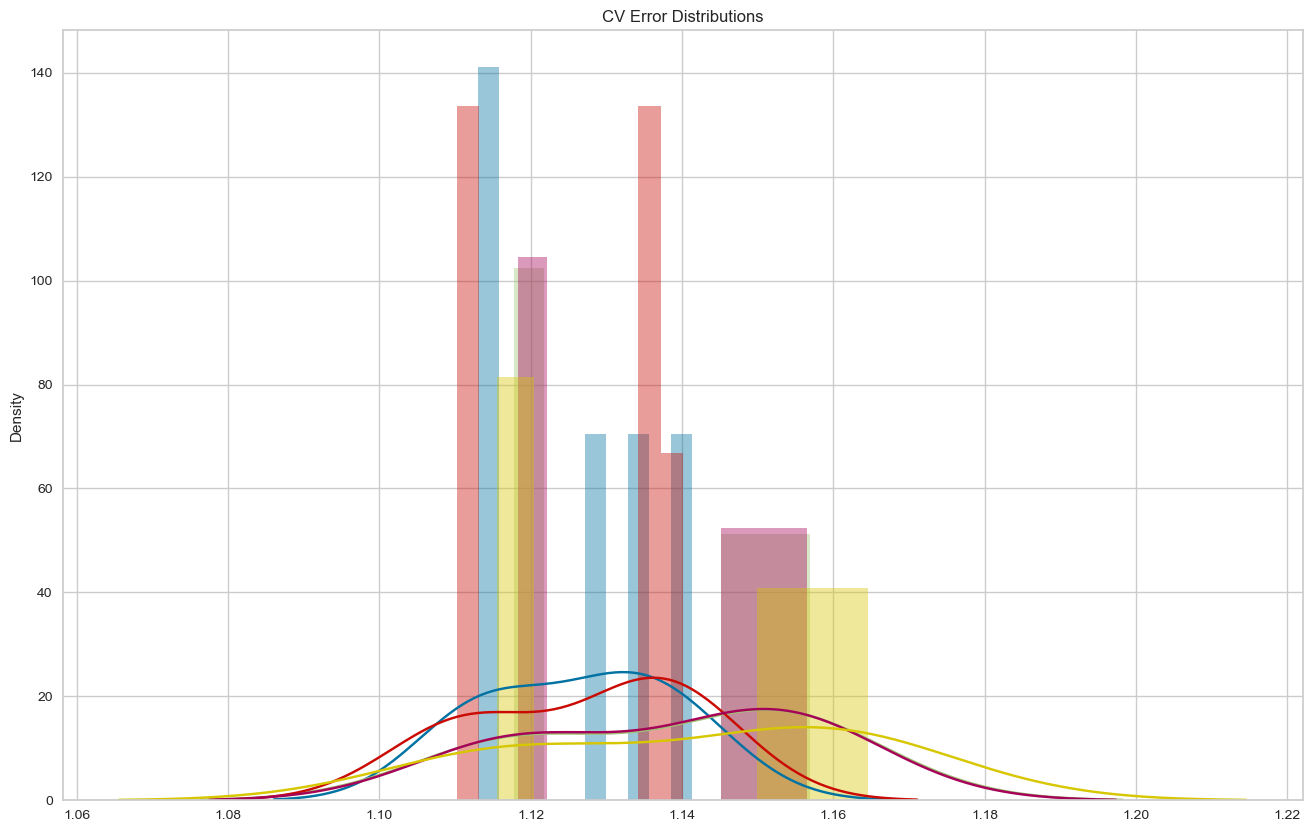

In [108]:
plt.figure(figsize=(16,10))

for name, model in models.items():
    sns.distplot(results[name], bins = 10, kde = True)
    
    

plt.title("CV Error Distributions")
plt.show()

# Combine Predictions

In [109]:
#use appropriate weights for each model
final_predictions = (
    0.45* np.exp(models['catboost'].predict(test_final)) +
    0.1 * np.exp(models['br'].predict(test_final)) +
    0.3 * np.exp(models['lightgbm'].predict(test_final)) +
    0.05 * np.exp(models['ridge'].predict(test_final)) +
    0.1 * np.exp(models['omp'].predict(test_final))
)
final_predictions

[LightGBM] [Warning] Unknown parameter: depth


array([125977.60202288, 159073.83039558, 183883.04421817, ...,
       162722.70935147, 115212.85368388, 223601.85891023])

In [123]:
final_predictions = pd.DataFrame(final_predictions).rename(columns = {0:'SalePrice'})

In [124]:
submission = pd.concat([sample.Id, final_predictions], axis = 1)

In [91]:
submission.to_csv('submission12.csv', index = False, header = True)

In [113]:
submission

Id      SalePrice
0     1461  125977.602023
1     1462  159073.830396
2     1463  183883.044218
3     1464  193763.002125
4     1465  190821.091063
...    ...            ...
1454  2915   82150.820038
1455  2916   83365.961169
1456  2917  162722.709351
1457  2918  115212.853684
1458  2919  223601.858910

[1459 rows x 2 columns]

We achieve a score of 0.12116, which is within the top 200 on the leaderboard.